In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr, pearsonr, ranksums, linregress
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
import itertools
import statannot
from statsmodels.stats.multitest import fdrcorrection
from scipy import stats
from sklearn.model_selection import KFold

from Bio import SeqIO

import pickle

from deeplift.visualization import viz_sequence

# import keras backend as K
import keras.backend as K

matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'


HEPG2_COL = 'log2FoldChange_HepG2'
K562_COL = 'log2FoldChange_K562'
H2K_COL = 'log2FoldChange_H2K'

figure_dir = 'figures'
supp_figure_dir = f'{figure_dir}/supp_figures'
revision_figure_dir = f'{figure_dir}/revision_figures'
if not os.path.exists(revision_figure_dir):
    os.makedirs(revision_figure_dir)

TITLE_FSIZE = 12
AXIS_FSIZE = 12
TEXT_FSIZE = 10

greysBig = matplotlib.cm.get_cmap('Greys', 512)
greys_trunc_cm = matplotlib.colors.ListedColormap(greysBig(np.linspace(0.6, 1, 256)))

bluesBig = matplotlib.cm.get_cmap('Blues', 512)
# blues_trunc_cm = matplotlib.colors.ListedColormap(bluesBig(np.linspace(0.15, 0.8, 256)))
blues_trunc_cm = matplotlib.colors.ListedColormap(bluesBig(np.linspace(0.25, 0.8, 256)))

orangesBig = matplotlib.cm.get_cmap('Oranges', 512)
# oranges_trunc_cm = matplotlib.colors.ListedColormap(orangesBig(np.linspace(0.15, 0.8, 256)))
oranges_trunc_cm = matplotlib.colors.ListedColormap(orangesBig(np.linspace(0.25, 0.8, 256)))

from fig_utils import plot_scatter_shaded, load_ensemble_model, load_model_for_shap, plot_seq_with_motifs,\
                      cluster_name_dict, seq_to_one_hot, one_hot_to_seq,round_palette

# import logging from matplotlib
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

D2_HEPG2_COL = 'log2FoldChange_HEPG2'
D2_K562_COL = 'log2FoldChange_K562'

HEPG2_SE_COL = 'lfcSE_HEPG2'
K562_SE_COL = 'lfcSE_K562'
H2K_SE_COL = 'lfcSE_H2K'

D3_HEPG2_SE_COL = 'lfcSE_HepG2_DNA'
D3_K562_SE_COL = 'lfcSE_K562_DNA'

D1_HEPG2_SE_COL = 'lfcSE_HEPG2_DNA'
D1_K562_SE_COL = 'lfcSE_K562_DNA'

custom_color_vec = ["#FC440F","#5B5F97","#FFC145","#BBE1C3","#6C9A8B"]
custom_green_palette = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95)

round_palette = {
    'R0': sns.color_palette("Grays", 5)[2],
    'R1': custom_color_vec[3],
    'R2': custom_green_palette[3],
}

from matplotlib import rcParams
rcParams['svg.fonttype'] = 'none'

def seq_to_one_hot_and_pad(seq,pad_len=200,order_dict = {'A':0, 'T':3, 'C':1, 'G':2}):
    x = np.zeros((len(seq), 4))
    for (i, bp) in enumerate(seq):
        x[i, order_dict[bp]] = 1
    seq_len = len(seq)
    if seq_len < pad_len:
        lpad = (pad_len-seq_len)//2
        rpad = pad_len - seq_len - lpad
        x = np.pad(x,((lpad,rpad),(0,0)),'constant')
    return x

C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\1054554386.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\1054554386.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greysBig = matplotlib.cm.get_cmap('Greys', 512)
C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\1054554386.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bluesBig = matplotlib.cm.get_cmap('Blues', 512)
C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\1054554386.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orangesBig = matplotlib.cm.get_cmap('Orange

In [3]:
### Load D1, D2, and D3 data ###

# reverse complement function
def reverse_complement(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    return ''.join(complement[base] for base in reversed(seq))

bc_deseqs_dir = 'bc_deseq_dfs/weighted/comb_dhs'

d2_deseq_df = pd.read_csv(f'{bc_deseqs_dir}/d2_deseq_df.csv')
d3_seq_df = pd.read_csv(f'{bc_deseqs_dir}/d3_seq_df.csv')
dhs_deseq_df = pd.read_csv(f'{bc_deseqs_dir}/dhs_deseq_df.csv')

d1_deseq_plus_cluster_cnts_df = pd.read_csv(f'{bc_deseqs_dir}/d1_deseq_plus_cluster_cnts_df.csv')
d2_deseq_plus_cluster_cnts_df = pd.read_csv(f'{bc_deseqs_dir}/d2_deseq_plus_cluster_cnts_df.csv')
d3_deseq_plus_cluster_cnts_df = pd.read_csv(f'{bc_deseqs_dir}/d3_deseq_plus_cluster_cnts_df.csv')

# d1_deseq_plus_cluster_cnts_df['sequence_name'] = d1_deseq_plus_cluster_cnts_df.index
# d1_deseq_plus_cluster_cnts_df['sequence_name'] = d1_deseq_plus_cluster_cnts_df['sequence_name'].apply(lambda x: f'd1_seq_{x}')

# for any seqs in d2_deseq_df with enhancer column matching a seq column in d1_deseq_plus_cluster_cnts_df, reassign sequence_name column in d2_deseq_df to corresponding column in d1_deseq_plus_cluster_cnts_df
for idx,row in d2_deseq_df.iterrows():
    cur_enhancer = row['enhancer']
    if cur_enhancer in d1_deseq_plus_cluster_cnts_df['seq'].values:
        d1_seq_name = d1_deseq_plus_cluster_cnts_df.loc[d1_deseq_plus_cluster_cnts_df['seq']==cur_enhancer,'sequence_name'].values[0]
        d2_deseq_df.loc[idx,'sequence_name'] = d1_seq_name
        # also rename the row in d2_deseq_df where enhancer is the reverse_complement of this enhancer
        d2_deseq_df.loc[d2_deseq_df['enhancer']==reverse_complement(cur_enhancer),'sequence_name'] = f'{d1_seq_name}_rc'

d2_deseq_plus_cluster_cnts_df['sequence_name'] = d2_deseq_df['sequence_name']
# rename log2FoldChange_HEPG2 to HEPG2_COL in d2_deseq_plus_cluster_cnts_df
d2_deseq_plus_cluster_cnts_df.rename(columns={'log2FoldChange_HEPG2': HEPG2_COL}, inplace=True)

# for any seqs in d3_deseq_df with enhancer column matching a seq column in d1_deseq_plus_cluster_cnts_df, reassign sequence_name column in d3_deseq_df to corresponding column in d1_deseq_plus_cluster_cnts_df
for idx,row in d3_seq_df.iterrows():
    cur_enhancer = row['sequence']
    if cur_enhancer in d1_deseq_plus_cluster_cnts_df['seq'].values:
        d1_seq_name = d1_deseq_plus_cluster_cnts_df.loc[d1_deseq_plus_cluster_cnts_df['seq']==cur_enhancer,'sequence_name'].values[0]
        d3_seq_df.loc[idx,'sequence_name'] = d1_seq_name
    elif reverse_complement(cur_enhancer) in d1_deseq_plus_cluster_cnts_df['seq'].values:
        d1_seq_name = d1_deseq_plus_cluster_cnts_df.loc[d1_deseq_plus_cluster_cnts_df['seq']==reverse_complement(cur_enhancer),'sequence_name'].values[0]
        d3_seq_df.loc[d3_seq_df['sequence']==reverse_complement(cur_enhancer),'sequence_name'] = f'{d1_seq_name}_rc'

d3_deseq_plus_cluster_cnts_df['sequence_name'] = d3_seq_df['sequence_name']


# d2_deseq_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/d2_deseq_data/chris_log2fc_df_clean2.csv')

d1_final_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/fimo_motif_scanning/saved_processed_motif_files/d1_final_df_qthresh05_v2.csv')
d2_final_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/fimo_motif_scanning/saved_processed_motif_files/d2_final_df_qthresh05_v2.csv')
d3_final_df = pd.read_csv('../designed_seqs/d3_tot_final_df_qthresh0.05.csv')

dhs_final_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/fimo_motif_scanning/saved_processed_motif_files/dw_final_df_qthresh05_v2.csv')

In [4]:
def plot_seq_shap_with_motifs(seq_idx, seq_df, motif_df,ax=None,pad_len=200,use_idx_as_motif_name=False,pred_col='log2(H2K)_pred'):

    # rename enhancer column to sequence
    seq_df = seq_df.rename(columns={'enhancer':'sequence','seq':'sequence'})

    seq_name = seq_df.loc[seq_idx,'sequence_name']
    cell_type = seq_df.loc[seq_idx,'cell_type']
    hepg2_shap = hepg2_shap_vals[seq_idx]
    k562_shap = k562_shap_vals[seq_idx]

    seq = seq_df.loc[seq_idx,'sequence']
    seq_len = len(seq)
    onehot = seq_to_one_hot(seq)

# extract shap values corresponding to real nucleotides for this sequence (could try to confirm low importance of flanking regions)
    seq_start = 0
    if seq_len < pad_len:
        seq_start = (pad_len-seq_len)//2

    dinuc_shuff_explanation = np.sum(hepg2_shap,axis=-1)[seq_start:seq_start+seq_len,None]*onehot - \
    np.sum(k562_shap,axis=-1)[seq_start:seq_start+seq_len,None]*onehot

    if cell_type == 'K562':
        dinuc_shuff_explanation *= -1

    meas_h2k = seq_df.loc[seq_idx,H2K_COL]
    if pred_col in seq_df.columns:
        pred_h2k = seq_df.loc[seq_idx,pred_col]
    else:
        pred_h2k = 0

    colors = {0:'#0f9447ff',1:'#235c99ff',2:'#f5b328ff',3:'#d42638ff'}
    if ax is None:
        fig = plt.figure(figsize=(20,2))
        ax = fig.add_subplot(111)
    viz_sequence.plot_weights_given_ax(ax,dinuc_shuff_explanation, height_padding_factor=0.2,length_padding=1,subticks_frequency=20,highlight={},colors=colors)
# drop spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


#########################################################################################################
# add a horizonal line at a height of 0.9 * upper ylim from start to stop of each row in seq_df
    if use_idx_as_motif_name:
        seq_motif_df = motif_df.loc[motif_df['sequence_name']==seq_idx]
    else:
        seq_motif_df = motif_df.loc[motif_df['sequence_name']==seq_name]
# increase upper ylim to make room for horizontal lines
    ax.set_ylim(0,1.1*ax.get_ylim()[1])
    ann_height_prop = 0.85
    text_height_prop = 0.925
    for i in range(seq_motif_df.shape[0]):
        ax.hlines(ann_height_prop*ax.get_ylim()[1],seq_motif_df.iloc[i]['start'],seq_motif_df.iloc[i]['stop'],linewidth=2,color='k')
    # add small vertical lines at start and stop of each row in seq_df, centered at 0.9*upper ylim
        ax.vlines(seq_motif_df.iloc[i]['start'],ann_height_prop*ax.get_ylim()[1]-0.05*ax.get_ylim()[1],ann_height_prop*ax.get_ylim()[1]+0.05*ax.get_ylim()[1],linewidth=2,color='k')
        ax.vlines(seq_motif_df.iloc[i]['stop'],ann_height_prop*ax.get_ylim()[1]-0.05*ax.get_ylim()[1],ann_height_prop*ax.get_ylim()[1]+0.05*ax.get_ylim()[1],linewidth=2,color='k')
    # add the text of motif_alt_id above line, centered
        motif_label = f"{seq_motif_df.iloc[i]['motif_alt_id']} ({seq_motif_df.iloc[i]['jaspar_cluster'].split('_')[1]})"
        ax.text((seq_motif_df.iloc[i]['start']+seq_motif_df.iloc[i]['stop'])/2,text_height_prop*ax.get_ylim()[1],motif_label,ha='center',va='center',fontsize=12)

# set the xlabel of the plot to be the sequence index, the measured H2K to 2 decimals, and the predicted H2K to 2 decimals
    ax.set_xlabel(f'{seq_name}: meas. vs pred log2(HEPG2/K562) = {meas_h2k:.2f}, {pred_h2k:.2f}',fontsize=14)
# layel y axis Delta SHAP, using the greek symbol for Delta
    ax.set_ylabel(r'$\Delta$SHAP',fontsize=14)

    motif_shap_sum = 0
    # for every motif in the sequence
    for i in range(seq_motif_df.shape[0]):

        motif_start = seq_motif_df.iloc[i]['start']
        motif_stop = seq_motif_df.iloc[i]['stop']

        cur_motif_shap = dinuc_shuff_explanation[motif_start:motif_stop]
        motif_shap_sum += np.sum(cur_motif_shap)

    total_shap = np.sum(dinuc_shuff_explanation)
    print(total_shap)

    # nonmotif contributionto sequence
    return (total_shap-motif_shap_sum)/total_shap

### M1 and M0+1 performance on M0 test set ###

In [57]:
# load in R0 test set
cf_dir = '../../figures/crossfolds/cf10'
results_dir = '../../../cf10/test_fold_0/'
saved_preds_dir = 'revision_scripts/1_2'
os.makedirs(saved_preds_dir,exist_ok=True)

n_cfs = 10
test_cf_idx = 0
x_cf = np.load(f'{cf_dir}/x_cf{test_cf_idx}.npy')
y_cf = np.load(f'{cf_dir}/y_cf{test_cf_idx}.npy')
w_cf = np.load(f'{cf_dir}/w_cf{test_cf_idx}.npy')

# padd to 200 bp, also extract only the d1 columns
lpad = (200-145)//2
rpad = 200 - 145 - lpad

# for each cf, extract the y_cf rows where w_cf[:,0] == 1 (these are the d1/R0 seqs)
w_data_idx = 1 # 1 for d1, 0 for d2
data_cols = [0,2] # [0,2] for d1, [1,3] for d2

dataset_suffix = 'd1' if w_data_idx == 1 else 'dhs' # for saved prediction array names

x_cf = x_cf[w_cf[:,0] == w_data_idx]
# pad the x_cfs with all 0s by lpad on the left, rpad on the right (axis 1)
x_cf = np.pad(x_cf, ((0,0),(lpad,rpad),(0,0)), 'constant', constant_values=0)

y_cf = y_cf[w_cf[:,0] == w_data_idx]
# extract the 0st and 2nd columns of y_cf (d1)
y_cf = y_cf[:,data_cols]
# add 3rd col for h2k
y_cf = np.concatenate((y_cf, np.expand_dims(y_cf[:,0] - y_cf[:,1],axis=1) ), axis=1)

# okay, now I need to load in the 3 different ensemble types for generating the predictions

model_dir = 'retrained_models/cf10/test_fold_0'

# M0, M0+1, M1
model_types = ['d1',
               'd1_finetuned',
               'd2_dhs/hp_0',
               ]

model_basenames = {
    'd1': 'd1_wide_cf_t0_v',
    'd1_finetuned': 'd1_wide_ft_cf_t0_v',
    'd2_dhs/hp_0': 'd2_dhs_wide_cf_t0_v'
}

# for each model type, load the ensemble model and generate predictions
for model_type in model_types:
    K.clear_session()
    print(model_type)

    # create results_csv for storing predictions with columns model_type, hepg2_rs, k562_rs, h2k_rs
    results_csv = f'{results_dir}/{model_type}/{model_basenames[model_type][:-2]}_d1_test_results_spearmanr.txt'

    model_inds = np.arange(1,10)

    # collect predictions for all 9 models, will average and save as the ensemble predictions
    y_preds = np.zeros((len(model_inds),x_cf.shape[0],3))

    with open(results_csv,'w') as f:
        
        # load ensemble model
        model_basename = f'{model_type}/{model_basenames[model_type]}'
        
        for model_ind in model_inds:
            K.clear_session()
            model = load_model_for_shap(model_dir,model_basename,model_ind)

            # model = load_ensemble_model(model_dir,model_basename,model_inds)

            # generate predictions

            y_pred = model.predict(x_cf)

            # add 3rd col for h2k
            y_pred = np.concatenate((y_pred, np.expand_dims(y_pred[:,0] - y_pred[:,1],axis=1) ), axis=1)

            y_preds[model_ind-1] = y_pred

            # now obtain spearman r for each column and record in results_df
            hepg2_rs = spearmanr(y_cf[:,0],y_pred[:,0])[0]
            k562_rs = spearmanr(y_cf[:,1],y_pred[:,1])[0]
            h2k_rs = spearmanr(y_cf[:,2],y_pred[:,2])[0]

            # write to results_csv

            f.write(f'{hepg2_rs},{k562_rs},{h2k_rs}\n')

    # average predictions
    y_preds_ensemble = np.mean(y_preds,axis=0)
    # save predictions
    np.save(f'{saved_preds_dir}/{model_type.split("/")[0]}_{dataset_suffix}_test_preds.npy',y_preds_ensemble)

C:\Users\Chris\AppData\Local\Temp\ipykernel_20900\34878120.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  spearman_df['model'].replace({'d1':'M0','d1_finetuned':'M0+1','d2_dhs/hp_0':'M1'},inplace=True)
C:\Users\Chris\AppData\Local\Temp\ipykernel_20900\34878120.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels,fontsize=TEXT_FSIZE)


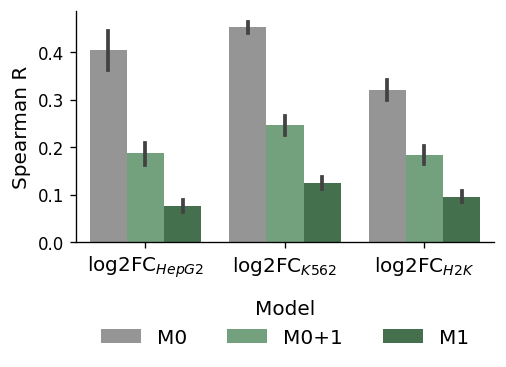

In [14]:
TEXT_FSIZE = 12
plt.rcParams['svg.fonttype'] = 'none'

spearman_df = pd.DataFrame()
for model_type in model_types:
    df = pd.read_csv(f'{results_dir}/{model_type}/{model_basenames[model_type][:-2]}_d1_test_results_spearmanr.txt',header=None)
    df.columns = ['hepg2_d1','k562_d1','h2k_d1']
    df['model'] = model_type
    spearman_df = pd.concat([spearman_df,df])

# barplot of pearson correlations grouped by model
spearman_df = spearman_df.melt(id_vars=['model'],value_vars=['hepg2_d1','k562_d1','h2k_d1'])
spearman_df.columns = ['model','cell_line','pearsonr']

# rename columns: 'd1' to 'R0', 'd1_finetuned' to 'R0+R1', 'd2_dhs/hp_0' to 'R1' -> this is for plotting purposes
# spearman_df['model'].replace({'d1':'R0','d1_finetuned':'R0+R1','d2_dhs/hp_0':'R1'},inplace=True)
spearman_df['model'].replace({'d1':'M0','d1_finetuned':'M0+1','d2_dhs/hp_0':'M1'},inplace=True)

custom_color_vec = ["#FC440F","#5B5F97","#FFC145","#BBE1C3","#6C9A8B"]
custom_green_palette = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95)
palette = {
    'M0': sns.color_palette("Grays", 5)[2],
    'R1-D': custom_green_palette[1],
    'M0+1': custom_green_palette[2],
    'M1': custom_green_palette[3],
}

fig, ax = plt.subplots(figsize=(4.5,2.5))
order = ['hepg2_d1','k562_d1','h2k_d1']
xtick_labels = ['log2FC$_{HepG2}$','log2FC$_{K562}$','log2FC$_{H2K}$']
ax = sns.barplot(x='cell_line',y='pearsonr',hue='model',data=spearman_df,order=order,palette=palette)
ax.set_xticklabels(xtick_labels,fontsize=TEXT_FSIZE)
ax.set_xlabel('')
ax.set_ylabel('Spearman R',fontsize=TEXT_FSIZE)
ax.set_title('')

# despine
sns.despine()

# remove grid
ax.grid(False)
# remove space between bars


# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
legend_labels = ['M0','M0+1','M1']
legend_title = 'Model'
plt.legend(bbox_to_anchor=(0.5, -0.35), loc='center', ncol=3,frameon=False,fontsize=TEXT_FSIZE,title=legend_title,title_fontsize=TEXT_FSIZE)
# move x axis label down
ax.xaxis.labelpad = 10

# save figure

plt.savefig(f'{revision_figure_dir}/figS3C_R0_model_performance.svg',format='svg')

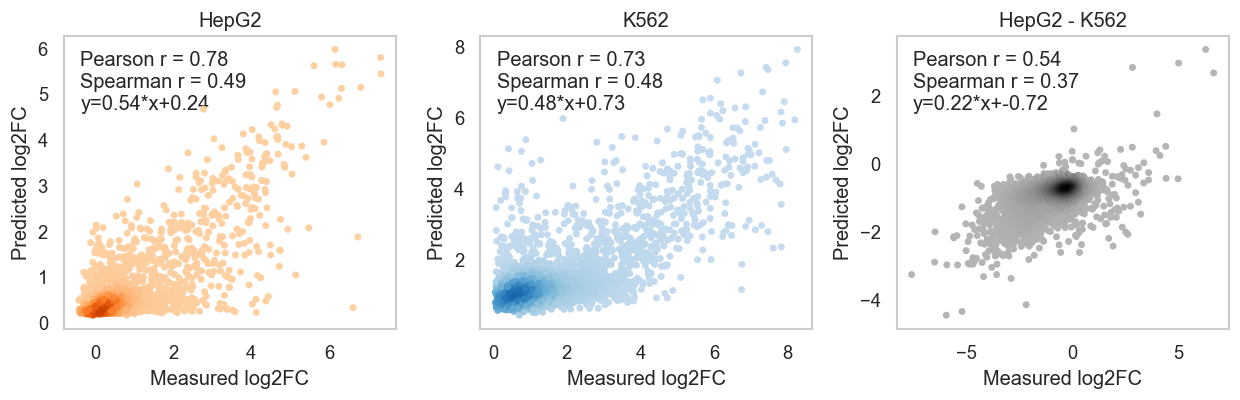

In [66]:
model_type = 'd1'
dataset_suffix = 'd1'

# load in the predictions

y_pred = np.load(f'{saved_preds_dir}/{model_type}_{dataset_suffix}_test_preds.npy')

# 1 x 3 scatterplot of PRED_COL vs MEAS_COL for each cell line

grays_trunc_cm = matplotlib.colors.ListedColormap(greysBig(np.linspace(0.4, 1, 256)))

# HEPG2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# generate 1x3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15*.7, 5*.7))

# plot HEPG2
# sns.scatterplot(data=analysis_df, x=HEPG2_MEAS_COL, y=HEPG2_PRED_COL, ax=axs[0])

plot_scatter_shaded(y_cf[:,0], y_pred[:,0],
                    axs[0], linreg=False, cmap=oranges_trunc_cm,alpha=alpha,s=s)

# calculate pearsonr, spearmanr, and regression line
hepg2_pearsonr = pearsonr(y_cf[:,0], y_pred[:,0])[0]
hepg2_spearmanr = spearmanr(y_cf[:,0], y_pred[:,0])[0]
slope, intercept = np.polyfit(y_cf[:,0], y_pred[:,0], 1)
axs[0].set_title('HepG2')
axs[0].set_xlabel('Measured log2FC')
axs[0].set_ylabel('Predicted log2FC')
# add text annotation
axs[0].text(0.05, 0.75, f'Pearson r = {hepg2_pearsonr:.2f}\nSpearman r = {hepg2_spearmanr:.2f}\ny={slope:.2f}*x+{intercept:.2f}', transform=axs[0].transAxes)

# plot K562
# sns.scatterplot(data=analysis_df, x=K562_MEAS_COL, y=K562_PRED_COL, ax=axs[1])

plot_scatter_shaded(y_cf[:,1], y_pred[:,1],
                    axs[1], linreg=False, cmap=blues_trunc_cm,alpha=alpha,s=s)

# calculate pearsonr, spearmanr, and regression line
k562_pearsonr = pearsonr(y_cf[:,1], y_pred[:,1])[0]
k562_spearmanr = spearmanr(y_cf[:,1], y_pred[:,1])[0]
slope, intercept = np.polyfit(y_cf[:,1], y_pred[:,1], 1)
axs[1].set_title('K562')
axs[1].set_xlabel('Measured log2FC')
axs[1].set_ylabel('Predicted log2FC')
# add text annotation
axs[1].text(0.05, 0.75, f'Pearson r = {k562_pearsonr:.2f}\nSpearman r = {k562_spearmanr:.2f}\ny={slope:.2f}*x+{intercept:.2f}', transform=axs[1].transAxes)

# plot SKNSH
# sns.scatterplot(data=analysis_df, x=H2K_MEAS_COL, y=H2K_PRED_COL, ax=axs[2])

plot_scatter_shaded(y_cf[:,2], y_pred[:,2],
                    axs[2], linreg=False, cmap=grays_trunc_cm,alpha=alpha,s=s)


# calculate pearsonr, spearmanr, and regression line
sknsh_pearsonr = pearsonr(y_cf[:,2], y_pred[:,2])[0]
sknsh_spearmanr = spearmanr(y_cf[:,2], y_pred[:,2])[0]
slope, intercept = np.polyfit(y_cf[:,2], y_pred[:,2], 1)
axs[2].set_title('HepG2 - K562')
axs[2].set_xlabel('Measured log2FC')
axs[2].set_ylabel('Predicted log2FC')
# add text annotation
axs[2].text(0.05, 0.75, f'Pearson r = {sknsh_pearsonr:.2f}\nSpearman r = {sknsh_spearmanr:.2f}\ny={slope:.2f}*x+{intercept:.2f}', transform=axs[2].transAxes)

# remove grid lines
axs[0].grid(False)
axs[1].grid(False)
axs[2].grid(False)

plt.tight_layout()
plt.show()


In [297]:
# Also confirm the M0+1+2 models fare well on M1 test set

# load in R1 test set
cf_dir = '../../Designing_Cell_Type_Specific_Enhancer_Sequences/figures/crossfolds/cf10'
results_dir = '../../aws/for_aws/sequencing_analysis/retraining/retrained_models/cf10/test_fold_0/'

n_cfs = 10
test_cf_idx = 0
x_cf = np.load(f'{cf_dir}/x_cf{test_cf_idx}.npy')
y_cf = np.load(f'{cf_dir}/y_cf{test_cf_idx}.npy')
w_cf = np.load(f'{cf_dir}/w_cf{test_cf_idx}.npy')

# padd to 200 bp, also extract only the d1 columns
lpad = (200-145)//2
rpad = 200 - 145 - lpad

# for each cf, extract the y_cf rows where w_cf[:,0] == 1 (these are the d1/R0 seqs)
w_data_idx = 0 # 1 for d1, 0 for d2
data_cols = [1,3] # [0,2] for d1, [1,3] for d2

x_cf = x_cf[w_cf[:,0] == w_data_idx]
# pad the x_cfs with all 0s by lpad on the left, rpad on the right (axis 1)
x_cf = np.pad(x_cf, ((0,0),(lpad,rpad),(0,0)), 'constant', constant_values=0)

y_cf = y_cf[w_cf[:,0] == w_data_idx]
# extract the 0st and 2nd columns of y_cf (d1)
y_cf = y_cf[:,data_cols]
# add 3rd col for h2k
y_cf = np.concatenate((y_cf, np.expand_dims(y_cf[:,0] - y_cf[:,1],axis=1) ), axis=1)

# now I need to load the d3_finetuned models

model_dir = 'd2_finetuned/test_fold_0' # note - this excludes ablations and top enhancer perturbations
model_basename = 'd1_wide_ft_cf_t0_v'
model_suffix = '_d2_ft'


# then, generate predictions


# create results_csv for storing predictions with columns model_type, hepg2_rs, k562_rs, h2k_rs
results_csv = f'd2_finetuned/test_fold_0/d1_test_results_spearmanr.txt'

with open(results_csv,'w') as f:
    
    # load ensemble model
    model_inds = np.arange(1,10)

    for model_ind in model_inds:
        K.clear_session()
        model = load_model_for_shap(model_dir,model_basename,model_ind,model_suffix=model_suffix)

        # model = load_ensemble_model(model_dir,model_basename,model_inds)

        # generate predictions

        y_pred = model.predict(x_cf)

        # add 3rd col for h2k
        y_pred = np.concatenate((y_pred, np.expand_dims(y_pred[:,0] - y_pred[:,1],axis=1) ), axis=1)

        # now obtain spearman r for each column and record in results_df
        hepg2_rs = spearmanr(y_cf[:,0],y_pred[:,0])[0]
        k562_rs = spearmanr(y_cf[:,1],y_pred[:,1])[0]
        h2k_rs = spearmanr(y_cf[:,2],y_pred[:,2])[0]

        # write to results_csv

        f.write(f'{hepg2_rs},{k562_rs},{h2k_rs}\n')

4/4 [==============================] - 0s 12ms/step


C:\Users\Chris\AppData\Local\Temp\ipykernel_30724\2973460535.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  spearman_df['model'].replace({'d1':'M0','d1_finetuned':'M0+1','d2_dhs/hp_0':'M1'},inplace=True)
C:\Users\Chris\AppData\Local\Temp\ipykernel_30724\2973460535.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels,fontsize=TEXT_FSIZE)


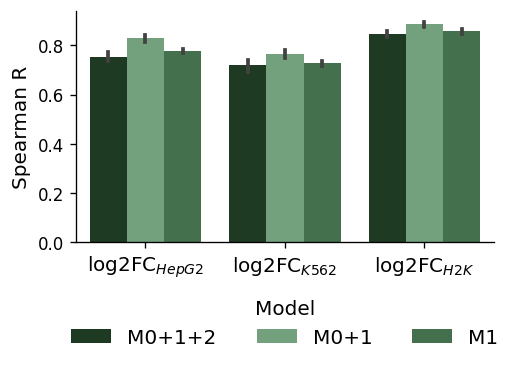

In [307]:
TEXT_FSIZE = 12

spearman_df = pd.DataFrame()

# first add the M0+1+2 model results
df = pd.read_csv(results_csv,header=None)
df.columns = ['hepg2_d2','k562_d2','h2k_d2']
df['model'] = 'M0+1+2'
# remove last row - this is the ensemble performance
df = df.iloc[:-1,:]
spearman_df = pd.concat([spearman_df,df])


# now add the M0+1, M1
model_types = ['d1_finetuned',
               'd2_dhs/hp_0',
               ]

model_basenames = {
    'd1_finetuned': 'd1_wide_ft_cf_t0_v',
    'd2_dhs/hp_0': 'd2_dhs_wide_cf_t0_v'
}

cf_dir = '../../Designing_Cell_Type_Specific_Enhancer_Sequences/figures/crossfolds/cf10'
# results_dir = '../../aws/for_aws/sequencing_analysis/retraining/retrained_models/cf10/test_fold_0/'
data_dir = '../../../aws/for_aws/sequencing_analysis/retraining/retrained_models/cf10/test_fold_0'
results_basenames = {
    'd1': 'd1_wide_cf',
    'd1_finetuned': 'cf10_d1_t0_finetuned',
    'd2_dhs/hp_0': 'cf10_d2_dw_t0'
}

for model_type in model_types:
    df = pd.read_csv(f'{data_dir}/{model_type}/{results_basenames[model_type]}_d2_dhs_test_results_spearmanr.txt',header=None)
    # drop the last 3 cols
    df = df.iloc[:,:-3]
    df.columns = ['hepg2_d2','k562_d2','h2k_d2']
    df['model'] = model_type
    # remove last row - this is the ensemble performance
    df = df.iloc[:-1,:]
    spearman_df = pd.concat([spearman_df,df])

# barplot of pearson correlations grouped by model
spearman_df = spearman_df.melt(id_vars=['model'],value_vars=['hepg2_d2','k562_d2','h2k_d2'])
spearman_df.columns = ['model','cell_line','pearsonr']

# rename columns: 'd1' to 'R0', 'd1_finetuned' to 'R0+R1', 'd2_dhs/hp_0' to 'R1' -> this is for plotting purposes
# spearman_df['model'].replace({'d1':'R0','d1_finetuned':'R0+R1','d2_dhs/hp_0':'R1'},inplace=True)
spearman_df['model'].replace({'d1':'M0','d1_finetuned':'M0+1','d2_dhs/hp_0':'M1'},inplace=True)

custom_color_vec = ["#FC440F","#5B5F97","#FFC145","#BBE1C3","#6C9A8B"]
custom_green_palette = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95)
palette = {
    'M0': sns.color_palette("Grays", 5)[2],
    'R1-D': custom_green_palette[1],
    'M0+1': custom_green_palette[2],
    'M1': custom_green_palette[3],
    'M0+1+2': custom_green_palette[4],
}

fig, ax = plt.subplots(figsize=(4.5,2.5))
order = ['hepg2_d2','k562_d2','h2k_d2']
xtick_labels = ['log2FC$_{HepG2}$','log2FC$_{K562}$','log2FC$_{H2K}$']
ax = sns.barplot(x='cell_line',y='pearsonr',hue='model',data=spearman_df,order=order,palette=palette)
ax.set_xticklabels(xtick_labels,fontsize=TEXT_FSIZE)
ax.set_xlabel('')
ax.set_ylabel('Spearman R',fontsize=TEXT_FSIZE)
ax.set_title('')

# despine
sns.despine()

# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
legend_labels = ['M0','M0+1','M1']
legend_title = 'Model'
plt.legend(bbox_to_anchor=(0.5, -0.35), loc='center', ncol=3,frameon=False,fontsize=TEXT_FSIZE,title=legend_title,title_fontsize=TEXT_FSIZE)
# move x axis label down
ax.xaxis.labelpad = 10

### R1.3 4-mer diversity analysis ###

In [174]:
# Convert all sequenece strings into nmer lists

def str2nmer(str,nmer):
    return [str[i:i+nmer] for i in range(len(str)-nmer+1)]

# convert the string arrays into 4-mer vector

from itertools import product
from collections import defaultdict

def generate_all_nmers(n):
    """Generate all possible 4-mers using ACGT."""
    return [''.join(p) for p in product('ACGT', repeat=n)]

# operates on 1 seq at a time
def count_nmers(nmers_vec,nmer_keys):
    """Count occurrences of each n-mer in the input list of strings."""

    # Initialize a dictionary to store the counts - default fills in 0 for missing keys
    counts = defaultdict(int)
    
    # currently nmers_vec is assumed to represent 1 seq, honestly let's just go with that
    # Count each 4-mer in the input strings
    for s in nmers_vec:
        
        counts[s] += 1
    
    # Create a vector of counts for all 4-mers
    vector = [counts[mer] for mer in nmer_keys]
    return vector

# now, proceed to compute euclidean distance statistics
# first, computer internal library distances

from scipy.spatial.distance import euclidean

from itertools import combinations
def _get_min_euc_dists(vecsA, vecsB):
    # distances will be calculated with respect to vecsA

    n_seqsA = len(vecsA)
    n_seqsB = len(vecsB)
    min_distances = np.zeros(n_seqsA)
    
    for i in range(n_seqsA):
        
        distances = np.zeros(n_seqsB)
        for j in range(n_seqsB):
            distances[j] = euclidean(vecsA[i],vecsB[j])
            
        # don't need to normalize here
        min_distances[i] = np.min(distances[distances != 0])
        
    return min_distances

In [175]:
"""TODO for this analysis:

- convert all sequences in R0, R1-MPRA, and R2 to 4-mer space
- calculate minimum internal Euclidean distance
- calculate inter-library minimum internal Euclidean distance

"""

# save as npy
# save_dir = 'SI/nmer_euc_distances'
save_dir = 'SI/nmer_euc_distances/no_r0_overlaps' # alt version!!!
# create dir if it doesn't exist already
os.makedirs(save_dir, exist_ok=True)

In [74]:

# r0_analysis_df = d1_deseq_plus_cluster_cnts_df.copy()

# r1_analysis_df = d2_deseq_df[~d2_deseq_df['model_type'].isin(['sharpr-mpra','df'])].copy()

# d3_model_types = ['d1_finetuned','d2_dhs']
# d3_design_types = ['fsp','fsp_clipped']
# # this is excluding target designs, 
# r2_analysis_df = d3_seq_df[(d3_seq_df['model_type'].isin(d3_model_types)) & (d3_seq_df['design_type'].isin(d3_design_types))].copy()

# x_tot_r0 = np.concatenate(r0_analysis_df['seq'].apply(lambda x: seq_to_one_hot(x)).values).reshape(-1,145,4)
# x_tot_r1 = np.concatenate(r1_analysis_df['enhancer'].apply(lambda x: seq_to_one_hot(x)).values).reshape(-1,145,4)
# x_tot_r2 = np.concatenate(r2_analysis_df['sequence'].apply(lambda x: seq_to_one_hot(x)).values).reshape(-1,145,4)

# # these are arrays of strings
# r0_seqs = r0_analysis_df['seq'].values
# r1_seqs = r1_analysis_df['enhancer'].values
# r2_seqs = r2_analysis_df['sequence'].values


In [214]:
# # save r1_seqs and r2_seqs as separate txt files
# np.savetxt(f'r1_seqs.txt',r1_seqs,fmt='%s')
# np.savetxt(f'r2_seqs.txt',r2_seqs,fmt='%s')

In [176]:
sharpr_dir = 'external_models/sharpr-mpra'
fname1 = 'GSM1831773_ScaleUpDesign1_minP_Plasmid.counts.txt.gz'
fname2 = 'GSM1831775_ScaleUpDesign2_minP_Plasmid.counts.txt.gz'

# read in the gzipped data, keep only first 2 cols
data1 = pd.read_csv(f'{sharpr_dir}/{fname1}', sep='\t', compression='gzip').iloc[:, :2]
data2 = pd.read_csv(f'{sharpr_dir}/{fname2}', sep='\t', compression='gzip').iloc[:, :2]
# concatenate
data = pd.concat([data1, data2])
# relabel data 'Sequence' col to 'seq' to match the r0_df
data.rename(columns={'Sequence': 'seq'}, inplace=True)
# capitalize the 'seq' col
data['seq'] = data['seq'].str.upper()

# okay, now load in the r0 data, only the first 'seq' col

bc_deseqs_dir = 'bc_deseq_dfs/weighted/comb_dhs'
r0_df = pd.read_csv(f'{bc_deseqs_dir}/d1_deseq_plus_cluster_cnts_df.csv').iloc[:, :1]
r0_df['seq'] = r0_df['seq'].str.upper()

# subset data for only the sequences that are in the r0_df
data = data[data['seq'].isin(r0_df['seq'])]
# drop all duplicates
data = data.drop_duplicates(subset='seq')

# how many 145 bp tiles of 295bp sequence at 5bp steps?
# 295 - 145 = 150
# 150 / 5 = 30: so 0-29 are the indices

data['site_id'] = data['ID'].apply(lambda x: x.split('_')[-1])
data['stride_index'] = data['ID'].apply(lambda x: int(x.split('_')[-3]))

# count unique site_ids
data['site_id'].nunique()

# okay, for each site_id that has multiple stride_indices, we want to keep the one with the stride closest to 15 (the middle point)
# first, get the stride_index that is closest to 15
data['dist_to_15'] = np.abs(data['stride_index'] - 15)
data = data.sort_values('dist_to_15')
data = data.drop_duplicates(subset='site_id', keep='first')

In [177]:
# I begin by copying the code for loading the sequences from the Edit distance section above

# r0_analysis_df = d1_deseq_plus_cluster_cnts_df.copy()
r0_analysis_df = data.copy() # this is removing the overlapping sequences (EVERYTHING ELSE STAYS THE SAME)

r1_analysis_df = d2_deseq_df[~d2_deseq_df['model_type'].isin(['sharpr-mpra','df'])].copy()

d3_model_types = ['d1_finetuned','d2_dhs']
d3_design_types = ['fsp','fsp_clipped']
# this is excluding target designs, 
r2_analysis_df = d3_seq_df[(d3_seq_df['model_type'].isin(d3_model_types)) & (d3_seq_df['design_type'].isin(d3_design_types))].copy()

x_tot_r0 = np.concatenate(r0_analysis_df['seq'].apply(lambda x: seq_to_one_hot(x)).values).reshape(-1,145,4)
x_tot_r1 = np.concatenate(r1_analysis_df['enhancer'].apply(lambda x: seq_to_one_hot(x)).values).reshape(-1,145,4)
x_tot_r2 = np.concatenate(r2_analysis_df['sequence'].apply(lambda x: seq_to_one_hot(x)).values).reshape(-1,145,4)

# these are arrays of strings
r0_seqs = r0_analysis_df['seq'].values
r1_seqs = r1_analysis_df['enhancer'].values
r2_seqs = r2_analysis_df['sequence'].values

# def write_to_pseudobed(seqs,fname,dir):
#     with open(f'{dir}/{fname}.bed','w') as f:
#         for i in range(len(seqs)):
#             f.write(f'chr1\t{i}\t{i+1}\t{seqs[i]}\n')

# dir = 'pseudobeds'
# os.makedirs(dir,exist_ok=True)

# fname = 'r0_seqs'
# seqs = r0_analysis_df['seq'].values
# write_to_pseudobed(seqs,fname,dir)

# fname = 'r1_seqs'
# seqs = r1_analysis_df['enhancer'].values
# write_to_pseudobed(seqs,fname,dir)

# fname = 'r2_seqs'
# seqs = r2_analysis_df['sequence'].values
# write_to_pseudobed(seqs,fname,dir)

# Convert all sequenece strings into nmer lists

nmer = 4
r0_nmers = np.array([str2nmer(seq,nmer) for seq in r0_seqs])
r1_nmers = np.array([str2nmer(seq,nmer) for seq in r1_seqs])
r2_nmers = np.array([str2nmer(seq,nmer) for seq in r2_seqs])

# okay, now convert the string arrays into 4-mer vector

nmer_keys = generate_all_nmers(nmer)

# finally obtain the nmer vecs for all sequences in these libraries
r0_nmer_vec = np.array([count_nmers(vec,nmer_keys) for vec in r0_nmers])
r1_nmer_vec = np.array([count_nmers(vec,nmer_keys) for vec in r1_nmers])
r2_nmer_vec = np.array([count_nmers(vec,nmer_keys) for vec in r2_nmers])

# create shuffled versions of the sequences
# define shuffle_seq function
# def shuffle_seq(seq):
#     return ''.join(np.random.permutation(list(seq)))
random_seed = 2021
rng = np.random.default_rng(random_seed)
def shuffle_seq(seq,rng):
    return ''.join(rng.permutation(list(seq)))

r0_seqs_shuffled = np.array([shuffle_seq(seq,rng) for seq in r0_seqs])
r1_seqs_shuffled = np.array([shuffle_seq(seq,rng) for seq in r1_seqs])
r2_seqs_shuffled = np.array([shuffle_seq(seq,rng) for seq in r2_seqs])

# convert to 4-mer space

r0_shuffled_nmers = np.array([str2nmer(seq,4) for seq in r0_seqs_shuffled])
r1_shuffled_nmers = np.array([str2nmer(seq,4) for seq in r1_seqs_shuffled])
r2_shuffled_nmers = np.array([str2nmer(seq,4) for seq in r2_seqs_shuffled])

r0_shuffled_nmer_vec = np.array([count_nmers(nmers,generate_all_nmers(4)) for nmers in r0_shuffled_nmers])
r1_shuffled_nmer_vec = np.array([count_nmers(nmers,generate_all_nmers(4)) for nmers in r1_shuffled_nmers])
r2_shuffled_nmer_vec = np.array([count_nmers(nmers,generate_all_nmers(4)) for nmers in r2_shuffled_nmers])

In [115]:
# now, proceed to compute euclidean distance statistics
# first, computer internal library distances

r0_vs_r0_min_dist = _get_min_euc_dists(r0_nmer_vec,r0_nmer_vec)
# r1_vs_r1_min_dist = _get_min_euc_dists(r1_nmer_vec,r1_nmer_vec)
# r2_vs_r2_min_dist = _get_min_euc_dists(r2_nmer_vec,r2_nmer_vec)

np.save(f'{save_dir}/r0_vs_r0_min_nmer_dist.npy',r0_vs_r0_min_dist)
# np.save(f'{save_dir}/r1_vs_r1_min_nmer_dist.npy',r1_vs_r1_min_dist)
# np.save(f'{save_dir}/r2_vs_r2_min_nmer_dist.npy',r2_vs_r2_min_dist)

# then, compute R1 vs R0, R2 vs R1

r1_vs_r0_min_dist = _get_min_euc_dists(r1_nmer_vec,r0_nmer_vec)
# r2_vs_r1_min_dist = _get_min_euc_dists(r2_nmer_vec,r1_nmer_vec)

np.save(f'{save_dir}/r1_vs_r0_min_nmer_dist.npy',r1_vs_r0_min_dist)
# np.save(f'{save_dir}/r2_vs_r1_min_nmer_dist.npy',r2_vs_r1_min_dist)

# finally, compute random vs R0, random vs R1

# # 1000 random sequences
# with open(f'SI/edit_distances/x_rand_r0.pkl','rb') as f:
#     x_rand_r0 = pickle.load(f)
# with open(f'SI/edit_distances/x_rand_r1.pkl','rb') as f:
# #     x_rand_r1 = pickle.load(f)

# r0_rand_nmers = np.array([str2nmer(seq,nmer) for seq in x_rand_r0])
# r0_rand_nmer_vec = np.array([count_nmers(vec,nmer_keys) for vec in r0_rand_nmers])

# r1_rand_nmers = np.array([str2nmer(seq,nmer) for seq in x_rand_r1])
# r1_rand_nmer_vec = np.array([count_nmers(vec,nmer_keys) for vec in r1_rand_nmers])

# rand_vs_r0_min_dist = _get_min_euc_dists(r0_rand_nmer_vec,r0_nmer_vec)
# rand_vs_r1_min_dist = _get_min_euc_dists(r1_rand_nmer_vec,r1_nmer_vec)

# np.save(f'{save_dir}/rand_vs_r0_min_nmer_dist.npy',rand_vs_r0_min_dist)
# np.save(f'{save_dir}/rand_vs_r1_min_nmer_dist.npy',rand_vs_r1_min_dist)

In [116]:
# NEW: Calculate distances relative to shuffled versions of the sequences

shuffled_vs_r0_min_dist = _get_min_euc_dists(r0_shuffled_nmer_vec,r0_nmer_vec)
# shuffled_vs_r1_min_dist = _get_min_euc_dists(r1_shuffled_nmer_vec,r1_nmer_vec)

np.save(f'{save_dir}/shuffled_vs_r0_min_nmer_dist.npy',shuffled_vs_r0_min_dist)
# np.save(f'{save_dir}/shuffled_vs_r1_min_nmer_dist.npy',shuffled_vs_r1_min_dist)

In [6]:
load_dist = True
if load_dist:
   r0_vs_r0_min_dist   = np.load(f'{save_dir}/r0_vs_r0_min_nmer_dist.npy')
   r1_vs_r1_min_dist   = np.load(f'{save_dir}/r1_vs_r1_min_nmer_dist.npy')
   r2_vs_r2_min_dist   = np.load(f'{save_dir}/r2_vs_r2_min_nmer_dist.npy')
   r1_vs_r0_min_dist   = np.load(f'{save_dir}/r1_vs_r0_min_nmer_dist.npy')
   r2_vs_r1_min_dist   = np.load(f'{save_dir}/r2_vs_r1_min_nmer_dist.npy')
   rand_vs_r0_min_dist = np.load(f'{save_dir}/rand_vs_r0_min_nmer_dist.npy')
   rand_vs_r1_min_dist = np.load(f'{save_dir}/rand_vs_r1_min_nmer_dist.npy')
   shuffled_vs_r0_min_dist = np.load(f'{save_dir}/shuffled_vs_r0_min_nmer_dist.npy')
   shuffled_vs_r1_min_dist = np.load(f'{save_dir}/shuffled_vs_r1_min_nmer_dist.npy')

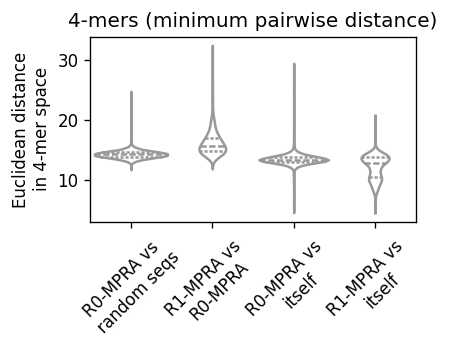

In [151]:
# violin plot: rand_vs_r0_min_dist, r1_vs_r0_min_dist,
#              r0_vs_r0_min_dist, r1_vs_r1_min_dist

# label_vec = ['0']*len(rand_vs_r0_min_dist) + \
#             ['1']*len(r1_vs_r0_min_dist) + \
#             ['2']*len(r0_vs_r0_min_dist) + \
#             ['3']*len(r1_vs_r1_min_dist)

# dist_vec = np.concatenate([rand_vs_r0_min_dist,r1_vs_r0_min_dist,
#                            r0_vs_r0_min_dist,r1_vs_r1_min_dist])

label_vec = ['0']*len(shuffled_vs_r0_min_dist) + \
            ['1']*len(r1_vs_r0_min_dist) + \
            ['2']*len(r0_vs_r0_min_dist) + \
            ['3']*len(r1_vs_r1_min_dist)

dist_vec = np.concatenate([shuffled_vs_r0_min_dist,r1_vs_r0_min_dist,
                           r0_vs_r0_min_dist,r1_vs_r1_min_dist])

df2plot = np.array([dist_vec,label_vec]).T
df2plot = pd.DataFrame(data=df2plot,columns=['dist','label'],dtype='float')

df2plot['label'] = df2plot['label'].replace(0,'R0-MPRA vs \nrandom seqs')
df2plot['label'] = df2plot['label'].replace(1,'R1-MPRA vs \nR0-MPRA')
df2plot['label'] = df2plot['label'].replace(2,'R0-MPRA vs \nitself')
df2plot['label'] = df2plot['label'].replace(3,'R1-MPRA vs \nitself')

# # set 'dist' col to float
# df2plot['dist'] = df2plot['dist'].astype('float')

plt.figure(figsize=(3.5,2))
# sns.violinplot(x=df2plot['label'],y=df2plot['dist'])
sns.violinplot(data=df2plot,x='label',y='dist',inner='quart',facecolor='white',linewidth=1.5,width=0.9)
plt.xticks(rotation=45)
plt.ylabel('Euclidean distance\nin 4-mer space')
plt.title('4-mers (minimum pairwise distance)')
plt.xlabel('')
# xtick_labels = ['R0-MPRA vs random seqs',
#                 'R1-MPRA vs R0-MPRA',
#                 'R0-MPRA vs itself',
#                 'R1-MPRA vs itself']
# plt.xticks(xtick_labels)

plt.savefig(f'{revision_figure_dir}/figS1E_4mer_distance.png',dpi=500,bbox_inches='tight')
# plt.savefig(f'{revision_figure_dir}/figS1E_4mer_distance.svg',format='svg')

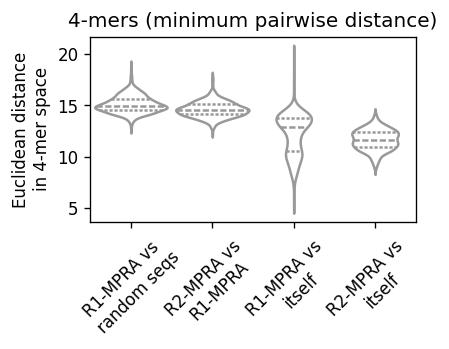

In [8]:
# violin plot: rand_vs_r1_min_dist, r2_vs_r1_min_dist,
#              r1_vs_r1_min_dist, r2_vs_r2_min_dist

# label_vec = ['0']*len(rand_vs_r1_min_dist) + \
#             ['1']*len(r2_vs_r1_min_dist) + \
#             ['2']*len(r1_vs_r1_min_dist) + \
#             ['3']*len(r2_vs_r2_min_dist)

# dist_vec = np.concatenate([rand_vs_r1_min_dist,r2_vs_r1_min_dist,
#                            r1_vs_r1_min_dist,r2_vs_r2_min_dist])

label_vec = ['0']*len(shuffled_vs_r1_min_dist) + \
            ['1']*len(r2_vs_r1_min_dist) + \
            ['2']*len(r1_vs_r1_min_dist) + \
            ['3']*len(r2_vs_r2_min_dist)

dist_vec = np.concatenate([shuffled_vs_r1_min_dist,r2_vs_r1_min_dist,
                           r1_vs_r1_min_dist,r2_vs_r2_min_dist])

df2plot = np.array([dist_vec,label_vec]).T
df2plot = pd.DataFrame(data=df2plot,columns=['dist','label'],dtype='float')

df2plot['label'] = df2plot['label'].replace(0,'R1-MPRA vs \nrandom seqs')
df2plot['label'] = df2plot['label'].replace(1,'R2-MPRA vs \nR1-MPRA')
df2plot['label'] = df2plot['label'].replace(2,'R1-MPRA vs \nitself')
df2plot['label'] = df2plot['label'].replace(3,'R2-MPRA vs \nitself')

# # set 'dist' col to float
# df2plot['dist'] = df2plot['dist'].astype('float')

plt.figure(figsize=(3.5,2))
# sns.violinplot(x=df2plot['label'],y=df2plot['dist'])
sns.violinplot(data=df2plot,x='label',y='dist',inner='quart',facecolor='white',linewidth=1.5,width=0.9)
plt.xticks(rotation=45)
plt.ylabel('Euclidean distance\nin 4-mer space')
plt.xlabel('')
plt.title('4-mers (minimum pairwise distance)')
# xtick_labels = ['R0-MPRA vs random seqs',
#                 'R1-MPRA vs R0-MPRA',
#                 'R0-MPRA vs itself',
#                 'R1-MPRA vs itself']
# plt.xticks(xtick_labels)

# plt.savefig(f'{revision_figure_dir}/figS1D_edit_distance.png',dpi=500,bbox_inches='tight')

plt.savefig(f'{revision_figure_dir}/figS3D_4mer_distance.png',dpi=500,bbox_inches='tight')

In [38]:
#### okay I have to redo the edit-distance plots then

# x_tot_r0 = np.concatenate(r0_analysis_df['seq'].apply(lambda x: seq_to_one_hot(x)).values).reshape(-1,145,4)
# x_tot_r1 = np.concatenate(r1_analysis_df['enhancer'].apply(lambda x: seq_to_one_hot(x)).values).reshape(-1,145,4)
# x_tot_r2 = np.concatenate(r2_analysis_df['sequence'].apply(lambda x: seq_to_one_hot(x)).values).reshape(-1,145,4)

edit_distance_save_dir = 'SI/edit_distances/revision'
os.makedirs(edit_distance_save_dir,exist_ok=True)


In [125]:
# All of these are calculated in cells above
# don't need to create random sequences I already have the shuffles
# just one hot-encode the previously generated shuffled sequences

x_rand_r0 = r0_seqs_shuffled
x_rand_r1 = r1_seqs_shuffled
x_rand_r2 = r2_seqs_shuffled

# r0_seqs, r1_seqs, r2_seqs are already defined in the nmer cells

# calculate pairwise Levenshtein distances
from Levenshtein import distance

load_internal_rand_dist = False

if load_internal_rand_dist:
    with open(f'{edit_distance_save_dir}/rand_internal_dist_r0.pkl','rb') as f:
        rand_dist_r0 = pickle.load(f)
    with open(f'{edit_distance_save_dir}/rand_internal_dist_r1.pkl','rb') as f:
        rand_dist_r1 = pickle.load(f)
    with open(f'{edit_distance_save_dir}/rand_internal_dist_r2.pkl','rb') as f:
        rand_dist_r2 = pickle.load(f)
else:
    for idx,x_rand in enumerate([x_rand_r0, x_rand_r1, x_rand_r2]):
        rand_dist = np.array([distance(x_rand[i], x_rand[j]) for i, j in itertools.combinations(range(len(x_rand)), 2)])
        rand_dist = rand_dist / 145.
        # save rand_dist
        with open(f'{edit_distance_save_dir}/rand_internal_dist_r{idx}.pkl','wb') as f:
            pickle.dump(rand_dist,f)
        print(np.mean(rand_dist))
        print(np.median(rand_dist))

# calculate smallest pairwise Levenshtein distance between each rando sequence and all the sequences in d1
    
# R1 rand vs R0

comp_seqs = r0_seqs.copy()
rand_dist = np.array([np.min([distance(x_rand_r1[i], comp_seqs[j]) for j in range(len(comp_seqs))]) for i in range(len(x_rand))])
rand_dist = rand_dist / 145.
# save rand_dist
with open(f'{edit_distance_save_dir}/rand_dist_rand_r1_vs_r0.pkl','wb') as f:
    pickle.dump(rand_dist,f)
print(np.mean(rand_dist))
print(np.median(rand_dist))

# R2 rand vs R0

rand_dist = np.array([np.min([distance(x_rand_r2[i], comp_seqs[j]) for j in range(len(comp_seqs))]) for i in range(len(x_rand))])
rand_dist = rand_dist / 145.
# save rand_dist
with open(f'{edit_distance_save_dir}/rand_dist_rand_r2_vs_r0.pkl','wb') as f:
    pickle.dump(rand_dist,f)
print(np.mean(rand_dist))
print(np.median(rand_dist))

# R2 rand vs R1

comp_seqs = r1_seqs.copy()
rand_dist = np.array([np.min([distance(x_rand_r2[i], comp_seqs[j]) for j in range(len(comp_seqs))]) for i in range(len(x_rand))])
rand_dist = rand_dist / 145.
# save rand_dist
with open(f'{edit_distance_save_dir}/rand_dist_rand_r2_vs_r1.pkl','wb') as f:
    pickle.dump(rand_dist,f)
print(np.mean(rand_dist))
print(np.median(rand_dist))

0.5528277061290193
0.5517241379310345
0.5580684406326301
0.5586206896551724
0.5468644397208321
0.5448275862068965
0.4614574979951884
0.46206896551724136
0.46640938251804337
0.4689655172413793
0.4795809943865276
0.4827586206896552


In [127]:
# I don't need to recalculate internal library diversity of the designed seqs, just copy over the d1_vs_d1_min_dist and d3_vs_d3_min_dist vecs!!

# I do need to calculate the R0 internal library dist though

# okay now I need to estimate the internal library diversity of the designed sequences

def _get_min_distances(seqs):
    n_seqs = len(seqs)
    min_distances = np.zeros(n_seqs)
    
    for i in range(n_seqs):
        
        distances = np.zeros(n_seqs)
        for j in range(n_seqs):
            distances[j] = distance(seqs[i],seqs[j])
            
        min_distances[i] = np.min(distances[distances != 0]) / 145
        
    return min_distances

d1_vs_d1_min_dist = _get_min_distances(r0_seqs)
# save as npy
np.save(f'{edit_distance_save_dir}/d1_vs_d1_min_dist.npy',d1_vs_d1_min_dist)


In [129]:
# recalculate r1 to 20

n_r1_seqs = len(r1_seqs)
n_r0_seqs = len(r0_seqs)

min_distances = np.zeros(n_r1_seqs)
for i in range(n_r1_seqs):
    distances = np.zeros(n_r0_seqs)
    for j in range(n_r0_seqs):
        distances[j] = distance(r1_seqs[i],r0_seqs[j])
    min_distances[i] = np.min(distances) / 145

np.save(f'{edit_distance_save_dir}/r1_vs_r0_min_dist.npy',min_distances)

In [39]:
# internal library diversity
r0_vs_r0_min_dist = np.load(f'{edit_distance_save_dir}/d1_vs_d1_min_dist.npy')
r1_vs_r1_min_dist = np.load(f'{edit_distance_save_dir}/d2_vs_d2_min_dist.npy')
r2_vs_r2_min_dist = np.load(f'{edit_distance_save_dir}/d3_vs_d3_min_dist.npy')

# difference from previous rounds
r2_vs_r1_min_dist = np.load(f'{edit_distance_save_dir}/r2_vs_r1_min_dist.npy')
# r2_vs_r0_min_dist = np.load(f'{edit_distance_save_dir}/r2_vs_r0_min_dist.npy') # not recalculated yet but I don't think I use it
r1_vs_r0_min_dist = np.load(f'{edit_distance_save_dir}/r1_vs_r0_min_dist.npy')

# load the random library internal dversity from pkl files
with open(f'{edit_distance_save_dir}/rand_internal_dist_r0.pkl','rb') as f:
    rand_dist_r0 = pickle.load(f)
with open(f'{edit_distance_save_dir}/rand_internal_dist_r1.pkl','rb') as f:
    rand_dist_r1 = pickle.load(f)
with open(f'{edit_distance_save_dir}/rand_internal_dist_r2.pkl','rb') as f:
    rand_dist_r2 = pickle.load(f)

# load random vs r0
with open(f'{edit_distance_save_dir}/rand_dist_rand_r1_vs_r0.pkl','rb') as f:
    rand_dist_rand_r1_vs_r0 = pickle.load(f)
with open(f'{edit_distance_save_dir}/rand_dist_rand_r2_vs_r0.pkl','rb') as f:
    rand_dist_rand_r2_vs_r0 = pickle.load(f)
with open(f'{edit_distance_save_dir}/rand_dist_rand_r2_vs_r1.pkl','rb') as f:
    rand_dist_rand_r2_vs_r1 = pickle.load(f)

C:\Users\Chris\AppData\Local\Temp\ipykernel_4912\1992622816.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['{:.2f}'.format(x) for x in xticks])


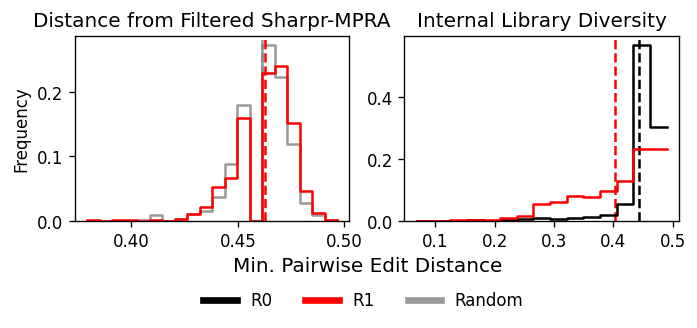

In [48]:
# plot the above 2 cells as a vertical subplot with 2 rows and 1 column
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(6.5,2))

# histogram of min pairwise edit distance
# import Line2D
from matplotlib.lines import Line2D


n_bins = 20
sns.histplot(x=r1_vs_r0_min_dist,stat='probability',bins=n_bins,color='red',fill=False,element='step',ax=ax1)
# get bins used in p
bins = np.histogram_bin_edges(r1_vs_r0_min_dist,bins=n_bins)
sns.histplot(x=rand_dist_rand_r1_vs_r0,stat='probability',bins=bins,color='gray',alpha=0.8,fill=False,element='step',zorder=0,ax=ax1)
ax1.set_ylabel('Frequency')
# ax1.set_xlabel('Min. Pairwise Edit Distance')
ax1.set_title('Distance from Filtered Sharpr-MPRA')
# plt.legend(['Designed','Random'],loc='upper left',frameon=False)

# plot horizontal line at mean of both distributions
ax1.axvline(x=np.mean(r1_vs_r0_min_dist), color='red', linestyle='--',zorder=0)
ax1.axvline(x=np.mean(rand_dist_rand_r1_vs_r0), color='gray', linestyle='--',zorder=0,alpha=0.8)

# get xticks from ax1
xticks = ax1.get_xticks()

# change all labels to 2 decimal points for ax1
ax1.set_xticklabels(['{:.2f}'.format(x) for x in xticks])


# # hide every other xtick
# for i, label in enumerate(ax1.get_xticklabels()):
#     if i % 2 == 0:
#         label.set_visible(False)

#################################################################

n_bins = 15
# get bins used in p
bins = np.histogram_bin_edges(r0_vs_r0_min_dist,bins=n_bins)
sns.histplot(x=r0_vs_r0_min_dist,stat='probability',bins=bins,color='k',fill=False,element='step',ax=ax2)
sns.histplot(x=r1_vs_r1_min_dist,stat='probability',bins=bins,color='red',fill=False,element='step',ax=ax2)
# p = sns.histplot(y=rand_vs_rand_dist,stat='probability',bins=bins,color='gray',alpha=0.5,fill=False,element='step',zorder=0)
ax2.set_ylabel('')
# ax2.set_xlabel('Min. Pairwise Edit Distance')
ax2.set_title('Internal Library Diversity')
# plt.legend(['Sharpr','Designed'],loc='center',frameon=False)

# set overall figure xlabel to 'Min. Pairwise Edit Distance'
fig.text(0.5, -0.1, 'Min. Pairwise Edit Distance', ha='center',fontsize=12)

# make a legend with a black line for Sharpr and a red line for Designed and a gray line for Random
lines = [Line2D([0], [0], color='k', lw=4),
            Line2D([0], [0], color='red', lw=4),
            Line2D([0], [0], color='gray', lw=4,alpha=0.8)]
labels = ['R0','R1','Random']
# put legend outside of plot to the right
# plt.legend(lines, labels,loc='upper left',frameon=False)
# put legend outside to right of plot
# plt.legend(lines, labels,loc='upper center',bbox_to_anchor=(1.275, 0.8),frameon=False)

# move legend below the plot
plt.legend(lines, labels,loc='upper center',bbox_to_anchor=(-0.15, -0.3),frameon=False,ncol=3)

# plot horizontal line at mean of both distributions
ax2.axvline(x=np.mean(r0_vs_r0_min_dist), color='k', linestyle='--',zorder=0)
ax2.axvline(x=np.mean(r1_vs_r1_min_dist), color='red', linestyle='--',zorder=0)
# plt.axhline(y=np.mean(rand_vs_rand_dist), color='gray', linestyle='--',zorder=0,alpha=0.5)

# increase space between subplots
plt.subplots_adjust(hspace=0.8)


# save figure
# plt.savefig(f'{supp_figure_dir}/S1/S1D_edit_distance.png',dpi=500,bbox_inches='tight')
plt.savefig(f'{revision_figure_dir}/figS1D_edit_distance.png',dpi=500,bbox_inches='tight')

C:\Users\Chris\AppData\Local\Temp\ipykernel_20900\1506529006.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['{:.2f}'.format(x) for x in xticks])


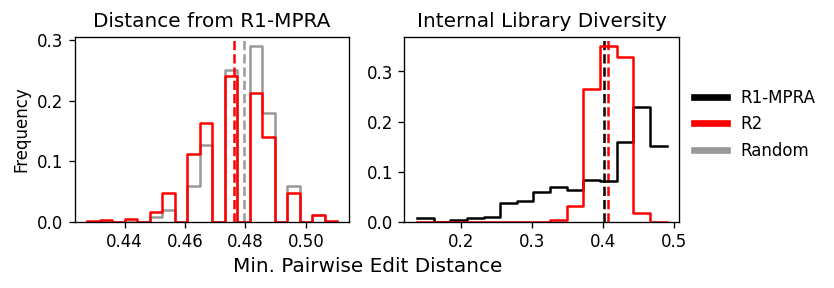

In [139]:
# R2 vs R1-MPRA

# okay, for the r2 version of this figure, I can do the same thing but replace r0 with r1, maybe I don't really care about r2 to r0 for this analysis

# plot the above 2 cells as a vertical subplot with 2 rows and 1 column
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(6.5,2))

# histogram of min pairwise edit distance
# import Line2D
from matplotlib.lines import Line2D


n_bins = 20
sns.histplot(x=r2_vs_r1_min_dist,stat='probability',bins=n_bins,color='red',fill=False,element='step',ax=ax1)
# get bins used in p
bins = np.histogram_bin_edges(r2_vs_r1_min_dist,bins=n_bins)
sns.histplot(x=rand_dist_rand_r2_vs_r1,stat='probability',bins=bins,color='gray',alpha=0.8,fill=False,element='step',zorder=0,ax=ax1)
ax1.set_ylabel('Frequency')
# ax1.set_xlabel('Min. Pairwise Edit Distance')
ax1.set_title('Distance from R1-MPRA')
# plt.legend(['Designed','Random'],loc='upper left',frameon=False)

# plot horizontal line at mean of both distributions
ax1.axvline(x=np.mean(r2_vs_r1_min_dist), color='red', linestyle='--',zorder=0)
ax1.axvline(x=np.mean(rand_dist_rand_r2_vs_r1), color='gray', linestyle='--',zorder=0,alpha=0.8)

# get xticks from ax1
xticks = ax1.get_xticks()

# change all labels to 2 decimal points for ax1
ax1.set_xticklabels(['{:.2f}'.format(x) for x in xticks])


# # hide every other xtick
# for i, label in enumerate(ax1.get_xticklabels()):
#     if i % 2 == 0:
#         label.set_visible(False)

#################################################################

n_bins = 15
# get bins used in p
bins = np.histogram_bin_edges(r1_vs_r1_min_dist,bins=n_bins)
sns.histplot(x=r1_vs_r1_min_dist,stat='probability',bins=bins,color='k',fill=False,element='step',ax=ax2)
sns.histplot(x=r2_vs_r2_min_dist,stat='probability',bins=bins,color='red',fill=False,element='step',ax=ax2)
# p = sns.histplot(y=rand_vs_rand_dist,stat='probability',bins=bins,color='gray',alpha=0.5,fill=False,element='step',zorder=0)
ax2.set_ylabel('')
# ax2.set_xlabel('Min. Pairwise Edit Distance')
ax2.set_title('Internal Library Diversity')
# plt.legend(['Sharpr','Designed'],loc='center',frameon=False)

# set overall figure xlabel to 'Min. Pairwise Edit Distance'
fig.text(0.5, -0.1, 'Min. Pairwise Edit Distance', ha='center',fontsize=12)

# make a legend with a black line for Sharpr and a red line for Designed and a gray line for Random
lines = [Line2D([0], [0], color='k', lw=4),
            Line2D([0], [0], color='red', lw=4),
            Line2D([0], [0], color='gray', lw=4,alpha=0.8)]
labels = ['R1-MPRA','R2','Random']
# put legend outside of plot to the right
# plt.legend(lines, labels,loc='upper left',frameon=False)
# put legend outside to right of plot
plt.legend(lines, labels,loc='upper center',bbox_to_anchor=(1.275, 0.8),frameon=False)

# plot horizontal line at mean of both distributions
ax2.axvline(x=np.mean(r1_vs_r1_min_dist), color='k', linestyle='--',zorder=0)
ax2.axvline(x=np.mean(r2_vs_r2_min_dist), color='red', linestyle='--',zorder=0)
# plt.axhline(y=np.mean(rand_vs_rand_dist), color='gray', linestyle='--',zorder=0,alpha=0.5)

# increase space between subplots
plt.subplots_adjust(hspace=0.8)

# save figure
# plt.savefig(f'{supp_figure_dir}/S3/S3B_edit_distance.png',dpi=500,bbox_inches='tight')
plt.savefig(f'{revision_figure_dir}/figS3B_edit_distance.png',dpi=500,bbox_inches='tight')

### R1.7 - Overestimation analysis ###

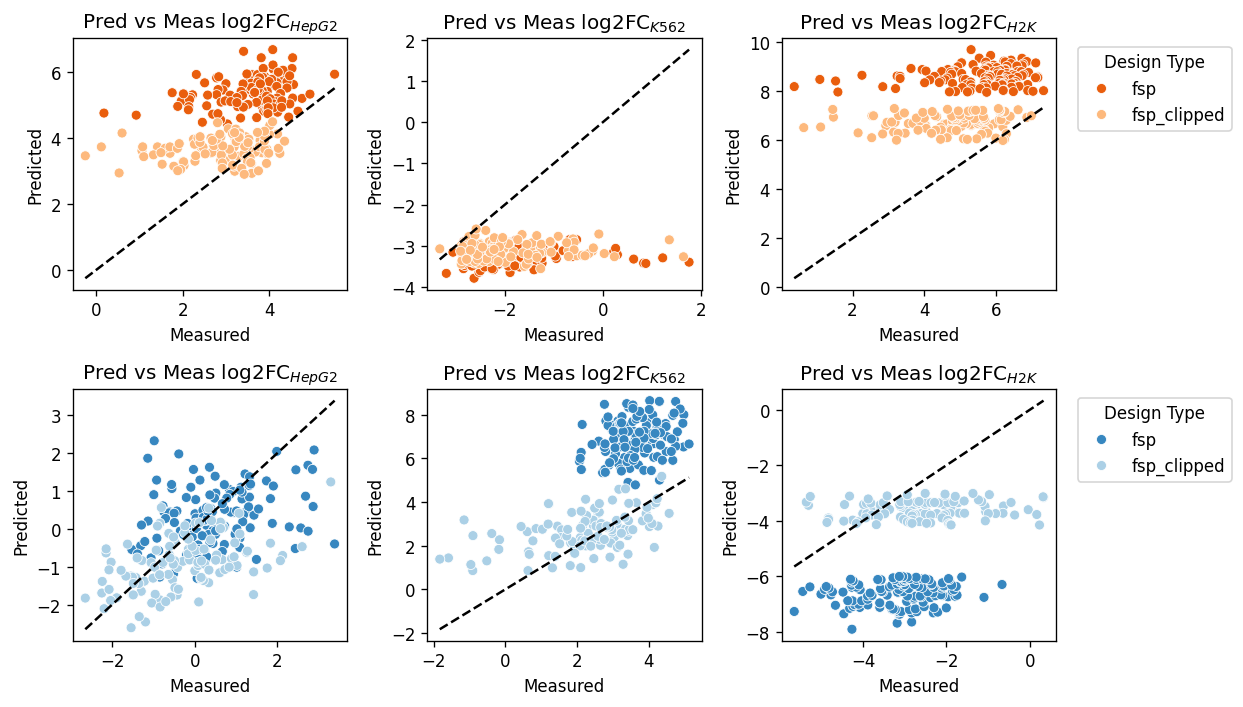

In [20]:
# subset the relevant r2 data (d3_deseq_df)
model_types = ['d1_finetuned']
design_types = ['fsp','fsp_clipped']
analysis_df = d3_seq_df[(d3_seq_df['model_type'].isin(model_types)) & (d3_seq_df['design_type'].isin(design_types))].copy()

analysis_df.head()

pred_cols = ['log2(HEPG2)_pred','log2(K562)_pred','log2(H2K)_pred']
meas_cols = [HEPG2_COL,K562_COL,H2K_COL]
col_labels = ['log2FC$_{HepG2}$','log2FC$_{K562}$','log2FC$_{H2K}$']

# batch correct all the pred_cols from d2 to d3!
m_hepg2_d23,b_hepg2_d23,m_k562_d23,b_k562_d23,m_h2k_d23,b_h2k_d23 = np.load(f'batch_correction_weights/comb_dhs/d2_to_d3_linregs_weighted_pf.npy')

analysis_df['log2(HEPG2)_pred'] = analysis_df['log2(HEPG2)_pred'] * m_hepg2_d23 + b_hepg2_d23
analysis_df['log2(K562)_pred'] = analysis_df['log2(K562)_pred'] * m_k562_d23 + b_k562_d23
analysis_df['log2(H2K)_pred'] = analysis_df['log2(H2K)_pred'] * m_h2k_d23 + b_h2k_d23


# defined hepg2_palette as the orange paired palette
hepg2_palette = sns.color_palette("Oranges", 2)[::-1]
# define k562_palette as the blue paired palette
k562_palette = sns.color_palette("Blues", 2)[::-1]
palettes = [hepg2_palette,k562_palette]

# 2 row x 3 col scatterplot of meas vs pred for each meas_col, with clipped vs unclipped designs as different hues, and first row cell_type = HEPG2, second row cell_type = K562
fig, ax = plt.subplots(2,3,figsize=(9,6))
for cell_idx,cell_type in enumerate(['HEPG2','K562']):

    cur_analysis_df = analysis_df[analysis_df['cell_type']==cell_type]

    for i,meas_col in enumerate(meas_cols):
        sns.scatterplot(data=cur_analysis_df,x=meas_col,y=pred_cols[i],hue='design_type',ax=ax[cell_idx,i],palette=palettes[cell_idx])
        ax[cell_idx,i].set_xlabel('Measured')
        ax[cell_idx,i].set_ylabel('Predicted')
        ax[cell_idx,i].set_title(f'Pred vs Meas {col_labels[i]}')
        ax[cell_idx,i].plot([cur_analysis_df[meas_col].min(),cur_analysis_df[meas_col].max()],
                [cur_analysis_df[meas_col].min(),cur_analysis_df[meas_col].max()],'k--')
plt.tight_layout()

# remove legends from individual plots and only show one legend per row to the right of the row
for i in range(3):
    ax[0,i].get_legend().remove()
    ax[1,i].get_legend().remove()
ax[0,2].legend(title='Design Type',bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1,2].legend(title='Design Type',bbox_to_anchor=(1.05, 1), loc='upper left')

# Note: realistically, I care mostly about just the H2K col. I should make a version of this where it's just 1 x 2, with H2K and K2H for HepG2-targeted and K562-targeted designs



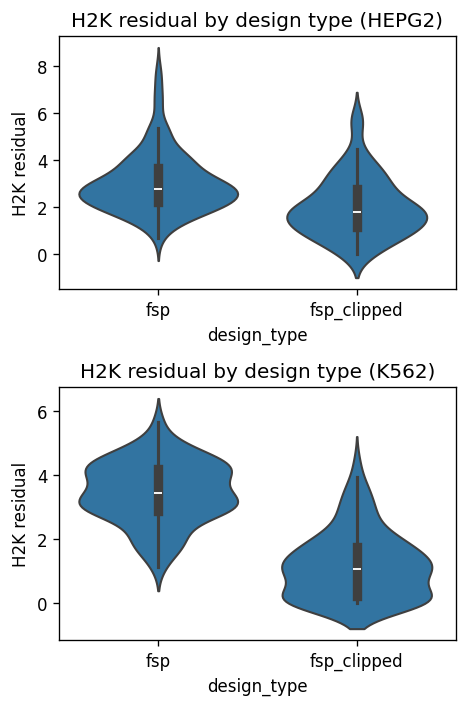

In [21]:
# violin plot of residuals for clipped vs unclipped designs, for H2K_COL, separated by cell type

# calculate residuals
# analysis_df['H2K_residual'] = np.sqrt((analysis_df[H2K_COL] - analysis_df['log2(H2K)_pred'])**2)
# analysis_df['HEPG2_residual'] = np.sqrt((analysis_df[HEPG2_COL] - analysis_df['log2(HEPG2)_pred'])**2)
# analysis_df['K562_residual'] = np.sqrt((analysis_df[K562_COL] - analysis_df['log2(K562)_pred'])**2)

# actually, if I care about overprediction, I should just take the difference and clip all negative values to 0
# so this is not really residual in classic sense, it's just overprediction
analysis_df.loc[analysis_df['cell_type']=='HEPG2','H2K_residual'] = np.clip(analysis_df['log2(H2K)_pred'] - analysis_df[H2K_COL],0,None)
analysis_df.loc[analysis_df['cell_type']=='K562','H2K_residual'] = np.clip(analysis_df[H2K_COL] - analysis_df['log2(H2K)_pred'],0,None)

# analysis_df['H2K_residual'] = np.clip(analysis_df['log2(H2K)_pred'] - analysis_df[H2K_COL],0,None)
analysis_df['HEPG2_residual'] = np.clip(analysis_df['log2(HEPG2)_pred'] - analysis_df[HEPG2_COL],0,None)
analysis_df['K562_residual'] = np.clip(analysis_df['log2(K562)_pred'] - analysis_df[K562_COL],0,None)

# violin plot of residuals for clipped vs unclipped designs, for H2K_COL, separated by cell type

# 2 row x 1 col violin plot of residuals for clipped vs unclipped designs, for H2K_COL, separated by cell type
fig, ax = plt.subplots(2,1,figsize=(4,6))
for cell_idx,cell_type in enumerate(['HEPG2','K562']):

    cur_analysis_df = analysis_df[analysis_df['cell_type']==cell_type]

    sns.violinplot(data=cur_analysis_df,x='design_type',y='H2K_residual',ax=ax[cell_idx])
    ax[cell_idx].set_ylabel('H2K residual')
    ax[cell_idx].set_title(f'H2K residual by design type ({cell_type})')
plt.tight_layout()


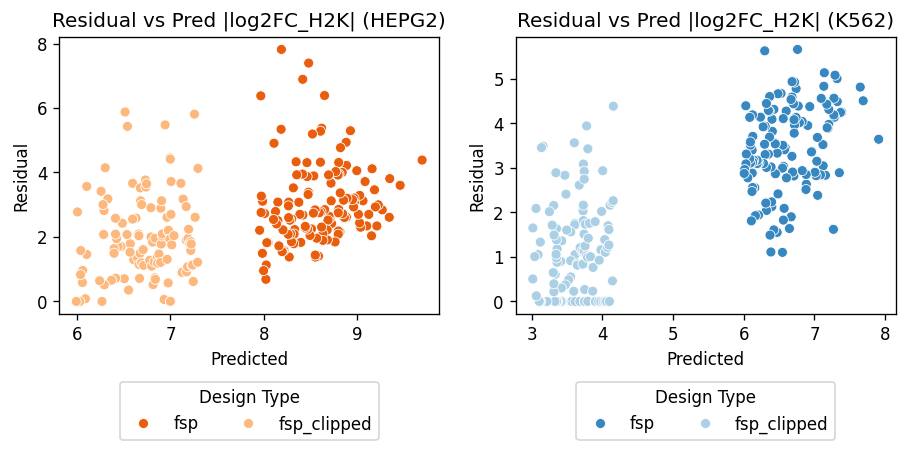

In [23]:
# plot residual vs pred for clipped vs unclipped designs, for H2K_COL, separated by cell type

# 1 x 2 col scatterplot of residual vs pred for clipped vs unclipped designs, for H2K_COL, separated by cell type
fig, ax = plt.subplots(1,2,figsize=(9,3))
for cell_idx,cell_type in enumerate(['HEPG2','K562']):

    cur_analysis_df = analysis_df[analysis_df['cell_type']==cell_type].copy()
    if cell_type == 'K562':
        cur_analysis_df['log2(H2K)_pred'] = -cur_analysis_df['log2(H2K)_pred']
    sns.scatterplot(data=cur_analysis_df,x='log2(H2K)_pred',y='H2K_residual',hue='design_type',ax=ax[cell_idx],palette=palettes[cell_idx])
    ax[cell_idx].set_xlabel('Predicted')
    ax[cell_idx].set_ylabel('Residual')
    ax[cell_idx].set_title(f'Residual vs Pred |log2FC_H2K| ({cell_type})')
    # move legend beneath plot
    ax[cell_idx].legend(title='Design Type',bbox_to_anchor=(0.5, -0.35), loc='center', ncol=2)

# plt.tight_layout()

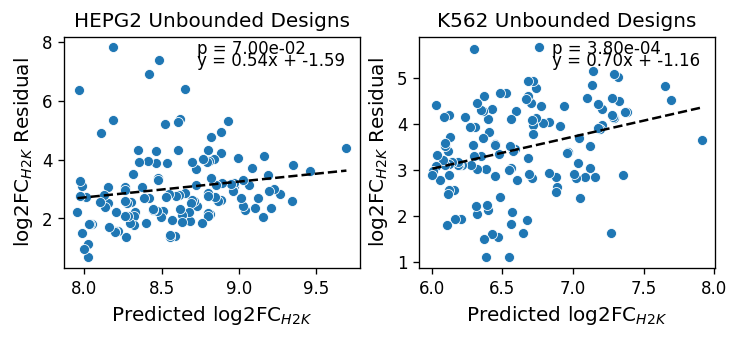

In [29]:
# plot residual vs pred for unclipped designs, for H2K_COL, separated by cell type, and get correlation

# 1 x 2 col scatterplot of residual vs pred for clipped vs unclipped designs, for H2K_COL, separated by cell type
fig, ax = plt.subplots(1,2,figsize=(7,2.5))
for cell_idx,cell_type in enumerate(['HEPG2','K562']):

    cur_analysis_df = analysis_df[(analysis_df['cell_type']==cell_type)&(analysis_df['design_type']=='fsp')].copy()
    if cell_type == 'K562':
        cur_analysis_df['log2(H2K)_pred'] = -cur_analysis_df['log2(H2K)_pred']
    sns.scatterplot(data=cur_analysis_df,x='log2(H2K)_pred',y='H2K_residual',ax=ax[cell_idx])
    ax[cell_idx].set_xlabel('Predicted log2FC$_{H2K}$',fontsize=AXIS_FSIZE)
    ax[cell_idx].set_ylabel('log2FC$_{H2K}$ Residual',fontsize=AXIS_FSIZE)
    ax[cell_idx].set_title('%s Unbounded Designs' % cell_type,fontsize=AXIS_FSIZE)
    # move legend beneath plot
    # ax[cell_idx].legend(title='Design Type',bbox_to_anchor=(0.5, -0.35), loc='center', ncol=2)

    # plot line of best fit along with p value for slope
    slope, intercept, r_value, p_value, std_err = stats.linregress(cur_analysis_df['log2(H2K)_pred'],cur_analysis_df['H2K_residual'])
    x = np.array([cur_analysis_df['log2(H2K)_pred'].min(),cur_analysis_df['log2(H2K)_pred'].max()])
    y = slope*x + intercept
    ax[cell_idx].plot(x,y,'k--')

    # add r2 and p value to plot and equation of line
    ax[cell_idx].text(0.45,0.95-0.025,f'p = {p_value:.2e}',transform=ax[cell_idx].transAxes)
    ax[cell_idx].text(0.45,0.90-0.025,f'y = {slope:.2f}x + {intercept:.2f}',transform=ax[cell_idx].transAxes)

# plt.tight_layout()

# save figure
plt.savefig(f'{revision_figure_dir}/figS4D_residual_vs_pred.png',dpi=500,bbox_inches='tight')

In [102]:
# I guess could compare median residual to median difference in log2FC for clipped vs unclipped designs? And see if log2FC - residual is greater between clipped vs unclipped designs?

# calculate median residual for clipped vs unclipped designs
# median_resid = analysis_df.groupby(['cell_type','design_type'])['H2K_residual'].median().reset_index()
# median_resid.columns = ['cell_type','design_type','median_residual']

# compare median residual for clipped vs unclipped in both Hepg2 and K562 designs using wilcoxon rank sum test
for cell_type in ['HEPG2','K562']:
    unbounded_resid = analysis_df[(analysis_df['cell_type']==cell_type) & (analysis_df['design_type']=='fsp')]['H2K_residual'].values
    clipped_resid = analysis_df[(analysis_df['cell_type']==cell_type) & (analysis_df['design_type']=='fsp_clipped')]['H2K_residual'].values
    med_unbounded = np.median(unbounded_resid)
    med_unclipped = np.median(clipped_resid)
    # print(f'{cell_type} clipped vs unclipped median residual: {clipped_resid} vs {unclipped_resid}')
    _,p = stats.ranksums(unbounded_resid,clipped_resid)
    print(f'{cell_type} unbounded vs clipped median residual: {med_unbounded:.2f} vs {med_unclipped:.2f}, p = {p:.2e}')

HEPG2 unbounded vs clipped median residual: 3.44 vs 2.30, p = 1.53e-13
K562 unbounded vs clipped median residual: 4.67 vs 1.89, p = 4.32e-34


In [21]:
# I guess could compare median residual to median difference in log2FC for clipped vs unclipped designs? And see if log2FC - residual is greater between clipped vs unclipped designs?

# calculate median residual for clipped vs unclipped designs
# median_resid = analysis_df.groupby(['cell_type','design_type'])['H2K_residual'].median().reset_index()
# median_resid.columns = ['cell_type','design_type','median_residual']

# compare median residual for clipped vs unclipped in both Hepg2 and K562 designs using wilcoxon rank sum test
for cell_type in ['HEPG2','K562']:
    unbounded_resid = analysis_df[(analysis_df['cell_type']==cell_type) & (analysis_df['design_type']=='fsp')]['H2K_residual'].values
    clipped_resid = analysis_df[(analysis_df['cell_type']==cell_type) & (analysis_df['design_type']=='fsp_clipped')]['H2K_residual'].values
    med_unbounded = np.median(unbounded_resid)
    med_unclipped = np.median(clipped_resid)
    # print(f'{cell_type} clipped vs unclipped median residual: {clipped_resid} vs {unclipped_resid}')
    _,p = stats.ranksums(unbounded_resid,clipped_resid)
    print(f'{cell_type} unbounded vs clipped median residual: {med_unbounded:.2f} vs {med_unclipped:.2f}, p = {p:.2e}')

HEPG2 unbounded vs clipped median residual: 2.75 vs 1.79, p = 1.81e-10
K562 unbounded vs clipped median residual: 3.44 vs 1.05, p = 7.23e-31


In [17]:
# I could train a simple linear regression model to predict residuals from motifs?
motif_analysis_df = d3_deseq_plus_cluster_cnts_df[(d3_deseq_plus_cluster_cnts_df['model_type'].isin(model_types)) & 
                                                  (d3_deseq_plus_cluster_cnts_df['design_type'].isin(design_types))].copy()

# calculate H2K_residual for motif_analysis_df
motif_analysis_df['H2K_residual'] = np.sqrt((motif_analysis_df[H2K_COL] - motif_analysis_df['log2(H2K)_pred'])**2)

18
MSE: 2.51, PCC: 0.33 (2.33e-02)
16
MSE: 2.51, PCC: 0.51 (2.42e-04)


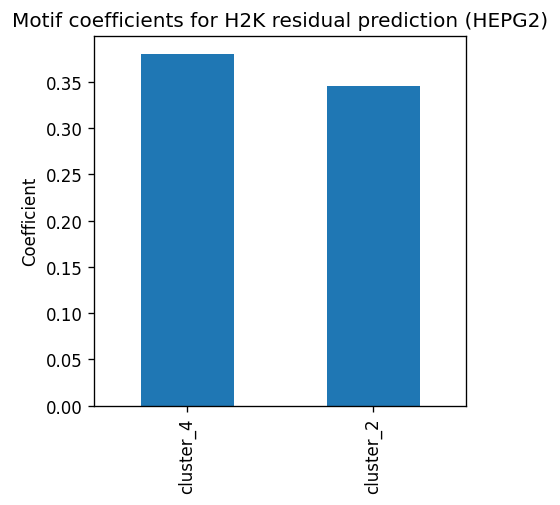

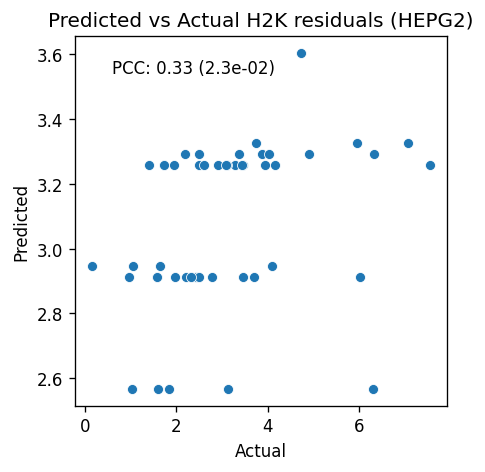

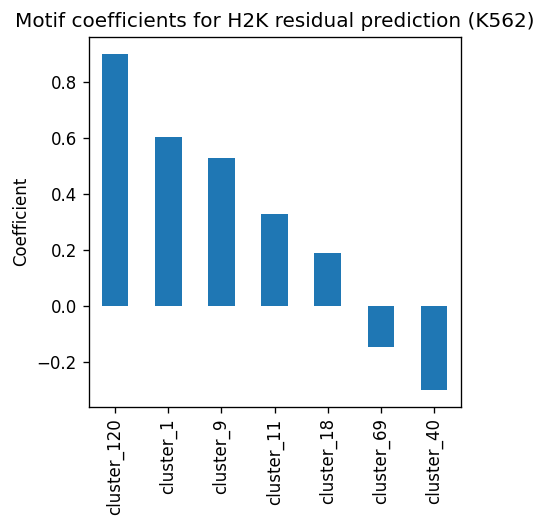

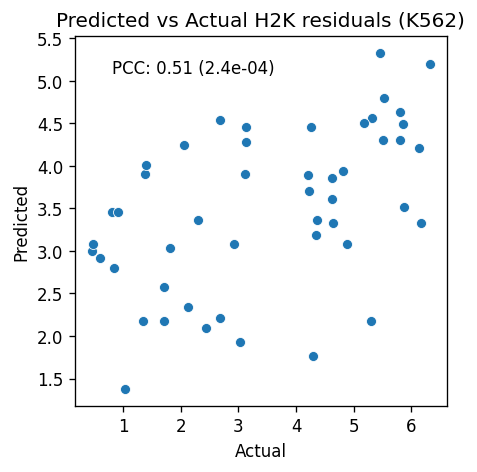

In [22]:
# okay so for each cell type I need to extract targeted sequences, get motif columns, drop all 0 cols, train elastic model, look at motif coefficients
# then I can compare motif prevalence in clipped vs unclipped designs
# this won't account for motif combinations but oh well, or maybe I can try to do something else for combos, later on

# cell_type = 'HEPG2'
for cell_type in ['HEPG2','K562']:
    cur_analysis_df = motif_analysis_df[motif_analysis_df['cell_type']==cell_type].copy()
    # get columns with 'cluster_' in them
    motif_cols = [col for col in cur_analysis_df.columns if 'cluster_' in col]
    # drop all motif_cols with all 0s from cur_analysis_df
    cur_analysis_df = cur_analysis_df.drop(columns=[col for col in motif_cols if cur_analysis_df[col].sum()==0])
    motif_cols = [col for col in cur_analysis_df.columns if 'cluster_' in col]
    print(len(motif_cols))

    # train elastic net model to predict residuals from motifs
    from sklearn.linear_model import ElasticNetCV
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error

    # split into train and test
    X = cur_analysis_df[motif_cols].values
    y = cur_analysis_df['H2K_residual'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

    # # min max normalize X
    # X_max = X_train.max(axis=0)
    # X_min = X_train.min(axis=0)

    # X_train = (X_train - X_min) / (X_train.max(axis=0) - X_min)
    # X_test = (X_test - X_min) / (X_train.max(axis=0) - X_min)
    

    # train elastic net model
    model = ElasticNetCV(cv=5, random_state=0)
    model.fit(X_train,y_train)

    # predict on test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)
    pcc,p = pearsonr(y_test,y_pred)
    print(f'MSE: {mse:.2f}, PCC: {pcc:.2f} ({p:.2e})')

    # look at motif coefficients
    motif_coefs = model.coef_
    motif_coefs = pd.Series(motif_coefs,index=motif_cols)
    motif_coefs = motif_coefs[motif_coefs != 0]
    motif_coefs = motif_coefs.sort_values(ascending=False)

    # plot motif coefficients
    plt.figure(figsize=(4,4))
    motif_coefs.plot(kind='bar')
    plt.ylabel('Coefficient')
    plt.title(f'Motif coefficients for H2K residual prediction ({cell_type})')

    # also plot scatter of predicted vs actual residuals
    plt.figure(figsize=(4,4))
    sns.scatterplot(x=y_test,y=y_pred)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Predicted vs Actual H2K residuals ({cell_type})')
    # add text with PCC and p-value
    plt.text(0.1,0.9,f'PCC: {pcc:.2f} ({p:.1e})',transform=plt.gca().transAxes)


### R1.8 - prediction measurement correlation on R1 and R2 designs ###

In [293]:
"""
- I want to calculate the prediction-measurement correlation for categories in 1F: R1-MPRA, R2
    - I can't do this for R1-DHS since we don't have quantitative predictions.
        - I could calculate a classification accuracy but that is not really comparable to the other libraries.
    - I also can't do this for R0, since those were not designed by model
"""

# first, subset the R1-MPRA and R2 sequences

d3_model_types = ['d1_finetuned',]
d3_design_types = ['fsp','fsp_clipped','fsp_tgt'] # can see an argument for excluding target seqs but meh
d3_analysis_df = d3_seq_df[(d3_seq_df['model_type'].isin(d3_model_types)) & (d3_seq_df['design_type'].isin(d3_design_types))].copy()

d2_design_types = ['DENs','sim_anneal','seqprop']
d2_model_types = ['boot','single','ensemble']
d2_analysis_df = d2_deseq_plus_cluster_cnts_df[(d2_deseq_plus_cluster_cnts_df['model_type'].isin(d2_model_types)) & (d2_deseq_plus_cluster_cnts_df['design_type'].isin(d2_design_types))].copy()

# load the M0 ensemble model, then make predictions on the sequences in d2_analysis_df
# note this isn't totally comparable, since M0 ensemble not used to generate the R1-MPRA
# but it's a more competitive comparison for R2...and the correlatino seems to be quite bad for R1-MPRA if I used the generative model's predictions

# D2_M0_H2K_PRED_COL = 'M0_pred_h2k_score'

D2_M0_H2K_PRED_COL = 'pred_h2k_score'

# # load the M0 ensemble model
# cf_model_dir = '../../aws/for_aws/sequencing_analysis/retraining/retrained_models/cf10/test_fold_0/d1'
# model_basename = f'd1_wide_cf_t0_v'
# model_name = f'{cf_model_dir}/{model_basename}.h5'

# # load unfinetuned model and get predictions to append to the results_dfs in the next cell
# # import load_model function
# from tensorflow.keras.models import load_model
# model_inds = np.arange(1,10)
# model = load_ensemble_model(cf_model_dir,model_basename,model_inds)
# # predict on test set

# x_test = d2_analysis_df['enhancer'].apply(seq_to_one_hot).values
# x_test = np.stack(x_test)

# # pad x_test to 200bp
# lpad = (200-145)//2
# rpad = 200 - 145 - lpad
# x_test = np.pad(x_test,((0,0),(lpad, rpad),(0,0)))

# y_test_hat = model.predict(x_test)

# # append predictions to d2_analysis_df, with col name M0_pred_h2k_score
# d2_analysis_df[D2_M0_H2K_PRED_COL] = y_test_hat[:,0] - y_test_hat[:,1]

D3_H2K_PRED_COL = 'log2(H2K)_pred'
D2_H2K_PRED_COL = 'pred_h2k_score' # well I don't know where this prediction is from, so I have to regenerate with the M0 models for this to actually be comparable

In [300]:
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model, load_model

from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, GlobalMaxPooling1D, concatenate, ReLU, Average
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from tensorflow.keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
import tensorflow.keras.losses


def load_ensemble_model_retro(model_dir,model_basename,model_inds):

    models = [None] * len(model_inds)
    for i in range(len(model_inds)):
        models[i] = load_model(f'{model_dir}/{model_basename}{model_inds[i]}.h5')
        models[i]._name = f"model_idx{i}"

    ensemble_input = Input(shape=models[0].input_shape[1:])
    ensemble_outputs = [model(ensemble_input) for model in models]
    ensemble_avg = Average()(ensemble_outputs)
    ensemble_model = Model(inputs=ensemble_input, outputs=ensemble_avg)

    return ensemble_model

In [ ]:
### Recalculate predictions from original models for R1-MPRA ###

# okay it looks like it was already correct #

base_model_dir = '../../../aws/for_aws/predictor_models'
single_model_dir = f'{base_model_dir}/wide_predictors'
boot_model_dir = f'{base_model_dir}/boot_predictors'

# for all wide models in d2_analysis_df, obtain predictions on corresponding designs



# for model_name in d2_analysis_df[d2_analysis_df['model_type']=='single']['model'].unique():
#     # load model
#     K.clear_session()
#     model = load_model(f'{single_model_dir}/{model_name}.h5')


#     x = np.array([seq_to_one_hot(seq) for seq in d2_analysis_df.loc[d2_analysis_df['model']==model_name,'enhancer'].values])

#     y_pred = model.predict(x)
#     y_pred_h2k = y_pred[:,0] - y_pred[:,1]

#     d2_analysis_df.loc[d2_analysis_df['model']==model_name,D2_M0_H2K_PRED_COL] = y_pred_h2k

# # now do bootstrapped models
# for model_name in d2_analysis_df[d2_analysis_df['model_type']=='boot']['model'].unique():
#     # load model
#     K.clear_session()
#     model = load_model(f'{boot_model_dir}/{model_name}.h5')

#     x = np.array([seq_to_one_hot(seq) for seq in d2_analysis_df.loc[d2_analysis_df['model']==model_name,'enhancer'].values])

#     y_pred = model.predict(x)
#     y_pred_h2k = y_pred[:,0] - y_pred[:,1]

#     d2_analysis_df.loc[d2_analysis_df['model']==model_name,D2_M0_H2K_PRED_COL] = y_pred_h2k

# finally, do the ensemble models
for model_name in d2_analysis_df[d2_analysis_df['model_type']=='ensemble']['model'].unique():

    # extract model inds
    model_inds = model_name.split('_')[-1].split('-')
    model_inds = np.arange(int(model_inds[0]),int(model_inds[1]))

    # load model
    K.clear_session()
    model = load_ensemble_model_retro(boot_model_dir,'boot_',model_inds)

    x = np.array([seq_to_one_hot(seq) for seq in d2_analysis_df.loc[d2_analysis_df['model']==model_name,'enhancer'].values])

    y_pred = model.predict(x)
    y_pred_h2k = y_pred[:,0] - y_pred[:,1]

    d2_analysis_df.loc[d2_analysis_df['model']==model_name,D2_M0_H2K_PRED_COL] = y_pred_h2k

1/1 [==============================] - 1s 813ms/step


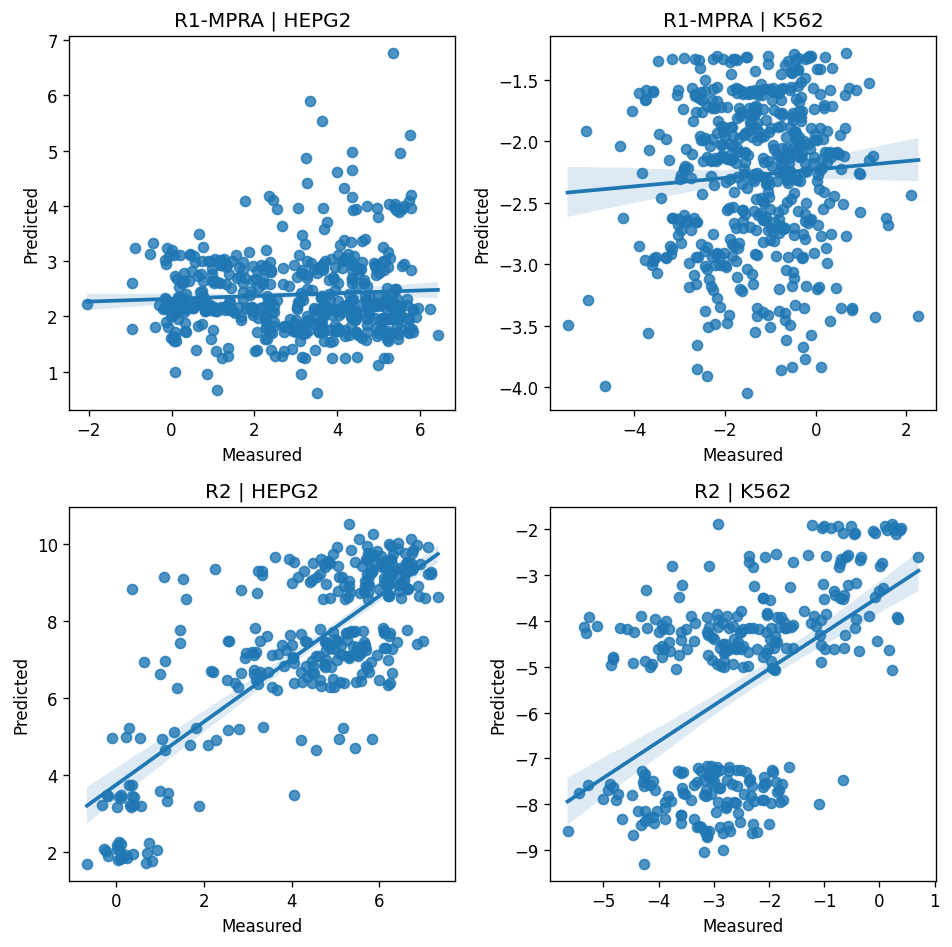

In [302]:
# calculate correlation between H2K_COL and H2K_PRED_COL for R1-MPRA and R2 sequences, separated by cell type;
# then plot as scatterplots with linear regression line, in a 2x2 grid

# create 2x2 subplot grid, first row = R1-MPRA, second row = R2, first col = HEPG2, second col = K562
fig, ax = plt.subplots(2,2,figsize=(8,8))

for cell_idx,cell_type in enumerate(['HEPG2','K562']):

    for design_idx, round, df in zip([0,1],['R1-MPRA','R2'],[d2_analysis_df,d3_analysis_df]):
        cur_analysis_df = df[(df['cell_type']==cell_type)].copy()

        if round == 'R1-MPRA':
            pred_col = D2_M0_H2K_PRED_COL
        else:
            pred_col = D3_H2K_PRED_COL

        sns.regplot(data=cur_analysis_df,x=H2K_COL,y=pred_col,ax=ax[design_idx,cell_idx])
        ax[design_idx,cell_idx].set_xlabel('Measured')
        ax[design_idx,cell_idx].set_ylabel('Predicted')
        ax[design_idx,cell_idx].set_title(f'{round} | {cell_type}')

plt.tight_layout()

In [303]:
# okay, create results_df and calculate the correlation between H2K_COL and H2K_PRED_COL for R1-MPRA and R2 sequences, separated by cell type

corr_func = spearmanr

results_df = pd.DataFrame()

for cell_type in ['HEPG2','K562']:
    for design_round, df in zip(['R1-MPRA','R2'],[d2_analysis_df,d3_analysis_df]):
        cur_analysis_df = df[(df['cell_type']==cell_type)].copy()

        if design_round == 'R1-MPRA':
            pred_col = D2_M0_H2K_PRED_COL
        else:
            pred_col = D3_H2K_PRED_COL

        corr = corr_func(cur_analysis_df[H2K_COL],cur_analysis_df[pred_col])[0]
        results_df = pd.concat([results_df,pd.DataFrame({'cell_type':[cell_type],'design_round':[design_round],'corr':[corr]})])

results_df

cell_type design_round      corr
0     HEPG2      R1-MPRA -0.021425
0     HEPG2           R2  0.666799
0      K562      R1-MPRA  0.061604
0      K562           R2  0.506227

In [304]:
n_r1 = d2_analysis_df.shape[0]
n_r2 = d3_analysis_df.shape[0]
corr_func = spearmanr

# randomly bootstrap resample with replacement 1000 times, calculate correlation for each resample, then calculate 95% CI for each individually and also for the difference

n_bootstraps = 10000
n_tests = 4 # (HepG2 and K562) x (R1-MPRA and R2)
bootstrapped_corrs = np.zeros((n_bootstraps,n_tests))

for i in range(n_bootstraps):
    # resample with replacement
    r1_resample = d2_analysis_df.sample(n=n_r1,replace=True)
    r2_resample = d3_analysis_df.sample(n=n_r2,replace=True)

    for cell_idx,cell_type in enumerate(['HEPG2','K562']):
        for design_idx, round, df in zip([0,1],['R1-MPRA','R2'],[r1_resample,r2_resample]):
            cur_analysis_df = df[(df['cell_type']==cell_type)].copy()

            if round == 'R1-MPRA':
                pred_col = D2_M0_H2K_PRED_COL
            else:
                pred_col = D3_H2K_PRED_COL

            corr = corr_func(cur_analysis_df[H2K_COL],cur_analysis_df[pred_col])[0]
            # HepG2 R1-MPRA, HepG2 R2, K562 R1-MPRA, K562 R2
            bootstrapped_corrs[i,cell_idx*2+design_idx] = corr

# calculate 95% CI for each test
ci_low = np.percentile(bootstrapped_corrs,2.5,axis=0)
ci_high = np.percentile(bootstrapped_corrs,97.5,axis=0)

# print results
# HepG2 R1-MPRA
print(f'HepG2 R1-MPRA: {ci_low[0]:.2f} - {ci_high[0]:.2f}')
# HepG2 R2
print(f'HepG2 R2: {ci_low[1]:.2f} - {ci_high[1]:.2f}')
# K562 R1-MPRA
print(f'K562 R1-MPRA: {ci_low[2]:.2f} - {ci_high[2]:.2f}')
# K562 R2
print(f'K562 R2: {ci_low[3]:.2f} - {ci_high[3]:.2f}')


# calculate 95% CI for the difference between R1-MPRA and R2
# HepG2 correlation difference
diff = bootstrapped_corrs[:,1] - bootstrapped_corrs[:,0]
ci_diff_low = np.percentile(diff,2.5)
ci_diff_high = np.percentile(diff,97.5)

# HepG2 
print(f'HepG2 R2 vs R1: {ci_diff_low:.2f} - {ci_diff_high:.2f}')


# K562 correlation difference
diff = bootstrapped_corrs[:,3] - bootstrapped_corrs[:,2]
ci_diff_low = np.percentile(diff,2.5)
ci_diff_high = np.percentile(diff,97.5)

# K562
print(f'K562 R2 vs R1 {ci_diff_low:.2f} - {ci_diff_high:.2f}')

HepG2 R1-MPRA: -0.10 - 0.06
HepG2 R2: 0.59 - 0.73
K562 R1-MPRA: -0.03 - 0.15
K562 R2: 0.42 - 0.59
HepG2 R2 vs R1: 0.57 - 0.80
K562 R2 vs R1 0.32 - 0.57


### R1.9 - SHAP on K562 randomized / also the original sequences ###

In [ ]:
"""
I want to use the d1_finetuned models, which were used for design here (I for sure have these since Gun asked)

well actually, I might want to use the d2 finetuned models, which may have learned more relevant grammar from the perturbation sequences
and then can try assessing the bps closet to motifs

I want the SHAP values on the original sequences first of all

Then I can maybe try to generate them for the randomized sequences

I can also look at the predictions on the randomized sequences, which I did at some point
"""

In [23]:
def get_nonmotif_shap_by_motif_dist(seq_idx, seq_df, hepg2_shap_vals, k562_shap_vals,motif_df,pad_len=200,use_idx_as_motif_name=False,include_motif_shap=False):

    # rename enhancer column to sequence
    seq_df = seq_df.rename(columns={'enhancer':'sequence','seq':'sequence'})

    seq_name = seq_df.loc[seq_idx,'sequence_name']
    cell_type = seq_df.loc[seq_idx,'cell_type']
    hepg2_shap = hepg2_shap_vals[seq_idx]
    k562_shap = k562_shap_vals[seq_idx]

    seq = seq_df.loc[seq_idx,'sequence']
    seq_len = len(seq)
    onehot = seq_to_one_hot(seq)

# extract shap values corresponding to real nucleotides for this sequence (could try to confirm low importance of flanking regions)
    seq_start = 0
    if seq_len < pad_len:
        seq_start = (pad_len-seq_len)//2

    dinuc_shuff_explanation = np.sum(hepg2_shap,axis=-1)[seq_start:seq_start+seq_len,None]*onehot - \
        np.sum(k562_shap,axis=-1)[seq_start:seq_start+seq_len,None]*onehot

    if cell_type == 'K562':
        dinuc_shuff_explanation *= -1

    if use_idx_as_motif_name:
        seq_motif_df = motif_df.loc[motif_df['sequence_name']==seq_idx]
    else:
        seq_motif_df = motif_df.loc[motif_df['sequence_name']==seq_name]

    motif_starts = seq_motif_df['start'].values - 1 # convert to 0-based
    motif_stops = seq_motif_df['stop'].values
    motif_bounds = np.concatenate((motif_starts,motif_stops))

    # for each pos of sequence, calculate the distance from the nearest motif
    pos_vec = np.arange(seq_len)
    # tile pos_vec to be the same length as the number of motifs
    pos_vec = np.tile(pos_vec,(len(motif_bounds),1)).T

    cur_motif_dist = np.abs(pos_vec-motif_bounds)
    min_dist = np.min(cur_motif_dist,axis=1)

    # extract the nonmotif shap values from dinuc_shuff_explanation - this seems really hacky but it works so let's just go with it
    nonmotif_inds = np.arange(seq_len)
    # remove all indices that are within the bounds of any motif
    for i in range(len(motif_starts)):
        nonmotif_inds = nonmotif_inds[(nonmotif_inds < motif_starts[i]) | (nonmotif_inds > motif_stops[i])]

    print(dinuc_shuff_explanation.shape)

    projected_shap = (dinuc_shuff_explanation*onehot).sum(axis=-1)
    print(projected_shap.sum())

    # motif_seq_one_hot = seq_to_one_hot(seq[start-1:stop])

    nonmotif_shap = projected_shap[nonmotif_inds]
    min_dist = min_dist[nonmotif_inds]

    if include_motif_shap:
        motif_inds = np.concatenate([np.arange(start,stop) for start,stop in zip(motif_starts,motif_stops)])
        motif_shap = projected_shap[motif_inds]

        return nonmotif_shap, min_dist, motif_shap
    
    else:

        return nonmotif_shap, min_dist


In [24]:
# 0) load shap values from D2 finetuned models instead
# 1) code to extract distance from each bp to nearest motif
# 2) plot distance to motif vs SHAP value
# 3) plot distance to motif vs SHAP value per motif

In [25]:
# First, I have to load the SHAP values

# shap_dir = '../../aws/for_aws/sequencing_analysis/interpretation/shap_analysis/extracted_shap_values_ft/d1_finetuned'

# hepg2_shap_vals = np.load(f'{shap_dir}/hepg2_raw_shap_explanations_d1_wide_ft_cf_t0_v_ensemble.npy')
# k562_shap_vals = np.load(f'{shap_dir}/k562_raw_shap_explanations_d1_wide_ft_cf_t0_v_ensemble.npy')


shap_dir = 'shap_values_for_revision/M2/tot_d2'
hepg2_shap_vals = np.load(f'{shap_dir}/hepg2_raw_shap_explanations_M2_R1-MPRA_tot.npy')
k562_shap_vals = np.load(f'{shap_dir}/k562_raw_shap_explanations_M2_R1-MPRA_tot.npy')


2.231327041235345
4.032547538798499
2.5194180174659775
3.146606196313696
3.2290447042904997


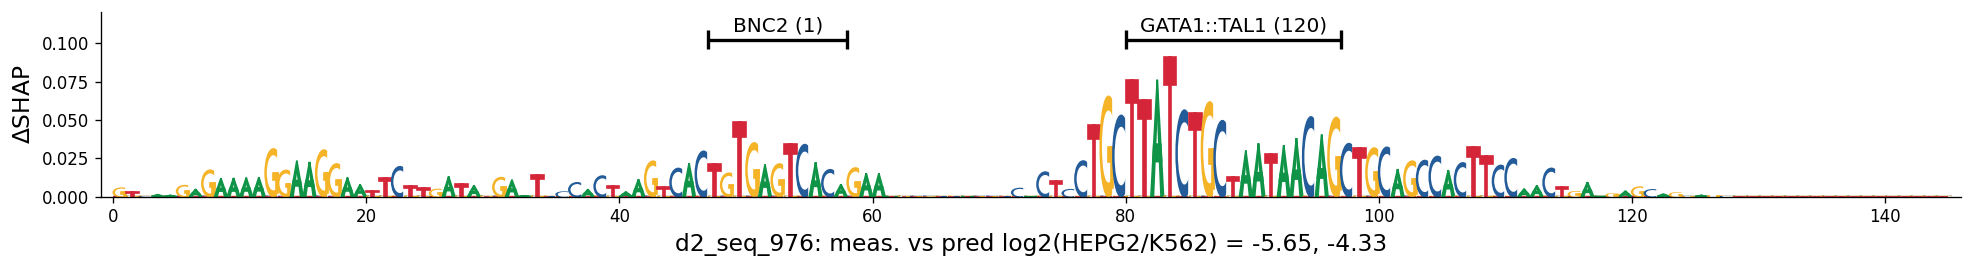

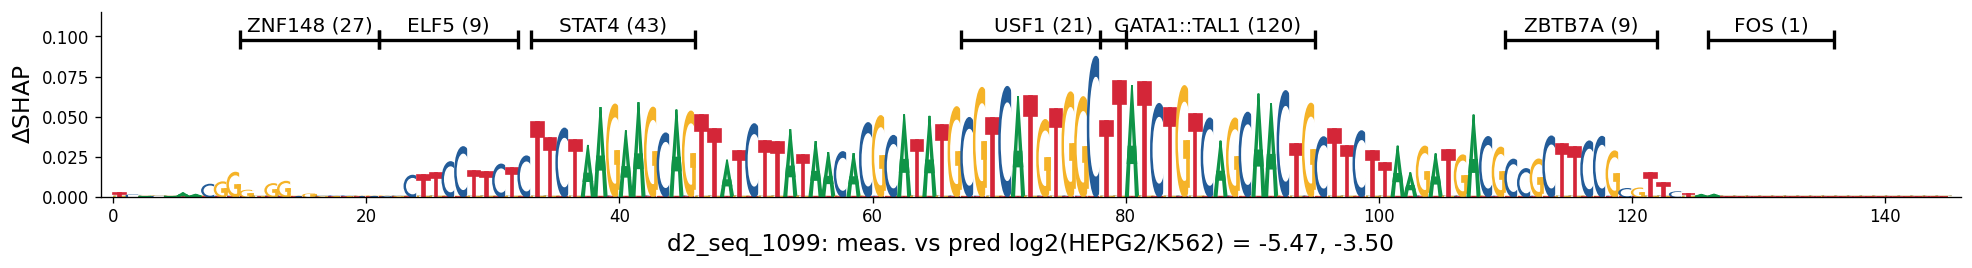

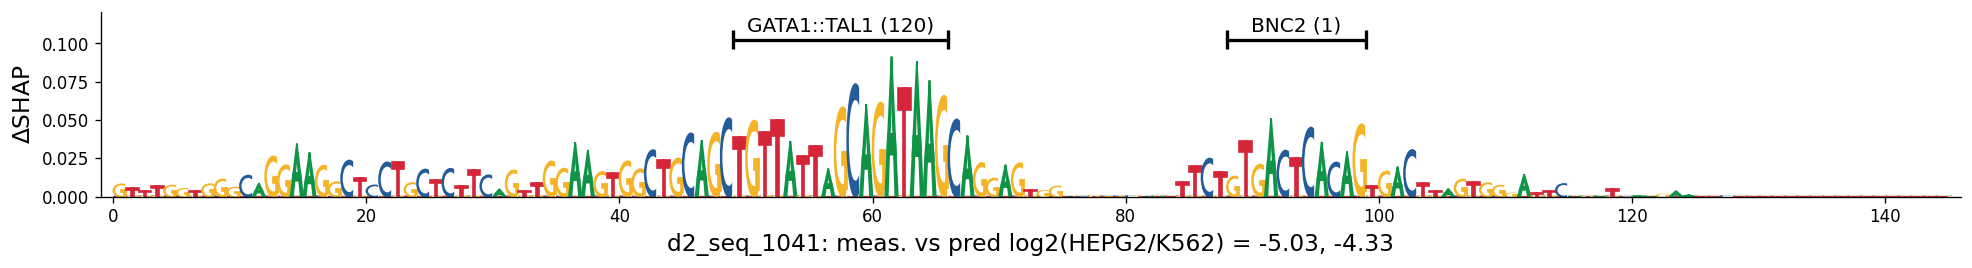

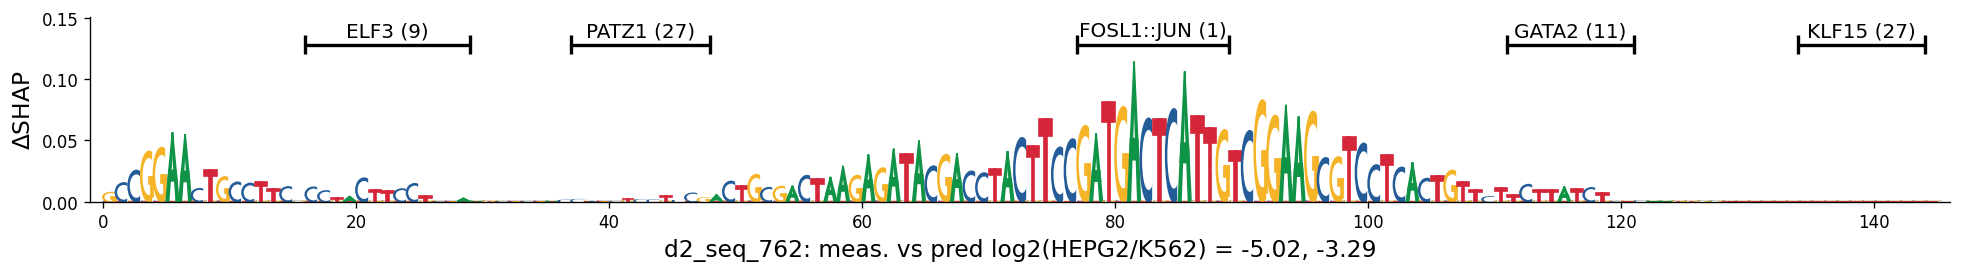

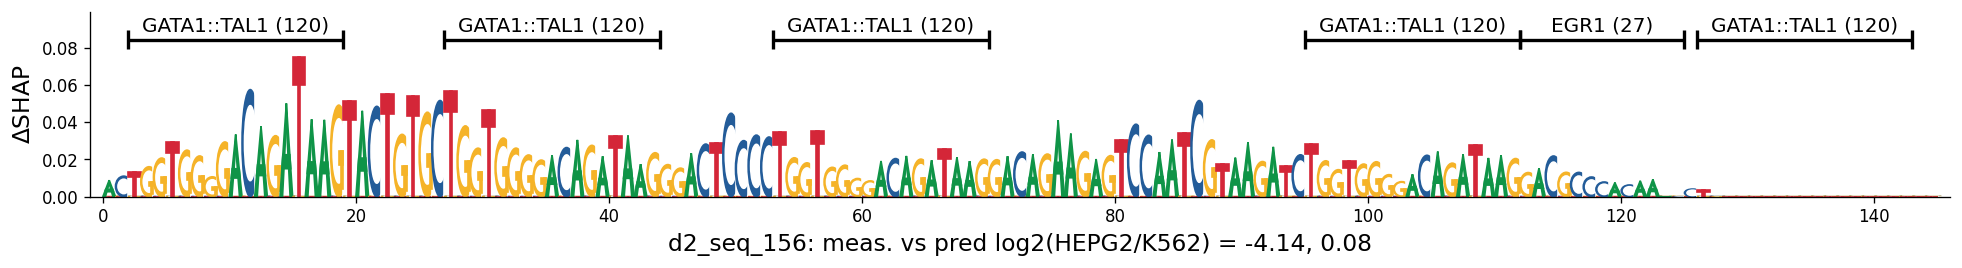

In [26]:
# what are the k562 sequences I want shap values for: 976, 1099, 1041, 762, 156

k562_seqs_to_plot = [976, 1099, 1041, 762, 156] # let's assume these indices apply and double check once I get to sequence level rep
k562_nonmotif_shap_percentages = []

for seq_idx in k562_seqs_to_plot:
    nonmotif_shap_percentage = plot_seq_shap_with_motifs(seq_idx, d2_deseq_df, d2_final_df,use_idx_as_motif_name=True,pred_col='pred_h2k_score')
    k562_nonmotif_shap_percentages.append(nonmotif_shap_percentage)

In [87]:
np.mean(k562_nonmotif_shap_percentages)

0.47455687672538316

5.516787723980669
5.269076058730061
3.669373265690492
4.439509143487157
4.112992640480006


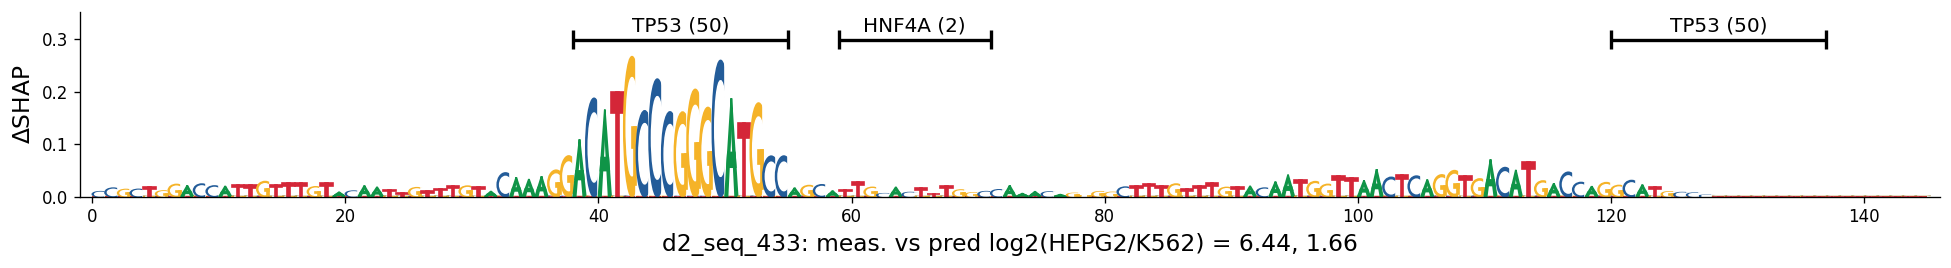

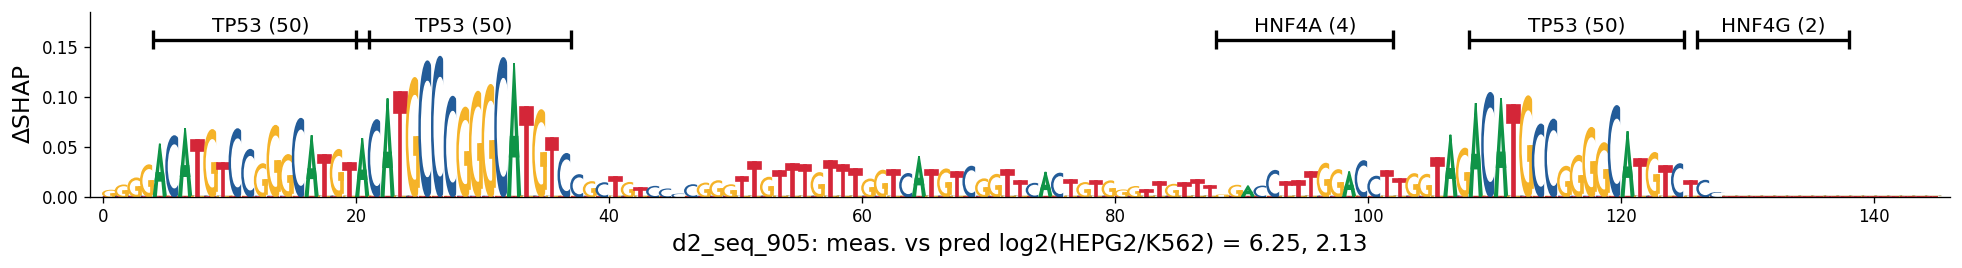

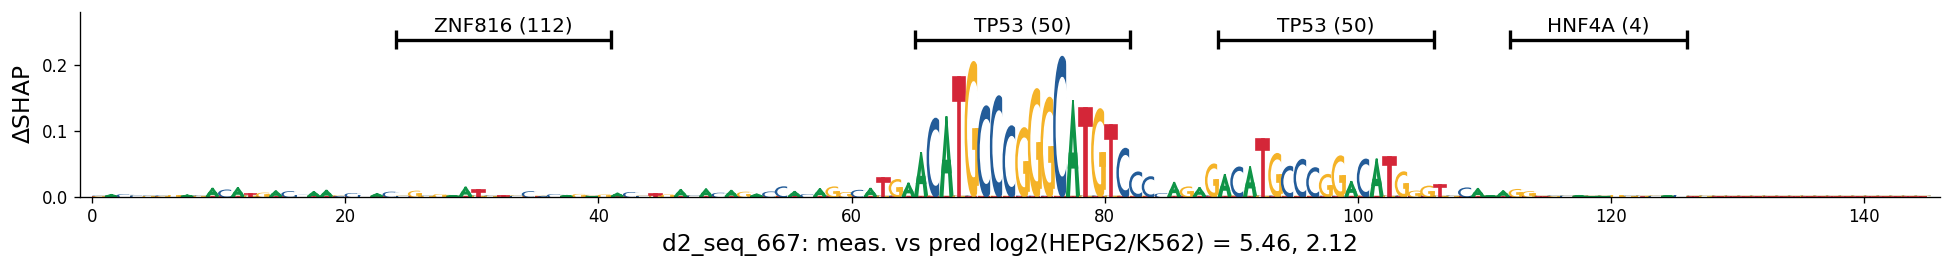

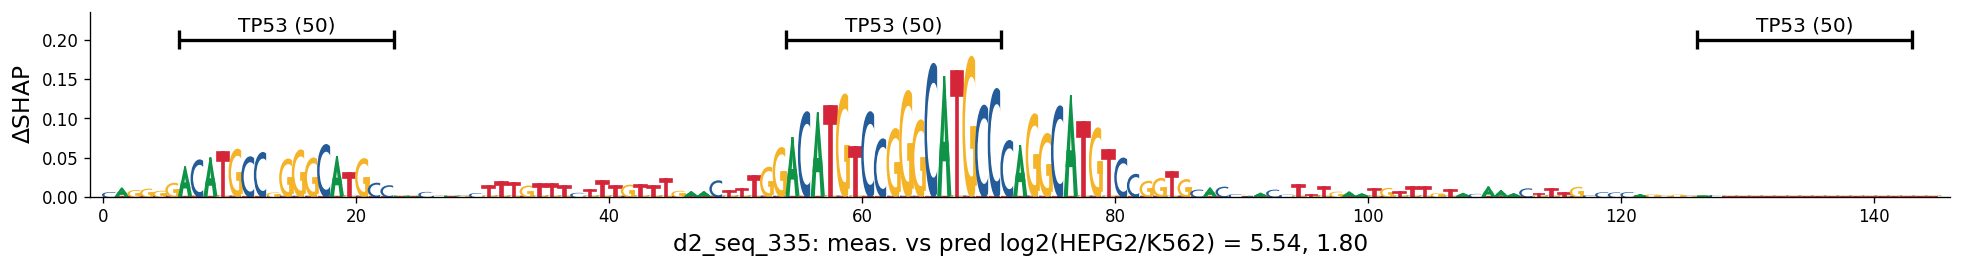

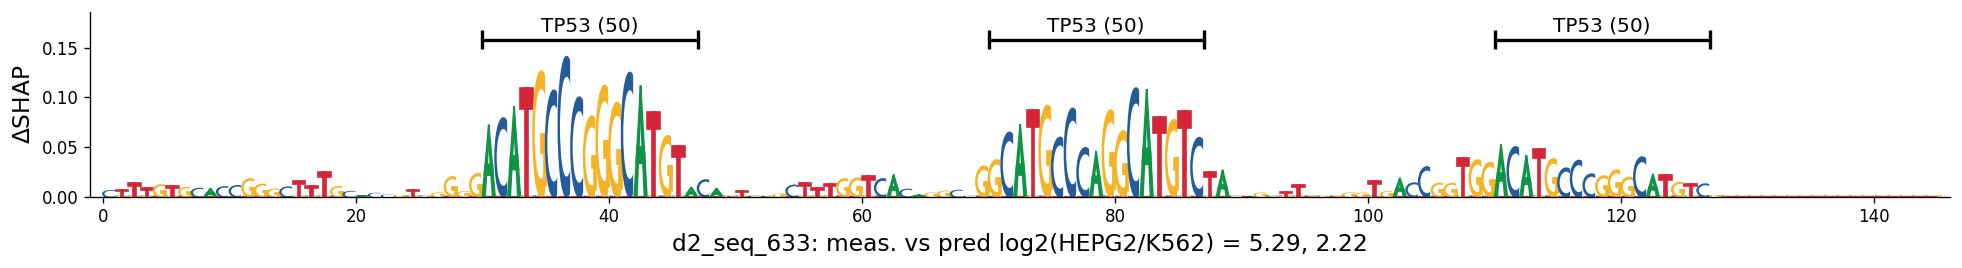

In [27]:
hepg2_seqs_to_plot = [433,905,667,335,633] # let's assume these indices apply and double check once I get to sequence level rep
hepg2_nonmotif_shap_percentages = []

for seq_idx in hepg2_seqs_to_plot:
    nonmotif_shap_percentage = plot_seq_shap_with_motifs(seq_idx, d2_deseq_df, d2_final_df,use_idx_as_motif_name=True,pred_col='pred_h2k_score')
    hepg2_nonmotif_shap_percentages.append(nonmotif_shap_percentage)

In [92]:
np.mean(hepg2_nonmotif_shap_percentages)

0.27196241272916344

p=0.03
K562: 0.47 +- 0.12
HepG2: 0.27 +- 0.11


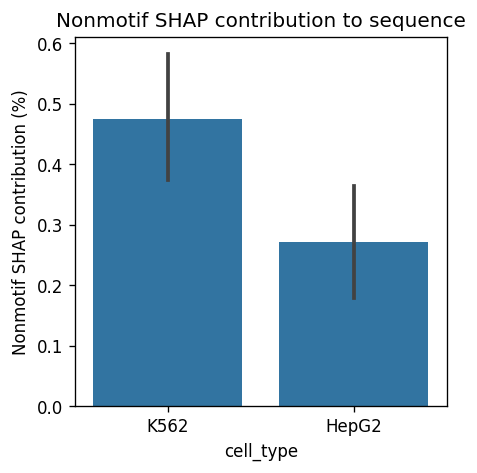

In [28]:
# barplot of k562 vs hepg2 nonmotif shap percentages, with standard error bars
plt.figure(figsize=(4,4))
y_mean = np.array([np.mean(k562_nonmotif_shap_percentages),np.mean(hepg2_nonmotif_shap_percentages)])
cell_type = ['K562']*5 + ['HepG2']*5

df2plot = np.array([cell_type,k562_nonmotif_shap_percentages+hepg2_nonmotif_shap_percentages]).T
df2plot = pd.DataFrame(data=df2plot,columns=['cell_type','nonmotif_shap_percentage'])
# set datatype of nonmotif_shap_percentage to float
df2plot['nonmotif_shap_percentage'] = df2plot['nonmotif_shap_percentage'].astype('float')
sns.barplot(x='cell_type',y='nonmotif_shap_percentage',data=df2plot)
plt.ylabel('Nonmotif SHAP contribution (%)')
plt.title('Nonmotif SHAP contribution to sequence')


# perform t-test to compare K562 vs HepG2 nonmotif shap percentages - it is significant using the finetuned models!!
_,p = stats.ttest_ind(k562_nonmotif_shap_percentages,hepg2_nonmotif_shap_percentages)
print(f'p={p:.2f}')

# print mean +- std for each
print(f'K562: {np.mean(k562_nonmotif_shap_percentages):.2f} +- {np.std(k562_nonmotif_shap_percentages):.2f}')
print(f'HepG2: {np.mean(hepg2_nonmotif_shap_percentages):.2f} +- {np.std(hepg2_nonmotif_shap_percentages):.2f}')

In [29]:
k562_seqs_to_plot = [976, 1099, 1041, 762, 156]
hepg2_seqs_to_plot = [433,905,667,335,633]

seq_idx = 976

# shap_vec,dist_vec = get_nonmotif_shap_by_motif_dist(seq_idx, d2_deseq_df, hepg2_shap_vals, k562_shap_vals,d2_final_df,use_idx_as_motif_name=True)
shap_vec,dist_vec, motif_shap = get_nonmotif_shap_by_motif_dist(seq_idx, d2_deseq_df, hepg2_shap_vals, k562_shap_vals,
                                                                d2_final_df,use_idx_as_motif_name=True,include_motif_shap=True)

(145, 4)
2.231327041235345


In [27]:
motif_shap.mean()

0.04034780748326254

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:3399: UserWarning: 22.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:3399: UserWarning: 18.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:3399: UserWarning: 22.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


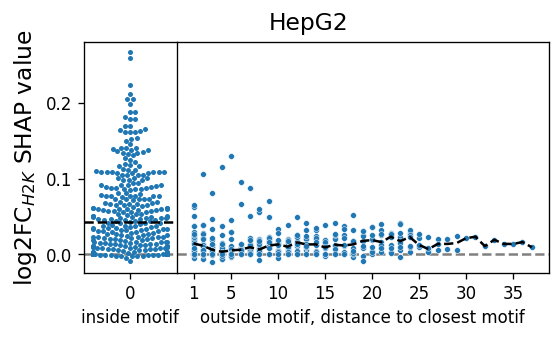

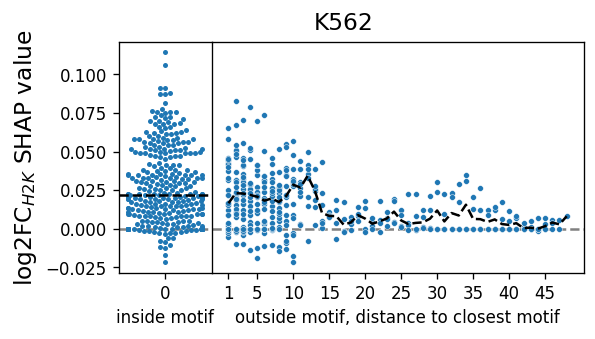

In [37]:
# 1 x 4 subplots where the first is a swarmplot of motif shap values, 2nd = scatterplot of distance to motif vs shap value using same y-axis, 3rd = swarmplot of motif shap values, 4th = scatterplot of distance to motif vs shap value using same y-axis

hepg2_shap_vecs = []
hepg2_dist_vecs = []
hepg2_motif_shap_vecs = []
k562_shap_vecs = []
k562_dist_vecs = []
k562_motif_shap_vecs = []

for seq_idx in hepg2_seqs_to_plot:
    shap_vec,dist_vec,motif_shap = get_nonmotif_shap_by_motif_dist(seq_idx, d2_deseq_df, hepg2_shap_vals, k562_shap_vals,
                                                                   d2_final_df,use_idx_as_motif_name=True,include_motif_shap=True)
    hepg2_shap_vecs.append(shap_vec)
    hepg2_dist_vecs.append(dist_vec)
    hepg2_motif_shap_vecs.append(motif_shap)

for seq_idx in k562_seqs_to_plot:
    shap_vec,dist_vec,motif_shap = get_nonmotif_shap_by_motif_dist(seq_idx, d2_deseq_df, hepg2_shap_vals, k562_shap_vals,
                                                                   d2_final_df,use_idx_as_motif_name=True,include_motif_shap=True)
    k562_shap_vecs.append(shap_vec)
    k562_dist_vecs.append(dist_vec)
    k562_motif_shap_vecs.append(motif_shap)

# concatenate all shap vecs and dist vecs
hepg2_shap_vecs = np.concatenate(hepg2_shap_vecs)
hepg2_dist_vecs = np.concatenate(hepg2_dist_vecs)
hepg2_motif_shap_vecs = np.concatenate(hepg2_motif_shap_vecs)
k562_shap_vecs = np.concatenate(k562_shap_vecs)
k562_dist_vecs = np.concatenate(k562_dist_vecs)
k562_motif_shap_vecs = np.concatenate(k562_motif_shap_vecs)

plot_vecs = zip([hepg2_motif_shap_vecs,k562_motif_shap_vecs],[hepg2_dist_vecs,k562_dist_vecs],[hepg2_shap_vecs,k562_shap_vecs],['HepG2','K562'],[40,50])

for cur_motif_shap_vecs, cur_dist_vecs, cur_shap_vecs, cell_type,xlim in plot_vecs:


    # plot distance to motif vs shap value for hepg2 and k562, as a 1x2 subplot
    FSIZE = 14

    fig,ax = plt.subplots(1,2,figsize=(5,2.5),sharey=True,width_ratios=[1,4])

    # plot swarmplot of motif shap values
    sns.swarmplot(x=np.zeros(cur_motif_shap_vecs.shape),y=cur_motif_shap_vecs,color='tab:blue',ax=ax[0],size=3)
    # change xtick to 0 with no decimals
    ax[0].set_xticks([0])
    ax[0].set_xticklabels(['0'])
    ax[0].set_xlabel('inside motif',fontsize=10)
    ax[0].set_ylabel('log2FC$_{H2K}$ SHAP value',fontsize=FSIZE)
    # plot median as dashed line
    ax[0].axhline(y=np.median(cur_motif_shap_vecs),color='k',linestyle='--',zorder=5)

    # plot scatterplot of distance to motif vs shap value

    x_jitter = np.random.normal(0,0.0,cur_dist_vecs.shape)
    sns.scatterplot(x=cur_dist_vecs+x_jitter,y=cur_shap_vecs,ax=ax[1],s=12)
    ax[1].set_xlabel('outside motif, distance to closest motif',fontsize=10)

    # for all unique x-values, plot the median as black line
    x_vals = np.unique(cur_dist_vecs)
    medians = [np.median(cur_shap_vecs[cur_dist_vecs==x]) for x in x_vals]
    ax[1].plot(x_vals,medians,'k--')

    # decrease space between subplots
    plt.subplots_adjust(wspace=-0.00)
    # place ax[0] above ax[1] in zorder
    ax[0].set_zorder(1)

    # remove right border of first subplot
    # ax[0].spines['right'].set_visible(False)
    # remove left border of second subplot
    ax[1].spines['left'].set_visible(False)
    # remove yticks from second subplot
    # ax[1].set_yticks([])

    # for ax[1], show xticks 1, 5, 10, 15, 20, 25, 30, 35
    # get the largest current xtick value
    # cur_xticks = ax[1].get_xticks()
    # max_xtick = cur_xticks.max()

    max_xtick = int(ax[1].get_xticklabels()[-1].get_text())
    # round down to next lowest 5
    max_xtick = max_xtick - max_xtick % 5
    # get vector of 5 to max_xtick by 5
    new_xticks = np.arange(5,xlim,5)
    # append 1 to new_xticks
    new_xticks = np.concatenate(([1],new_xticks))
    ax[1].set_xticks(new_xticks)

    # draw horizontal lines at 0 for both plots
    ax[0].axhline(y=0,color='gray',linestyle='--',zorder=-25)
    ax[1].axhline(y=0,color='gray',linestyle='--',zorder=-25)

    # ax[1].set_xticks([1,5,10,15,20,25,30,35])

    # set overall title
    plt.suptitle(cell_type,fontsize=FSIZE)
    # set overall xaxis label
    # fig.text(0.5,-0.1,'Distance to closest motif',ha='center',fontsize=FSIZE)

    # add a legend with red dot for motif shap values, blue dot for nonmotif shap values
    markers = [plt.Line2D([0,0],[0,0],color='tab:red',marker='o',linestyle=''),
                plt.Line2D([0,0],[0,0],color='tab:blue',marker='o',linestyle='')]
    labels = ['Motif','Nonmotif']
    # ax[1].legend(markers,labels,loc='upper right',fontsize=12)

    # save figure
    plt.savefig(f'{revision_figure_dir}/figS8D_SHAP_by_motif_distance_{cell_type}.png',dpi=600,bbox_inches='tight')

### R2.3 - activity vs specificity plot for R2 vs R1 ###

In [30]:
d3_model_types = ['d1_finetuned','d2_dhs']
d3_design_types = ['fsp','fsp_clipped','fsp_tgt']
d3_analysis_df = d3_seq_df[(d3_seq_df['model_type'].isin(d3_model_types)) & (d3_seq_df['design_type'].isin(d3_design_types))].copy()

d2_analysis_df = d2_deseq_plus_cluster_cnts_df[d2_deseq_plus_cluster_cnts_df['design_type'].isin(['DENs','sim_anneal','seqprop'])].copy()

d1_analysis_df = d1_deseq_plus_cluster_cnts_df[(d1_deseq_plus_cluster_cnts_df['cell_type'].isin(['HEPG2','K562'])) &
                                               (d1_deseq_plus_cluster_cnts_df['chromatin_state']==5)].copy()

HepG2 R0 vs R1: -1.85 vs 1.86, p=2.70e-191
HepG2 R1 vs R2: 1.86 vs 3.23, p=2.11e-37
K562 R0 vs R1: -1.70 vs -1.83, p=4.62e-14
K562 R1 vs R2: -1.83 vs -2.20, p=4.81e-12
H2K R0 vs R1: -0.16 vs 3.28, p=6.59e-228
H2K R1 vs R2: 3.28 vs 5.09, p=1.30e-37
HepG2 R0 vs R1: -1.90 vs -1.38, p=3.10e-16
HepG2 R1 vs R2: -1.38 vs -0.32, p=1.19e-21
K562 R0 vs R1: -1.45 vs -0.05, p=6.74e-59
K562 R1 vs R2: -0.05 vs 2.59, p=3.79e-53
K2H R0 vs R1: 0.42 vs 1.14, p=3.94e-39
K2H R1 vs R2: 1.14 vs 2.56, p=4.37e-37


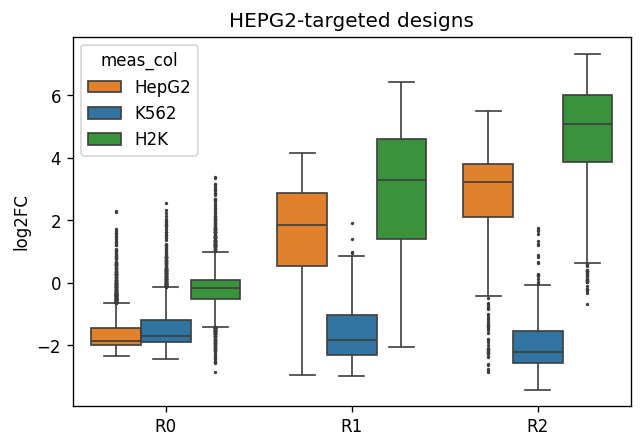

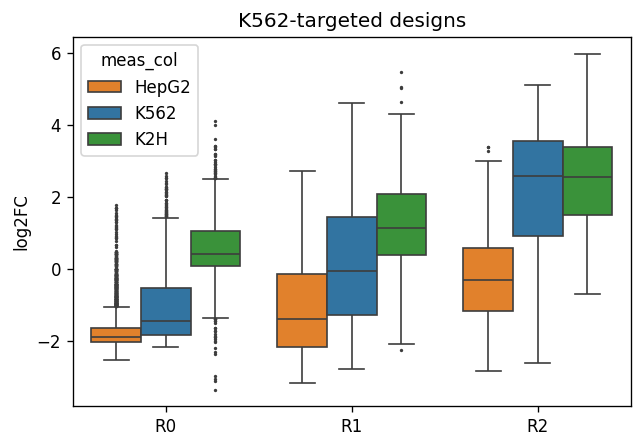

In [36]:
for cell_type in ['HEPG2','K562']:
    cur_d3_analysis_df = d3_analysis_df[d3_analysis_df['cell_type']==cell_type].copy()
    cur_d2_analysis_df = d2_analysis_df[d2_analysis_df['cell_type']==cell_type].copy()
    cur_d1_analysis_df = d1_analysis_df[d1_analysis_df['cell_type']==cell_type].copy()

    # append design_round col to each df
    cur_d3_analysis_df['design_round'] = 'R2'
    cur_d2_analysis_df['design_round'] = 'R1'
    cur_d1_analysis_df['design_round'] = 'R0'

    # boxplot of HEPG2_COL, K562_COL, H2K_COL for R0, R1, R2; separate for each cell type. So, hue = meas_col, x = design round

    meas_cols = [HEPG2_COL,K562_COL,H2K_COL]
    tot_cols = ['cell_type','design_round'] + meas_cols

    df2plot = pd.concat([cur_d1_analysis_df[tot_cols],cur_d2_analysis_df[tot_cols],cur_d3_analysis_df[tot_cols]])

    if cell_type == 'K562':
        df2plot[H2K_COL] = -df2plot[H2K_COL]

    # melt dataframe so that the meas_col is in one column and the value is in another
    df2plot = df2plot.melt(id_vars=['cell_type','design_round'],value_vars=meas_cols,var_name='meas_col',value_name='meas_val')

    # replace HEPG2_COL with 'log2FC$_{HepG2}$', K562_COL with 'log2FC$_{K562}$', H2K_COL with 'log2FC$_{H2K}$'
    df2plot['meas_col'] = df2plot['meas_col'].replace(HEPG2_COL,'HepG2')
    df2plot['meas_col'] = df2plot['meas_col'].replace(K562_COL,'K562')
    if cell_type == 'K562':
        h2k_dir = 'K2H'
    else:
        h2k_dir = 'H2K'
    df2plot['meas_col'] = df2plot['meas_col'].replace(H2K_COL,h2k_dir)

    # define hue_palette with tab:orange for log2FC$_{HepG2}$, tab:blue for log2FC$_{K562}$, tab:green for log2FC$_{H2K}$
    hue_palette = {'HepG2':'tab:orange','K562':'tab:blue',h2k_dir:'tab:green'}

    plt.figure(figsize=(6,4))
    sns.boxplot(data=df2plot,x='design_round',y='meas_val',hue='meas_col',palette=hue_palette,fliersize=1)
    plt.ylabel('log2FC')
    # remove xlabel
    plt.xlabel('')
    plt.title(f'{cell_type}-targeted designs')
    
    # Okay, for HepG2, K562, and H2K, compare median score from R0 to R1, and R1 to R2, using wilcoxon rank sum test
    # report the medians and the p-values for each comparison

    for meas in df2plot['meas_col'].unique():

        cur_df = df2plot[df2plot['meas_col']==meas].copy()

        r0_vals = cur_df[cur_df['design_round']=='R0']['meas_val'].values
        r1_vals = cur_df[cur_df['design_round']=='R1']['meas_val'].values
        r2_vals = cur_df[cur_df['design_round']=='R2']['meas_val'].values

        # compare R0 to R1
        _,p = stats.ranksums(r0_vals,r1_vals)
        print(f'{meas} R0 vs R1: {np.median(r0_vals):.2f} vs {np.median(r1_vals):.2f}, p={p:.2e}')

        # compare R1 to R2
        _,p = stats.ranksums(r1_vals,r2_vals)
        print(f'{meas} R1 vs R2: {np.median(r1_vals):.2f} vs {np.median(r2_vals):.2f}, p={p:.2e}')


# Okay, so for HepG2:
#   K562  = -1.70 to -1.83 to -2.20
#   HepG2 = -1.85 to 1.86 to 3.23
#   H2K   = -0.16 to 3.28 to 5.09

# takeaways: K562 activity decreases significantly across rounds but effect size is small compared to HepG2 increases
# H2K increase driven by HepG2 increase, not K562 decrease

# For K562:
#   K562  = -1.45 to -0.05 to 2.59
#   HepG2 = -1.90 to -1.38 to -0.32
#   K2H   = 0.42 to 1.14 to 2.56

# takeaways: K562 activity increases significantly across rounds, so does HepG2, but K562 increase is greater

In [34]:
df2plot

cell_type design_round meas_col  meas_val
0          K562           R0    HepG2 -0.004852
1          K562           R0    HepG2 -1.990433
2          K562           R0    HepG2 -0.414598
3          K562           R0    HepG2 -2.099262
4          K562           R0    HepG2 -2.196669
...         ...          ...      ...       ...
12319      K562           R2      K2H  3.681158
12320      K562           R2      K2H  1.888935
12321      K562           R2      K2H  1.364439
12322      K562           R2      K2H -0.231827
12323      K562           R2      K2H  2.509982

[12324 rows x 4 columns]

HepG2 R0 vs R1: -1.90 vs -1.38, p=3.10e-16
HepG2 R1 vs R2: -1.38 vs -0.32, p=1.19e-21
K562 R0 vs R1: -1.45 vs -0.05, p=6.74e-59
K562 R1 vs R2: -0.05 vs 2.59, p=3.79e-53
K2H R0 vs R1: 0.42 vs 1.14, p=3.94e-39
K2H R1 vs R2: 1.14 vs 2.56, p=4.37e-37


### R2.7.1 - DHS vs MPRA training data ###

In [120]:
# # first, generate predictions using the unfinetuned models on the test set - I ran this once so shouldn't have to do it again!

# save_dir = 'revision_scripts/R2_7/dhs_vs_mpra_ft_models_n1000/unfinetuned'
# os.makedirs(save_dir,exist_ok=True)
# results_basename = 'unfinetuned_results'
# # model_suffix = ''

# # load the M0 ensemble model
# cf_model_dir = '../../aws/for_aws/sequencing_analysis/retraining/retrained_models/cf10/test_fold_0/d1'
# model_basename = f'd1_wide_cf_t0_v'
# model_name = f'{cf_model_dir}/{model_basename}.h5'
# model_suffix=''

# # load in test set
# test_dir = 'revision_scripts/R2_7'
# x_test = np.load(f'{test_dir}/x_test.npy')
# y_test = np.load(f'{test_dir}/y_test.npy')

# # pad x_test to 200bp
# lpad = (200-145)//2
# rpad = 200 - 145 - lpad
# x_test = np.pad(x_test,((0,0),(lpad, rpad),(0,0)))

# # load unfinetuned model and get predictions to append to the results_dfs in the next cell
# # import load_model function
# from tensorflow.keras.models import load_model
# model_inds = np.arange(1,10)

# for model_idx in model_inds:

#     K.clear_session()
#     model = load_model(f'{cf_model_dir}/{model_basename}{model_idx}{model_suffix}.h5')

#     y_test_hat = model.predict(x_test)

#     metrics = ['pearsonr','spearmanr']
#     for corr_idx,corr in enumerate([pearsonr,spearmanr]):
#         r_h_d2   = corr(y_test[:,0],y_test_hat[:,0])[0]
#         r_k_d2   = corr(y_test[:,1],y_test_hat[:,1])[0]
#         r_h2k_d2   = corr(y_test[:,0]-y_test[:,1],y_test_hat[:,0]-y_test_hat[:,1])[0]
    
#         # print results to text file
#         with open(f'{save_dir}/{results_basename}_{metrics[corr_idx]}.txt', 'a') as f:
#             # write the hyperparameters for this model
#             f.write(f'{r_h_d2:.3f},{r_k_d2:.3f},{r_h2k_d2:.3f}\n')

# # okay well I confirmed that finetuning on all the d3 data does a lot better on this test set, which makes sense because this test set is included in that training data

29/29 [==============================] - 0s 12ms/step


C:\Users\Chris\AppData\Local\Temp\ipykernel_19064\4133782598.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels,fontsize=TEXT_FSIZE)


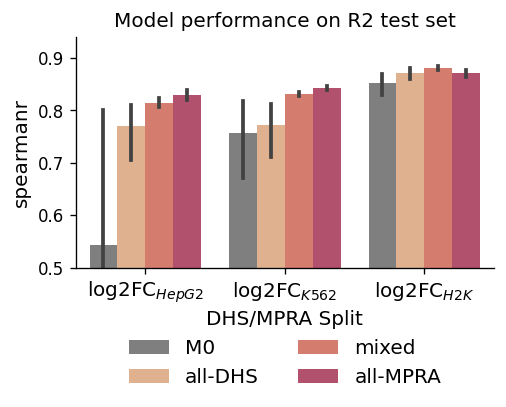

In [105]:
# okay, now on to the results!
# okay I want to load in the different result files now

TEXT_FSIZE = 12

base_results_dir = 'revision_scripts/R2_7/dhs_vs_mpra_ft_models_n1000'
n_tot_seqs = 1000

# get 3 colors on viridis color map
cmap = plt.get_cmap('flare')
colors = cmap(np.linspace(0,0.5,3))


palette = {
    'M0': 'tab:gray',
    'all-DHS': colors[0],
    'mixed': colors[1],
    'all-MPRA': colors[2]
}

for corr in ['spearmanr']:

    results_fnames = [
        f'{base_results_dir}/unfinetuned/unfinetuned_results_{corr}.txt',
        f'{base_results_dir}/DvM_{n_tot_seqs}-0/dhs_vs_mpra_revision_results_DvM_{n_tot_seqs}-0_{corr}.txt',
        f'{base_results_dir}/DvM_{n_tot_seqs//2}-{n_tot_seqs//2}/dhs_vs_mpra_revision_results_DvM_{n_tot_seqs//2}-{n_tot_seqs//2}_{corr}.txt',
        f'{base_results_dir}/DvM_0-{n_tot_seqs}/dhs_vs_mpra_revision_results_DvM_0-{n_tot_seqs}_{corr}.txt',
    ]

    model_names = ['0/0','100/0','50/50','0/100',]

    results_df = pd.DataFrame()

    for results_fname,model_name in zip(results_fnames,model_names):
        # print(os.path.exists(results_fname))
        df = pd.read_csv(results_fname,header=None)
        df.columns = ['HEPG2','K562','H2K']
        df['model'] = model_name
        results_df = pd.concat([results_df,df])

    # replace model names with M0, all-DHS, mixed, all-MPRA
    results_df['model'] = results_df['model'].replace('0/0','M0')
    results_df['model'] = results_df['model'].replace('100/0','all-DHS')
    results_df['model'] = results_df['model'].replace('50/50','mixed')
    results_df['model'] = results_df['model'].replace('0/100','all-MPRA')

    # barplot of pearson correlations grouped by model
    results_df = results_df.melt(id_vars=['model'],value_vars=['HEPG2','K562','H2K'])
    results_df.columns = ['model','cell_line','corr']


# palette = {
#     'None': 'tab:gray',
#     'Perturb': sns.color_palette("Set2")[0],
#     'Top Enhancer': sns.color_palette("Set2")[1]
# }

    fig, ax = plt.subplots(figsize=(4.5,2.5))
    order = ['HEPG2','K562','H2K']
    # hue_order = ['0/0','100/0','50/50','0/100']
    hue_order = ['M0','all-DHS','mixed','all-MPRA']
    xtick_labels = ['log2FC$_{HepG2}$','log2FC$_{K562}$','log2FC$_{H2K}$']
    ax = sns.barplot(x='cell_line',y='corr',hue='model',data=results_df,order=order,hue_order=hue_order,palette=palette)
    # ax = sns.barplot(x='cell_line',y='corr',hue='model',data=results_df[results_df['model']!='100/0'],order=order)
    ax.set_ylim(0.5,0.94)
    ax.set_xticklabels(xtick_labels,fontsize=TEXT_FSIZE)
    ax.set_xlabel('')
    ax.set_ylabel(f'{corr}',fontsize=TEXT_FSIZE)
    ax.set_title('Model performance on R2 test set',fontsize=TEXT_FSIZE)

    # despine
    sns.despine()

    # ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    legend_title = 'DHS/MPRA Split'
    plt.legend(bbox_to_anchor=(0.5, -0.35), loc='center', ncol=2,frameon=False,fontsize=TEXT_FSIZE,title=legend_title,title_fontsize=TEXT_FSIZE)
    # move x axis label down
    ax.xaxis.labelpad = 10

    # save figure
    plt.savefig(f'{revision_figure_dir}/figSX_{corr}_barplot_DHS_vs_MPRA_preds.png',dpi=500,bbox_inches='tight')


In [101]:
# for each cell type, do t-test between all the models

# okay, do a t-test to see if the perturb models are significantly different from the top enhancer models on each cell line
from scipy.stats import ttest_ind

model_vals = results_df['model'].unique()

# get all pairs of models using combinations
from itertools import combinations
model_pairs = list(combinations(model_vals,2))
n_tests = len(model_pairs)

for cell_line in ['HEPG2','K562','H2K']:

    print(f'{cell_line}:')

    # for all model combinations in results_df['model'], do a t-test
    for model1,model2 in model_pairs:
        vals1 = results_df[(results_df['model']==model1) & (results_df['cell_line']==cell_line)]['corr']
        vals2 = results_df[(results_df['model']==model2) & (results_df['cell_line']==cell_line)]['corr']
        t,p = ttest_ind(vals1,vals2)

        u1 = vals1.mean()
        u2 = vals2.mean()
        s1 = vals1.std()
        s2 = vals2.std()

        if p*3 < 0.05: # 3 comparisons per prediction tasks
            print(f'\t{model1} vs {model2}: {u1:.2f}+={s1:.2f} vs {u2:.2f}+={s1:.2f}, p={p:.1e}')

HEPG2:
K562:
	50/50 vs 0/100: 0.83+=0.01 vs 0.84+=0.01, p=2.3e-03
H2K:
	0/0 vs 50/50: 0.85+=0.03 vs 0.88+=0.03, p=1.6e-02
	50/50 vs 0/100: 0.88+=0.01 vs 0.87+=0.01, p=1.6e-02


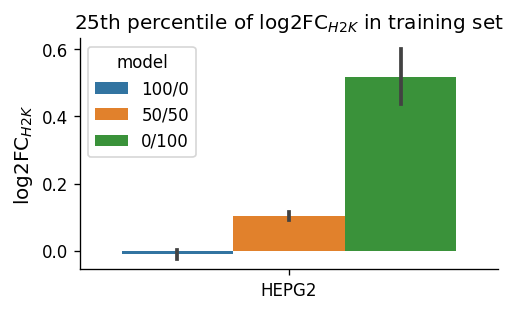

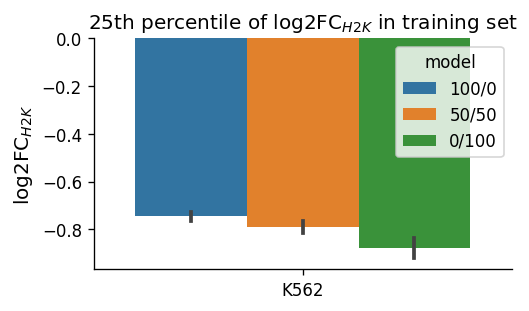

In [41]:
# okay, now on to the results!
# okay I want to load in the different result files now

TEXT_FSIZE = 12

corr = 'percentiles'

results_fnames = [
    f'revision_scripts/R2_7/r0_r1_balance_ft_models/r0r1_1000-0/r0_r1_revision_splits_results_r0_r1_1000-0_v{corr}.txt',
    f'revision_scripts/R2_7/r0_r1_balance_ft_models/r0r1_750-250/r0_r1_revision_splits_results_r0_r1_750-250_v{corr}.txt',
    f'revision_scripts/R2_7/r0_r1_balance_ft_models/r0r1_500-500/r0_r1_revision_splits_results_r0_r1_500-500_v{corr}.txt',
    f'revision_scripts/R2_7/r0_r1_balance_ft_models/r0r1_250-750/r0_r1_revision_splits_results_r0_r1_250-750_v{corr}.txt',
    f'revision_scripts/R2_7/r0_r1_balance_ft_models/r0r1_0-1000/r0_r1_revision_splits_results_r0_r1_0-1000_v{corr}.txt'
]

model_names = ['100/0','50/50','0/100',]

results_df = pd.DataFrame()

for results_fname,model_name in zip(results_fnames,model_names):
    # print(os.path.exists(results_fname))
    df = pd.read_csv(results_fname,header=None)
    df.columns = ['K562','HEPG2']
    df['model'] = model_name
    results_df = pd.concat([results_df,df])

# barplot of pearson correlations grouped by model
results_df = results_df.melt(id_vars=['model'],value_vars=['HEPG2','K562'])
results_df.columns = ['model','cell_line','corr']


# palette = {
#     'None': 'tab:gray',
#     'Perturb': sns.color_palette("Set2")[0],
#     'Top Enhancer': sns.color_palette("Set2")[1]
# }
for cell_type in ['HEPG2','K562']:
    fig, ax = plt.subplots(figsize=(4.5,2.5))
    # order = ['HEPG2','K562']
    # xtick_labels = ['log2FC$_{HEPG2}$','log2FC$_{K562}$']
    ax = sns.barplot(x='cell_line',y='corr',hue='model',data=results_df[results_df['cell_line']==cell_type])
    # ax.set_xticklabels(xtick_labels,fontsize=TEXT_FSIZE)
    ax.set_xlabel('')
    ax.set_ylabel('log2FC$_{H2K}$',fontsize=TEXT_FSIZE)
    ax.set_title('25th percentile of log2FC$_{H2K}$ in training set')
    # remove legend
    # ax.get_legend().remove()

    # despine
    sns.despine()



In [42]:
results_dir = 'revision_scripts/R2_7/dhs_vs_mpra_ft_models_n1000'
# cur_model = 'DvM_1000-0'

pred_df = pd.DataFrame()

for cur_model in ['DvM_1000-0','DvM_500-500','DvM_0-1000']:

    cur_df = pd.read_csv(f'{results_dir}/{cur_model}/fsp_designs/designed_seqs_{cur_model}_fsp_seq_df_with_preds.csv')
    # drop last column
    cur_df.drop(cur_df.columns[-1],axis=1,inplace=True)

    HEPG2_PRED_COL = 'HepG2_preds'
    K562_PRED_COL = 'K562_preds'
    H2K_PRED_COL = 'H2K_preds'

    cur_df[H2K_PRED_COL] = cur_df[HEPG2_PRED_COL] - cur_df[K562_PRED_COL]
    # 'designed_seqs_DvM_1000-0_fsp_seq_df_with_preds.csv'
    cur_df['model'] = cur_model

    pred_df = pd.concat([pred_df,cur_df],ignore_index=True)

pred_df.groupby('cell_type')['model'].value_counts()

cell_type  model      
HEPG2      DvM_0-1000     100
           DvM_1000-0     100
           DvM_500-500    100
K562       DvM_0-1000     100
           DvM_1000-0     100
           DvM_500-500    100
Name: count, dtype: int64

In [43]:
# load in M2 models
model_dir = 'd2_finetuned/test_fold_0/d3_tot'
model_basename = 'd1_wide_ft_cf_t0_v'
model_inds = np.arange(1,10)
suffix = '_d2_ft'
model = load_ensemble_model(model_dir,model_basename,model_inds,model_suffix=suffix)


In [44]:
x = np.stack(pred_df['sequence'].apply(lambda x: seq_to_one_hot_and_pad(x)).values)
y = model.predict(x)

pred_df[H2K_PRED_COL] = y[:,0] - y[:,1]

19/19 [==============================] - 4s 110ms/step


C:\Users\Chris\AppData\Local\Temp\ipykernel_19064\1493594325.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[cell_idx].set_xticklabels(xtick_labels,fontsize=TEXT_FSIZE)
C:\Users\Chris\AppData\Local\Temp\ipykernel_19064\1493594325.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[cell_idx].set_xticklabels(xtick_labels,fontsize=TEXT_FSIZE)


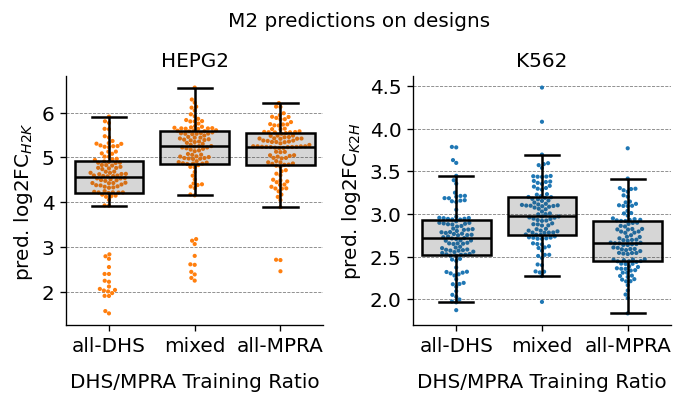

In [113]:
# I am going to want a boxswarm of the designs, plot H2K_PRED_COL

auto_sig = False
save = False

# create 1x2 subplot
fig, ax = plt.subplots(1,2,figsize=(6.5,3))

xtick_labels = ['all-DHS','mixed','all-MPRA']

for cell_idx,cell_type in enumerate(['HEPG2','K562']):

    cur_analysis_df = pred_df[pred_df['cell_type']==cell_type].copy()

    if cell_type == 'K562':
        cur_analysis_df[H2K_PRED_COL] = -cur_analysis_df[H2K_PRED_COL]
        y_axis_label = 'log2FC$_{K2H}$'
    else:
        y_axis_label = 'log2FC$_{H2K}$'


    # # now melt on the HEPG2_COL and K562_COL
    # cur_analysis_df = pd.melt(cur_analysis_df,id_vars=['sequence_name','enhancer_len'],value_vars=[HEPG2_COL,K562_COL],var_name='cell_type',value_name='activity')
    # # replace HEPG2_COL with 'HEPG2' in cell_type column
    # cur_analysis_df['cell_type'] = cur_analysis_df['cell_type'].apply(lambda x: 'HEPG2' if x == HEPG2_COL else 'K562')

    # 1 x 2 subplot

    palette = {'HEPG2': 'tab:orange', 'K562': 'tab:blue'}

    swarm_alpha=1

    # now plot a swarm plot with each sequence_length as x, and the cell_type variable as the hue
    sns.swarmplot(x='model',y=H2K_PRED_COL,data=cur_analysis_df,ax=ax[cell_idx],size=2.5,alpha=swarm_alpha,
                dodge=True,hue='cell_type',palette=palette,edgecolor='k',linewidth=0.0)

    linewidth = 1.5
    medianprops = {'color':'k','linewidth':linewidth}
    whiskerprops = {'color':'k','linewidth':linewidth}
    capprops = {'color':'k','linewidth':linewidth}
    # boxprops = {}
    boxprops={"facecolor": (.2, .2, .2, .2),'edgecolor':'k','linewidth':linewidth}

    # now plot boxplot on top of swarmplot, again separating by cell_type
    sns.boxplot(x='model',y=H2K_PRED_COL,data=cur_analysis_df, hue='cell_type',ax=ax[cell_idx],showfliers=False,
                boxprops=boxprops,medianprops=medianprops,whiskerprops=whiskerprops,capprops=capprops,zorder=20)

    # handles, labels = ax.get_legend_handles_labels()
    # ax.legend(handles, ['HEPG2','K562'],title='',bbox_to_anchor=(1.05, 1), loc='upper left')
    # remove legend
    ax[cell_idx].get_legend().remove()

    # set ylabel to log2FC
    ax[cell_idx].set_ylabel(f'pred. {y_axis_label}',fontsize=TITLE_FSIZE)
    # set xlabel to sequence length
    ax[cell_idx].set_xlabel('DHS/MPRA Training Ratio',fontsize=TITLE_FSIZE)

    # set xticks to ['100/0','50/50','0/100']
    # ax[cell_idx].set_xticklabels(['100/0','50/50','0/100'])
    ax[cell_idx].set_xticklabels(xtick_labels,fontsize=TEXT_FSIZE)

    # increase distance between xtick and axis label
    ax[cell_idx].xaxis.labelpad = 10

    # set title
    # ax.set_title(f'')
    # add horizontal grid lines
    ax[cell_idx].grid(axis='y',color='gray',linestyle='--',linewidth=0.5)

    # despine
    sns.despine()
    # set xtick font size
    ax[cell_idx].tick_params(axis='x', labelsize=TITLE_FSIZE)
    # set ytick font size
    ax[cell_idx].tick_params(axis='y', labelsize=TITLE_FSIZE)
    # title: HepG2 designs
    ax[cell_idx].set_title(f'{cell_type}',fontsize=TITLE_FSIZE)

# set overall title
plt.suptitle('M2 predictions on designs',fontsize=TITLE_FSIZE)
# increase height of suptitle
plt.subplots_adjust(top=0.8)
# increase distance between subplots
plt.subplots_adjust(wspace=0.35)


# save in revision figure dir
plt.savefig(f'{revision_figure_dir}/figSX_DHS_vs_MPRA_designs.png',dpi=600,bbox_inches='tight')

In [100]:
# for each cell_type, compare median H2K_PRED_COL between models and get significance value
for cell_type in ['HEPG2','K562']:
    for model1,model2 in itertools.combinations(pred_df['model'].unique(),2):
        model1_vals = pred_df[(pred_df['model']==model1) & (pred_df['cell_type']==cell_type)][H2K_PRED_COL].values
        model2_vals = pred_df[(pred_df['model']==model2) & (pred_df['cell_type']==cell_type)][H2K_PRED_COL].values

        _,p = stats.ranksums(model1_vals,model2_vals)
        if p < 0.05:
            print(f'{cell_type} {model1} vs {model2}: {np.median(model1_vals):.2f} vs {np.median(model2_vals):.2f}, p={p:.2e}')

HEPG2 DvM_1000-0 vs DvM_500-500: 4.56 vs 5.25, p=8.74e-11
HEPG2 DvM_1000-0 vs DvM_0-1000: 4.56 vs 5.24, p=3.61e-11
K562 DvM_1000-0 vs DvM_500-500: -2.72 vs -2.97, p=2.06e-06
K562 DvM_500-500 vs DvM_0-1000: -2.97 vs -2.66, p=3.00e-08


### R2.7.2 - Random vs high activity enhancers ###

In [258]:
# I am going to want to generate a test dataset here - okay let's make this test set from R2, maybe only the fully de novo designs (also exclude minimal)

model_types = ['d1_finetuned','d2_dhs']
design_types = ['fsp','fsp_clipped','fsp_tgt','fsp_max1','fsp_min1','fsp_clipped_max1','fsp_clipped_min1']

test_df = d3_seq_df[(d3_seq_df['model_type'].isin(model_types)) & (d3_seq_df['design_type'].isin(design_types))].copy()
print(f'{test_df.shape[0]} sequences in test set')

# one hot encode and save x_test, y_test
x_test = np.stack(test_df['sequence'].apply(lambda x: seq_to_one_hot(x)).values)
y_test = test_df[[HEPG2_COL,K562_COL]].values

# save x_test, y_test
save_dir = 'revision_scripts/R2_7'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
np.save(f'{save_dir}/x_test.npy',x_test)
np.save(f'{save_dir}/y_test.npy',y_test)

927 sequences in test set


C:\Users\Chris\AppData\Local\Temp\ipykernel_19064\3206500614.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels,fontsize=TEXT_FSIZE)


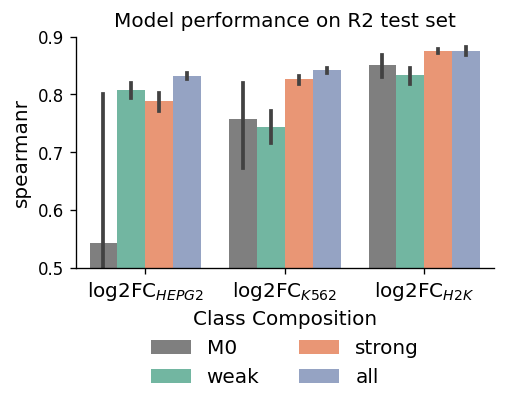

In [127]:
### rand vs high version ###

# okay, now on to the results!
# okay I want to load in the different result files now

TEXT_FSIZE = 12

corr = 'spearmanr'

base_results_dir = 'revision_scripts/R2_7/dhs_vs_mpra_ft_models_n1000'

results_fnames = [
    f'{base_results_dir}/unfinetuned/unfinetuned_results_{corr}.txt',
    f'revision_scripts/R2_7/rand_vs_high_ft_models/weak/rand_vs_high_resultsweak{corr}.txt',
    f'revision_scripts/R2_7/rand_vs_high_ft_models/strong/rand_vs_high_resultsstrong{corr}.txt',
    f'revision_scripts/R2_7/rand_vs_high_ft_models/all/rand_vs_high_resultsall{corr}.txt',
]

model_names = ['M0','weak','strong','all']

results_df = pd.DataFrame()

for results_fname,model_name in zip(results_fnames,model_names):
    # print(os.path.exists(results_fname))
    df = pd.read_csv(results_fname,header=None)
    df.columns = ['HEPG2','K562','H2K']
    df['model'] = model_name
    results_df = pd.concat([results_df,df])

# barplot of pearson correlations grouped by model
results_df = results_df.melt(id_vars=['model'],value_vars=['HEPG2','K562','H2K'])
results_df.columns = ['model','cell_line','corr']


palette = {
    'M0': 'tab:gray',
    'weak': sns.color_palette("Set2")[0],
    'strong': sns.color_palette("Set2")[1],
    'all': sns.color_palette("Set2")[2]
}

fig, ax = plt.subplots(figsize=(4.5,2.5))
order = ['HEPG2','K562','H2K']
xtick_labels = ['log2FC$_{HEPG2}$','log2FC$_{K562}$','log2FC$_{H2K}$']
ax = sns.barplot(x='cell_line',y='corr',hue='model',data=results_df,order=order,palette=palette)
# ax = sns.barplot(x='cell_line',y='corr',hue='model',data=results_df[results_df['model']!='100/0'],order=order)
# ax.set_ylim(0.75,0.9)
# ax.set_ylim(0.65,0.93)
ax.set_xticklabels(xtick_labels,fontsize=TEXT_FSIZE)
ax.set_xlabel('')
ax.set_ylabel(f'{corr}',fontsize=TEXT_FSIZE)
ax.set_title('Model performance on R2 test set',fontsize=TITLE_FSIZE)

# despine
sns.despine()

ax.set_ylim(0.5,0.9)

# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
legend_title = 'Class Composition'
plt.legend(bbox_to_anchor=(0.5, -0.35), loc='center', ncol=2,frameon=False,fontsize=TEXT_FSIZE,title=legend_title,title_fontsize=TEXT_FSIZE)
# move x axis label down
ax.xaxis.labelpad = 1



# # ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# legend_title = 'DHS/MPRA Split'
# plt.legend(bbox_to_anchor=(0.5, -0.35), loc='center', ncol=2,frameon=False,fontsize=TEXT_FSIZE,title=legend_title,title_fontsize=TEXT_FSIZE)
# # move x axis label down
# ax.xaxis.labelpad = 10

# save figure
plt.savefig(f'{revision_figure_dir}/figSX_{corr}_barplot_rand_vs_high_preds.png',dpi=500,bbox_inches='tight')

In [138]:
# for each cell_type, compare median H2K_PRED_COL between models and get significance value
for cell_type in ['HEPG2','K562','H2K']:
    for model1,model2 in itertools.combinations(results_df['model'].unique(),2):
        model1_vals = results_df[(results_df['model']==model1) & (results_df['cell_line']==cell_type)]['corr'].values
        model2_vals = results_df[(results_df['model']==model2) & (results_df['cell_line']==cell_type)]['corr'].values

        _,p = stats.ranksums(model1_vals,model2_vals)
        if p < 0.05:
            print(f'{cell_type} {model1} vs {model2}: {np.median(model1_vals):.2f} vs {np.median(model2_vals):.2f}, p={p:.2e}')

HEPG2 M0 vs all: 0.79 vs 0.83, p=1.93e-02
HEPG2 weak vs all: 0.80 vs 0.83, p=6.19e-03
HEPG2 strong vs all: 0.80 vs 0.83, p=3.49e-04
K562 M0 vs weak: 0.82 vs 0.76, p=4.69e-02
K562 M0 vs strong: 0.82 vs 0.83, p=8.07e-03
K562 M0 vs all: 0.82 vs 0.84, p=3.49e-04
K562 weak vs strong: 0.76 vs 0.83, p=3.49e-04
K562 weak vs all: 0.76 vs 0.84, p=3.49e-04
K562 strong vs all: 0.83 vs 0.84, p=1.27e-03
H2K M0 vs all: 0.87 vs 0.88, p=3.80e-02
H2K weak vs strong: 0.83 vs 0.87, p=3.49e-04
H2K weak vs all: 0.83 vs 0.88, p=6.75e-04


In [66]:
results_df.groupby(['model','cell_line']).mean()

corr
model  cell_line          
all    HEPG2      3.206000
       K562      -1.240778
strong HEPG2      4.577778
       K562      -2.131667
weak   HEPG2      1.266111
       K562      -0.438556

C:\Users\Chris\AppData\Local\Temp\ipykernel_27716\131064986.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels,fontsize=TEXT_FSIZE)


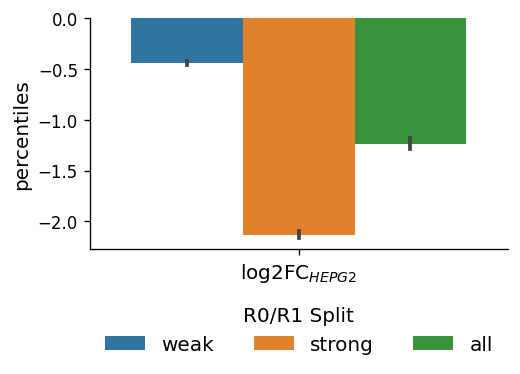

In [70]:
### rand vs high version ###

# okay, now on to the results!
# okay I want to load in the different result files now

TEXT_FSIZE = 12

corr = 'percentiles'

results_fnames = [
    f'revision_scripts/R2_7/rand_vs_high_ft_models/weak/rand_vs_high_resultsweak{corr}.txt',
    f'revision_scripts/R2_7/rand_vs_high_ft_models/strong/rand_vs_high_resultsstrong{corr}.txt',
    f'revision_scripts/R2_7/rand_vs_high_ft_models/all/rand_vs_high_resultsall{corr}.txt',
]

model_names = ['weak','strong','all']

results_df = pd.DataFrame()

for results_fname,model_name in zip(results_fnames,model_names):
    # print(os.path.exists(results_fname))
    df = pd.read_csv(results_fname,header=None)
    df.columns = ['K562','HEPG2']
    df['model'] = model_name
    results_df = pd.concat([results_df,df])

# barplot of pearson correlations grouped by model
results_df = results_df.melt(id_vars=['model'],value_vars=['HEPG2','K562'])
results_df.columns = ['model','cell_line','corr']


# palette = {
#     'None': 'tab:gray',
#     'Perturb': sns.color_palette("Set2")[0],
#     'Top Enhancer': sns.color_palette("Set2")[1]
# }

fig, ax = plt.subplots(figsize=(4.5,2.5))
xtick_labels = ['log2FC$_{HEPG2}$','log2FC$_{K562}$','log2FC$_{H2K}$']
ax = sns.barplot(x='cell_line',y='corr',hue='model',data=results_df[results_df['cell_line']=='K562'])
# ax = sns.barplot(x='cell_line',y='corr',hue='model',data=results_df[results_df['model']!='100/0'],order=order)
# ax.set_ylim(0.75,0.9)
# ax.set_ylim(0.65,0.93)
ax.set_xticklabels(xtick_labels,fontsize=TEXT_FSIZE)
ax.set_xlabel('')
ax.set_ylabel(f'{corr}',fontsize=TEXT_FSIZE)
ax.set_title('')

# despine
sns.despine()

# ax.set_ylim(0.25,0.95)


# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
legend_title = 'R0/R1 Split'
plt.legend(bbox_to_anchor=(0.5, -0.35), loc='center', ncol=3,frameon=False,fontsize=TEXT_FSIZE,title=legend_title,title_fontsize=TEXT_FSIZE)
# move x axis label down
ax.xaxis.labelpad = 10

In [129]:
# load designed sequences

# results_dir = 'revision_scripts/nvar_model_dir/designs'
results_dir = 'revision_scripts/R2_7/rand_vs_high_ft_models/designs'
# cur_model = 'DvM_1000-0'

design_df = pd.DataFrame()

vars = ['weak','strong','all']

from Bio import SeqIO

for cur_var in vars:
    for cell_type in ['HEPG2','K562']:
        # load in the fasta file
        cur_fasta = f'{results_dir}/designed{cur_var}_fsp_{cell_type}_seqs.fasta'
        # load in the fasta file using SeqIO
        cur_df = pd.DataFrame(columns=['sequence'])
        with open(cur_fasta) as fasta_file:
            for record in SeqIO.parse(fasta_file,'fasta'):
                cur_df = pd.concat([cur_df,pd.DataFrame([[str(record.seq)]],columns=['sequence'])])

        cur_df['n'] = cur_var
        cur_df['cell_type'] = cell_type
        design_df = pd.concat([design_df,cur_df],ignore_index=True)

# design_df.to_csv(f'{results_dir}/nvar_designs_df.csv',index=False)

# for cur_model in ['DvM_1000-0','DvM_500-500','DvM_0-1000']:

#     cur_df = pd.read_csv(f'{results_dir}/{cur_model}/fsp_designs/designed_seqs_{cur_model}_fsp_seq_df_with_preds.csv')
#     # drop last column
#     cur_df.drop(cur_df.columns[-1],axis=1,inplace=True)

#     HEPG2_PRED_COL = 'HepG2_preds'
#     K562_PRED_COL = 'K562_preds'
#     H2K_PRED_COL = 'H2K_preds'

#     cur_df[H2K_PRED_COL] = cur_df[HEPG2_PRED_COL] - cur_df[K562_PRED_COL]
#     # 'designed_seqs_DvM_1000-0_fsp_seq_df_with_preds.csv'
#     cur_df['model'] = cur_model

#     pred_df = pd.concat([pred_df,cur_df],ignore_index=True)

# pred_df.groupby('cell_type')['model'].value_counts()

In [130]:
# load in M2 models
model_dir = 'd2_finetuned/test_fold_0/d3_tot'
model_basename = 'd1_wide_ft_cf_t0_v'
model_inds = np.arange(1,10)
suffix = '_d2_ft'
model = load_ensemble_model(model_dir,model_basename,model_inds,model_suffix=suffix)

x = np.stack(design_df['sequence'].apply(lambda x: seq_to_one_hot_and_pad(x)).values)
y = model.predict(x)

HEPG2_PRED_COL = 'pred_log2FC_HepG2'
K562_PRED_COL = 'pred_log2FC_K562'
H2K_PRED_COL = 'pred_log2FC_H2K'

design_df[HEPG2_PRED_COL] = y[:,0]
design_df[K562_PRED_COL] = y[:,1]
design_df[H2K_PRED_COL] = y[:,0] - y[:,1]

19/19 [==============================] - 4s 105ms/step


C:\Users\Chris\AppData\Local\Temp\ipykernel_19064\4039019640.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[cell_idx].set_xticklabels(xtick_labels,fontsize=TEXT_FSIZE)
C:\Users\Chris\AppData\Local\Temp\ipykernel_19064\4039019640.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[cell_idx].set_xticklabels(xtick_labels,fontsize=TEXT_FSIZE)


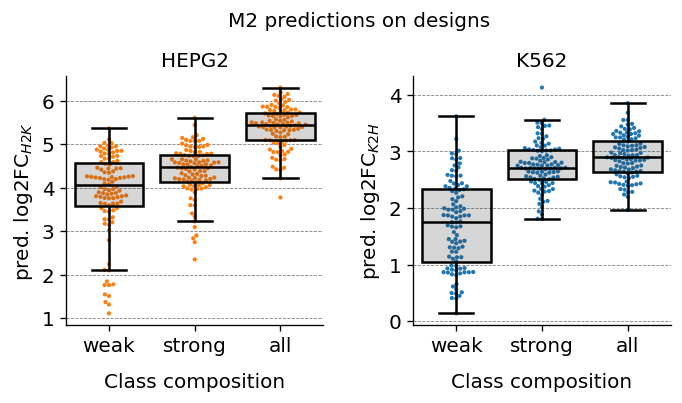

In [135]:
# I am going to want a boxswarm of the designs, plot H2K_PRED_COL

auto_sig = False
save = False

# create 1x2 subplot
fig, ax = plt.subplots(1,2,figsize=(6.5,3))

xtick_labels = ['weak','strong','all']

for cell_idx,cell_type in enumerate(['HEPG2','K562']):

    cur_analysis_df = design_df[design_df['cell_type']==cell_type].copy()
    # rename n to model
    cur_analysis_df.rename(columns={'n':'model'},inplace=True)

    if cell_type == 'K562':
        cur_analysis_df[H2K_PRED_COL] = -cur_analysis_df[H2K_PRED_COL]
        y_axis_label = 'log2FC$_{K2H}$'
    else:
        y_axis_label = 'log2FC$_{H2K}$'


    # 1 x 2 subplot

    palette = {'HEPG2': 'tab:orange', 'K562': 'tab:blue'}

    swarm_alpha=1

    # now plot a swarm plot with each sequence_length as x, and the cell_type variable as the hue
    sns.swarmplot(x='model',y=H2K_PRED_COL,data=cur_analysis_df,ax=ax[cell_idx],size=2.5,alpha=swarm_alpha,
                dodge=True,hue='cell_type',palette=palette,edgecolor='k',linewidth=0.0)

    linewidth = 1.5
    medianprops = {'color':'k','linewidth':linewidth}
    whiskerprops = {'color':'k','linewidth':linewidth}
    capprops = {'color':'k','linewidth':linewidth}
    # boxprops = {}
    boxprops={"facecolor": (.2, .2, .2, .2),'edgecolor':'k','linewidth':linewidth}

    # now plot boxplot on top of swarmplot, again separating by cell_type
    sns.boxplot(x='model',y=H2K_PRED_COL,data=cur_analysis_df, hue='cell_type',ax=ax[cell_idx],showfliers=False,
                boxprops=boxprops,medianprops=medianprops,whiskerprops=whiskerprops,capprops=capprops,zorder=20)

    # handles, labels = ax.get_legend_handles_labels()
    # ax.legend(handles, ['HEPG2','K562'],title='',bbox_to_anchor=(1.05, 1), loc='upper left')
    # remove legend
    ax[cell_idx].get_legend().remove()

    # set ylabel to log2FC
    ax[cell_idx].set_ylabel(f'pred. {y_axis_label}',fontsize=TITLE_FSIZE)
    # set xlabel to sequence length
    ax[cell_idx].set_xlabel('Class composition',fontsize=TITLE_FSIZE)

    # set xticks to ['100/0','50/50','0/100']
    # ax[cell_idx].set_xticklabels(['100/0','50/50','0/100'])
    ax[cell_idx].set_xticklabels(xtick_labels,fontsize=TEXT_FSIZE)

    # increase distance between xtick and axis label
    ax[cell_idx].xaxis.labelpad = 10

    # set title
    # ax.set_title(f'')
    # add horizontal grid lines
    ax[cell_idx].grid(axis='y',color='gray',linestyle='--',linewidth=0.5)

    # despine
    sns.despine()
    # set xtick font size
    ax[cell_idx].tick_params(axis='x', labelsize=TITLE_FSIZE)
    # set ytick font size
    ax[cell_idx].tick_params(axis='y', labelsize=TITLE_FSIZE)
    # title: HepG2 designs
    ax[cell_idx].set_title(f'{cell_type}',fontsize=TITLE_FSIZE)

# set overall title
plt.suptitle('M2 predictions on designs',fontsize=TITLE_FSIZE)
# increase height of suptitle
plt.subplots_adjust(top=0.8)
# increase distance between subplots
plt.subplots_adjust(wspace=0.35)


# save in revision figure dir
plt.savefig(f'{revision_figure_dir}/figSX_rand_vs_high_designs.png',dpi=600,bbox_inches='tight')


In [136]:
# do all the wilcoxon rank sum tests

# for each cell_type, compare median H2K_PRED_COL between models and get significance value
for cell_type in ['HEPG2','K562']:
    for model1,model2 in itertools.combinations(design_df['n'].unique(),2):
        model1_vals = design_df[(design_df['n']==model1) & (design_df['cell_type']==cell_type)][H2K_PRED_COL].values
        model2_vals = design_df[(design_df['n']==model2) & (design_df['cell_type']==cell_type)][H2K_PRED_COL].values

        _,p = stats.ranksums(model1_vals,model2_vals)
        if p < 0.05:
            print(f'{cell_type} {model1} vs {model2}: {np.median(model1_vals):.2f} vs {np.median(model2_vals):.2f}, p={p:.2e}')

HEPG2 weak vs strong: 4.06 vs 4.47, p=4.13e-05
HEPG2 weak vs all: 4.06 vs 5.45, p=1.47e-28
HEPG2 strong vs all: 4.47 vs 5.45, p=1.41e-24
K562 weak vs strong: -1.76 vs -2.71, p=6.64e-20
K562 weak vs all: -1.76 vs -2.90, p=3.24e-24
K562 strong vs all: -2.71 vs -2.90, p=4.35e-03


### R2.16 - unique motifs in each library downsampling analysis ###

In [50]:
motif_dir = '../../../aws/for_aws/sequencing_analysis/fimo_motif_scanning'
jaspar_cluster_df = pd.read_csv(f'{motif_dir}/jaspar_motif_clusters.tsv',sep='\t',header=None,names=['cluster','motifs'])
jaspar_cluster_df['motifs'] = jaspar_cluster_df['motifs'].apply(lambda x: x.upper())

d1_analysis_seqs = d1_final_df['sequence_name'].unique()
d2_analysis_seqs = d2_deseq_df[~d2_deseq_df['generator'].isin(['control','motif_repeat'])].index
d3_model_types = ['d1_finetuned','d2_dhs']
d3_design_types = ['fsp','fsp_clipped']
d3_analysis_seqs = d3_seq_df[(d3_seq_df['model_type'].isin(d3_model_types))&(d3_seq_df['design_type'].isin(d3_design_types))]['sequence_name'].values

d1_final_df_filt = d1_final_df[d1_final_df['sequence_name'].isin(d1_analysis_seqs)].copy()
d2_final_df_filt = d2_final_df[d2_final_df['sequence_name'].isin(d2_analysis_seqs)].copy()
d3_final_df_filt = d3_final_df[d3_final_df['sequence_name'].isin(d3_analysis_seqs)].copy()

dhs_train_final_df_filt = pd.read_csv('fimo_fastas/dhs_classifier_training_final_df_qthresh0.05.csv')
dhs_design_final_df_filt = pd.read_csv('../../../aws/for_aws/sequencing_analysis/fimo_motif_scanning/saved_processed_motif_files/dw_final_df_qthresh05_v2.csv')

min_n_seqs = np.min([len(d1_analysis_seqs),len(d2_analysis_seqs),len(d3_analysis_seqs),len(dhs_train_final_df_filt),len(dhs_design_final_df_filt)])
print(f'Minimum number of sequences: {min_n_seqs}')

# calculate the unique number of motifs in r2

def sample_n_unique_motifs(final_df, sequence_names, n_seqs, rng):
    # randomly sample n_seqs from sequence_names, with replacement
    # sample_seqs = np.random.choice(sequence_names,n_seqs,replace=True)
    sample_seqs = rng.choice(sequence_names,n_seqs,replace=True)
    final_df_filt = final_df[final_df['sequence_name'].isin(sample_seqs)].copy()
    n_unique_motifs = final_df_filt['jaspar_cluster'].nunique()
    return n_unique_motifs
    
rng = np.random.default_rng(13)

n_bootstraps = 1000
n_unique_motifs = np.zeros(n_bootstraps)
for i in range(n_bootstraps):
    n_unique_motifs[i] = sample_n_unique_motifs(d1_final_df_filt,d1_analysis_seqs,min_n_seqs,rng)

print(f'Mean number of unique motifs in D1: {np.mean(n_unique_motifs):.2f} +/- {np.std(n_unique_motifs):.2f}')

n_unique_motifs = np.zeros(n_bootstraps)
for i in range(n_bootstraps):
    n_unique_motifs[i] = sample_n_unique_motifs(d2_final_df_filt,d2_analysis_seqs,min_n_seqs,rng)

print(f'Mean number of unique motifs in D2: {np.mean(n_unique_motifs):.2f} +/- {np.std(n_unique_motifs):.2f}')

n_unique_motifs = np.zeros(n_bootstraps)
for i in range(n_bootstraps):
    n_unique_motifs[i] = sample_n_unique_motifs(d3_final_df_filt,d3_analysis_seqs,min_n_seqs,rng)

print(f'Mean number of unique motifs in D3: {np.mean(n_unique_motifs):.2f} +/- {np.std(n_unique_motifs):.2f}')

n_unique_motifs = np.zeros(n_bootstraps)
for i in range(n_bootstraps):
    n_unique_motifs[i] = sample_n_unique_motifs(dhs_train_final_df_filt,dhs_train_final_df_filt['sequence_name'].unique(),min_n_seqs,rng)

print(f'Mean number of unique motifs in DHS Train: {np.mean(n_unique_motifs):.2f} +/- {np.std(n_unique_motifs):.2f}')

n_unique_motifs = np.zeros(n_bootstraps)
for i in range(n_bootstraps):
    n_unique_motifs[i] = sample_n_unique_motifs(dhs_design_final_df_filt,dhs_design_final_df_filt['sequence_name'].unique(),min_n_seqs,rng)

print(f'Mean number of unique motifs in DHS Design: {np.mean(n_unique_motifs):.2f} +/- {np.std(n_unique_motifs):.2f}')



# d1_final_df_filt = d1_final_df[d1_final_df['sequence_name'].isin(d1_analysis_seqs)].copy()
# d1_motif_cluster_df = pd.DataFrame(columns=['motif_alt_id','jaspar_cluster'])
# for motif in d1_final_df_filt['motif_alt_id'].unique():
#     jaspar_cluster_id = jaspar_cluster_df[jaspar_cluster_df['motifs'].str.contains(motif)]['cluster'].values[0]
#     d1_motif_cluster_df = pd.concat([d1_motif_cluster_df, pd.DataFrame({'motif_alt_id':[motif], 'jaspar_cluster':[jaspar_cluster_id]})])
# n_d1_clusters = d1_motif_cluster_df['jaspar_cluster'].unique()



# # create a dataframe with the motif names in final_df['motif_alt_id'].unique() and the cluster they belong to in jaspar_cluster_df
# d2_motif_cluster_df = pd.DataFrame(columns=['motif_alt_id','jaspar_cluster'])
# for motif in d2_final_df_filt['motif_alt_id'].unique():
#     jaspar_cluster_id = jaspar_cluster_df[jaspar_cluster_df['motifs'].str.contains(motif)]['cluster'].values[0]
#     d2_motif_cluster_df = pd.concat([d2_motif_cluster_df, pd.DataFrame({'motif_alt_id':[motif], 'jaspar_cluster':[jaspar_cluster_id]})])

# d3_motif_cluster_df = pd.DataFrame(columns=['motif_alt_id','jaspar_cluster'])
# for motif in d3_final_df_filt['motif_alt_id'].unique():
#     jaspar_cluster_id = jaspar_cluster_df[jaspar_cluster_df['motifs'].str.contains(motif)]['cluster'].values[0]
#     d3_motif_cluster_df = pd.concat([d3_motif_cluster_df, pd.DataFrame({'motif_alt_id':[motif], 'jaspar_cluster':[jaspar_cluster_id]})])

# dhs_design_cluster_df = pd.DataFrame(columns=['motif_alt_id','jaspar_cluster'])
# for motif in dhs_design_final_df_filt['motif_alt_id'].unique():
#     jaspar_cluster_id = jaspar_cluster_df[jaspar_cluster_df['motifs'].str.contains(motif)]['cluster'].values[0]
#     dhs_design_cluster_df = pd.concat([dhs_design_cluster_df, pd.DataFrame({'motif_alt_id':[motif], 'jaspar_cluster':[jaspar_cluster_id]})])

# dhs_train_cluster_df = pd.DataFrame(columns=['motif_alt_id','jaspar_cluster'])
# for motif in dhs_train_final_df_filt['motif_alt_id'].unique():
#     jaspar_cluster_id = jaspar_cluster_df[jaspar_cluster_df['motifs'].str.contains(motif)]['cluster'].values[0]
#     dhs_train_cluster_df = pd.concat([dhs_train_cluster_df, pd.DataFrame({'motif_alt_id':[motif], 'jaspar_cluster':[jaspar_cluster_id]})])

# d1_clusters = d1_motif_cluster_df['jaspar_cluster'].unique()
# d2_clusters = d2_motif_cluster_df['jaspar_cluster'].unique()
# d3_clusters = d3_motif_cluster_df['jaspar_cluster'].unique()
# dhs_train_clusters = dhs_train_cluster_df['jaspar_cluster'].unique()
# dhs_design_clusters = dhs_design_cluster_df['jaspar_cluster'].unique()

# print(f'Number of clusters in D1: {len(d1_clusters)}')
# print(f'Number of clusters in D2: {len(d2_clusters)}')
# print(f'Number of clusters in D3: {len(d3_clusters)}')
# print(f'Number of clusters in DHS Train: {len(dhs_train_clusters)}')
# print(f'Number of clusters in DHS Design: {len(dhs_design_clusters)}')

Minimum number of sequences: 688
Mean number of unique motifs in D1: 44.06 +/- 2.38
Mean number of unique motifs in D2: 35.60 +/- 1.71
Mean number of unique motifs in D3: 27.21 +/- 1.08
Mean number of unique motifs in DHS Train: 25.31 +/- 1.95
Mean number of unique motifs in DHS Design: 45.05 +/- 1.91


In [52]:
dhs_train_final_df_filt['sequence_name'].nunique()

13468

### R3.1 - model performance as function of number of training sequences ###

In [4]:
def snake_split(indices, n_cfs):
    """
    Splits a list of indices into n_cfs lists using a snake-style sort.

    Parameters:
        indices (list): The list of indices to split.
        n_cfs (int): The number of lists to split into.

    Returns:
        list of lists: A list containing n_cfs lists.
    """
    # Initialize n_cfs empty lists
    split_lists = [[] for _ in range(n_cfs)]

    # Determine the current direction (1 for forward, -1 for backward)
    direction = 1
    current_cf = 0

    for ind in indices:
        # Append the current index to the appropriate list
        split_lists[current_cf].append(ind)

        # Update current_cf based on the direction
        next_cf = current_cf + direction

        # Reverse direction if the end or beginning of the range is reached
        if next_cf == n_cfs or next_cf == -1:
            direction *= -1
        else:
            current_cf = next_cf

    return split_lists


In [5]:
HEPG2_PRED_COL = 'pred_log2FC_HepG2'
K562_PRED_COL = 'pred_log2FC_K562'
H2K_PRED_COL = 'pred_log2FC_H2K'

def predict_on_designs(design_df):

    # add reference results
    ref_results_dir = 'revision_scripts/ref_unfinetuned_designs'

    ref_vars = ['M0','M1']
    # remove from ref_vars any values in design_df['n']
    ref_vars = [x for x in ref_vars if x not in design_df['n'].unique()]

    for cur_var in ref_vars:
        for cell_type in ['HEPG2','K562']:
            # load in the fasta file
            # cur_fasta = f'{results_dir}/designed.h5_ft_n{cur_n}_boot_fsp_{cell_type}_seqs.fasta'
            cur_fasta = f'{ref_results_dir}/designed_fsp_{cur_var}_{cell_type}_seqs.fasta'
            # load in the fasta file using SeqIO
            cur_df = pd.DataFrame(columns=['sequence'])
            with open(cur_fasta) as fasta_file:
                for record in SeqIO.parse(fasta_file,'fasta'):
                    cur_df = pd.concat([cur_df,pd.DataFrame([[str(record.seq)]],columns=['sequence'])])

            cur_df['n'] = cur_var
            cur_df['cell_type'] = cell_type
            design_df = pd.concat([design_df,cur_df],ignore_index=True)

    # load M2 models
    # model_dir = 'd2_finetuned/test_fold_0/d3_tot'
    model_dir = 'd2_finetuned/r2_bc_ft/test_fold_0/d3_tot'
    model_basename = 'd1_wide_ft_cf_t0_v'
    model_inds = np.arange(1,10)
    suffix = '_d2_ft'
    model = load_ensemble_model(model_dir,model_basename,model_inds,model_suffix=suffix)

    x = np.stack(design_df['sequence'].apply(lambda x: seq_to_one_hot_and_pad(x)).values)
    y = model.predict(x)

    HEPG2_PRED_COL = 'pred_log2FC_HepG2'
    K562_PRED_COL = 'pred_log2FC_K562'
    H2K_PRED_COL = 'pred_log2FC_H2K'

    design_df[HEPG2_PRED_COL] = y[:,0]
    design_df[K562_PRED_COL] = y[:,1]
    design_df[H2K_PRED_COL] = y[:,0] - y[:,1]

    return design_df

In [16]:
# load in cfs
cf_dir = 'revision_scripts/cf10'
x_cfs = [np.load(f'{cf_dir}/x_cf{i}.npy') for i in range(10)]
w_cfs = [np.load(f'{cf_dir}/w_cf{i}.npy') for i in range(10)]

n_cfs = 10
# for each cf, extract the y_cf rows where w_cf[:,1] == 1 (these are the d2 seqs)
for cf_idx in range(n_cfs):
    x_cfs[cf_idx] = x_cfs[cf_idx][w_cfs[cf_idx][:,1] == 1]


n_tot = np.sum([x_cf.shape[0] for x_cf in x_cfs])
print(n_tot)

# so I did use 1346 sequences for training.
# 1346 + 674 = 2020 sequences total
# for training, used 1346 * 0.9 + 674 * 0.8 = 1750 sequences
# from the 1750 sequences, used 1346 * 0.8 MPRA and 674 * 0.8 DHS = 1077 MPRA and 539 DHS for training, 135 MPRA seqs for validation

1346


269

In [103]:
# # load in test set of R2 sequences

from tensorflow.keras.models import load_model

# # save x_test, y_test
# save_dir = 'revision_scripts/R2_7'
# # save_dir = 'revision_scripts'

# x_test = np.load(f'{save_dir}/x_test.npy')
# y_test = np.load(f'{save_dir}/y_test.npy')
# # pad to 200 bp
# lpad = (200-145)//2
# rpad = 200 - 145 - lpad
# x_test = np.pad(x_test, ((0,0),(lpad,rpad),(0,0)), 'constant', constant_values=0)

# # load unfinetuned model and get predictions to append to the results_dfs in the next cell
# cf_model_dir = '../../aws/for_aws/sequencing_analysis/retraining/retrained_models/cf10/test_fold_0/d1'
# model_basename = f'd1_wide_cf_t0_v'
# model_inds = np.arange(1,10)
# # model_name = f'{cf_model_dir}/{model_basename}.h5'

# K.clear_session()
# model = load_ensemble_model(cf_model_dir,model_basename,model_inds)
# # predict on test set
# y_test_hat = model.predict(x_test)

# # calculate spearman r for each measurement
# r_h_m0 = spearmanr(y_test[:,0],y_test_hat[:,0])[0]
# r_k_m0 = spearmanr(y_test[:,1],y_test_hat[:,1])[0]
# r_h2k_m0 = spearmanr(y_test[:,0]-y_test[:,1],y_test_hat[:,0]-y_test_hat[:,1])[0]

# K.clear_session()
# cf_model_dir = '../../aws/for_aws/sequencing_analysis/retraining/retrained_models/cf10/test_fold_0/d1_finetuned'
# model_basename = f'd1_wide_ft_cf_t0_v'
# model_inds = np.arange(1,10)
# model = load_ensemble_model(cf_model_dir,model_basename,model_inds)
# # predict on test set
# y_test_hat = model.predict(x_test)

# # calculate spearman r for each measurement
# r_h_m1 = spearmanr(y_test[:,0],y_test_hat[:,0])[0]
# r_k_m1 = spearmanr(y_test[:,1],y_test_hat[:,1])[0]
# r_h2k_m1 = spearmanr(y_test[:,0]-y_test[:,1],y_test_hat[:,0]-y_test_hat[:,1])[0]

#######################

# ensemble version

# load in test set of R2 sequences

# save x_test, y_test
save_dir = 'revision_scripts/R2_7'
# save_dir = 'revision_scripts'

x_test = np.load(f'{save_dir}/x_test.npy')
y_test = np.load(f'{save_dir}/y_test.npy')
# pad to 200 bp
lpad = (200-145)//2
rpad = 200 - 145 - lpad
x_test = np.pad(x_test, ((0,0),(lpad,rpad),(0,0)), 'constant', constant_values=0)

# load unfinetuned model and get predictions to append to the results_dfs in the next cell
cf_model_dir = 'revision_scripts/nvar_model_dir_cf10_rotate_final/M0'


load_results = False

if load_results:
    results_df = pd.read_csv(f'revision_scripts/M0_pred_results_on_R2_test.csv')
    r_h_m0_mean = results_df['r_h_mean'].values[0]
    r_k_m0_mean = results_df['r_k_mean'].values[0]
    r_h2k_m0_mean = results_df['r_h2k_mean'].values[0]
    r_h_m0_std = results_df['r_h_std'].values[0]
    r_k_m0_std = results_df['r_k_std'].values[0]
    r_h2k_m0_std = results_df['r_h2k_std'].values[0]

    results_df = pd.read_csv(f'revision_scripts/M1_pred_results_on_R2_test.csv')
    r_h_m1_mean = results_df['r_h_mean'].values[0]
    r_k_m1_mean = results_df['r_k_mean'].values[0]
    r_h2k_m1_mean = results_df['r_h2k_mean'].values[0]
    r_h_m1_std = results_df['r_h_std'].values[0]
    r_k_m1_std = results_df['r_k_std'].values[0]
    r_h2k_m1_std = results_df['r_h2k_std'].values[0]
else:

    # I want df with n=0, mean, std
    r_h_m0s = []
    r_k_m0s = []
    r_h2k_m0s = []

    for test_cf_idx in range(5):
        model_basename = f'd1_wide_cf_t{test_cf_idx}_v'
        model_inds = [i for i in range(10) if i != test_cf_idx]
        model_suffix = ''
        # model_name = f'{cf_model_dir}/{model_basename}.h5'

        # y_preds = []
        # for model_ind in model_inds:
        #     K.clear_session()
        #     model = load_model(f'{cf_model_dir}/test_fold_{test_cf_idx}/{model_basename}{model_ind}{model_suffix}.h5')
        #     y_test_hat = model.predict(x_test)
        #     y_preds.append(y_test_hat)
        
        # y_test_hat = np.mean(y_preds,axis=0)

        K.clear_session()
        model = load_ensemble_model(f'{cf_model_dir}/test_fold_{test_cf_idx}',model_basename,model_inds)
        # predict on test set
        y_test_hat = model.predict(x_test)

        # calculate spearman r for each measurement
        r_h_m0s.append(spearmanr(y_test[:,0],y_test_hat[:,0])[0])
        r_k_m0s.append(spearmanr(y_test[:,1],y_test_hat[:,1])[0])
        r_h2k_m0s.append(spearmanr(y_test[:,0]-y_test[:,1],y_test_hat[:,0]-y_test_hat[:,1])[0])


    # load unfinetuned model and get predictions to append to the results_dfs in the next cell
    cf_model_dir = 'revision_scripts/nvar_model_dir_cf10_rotate_final/nM1'
    model_suffix = '_ft_nM1'

    # I want df with n=0, mean, std
    r_h_m1s = []
    r_k_m1s = []
    r_h2k_m1s = []

    for test_cf_idx in range(5):
        model_basename = f'd1_wide_cf_t{test_cf_idx}_v'
        model_inds = [i for i in range(10) if i != test_cf_idx]
        # model_name = f'{cf_model_dir}/{model_basename}.h5'

        # y_preds = []
        # for model_ind in model_inds:
        #     K.clear_session()
        #     model = load_model(f'{cf_model_dir}/boot{test_cf_idx}/{model_basename}{model_ind}{model_suffix}.h5')
        #     y_test_hat = model.predict(x_test)
        #     y_preds.append(y_test_hat)
        
        # y_test_hat = np.mean(y_preds,axis=0)
        K.clear_session()
        model = load_ensemble_model(f'{cf_model_dir}/boot{test_cf_idx}',model_basename,model_inds,model_suffix=model_suffix)
        # predict on test set
        y_test_hat = model.predict(x_test)

        # calculate spearman r for each measurement
        r_h_m1s.append(spearmanr(y_test[:,0],y_test_hat[:,0])[0])
        r_k_m1s.append(spearmanr(y_test[:,1],y_test_hat[:,1])[0])
        r_h2k_m1s.append(spearmanr(y_test[:,0]-y_test[:,1],y_test_hat[:,0]-y_test_hat[:,1])[0])

    # calculate mean and std of r_h, r_k, r_h2k for m0 and m1
    r_h_m0_mean = np.mean(r_h_m0s)
    r_k_m0_mean = np.mean(r_k_m0s)
    r_h2k_m0_mean = np.mean(r_h2k_m0s)

    r_h_m0_std = np.std(r_h_m0s)
    r_k_m0_std = np.std(r_k_m0s)
    r_h2k_m0_std = np.std(r_h2k_m0s)

    # save to file
    results_df = pd.DataFrame([[r_h_m0_mean,r_k_m0_mean,r_h2k_m0_mean,r_h_m0_std,r_k_m0_std,r_h2k_m0_std]],columns=['r_h_mean','r_k_mean','r_h2k_mean','r_h_std','r_k_std','r_h2k_std'])
    results_df.to_csv(f'revision_scripts/M0_pred_results_on_R2_test.csv',index=False)

    r_h_m1_mean = np.mean(r_h_m1s)
    r_k_m1_mean = np.mean(r_k_m1s)
    r_h2k_m1_mean = np.mean(r_h2k_m1s)

    r_h_m1_std = np.std(r_h_m1s)
    r_k_m1_std = np.std(r_k_m1s)
    r_h2k_m1_std = np.std(r_h2k_m1s)

    # save to file
    results_df = pd.DataFrame([[r_h_m1_mean,r_k_m1_mean,r_h2k_m1_mean,r_h_m1_std,r_k_m1_std,r_h2k_m1_std]],columns=['r_h_mean','r_k_mean','r_h2k_mean','r_h_std','r_k_std','r_h2k_std'])
    results_df.to_csv(f'revision_scripts/M1_pred_results_on_R2_test.csv',index=False)

29/29 [==============================] - 4s 104ms/step


In [90]:
# # fourth thing: plot of performance vs n

# n_train_d1 = [100,200,300,500,1000,1346]
# n_train_dhs = [50,100,150,250,500,674]

# # load in results spearman csv for each n, calculate mean and std of spearman correlation, then plot as line plot with error bars

# results_dir = 'revision_scripts/nvar_model_dir_bak2'
# # results_basename = f'nvar_results_n{cur_n_d1}'

# # initialize dataframes to store results, 3 columns should be n, mean, std

# colnames = ['n','mean','std']
# hepg2_results_df = pd.DataFrame(columns=colnames)
# k562_results_df = pd.DataFrame(columns=colnames)
# h2k_results_df = pd.DataFrame(columns=colnames)

# for cur_n_d1 in n_train_d1:

#     cur_results_dir = f'{results_dir}/n{cur_n_d1}'
#     results_basename = f'nvar_results_n{cur_n_d1}'

#     spearman_results = pd.read_csv(f'{cur_results_dir}/{results_basename}_spearmanr.txt',header=None,names=['HepG2','K562','H2K'])
#     # use concat to add a row to the results dataframes
#     hepg2_results_df = pd.concat([hepg2_results_df,pd.DataFrame([[cur_n_d1,spearman_results['HepG2'].mean(),spearman_results['HepG2'].std()]],columns=colnames)])
#     k562_results_df = pd.concat([k562_results_df,pd.DataFrame([[cur_n_d1,spearman_results['K562'].mean(),spearman_results['K562'].std()]],columns=colnames)])
#     h2k_results_df = pd.concat([h2k_results_df,pd.DataFrame([[cur_n_d1,spearman_results['H2K'].mean(),spearman_results['H2K'].std()]],columns=colnames)])

# # also add a row to the beginning of each dataframe for the unfinetuned model, with n=0 and std=0
# hepg2_results_df = pd.concat([pd.DataFrame([[0,r_h_d2,0]],columns=colnames),hepg2_results_df])
# k562_results_df = pd.concat([pd.DataFrame([[0,r_k_d2,0]],columns=colnames),k562_results_df])
# h2k_results_df = pd.concat([pd.DataFrame([[0,r_h2k_d2,0]],columns=colnames),h2k_results_df])

# fourth thing: plot of performance vs n

n_vals = [100,200,300,500,1000,1350,1750]


# load in results spearman csv for each n, calculate mean and std of spearman correlation, then plot as line plot with error bars

results_dir = 'revision_scripts/nvar_model_dir_cf10_rotate_final'
# results_basename = f'nvar_results_n{cur_n_d1}'

# initialize dataframes to store results, 3 columns should be n, mean, std

colnames = ['n','mean','std']
hepg2_results_df = pd.DataFrame(columns=colnames)
k562_results_df = pd.DataFrame(columns=colnames)
h2k_results_df = pd.DataFrame(columns=colnames)

for cur_n_d1 in n_vals:

    cur_results_dir = f'{results_dir}/n{cur_n_d1}'
    results_basename = f'nvar_results_n{cur_n_d1}_ensemble'

    spearman_results = pd.read_csv(f'{cur_results_dir}/{results_basename}_spearmanr.txt',header=None,names=['HepG2','K562','H2K'])
    # use concat to add a row to the results dataframes
    hepg2_results_df = pd.concat([hepg2_results_df,pd.DataFrame([[cur_n_d1,spearman_results['HepG2'].mean(),spearman_results['HepG2'].std()]],columns=colnames)])
    k562_results_df = pd.concat([k562_results_df,pd.DataFrame([[cur_n_d1,spearman_results['K562'].mean(),spearman_results['K562'].std()]],columns=colnames)])
    h2k_results_df = pd.concat([h2k_results_df,pd.DataFrame([[cur_n_d1,spearman_results['H2K'].mean(),spearman_results['H2K'].std()]],columns=colnames)])

# also add a row to the beginning of each dataframe for the unfinetuned model, with n=0 and std=0
hepg2_results_df = pd.concat([pd.DataFrame([[0,r_h_m0_mean,r_h_m0_std]],columns=colnames),hepg2_results_df])
k562_results_df = pd.concat([pd.DataFrame([[0,r_k_m0_mean,r_k_m0_std]],columns=colnames),k562_results_df])
h2k_results_df = pd.concat([pd.DataFrame([[0,r_h2k_m0_mean,r_h2k_m0_std]],columns=colnames),h2k_results_df])

# now add a row to the end of each dataframe for the finetuned model, with n=1973
hepg2_results_df = pd.concat([hepg2_results_df,pd.DataFrame([[1973,r_h_m1_mean,r_h_m1_std]],columns=colnames)])
k562_results_df = pd.concat([k562_results_df,pd.DataFrame([[1973,r_k_m1_mean,r_k_m1_std]],columns=colnames)])
h2k_results_df = pd.concat([h2k_results_df,pd.DataFrame([[1973,r_h2k_m1_mean,r_h2k_m1_std]],columns=colnames)])


C:\Users\Chris\AppData\Local\Temp\ipykernel_30560\3981320996.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hepg2_results_df = pd.concat([hepg2_results_df,pd.DataFrame([[cur_n_d1,spearman_results['HepG2'].mean(),spearman_results['HepG2'].std()]],columns=colnames)])
C:\Users\Chris\AppData\Local\Temp\ipykernel_30560\3981320996.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  k562_results_df = pd.concat([k562_results_df,pd.DataFrame([[cur_n_d1,spearman_results['K562'].mean(),spearman_resu

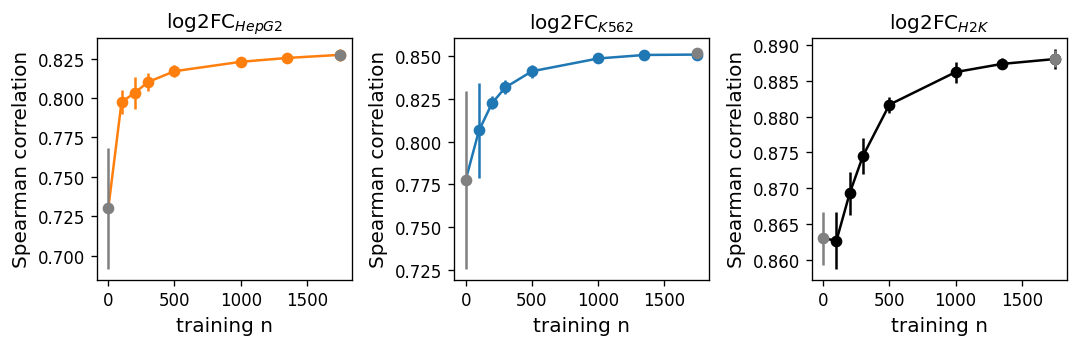

In [117]:
# line plot of mean spearman correlation vs n, with error bars, for HepG2, K562, H2K (1x3 subplots, using tab:orange, tab:blue, and black)

# replace M1 with 1750
n_max = 1750


# plot mean spearman correlation vs n for HepG2, dots with error bars
fig, axs = plt.subplots(1, 3, figsize=(9, 3))

# plot mean spearman correlation vs n for HepG2, dots with error bars
axs[0].errorbar(hepg2_results_df['n'], hepg2_results_df['mean'], yerr=hepg2_results_df['std'], fmt='o-', color='tab:orange')
# hepg2_m0_df = hepg2_results_df[hepg2_results_df['n'] == 0]
# axs[0].errorbar([0], [hepg2_m0_df['mean'].values[0]], yerr=[hepg2_m0_df['std'].values[0]], fmt='o', color='gray', zorder=10)
axs[0].errorbar([0], [r_h_m0_mean], yerr=[r_h_m0_std], fmt='o', color='gray', zorder=10)
# hepg2_m1_df = hepg2_results_df[hepg2_results_df['n'] == 1973]
# axs[0].errorbar([1973], [hepg2_m1_df['mean'].values[0]], yerr=[hepg2_m1_df['std'].values[0]], fmt='o', color='gray', zorder=10)
axs[0].errorbar([n_max], [r_h_m1_mean], yerr=[r_h_m1_std], fmt='o', color='gray', zorder=10)

# draw dashed gray line from n=0 to n=100
axs[0].plot([0,100],[r_h_m0_mean,hepg2_results_df[hepg2_results_df['n']==100]['mean'].values[0]],'-',color='tab:orange',zorder=5)

axs[0].set_xlabel('training n',fontsize=AXIS_FSIZE)
axs[0].set_ylabel('Spearman correlation',fontsize=AXIS_FSIZE)
axs[0].set_title('log2FC$_{HepG2}$')

# set xticks to be every 500
axs[0].set_xticks(np.arange(0,1800,500))

# plot mean spearman correlation vs n for K562, dots with error bars
axs[1].errorbar(k562_results_df['n'], k562_results_df['mean'], yerr=k562_results_df['std'], fmt='o-', color='tab:blue')
# k562_m0_df = k562_results_df[k562_results_df['n'] == 0]
# axs[1].errorbar([0], [k562_m0_df['mean'].values[0]], yerr=[k562_m0_df['std'].values[0]], fmt='o', color='gray', zorder=10)
axs[1].errorbar([0], [r_k_m0_mean], yerr=[r_k_m0_std], fmt='o', color='gray', zorder=10)
# k562_m1_df = k562_results_df[k562_results_df['n'] == 1973]
# axs[1].errorbar([1973], [k562_m1_df['mean'].values[0]], yerr=[k562_m1_df['std'].values[0]], fmt='o', color='gray', zorder=10)

# draw dashed gray line from n=0 to n=100
axs[1].plot([0,100],[r_k_m0_mean,k562_results_df[k562_results_df['n']==100]['mean'].values[0]],'-',color='tab:blue',zorder=5)

axs[1].errorbar([n_max], [r_k_m1_mean], yerr=[r_k_m1_std], fmt='o', color='gray', zorder=10)
axs[1].set_xlabel('training n',fontsize=AXIS_FSIZE)
axs[1].set_ylabel('Spearman correlation',fontsize=AXIS_FSIZE)
axs[1].set_title('log2FC$_{K562}$')

# set xticks to be every 500
axs[1].set_xticks(np.arange(0,1800,500))

# plot mean spearman correlation vs n for H2K, dots with error bars
axs[2].errorbar(h2k_results_df['n'], h2k_results_df['mean'], yerr=h2k_results_df['std'], fmt='o-', color='black')
# h2k_m0_df = h2k_results_df[h2k_results_df['n'] == 0]
# axs[2].errorbar([0], [h2k_m0_df['mean'].values[0]], yerr=[h2k_m0_df['std'].values[0]], fmt='o', color='gray', zorder=10)
axs[2].errorbar([0], [r_h2k_m0_mean], yerr=[r_h2k_m0_std], fmt='o', color='gray', zorder=10)
# h2k_m1_df = h2k_results_df[h2k_results_df['n'] == 1973]
# axs[2].errorbar([1973], [h2k_m1_df['mean'].values[0]], yerr=[h2k_m1_df['std'].values[0]], fmt='o', color='gray', zorder=10)
axs[2].errorbar([n_max], [r_h2k_m1_mean], yerr=[r_h2k_m1_std], fmt='o', color='gray', zorder=10)

# draw dashed gray line from n=0 to n=100
axs[2].plot([0,100],[r_h2k_m0_mean,h2k_results_df[h2k_results_df['n']==100]['mean'].values[0]],'-',color='k',zorder=5)
axs[2].set_xlabel('training n',fontsize=AXIS_FSIZE)
axs[2].set_ylabel('Spearman correlation',fontsize=AXIS_FSIZE)
axs[2].set_title('log2FC$_{H2K}$')

# set xticks to be every 500
axs[2].set_xticks(np.arange(0,1800,500))

plt.tight_layout()


# save the figure in revision_figure_dir

fig.savefig(f'{revision_figure_dir}/nvar_pred_performance_vs_n.png',bbox_inches='tight',dpi=500)

In [131]:
# for each value of n, t-test the difference between this n and the next highest n, for each cell type

from scipy.stats import ttest_ind_from_stats

for cell_type, results_df in zip(['HEPG2','K562','H2K'],[hepg2_results_df,k562_results_df,h2k_results_df]):

    print(cell_type)

    for i in range(results_df.shape[0]-1):
        n1 = results_df['n'].values[i]
        n2 = results_df['n'].values[i+1]

        mean1 = results_df['mean'].values[i]
        mean2 = results_df['mean'].values[i+1]

        std1 = results_df['std'].values[i]
        std2 = results_df['std'].values[i+1]

        t_stat,p_val = ttest_ind_from_stats(mean1,std1,5,mean2,std2,5)

        print(f'\t{n1} vs {n2}, {mean1:.3f}+-{std1:.3f} vs {mean2:.3f}+-{std2:.3f} p={p_val:.1e}')

HEPG2
	100 vs 200, 0.797+-0.007 vs 0.803+-0.010 p=3.3e-01
	200 vs 300, 0.803+-0.010 vs 0.810+-0.006 p=2.3e-01
	300 vs 500, 0.810+-0.006 vs 0.817+-0.004 p=5.8e-02
	500 vs 1000, 0.817+-0.004 vs 0.823+-0.003 p=2.6e-02
	1000 vs 1350, 0.823+-0.003 vs 0.825+-0.003 p=2.6e-01
	1350 vs 1750, 0.825+-0.003 vs 0.827+-0.004 p=3.8e-01
K562
	100 vs 200, 0.807+-0.028 vs 0.823+-0.004 p=2.4e-01
	200 vs 300, 0.823+-0.004 vs 0.832+-0.004 p=6.4e-03
	300 vs 500, 0.832+-0.004 vs 0.841+-0.004 p=5.5e-03
	500 vs 1000, 0.841+-0.004 vs 0.849+-0.002 p=4.5e-03
	1000 vs 1350, 0.849+-0.002 vs 0.851+-0.002 p=1.2e-01
	1350 vs 1750, 0.851+-0.002 vs 0.851+-0.003 p=8.9e-01
H2K
	100 vs 200, 0.863+-0.004 vs 0.869+-0.003 p=1.7e-02
	200 vs 300, 0.869+-0.003 vs 0.875+-0.002 p=1.7e-02
	300 vs 500, 0.875+-0.002 vs 0.882+-0.001 p=3.6e-04
	500 vs 1000, 0.882+-0.001 vs 0.886+-0.001 p=6.0e-04
	1000 vs 1350, 0.886+-0.001 vs 0.887+-0.001 p=1.6e-01
	1350 vs 1750, 0.887+-0.001 vs 0.888+-0.001 p=3.6e-01


In [118]:
# generate a design_df that compares the sequences between different boot indices for multiple values of n or target_weight

results_basename = 'revision_scripts/nvar_model_dir_cf10_rotate_final/'
target_weight = 1
# cur_n = 1000
n_vals = ['M0',100,200,300,500,1000,1350,1750,'M1']
# n_vals = ['M0',100,200,300,500,1000,1350,1708]
# n_vals = ['M0',1708]
boots = [0,1,2,3,4]

design_df = pd.DataFrame()

for boot_idx in boots:

    for cur_n in n_vals:

        results_dir = f'{results_basename}/designs_boot{boot_idx}_seed99'
        # results_dir = f'{results_basename}/designs'

        for cell_type in ['HEPG2','K562']:
            # load in the fasta file
            # cur_fasta = f'{results_dir}/designed.h5_ft_n{cur_n}_boot_fsp_{cell_type}_seqs.fasta'
            cur_fasta = f'{results_dir}/target{target_weight}/designed_ft_n{cur_n}_fsp_{cell_type}_seqs.fasta'
            # cur_fasta = f'{results_dir}/target{target_weight}/designed.h5_ft_n{cur_n}_fsp_{cell_type}_seqs.fasta'
            # cur_fasta = f'{results_dir}/designed_fsp_{cell_type}_n{cur_n}_seqs.fasta'
            # load in the fasta file using SeqIO
            cur_df = pd.DataFrame(columns=['sequence'])
            with open(cur_fasta) as fasta_file:
                for record in SeqIO.parse(fasta_file,'fasta'):
                    cur_df = pd.concat([cur_df,pd.DataFrame([[str(record.seq)]],columns=['sequence'])])

            # for compatibility with previous plotting code, pretend target_weight = n
            cur_df['n'] = cur_n
            cur_df['boot'] = boot_idx
            cur_df['cell_type'] = cell_type
            # take only the top 50 sequences
            # cur_df = cur_df.head(50)
            design_df = pd.concat([design_df,cur_df],ignore_index=True)

# load in M2 models

design_df = predict_on_designs(design_df)
# replace all NaN in boot with -1
design_df['boot'] = design_df['boot'].fillna(-1)

282/282 [==============================] - 31s 105ms/step


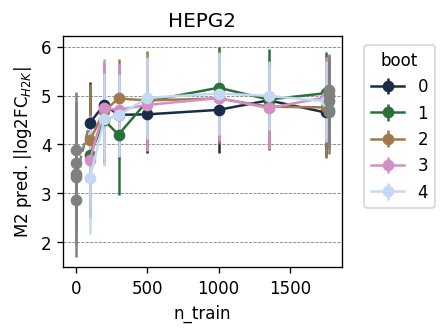

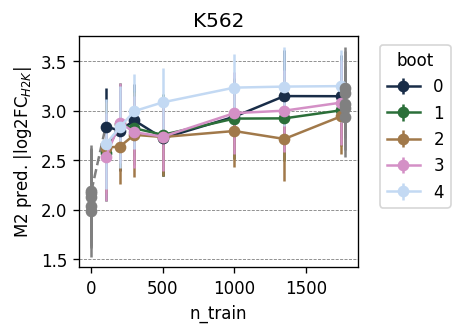

In [119]:
# line plot of mean spearman correlation vs n, with error bars, for HepG2, K562, H2K (1x3 subplots, using tab:orange, tab:blue, and black)

n_seqs = 1
nvar_m0 = 0
nvar_m1 = 1775
xlabel = 'n_train'
H2K_PRED_COL 

# set boot col as int
design_df['boot'] = design_df['boot'].astype(int)

n_boots = design_df['boot'].nunique()
# create palette for each value of boot
palette = sns.color_palette('cubehelix',n_boots)
# palette.insert(0,'tab:gray')

for cell_type in ['HEPG2','K562']:

    cur_analysis_df = design_df[design_df['cell_type']==cell_type].copy()
    cur_analysis_df[H2K_PRED_COL] = np.abs(cur_analysis_df[H2K_PRED_COL])

    m0_df = cur_analysis_df[cur_analysis_df['n']=='M0'].copy()
    m1_df = cur_analysis_df[cur_analysis_df['n']=='M1'].copy()
    # replace 'M0' with 0 in m0_df['n']
    m0_df['n'] = nvar_m0
    # replace 'M1' with 1974 in m1_df['n']
    m1_df['n'] = nvar_m1
    cur_analysis_df = cur_analysis_df[~cur_analysis_df['n'].isin(['M0','M1'])]

    # plot mean and standard deviation of H2K_PRED_COL by n, with boot = hue, use plt.errorbar
    mean_df = cur_analysis_df.groupby(['n','boot'])[H2K_PRED_COL].mean().reset_index()
    std_df = cur_analysis_df.groupby(['n','boot'])[H2K_PRED_COL].std().reset_index()

    # mean_m0_df = m0_df.groupby('n')[H2K_PRED_COL].mean().reset_index()
    # std_m0_df = m0_df.groupby('n')[H2K_PRED_COL].std().reset_index()
    mean_m0_df = m0_df.groupby(['n','boot'])[H2K_PRED_COL].mean().reset_index()
    std_m0_df = m0_df.groupby(['n','boot'])[H2K_PRED_COL].std().reset_index()

    # mean_m1_df = m1_df.groupby('n')[H2K_PRED_COL].mean().reset_index()
    # std_m1_df = m1_df.groupby('n')[H2K_PRED_COL].std().reset_index()
    mean_m1_df = m1_df.groupby(['n','boot'])[H2K_PRED_COL].mean().reset_index()
    std_m1_df = m1_df.groupby(['n','boot'])[H2K_PRED_COL].std().reset_index()

    # line plot of mean spearman correlation
    plt.figure(figsize=(3,2.5))
    for i,cur_boot in enumerate(mean_df['boot'].unique()):
        cur_boot_df = mean_df[mean_df['boot']==cur_boot]
        cur_std_df = std_df[std_df['boot']==cur_boot]
        plt.errorbar(cur_boot_df['n'],cur_boot_df[H2K_PRED_COL],yerr=cur_std_df[H2K_PRED_COL]/np.sqrt(n_seqs),fmt='o-',color=palette[i])

    # also plot m0 and m1 in gray
    plt.errorbar(mean_m0_df['n'],mean_m0_df[H2K_PRED_COL],yerr=std_m0_df[H2K_PRED_COL]/np.sqrt(n_seqs),fmt='o-',color='gray')
    plt.errorbar(mean_m1_df['n'],mean_m1_df[H2K_PRED_COL],yerr=std_m1_df[H2K_PRED_COL]/np.sqrt(n_seqs),fmt='o-',color='gray')

    plt.legend(mean_df['boot'].unique(),title='boot',bbox_to_anchor=(1.05, 1), loc='upper left')

    # draw blue line between 0 and cur_analysis_df['n'].min()
    plt.plot([nvar_m0,cur_analysis_df['n'].min()],[mean_m0_df[H2K_PRED_COL].values[0],mean_df[H2K_PRED_COL].values[0]],color='tab:gray',linestyle='--')
    # draw blue line between cur_analysis_df['n'].max() and nvar_m1
    plt.plot([cur_analysis_df['n'].max(),nvar_m1],[mean_df[H2K_PRED_COL].values[-1],mean_m1_df[H2K_PRED_COL].values[0]],color='tab:gray',linestyle='--')

    plt.xlabel(xlabel)
    plt.ylabel('M2 pred. |log2FC$_{H2K}$|')
    plt.title(f'{cell_type}')

    # add gridlines
    plt.grid(axis='y',color='gray',linestyle='--',linewidth=0.5)

    # add legend
    

    # mean_df = cur_analysis_df.groupby('n')[H2K_PRED_COL].mean().reset_index()
    # std_df = cur_analysis_df.groupby('n')[H2K_PRED_COL].std().reset_index()

    # # line plot of mean spearman correlation
    # plt.figure(figsize=(3,2.5))
    # plt.errorbar(mean_df['n'],mean_df[H2K_PRED_COL],yerr=std_df[H2K_PRED_COL]/np.sqrt(n_seqs),fmt='o-')
    # plt.xlabel(xlabel)
    # plt.ylabel('|log2FC$_{H2K}$|')
    # plt.title(f'{cell_type}')

    # also plot m0 and m1 in gray
    # plt.errorbar(mean_m0_df['n'],mean_m0_df[H2K_PRED_COL],yerr=std_m0_df[H2K_PRED_COL]/np.sqrt(n_seqs),fmt='o-',color='gray')
    # plt.errorbar(mean_m1_df['n'],mean_m1_df[H2K_PRED_COL],yerr=std_m1_df[H2K_PRED_COL]/np.sqrt(n_seqs),fmt='o-',color='gray')

    # # draw blue line between 0 and cur_analysis_df['n'].min()
    # plt.plot([nvar_m0,cur_analysis_df['n'].min()],[mean_m0_df[H2K_PRED_COL].values[0],mean_df[H2K_PRED_COL].values[0]],color='tab:blue')
    # # draw blue line between cur_analysis_df['n'].max() and nvar_m1
    # plt.plot([cur_analysis_df['n'].max(),nvar_m1],[mean_df[H2K_PRED_COL].values[-1],mean_m1_df[H2K_PRED_COL].values[0]],color='tab:blue')

    # # add gridlines
    # plt.grid(axis='y',color='gray',linestyle='--',linewidth=0.5)



############################## okay: want standard deviation of the MEANS from each bootstrap

In [ ]:
cell_type = 'HEPG2'
cur_analysis_df = design_df[design_df['cell_type']==cell_type].copy()
cur_analysis_df[H2K_PRED_COL] = np.abs(cur_analysis_df[H2K_PRED_COL])

m0_df = cur_analysis_df[cur_analysis_df['n']=='M0'].copy()
m1_df = cur_analysis_df[cur_analysis_df['n']=='M1'].copy()
# replace 'M0' with 0 in m0_df['n']
m0_df['n'] = nvar_m0
# replace 'M1' with 1974 in m1_df['n']
m1_df['n'] = nvar_m1
cur_analysis_df = cur_analysis_df[~cur_analysis_df['n'].isin(['M0','M1'])]

# create df with mean of means across boot for each n
mean_df = cur_analysis_df.groupby(['n','boot'])[H2K_PRED_COL].mean().reset_index()

In [157]:
mean_df.groupby('n')[H2K_PRED_COL].mean()

n
100     2.774813
200     2.852869
300     2.836321
500     2.922456
1000    3.049937
1350    3.218163
1708    3.268159
Name: pred_log2FC_H2K, dtype: float32

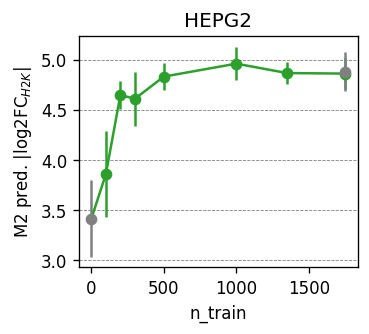

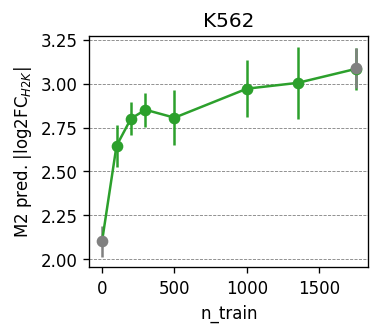

In [137]:
# line plot of mean spearman correlation vs n, with error bars, for HepG2, K562, H2K (1x3 subplots, using tab:orange, tab:blue, and black)
# this versino should shown mean of means and standard deviation of means across bootstraps

n_seqs = 1
nvar_m0 = 0
nvar_m1 = 1750
xlabel = 'n_train'
H2K_PRED_COL 

# set boot col as int
design_df['boot'] = design_df['boot'].astype(int)

mean_mean_dfs = {'HEPG2':None,'K562':None}
std_mean_dfs = {'HEPG2':None,'K562':None}


for cell_type in ['HEPG2','K562']:

    cur_analysis_df = design_df[design_df['cell_type']==cell_type].copy()
    cur_analysis_df[H2K_PRED_COL] = np.abs(cur_analysis_df[H2K_PRED_COL])

    m0_df = cur_analysis_df[cur_analysis_df['n']=='M0'].copy()
    m1_df = cur_analysis_df[cur_analysis_df['n']=='M1'].copy()
    # replace 'M0' with 0 in m0_df['n']
    m0_df['n'] = nvar_m0
    # replace 'M1' with 1974 in m1_df['n']
    m1_df['n'] = nvar_m1
    cur_analysis_df = cur_analysis_df[~cur_analysis_df['n'].isin(['M0','M1'])]

    # create df with mean of means across boot for each n
    mean_df = cur_analysis_df.groupby(['n','boot'])[H2K_PRED_COL].mean().reset_index()

    # plot mean and standard deviation of H2K_PRED_COL by n, with boot = hue, use plt.errorbar
    mean_mean_df = mean_df.groupby('n')[H2K_PRED_COL].mean().reset_index()
    std_mean_df = mean_df.groupby('n')[H2K_PRED_COL].std().reset_index()

    # mean_m0_df = m0_df.groupby('n')[H2K_PRED_COL].mean().reset_index()
    # std_m0_df = m0_df.groupby('n')[H2K_PRED_COL].std().reset_index()

    # mean_m1_df = m1_df.groupby('n')[H2K_PRED_COL].mean().reset_index()
    # std_m1_df = m1_df.groupby('n')[H2K_PRED_COL].std().reset_index()

    mean_m0_df = m0_df.groupby(['n','boot'])[H2K_PRED_COL].mean().reset_index()
    std_m0_df = m0_df.groupby(['n','boot'])[H2K_PRED_COL].std().reset_index()
    mean_mean_m0_df = mean_m0_df.groupby('n')[H2K_PRED_COL].mean().reset_index()
    std_mean_m0_df = mean_m0_df.groupby('n')[H2K_PRED_COL].std().reset_index()

    mean_m1_df = m1_df.groupby(['n','boot'])[H2K_PRED_COL].mean().reset_index()
    std_m1_df = m1_df.groupby(['n','boot'])[H2K_PRED_COL].std().reset_index()
    mean_mean_m1_df = mean_m1_df.groupby('n')[H2K_PRED_COL].mean().reset_index()
    std_mean_m1_df = mean_m1_df.groupby('n')[H2K_PRED_COL].std().reset_index()

    mean_mean_dfs[cell_type] = mean_mean_df
    std_mean_dfs[cell_type] = std_mean_df

    # line plot of mean spearman correlation
    plt.figure(figsize=(3,2.5))
    plt.errorbar(mean_mean_df['n'],mean_mean_df[H2K_PRED_COL],yerr=std_mean_df[H2K_PRED_COL],fmt='o-',color='tab:green')

    # also plot m0 and m1 in gray
    # plt.errorbar(mean_m0_df['n'],mean_m0_df[H2K_PRED_COL],yerr=std_m0_df[H2K_PRED_COL],fmt='o-',color='gray')
    # plt.errorbar(mean_m1_df['n'],mean_m1_df[H2K_PRED_COL],yerr=std_m1_df[H2K_PRED_COL],fmt='o-',color='gray')
    plt.errorbar(mean_mean_m0_df['n'],mean_mean_m0_df[H2K_PRED_COL],yerr=std_mean_m0_df[H2K_PRED_COL],fmt='o-',color='gray')
    plt.errorbar(mean_mean_m1_df['n'],mean_mean_m1_df[H2K_PRED_COL],yerr=std_mean_m1_df[H2K_PRED_COL],fmt='o-',color='gray')

    plt.xlabel(xlabel)
    plt.ylabel('M2 pred. |log2FC$_{H2K}$|')
    plt.title(f'{cell_type}')

    # add gridlines
    plt.grid(axis='y',color='gray',linestyle='--',linewidth=0.5)

    
    # draw blue line between 0 and cur_analysis_df['n'].min()
    plt.plot([nvar_m0,cur_analysis_df['n'].min()],[mean_mean_m0_df[H2K_PRED_COL].values[0],mean_mean_df[H2K_PRED_COL].values[0]],color='tab:green',linestyle='-')
    # draw blue line between cur_analysis_df['n'].max() and nvar_m1
    plt.plot([cur_analysis_df['n'].max(),nvar_m1],[mean_mean_df[H2K_PRED_COL].values[-1],mean_mean_m1_df[H2K_PRED_COL].values[0]],color='tab:green',linestyle='-')

    # save the figure in revision_figure_dir
    plt.savefig(f'{revision_figure_dir}/nvar_design_performance_vs_n_{cell_type}_mean_of_means.png',bbox_inches='tight',dpi=500)

In [136]:
mean_mean_df

n  pred_log2FC_H2K
0   100         2.645656
1   200         2.801253
2   300         2.851086
3   500         2.805953
4  1000         2.971374
5  1350         3.004457
6  1750         3.083887

In [138]:
# for each value of n, t-test the difference between this n and the next highest n, for each cell type

from scipy.stats import ttest_ind_from_stats

n_comps = [[200,1750],
           [300,1750],
           [500,1750],
           [1000,1750],
           [1350,1750]]

for cell_type in ['HEPG2','K562']:
    print(cell_type)
    # for i in range(mean_mean_df.shape[0]-1):

    mean_mean_df = mean_mean_dfs[cell_type]
    std_mean_df = std_mean_dfs[cell_type]

    for n_comp in n_comps:
        # n1 = mean_mean_df['n'].values[i]
        # n2 = mean_mean_df['n'].values[i+1]
        # mean1 = mean_mean_df[H2K_PRED_COL].values[i]
        # mean2 = mean_mean_df[H2K_PRED_COL].values[i+1]

        n1,n2 = n_comp
        mean1 = mean_mean_df[mean_mean_df['n']==n1][H2K_PRED_COL].values[0]
        mean2 = mean_mean_df[mean_mean_df['n']==n2][H2K_PRED_COL].values[0]

        std1 = std_mean_df[std_mean_df['n']==n1][H2K_PRED_COL].values[0]
        std2 = std_mean_df[std_mean_df['n']==n2][H2K_PRED_COL].values[0]

        t_stat,p_val = ttest_ind_from_stats(mean1,std1,5,mean2,std2,5)

        print(f'\t{n1} vs {n2}, {mean1:.2f}+-{std1:.2f} vs {mean2:.2f}+-{std2:.2f} p={p_val:.1e}')

HEPG2
	200 vs 1750, 4.65+-0.14 vs 4.86+-0.16 p=5.4e-02
	300 vs 1750, 4.61+-0.27 vs 4.86+-0.16 p=1.1e-01
	500 vs 1750, 4.83+-0.13 vs 4.86+-0.16 p=7.5e-01
	1000 vs 1750, 4.96+-0.17 vs 4.86+-0.16 p=3.6e-01
	1350 vs 1750, 4.87+-0.11 vs 4.86+-0.16 p=9.5e-01
K562
	200 vs 1750, 2.80+-0.10 vs 3.08+-0.12 p=3.3e-03
	300 vs 1750, 2.85+-0.10 vs 3.08+-0.12 p=9.5e-03
	500 vs 1750, 2.81+-0.16 vs 3.08+-0.12 p=1.3e-02
	1000 vs 1750, 2.97+-0.16 vs 3.08+-0.12 p=2.4e-01
	1350 vs 1750, 3.00+-0.20 vs 3.08+-0.12 p=4.7e-01


### R3.2 - retraining on perturbation data??? ###

In [127]:

# okay, let's generate a training dataset from the perturbation sequences!

# d3_seq_df['design_type'].value_counts()

# design_type I want is ablated (331 sequences), shuffled_nonmotif (49 sequences), nonmotif_masked_fsp (100 sequences)
# a total of 480 sequences. I can do 5-way splits, so 96 sequences per split = 96 val, 384 train
# question though: I have to make crossfolds based on originating sequences for the train/val splits. I guess that sort of works out, given that I have 10 sequences.
# okay let's do that
# but I guess I will need to manually create the folds since they will have different numbers of sequences in the ablations
# let's just do top and bottom matching...well actually what I should do is one cell type of each kind
# maybe it's okay since I'm ensembling in the end, I don't like that only 60 seqs appear in some of the cell type-balanced cf splits
# cfs = [[1099,1041],
#        [156,976],
#        [905,335],
#        [762,633],
#        [667,433]]
cfs = [[1099,335],
       [156,633],
       [762,433],
       [976,667],
       [1041,905]]


design_types = ['ablated','shuffled_nonmotif','nonmotif_masked_fsp','d2_top_ctrl']
analysis_df = d3_seq_df[(d3_seq_df['design_type'].isin(design_types)) & (d3_seq_df['model_type']!='dhs64_finetuned')].copy()
analysis_df['model_type'].value_counts()

# create og_seq col
# extract original sequence index from sequence name
analysis_df.loc[analysis_df['design_type']=='nonmotif_masked_fsp','og_seq_idx'] = analysis_df.loc[analysis_df['design_type']=='nonmotif_masked_fsp','sequence_name'].apply(lambda x: int(x.split('_')[-3][3:]))
analysis_df.loc[analysis_df['design_type']=='shuffled_nonmotif','og_seq_idx'] = analysis_df.loc[analysis_df['design_type']=='shuffled_nonmotif','sequence_name'].apply(lambda x: int(x.split('_')[0]))
analysis_df.loc[analysis_df['design_type']=='ablated','og_seq_idx'] = analysis_df.loc[analysis_df['design_type']=='ablated','sequence_name'].apply(lambda x: int(x.split('_')[0]))
analysis_df.loc[analysis_df['design_type']=='d2_top_ctrl','og_seq_idx'] = analysis_df.loc[analysis_df['design_type']=='d2_top_ctrl','sequence_name'].apply(lambda x: int(x.split('_')[-1]))

# analysis_df['og_seq_idx'] = analysis_df['sequence_name'].apply(lambda x: int(x.split('_')[0]))
# set og_seq_idx to int
analysis_df['og_seq_idx'] = analysis_df['og_seq_idx'].astype(int)

analysis_df['og_seq_idx'].value_counts()
n_perturb_seqs = analysis_df.shape[0]
print(n_perturb_seqs)


perturb_cf_dir = 'perturb_cfs'
# if it doesn't exist create it
if not os.path.isdir(perturb_cf_dir):
    os.makedirs(perturb_cf_dir)

for cf_idx,cf in enumerate(cfs):
    cur_analysis_df = analysis_df[analysis_df['og_seq_idx'].isin(cf)].copy()
    print(cur_analysis_df.shape[0]) # not perfect but relatively well matched
    # save the sequence to a npy file
    x_cf = np.stack(cur_analysis_df['sequence'].apply(seq_to_one_hot).values)
    y_cf = cur_analysis_df[[HEPG2_COL,K562_COL]].values
    # save the x_cf to a npy file
    np.save(f'{perturb_cf_dir}/x_cf{cf_idx}.npy',x_cf)
    np.save(f'{perturb_cf_dir}/y_cf{cf_idx}.npy',y_cf)

490
133
113
95
66
82


In [150]:
analysis_df[analysis_df['cell_type']=='HEPG2'][H2K_COL].describe()

count    206.000000
mean       4.864439
std        1.425605
min        0.153038
25%        3.859420
50%        5.070864
75%        6.044128
max        7.347700
Name: log2FoldChange_H2K, dtype: float64

In [151]:
### Alt version of generating R2 training splits: sample randomly, don't extract "top" enhancers ###

# Okay, now I need 480 sequences of top enhancers from the non-perturbation data.
# I already have 9 crossfolds of data for this, so I can just take 96 sequences total for 5 cf splits - but I know from prior analysis this will not likely be enough
# I do want to also exclude the d2_top_ctrl sequences since these are what the perturbations are based on

design_types = ['fsp','fsp_clipped']
model_types = ['d1_finetuned','d2_dhs']
analysis_df = d3_seq_df[(d3_seq_df['design_type'].isin(design_types)) & (d3_seq_df['model_type'].isin(model_types))].copy()

# exclude d2 sequences since those were used in training previous round?
test_model_types = ['d1_finetuned','d2_dhs','D2','shuffled']
test_design_types = ['fsp_tgt','fsp_max1','fsp_min1','fsp_clipped_max1','fsp_clipped_min1']
test_df = d3_seq_df[(d3_seq_df['design_type'].isin(test_design_types)) & (d3_seq_df['model_type'].isin(test_model_types))].copy()


hepg2_df = analysis_df[analysis_df['cell_type']=='HEPG2'].copy()
k562_df = analysis_df[analysis_df['cell_type']=='K562'].copy()

# randomly sample 240 sequences per cell type from the analysis_df, then split into 5 crossfolds
# the rest of the sequences should go into test set
rand_seed = 13
rng = np.random.default_rng(rand_seed)

n_perturb_seqs = 240

hepg2_inds = rng.choice(hepg2_df.shape[0],n_perturb_seqs,replace=False)
hepg2_test_inds = np.setdiff1d(np.arange(hepg2_df.shape[0]),hepg2_inds)

k562_inds = rng.choice(k562_df.shape[0],n_perturb_seqs,replace=False)
k562_test_inds = np.setdiff1d(np.arange(k562_df.shape[0]),k562_inds)

hepg2_top_df = hepg2_df.iloc[hepg2_inds].copy()
k562_top_df = k562_df.iloc[k562_inds].copy()

test_df = pd.concat([test_df,hepg2_df.iloc[hepg2_test_inds],k562_df.iloc[k562_test_inds]],ignore_index=True)
x_test = np.stack(test_df['sequence'].apply(seq_to_one_hot).values)
y_test = test_df[[HEPG2_COL,K562_COL]].values


x_hepg2 = np.stack(hepg2_top_df['sequence'].apply(seq_to_one_hot).values)
y_hepg2 = hepg2_top_df[[HEPG2_COL,K562_COL]].values

x_k562 = np.stack(k562_top_df['sequence'].apply(seq_to_one_hot).values)
y_k562 = k562_top_df[[HEPG2_COL,K562_COL]].values

# randomly split both hepg2_top_df and k562_top_df into 5 crossfolds

n_cfs = 5

# split hepg2_top_df into 5 crossfolds
cf_inds = np.arange(n_perturb_seqs)
rng.shuffle(cf_inds)
cf_inds = np.array_split(cf_inds,n_cfs)

top_enhancer_cf_dir = 'revision_scripts/R3_2/top_enhancer_cfs'
# if it doesn't exist create it
os.makedirs(top_enhancer_cf_dir,exist_ok=True)

for cf_idx,cf in enumerate(cf_inds):
    
        # concatenate with the k562 data
        x_cf = np.vstack([x_hepg2[cf],x_k562[cf]])
        y_cf = np.vstack([y_hepg2[cf],y_k562[cf]])
    
        np.save(f'{top_enhancer_cf_dir}/x_cf{cf_idx}.npy',x_cf)
        np.save(f'{top_enhancer_cf_dir}/y_cf{cf_idx}.npy',y_cf)

# save test set
np.save(f'{top_enhancer_cf_dir}/x_test.npy',x_test)
np.save(f'{top_enhancer_cf_dir}/y_test.npy',y_test)


# # okay this is now 5 * 98 cfs, so 490 sequences total - what is the evaluation test set??? I guess I can do all the sequences that were used to train neither of these.
# # okay in that case I should exclude minimal enhancers since I won't be finetuning the perturb seqs on minimal enhancers
# for cf_idx,cf in enumerate(cf_inds):

#     # concatenate with the k562 data
#     x_cf = np.vstack([x_hepg2[cf],x_k562[cf]])
#     y_cf = np.vstack([y_hepg2[cf],y_k562[cf]])

#     np.save(f'{top_enhancer_cf_dir}/x_cf{cf_idx}.npy',x_cf)
#     np.save(f'{top_enhancer_cf_dir}/y_cf{cf_idx}.npy',y_cf)

# # now take the remaining sequences from hepg2_df and k562_df, and save as the test set
# hepg2_test_df = hepg2_df.iloc[n_perturb_seqs//2:].copy()
# k562_test_df = k562_df.iloc[n_perturb_seqs//2:].copy()

# x_hepg2_test = np.stack(hepg2_test_df['sequence'].apply(seq_to_one_hot).values)
# y_hepg2_test = hepg2_test_df[[HEPG2_COL,K562_COL]].values

# x_k562_test = np.stack(k562_test_df['sequence'].apply(seq_to_one_hot).values)
# y_k562_test = k562_test_df[[HEPG2_COL,K562_COL]].values

# # save the test set
# np.save(f'{top_enhancer_cf_dir}/x_test.npy',np.vstack([x_hepg2_test,x_k562_test]))
# np.save(f'{top_enhancer_cf_dir}/y_test.npy',np.vstack([y_hepg2_test,y_k562_test]))


In [330]:
# okay, I have these models trained, now I have to do the next thing which is make predictions on the held-out data

excluded_design_types = ['ablated','shuffled_nonmotif','nonmotif_masked_fsp','motif_flank_opt','fsp_minimal_concatemer','concatemer']
excluded_model_types = ['dhs64_finetuned','dhs62_finetuned','sabetti_ctrl']
analysis_df = d3_seq_df[(~d3_seq_df['design_type'].isin(excluded_design_types)) & (~d3_seq_df['model_type'].isin(excluded_model_types))].copy()


x_test = np.stack(analysis_df['sequence'].apply(seq_to_one_hot_and_pad).values)
print(x_test.shape)
y_test = analysis_df[[HEPG2_COL,K562_COL,H2K_COL]].values

(1262, 200, 4)


In [112]:
# generate perturb-trained model predictions on new test set

# now load the fully finetuned models to confirm this is better than all the others
cf_model_dir = 'revision_scripts/R3_2/perturb_ft_models'
results_basename = 'perturb_cfs_results'
model_basename = 'd1_wide_ft_cf_t0_v'
model_suffix = '_perturb_cf'

# load and pad test set
test_dir = 'revision_scripts/R3_2/'
x_test = np.load(f'{test_dir}/x_test.npy')
y_test = np.load(f'{test_dir}/y_test.npy')

# padd to 200 bp, also extract only the d1 columns
lpad = (200-145)//2
rpad = 200 - 145 - lpad
x_test = np.pad(x_test,((0,0),(lpad, rpad),(0,0)))

# load unfinetuned model and get predictions to append to the results_dfs in the next cell
# import load_model function
from tensorflow.keras.models import load_model
model_inds = [1,2,3,4,5,6,7,8,9,9]
cf_inds    = [0,1,1,2,2,3,3,4,4,0]

for model_idx,cf_idx in zip(model_inds,cf_inds):

    K.clear_session()
    model = load_model(f'{cf_model_dir}/{model_basename}{model_idx}{model_suffix}{cf_idx}.h5')

    y_test_hat = model.predict(x_test)

    metrics = ['pearsonr','spearmanr']
    for corr_idx,corr in enumerate([pearsonr,spearmanr]):
        r_h_d2   = corr(y_test[:,0],y_test_hat[:,0])[0]
        r_k_d2   = corr(y_test[:,1],y_test_hat[:,1])[0]
        r_h2k_d2   = corr(y_test[:,0]-y_test[:,1],y_test_hat[:,0]-y_test_hat[:,1])[0]
    
        # print results to text file
        with open(f'{cf_model_dir}/{results_basename}_{metrics[corr_idx]}.txt', 'a') as f:
            # write the hyperparameters for this model
            f.write(f'{r_h_d2:.3f},{r_k_d2:.3f},{r_h2k_d2:.3f}\n')

14/14 [==============================] - 0s 11ms/step


In [108]:
# oh I also need the unfinetuned models!!!!!!!!! I guess I can do that here in this notebook and then just save the predictions

save_dir = 'd2_finetuned'
# results_basename = 'unfinetuned_results'
# model_suffix = ''

# load the M0 ensemble model
# cf_model_dir = '../../aws/for_aws/sequencing_analysis/retraining/retrained_models/cf10/test_fold_0/d1_finetuned'
# model_basename = f'd1_wide_ft_cf_t0_v'
# model_name = f'{cf_model_dir}/{model_basename}.h5'

# now load the fully finetuned models to confirm this is better than all the others
cf_model_dir = 'd2_finetuned/test_fold_0/d3_tot'
results_basename = 'd3_tot_results'
model_basename = 'd1_wide_ft_cf_t0_v'
model_suffix = '_d2_ft'


# load unfinetuned model and get predictions to append to the results_dfs in the next cell
# import load_model function
from tensorflow.keras.models import load_model
model_inds = np.arange(1,10)

for model_idx in model_inds:

    K.clear_session()
    model = load_model(f'{cf_model_dir}/{model_basename}{model_idx}{model_suffix}.h5')

    y_test_hat = model.predict(x_test)

    metrics = ['pearsonr','spearmanr']
    for corr_idx,corr in enumerate([pearsonr,spearmanr]):
        r_h_d2   = corr(y_test[:,0],y_test_hat[:,0])[0]
        r_k_d2   = corr(y_test[:,1],y_test_hat[:,1])[0]
        r_h2k_d2   = corr(y_test[:,0]-y_test[:,1],y_test_hat[:,0]-y_test_hat[:,1])[0]
    
        # print results to text file
        with open(f'{save_dir}/{results_basename}_{metrics[corr_idx]}.txt', 'a') as f:
            # write the hyperparameters for this model
            f.write(f'{r_h_d2:.3f},{r_k_d2:.3f},{r_h2k_d2:.3f}\n')

# okay well I confirmed that finetuning on all the d3 data does a lot better on this test set, which makes sense because this test set is included in that training data

14/14 [==============================] - 0s 12ms/step


C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\1035585240.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels,fontsize=TEXT_FSIZE)


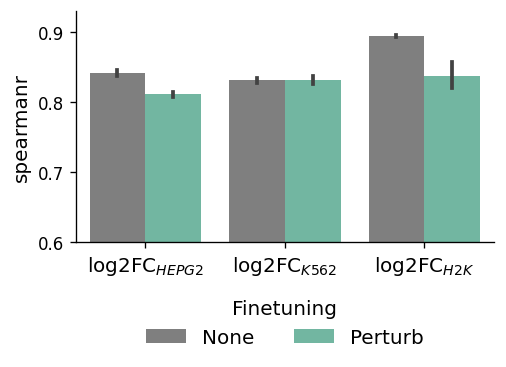

In [132]:
# okay I want to load in the different result files now

TEXT_FSIZE = 12

corr = 'spearmanr'

# results_fnames = [
#     f'd2_finetuned/unfinetuned_results_{corr}.txt',
#     f'd2_finetuned/perturb_ft_models/perturb_cfs_results_{corr}.txt',
#     f'd2_finetuned/top_enhancer_ft_models_bnorm/top_enhancer_cfs_results_bnorm_{corr}.txt',
# ]

results_fnames = [
    f'd2_finetuned/unfinetuned_results_{corr}.txt',
    f'revision_scripts/R3_2/perturb_ft_models/perturb_cfs_results_{corr}.txt',
    f'revision_scripts/R3_2/top_enhancer_ft_models/top_enhancer_cfs_results_{corr}.txt',
]

model_names = ['None','Perturb','Top Enhancer']

results_df = pd.DataFrame()

for results_fname,model_name in zip(results_fnames,model_names):
    df = pd.read_csv(results_fname,header=None)
    df.columns = ['HEPG2','K562','H2K']
    df['model'] = model_name
    results_df = pd.concat([results_df,df])

# barplot of pearson correlations grouped by model
results_df = results_df.melt(id_vars=['model'],value_vars=['HEPG2','K562','H2K'])
results_df.columns = ['model','cell_line','corr']


palette = {
    'None': 'tab:gray',
    'Perturb': sns.color_palette("Set2")[0],
    'Top Enhancer': sns.color_palette("Set2")[1]
}

fig, ax = plt.subplots(figsize=(4.5,2.5))
order = ['HEPG2','K562','H2K']
xtick_labels = ['log2FC$_{HEPG2}$','log2FC$_{K562}$','log2FC$_{H2K}$']
ax = sns.barplot(x='cell_line',y='corr',hue='model',data=results_df[results_df['model']!='Top Enhancer'],order=order,palette=palette)
ax.set_xticklabels(xtick_labels,fontsize=TEXT_FSIZE)
ax.set_xlabel('')
ax.set_ylabel(f'{corr}',fontsize=TEXT_FSIZE)
ax.set_title('')

# despine
sns.despine()

# set lower ylim to 0.6
ax.set_ylim(0.6,0.93)

# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
legend_labels = ['M0','M0+1','M1']
legend_title = 'Finetuning'
plt.legend(bbox_to_anchor=(0.5, -0.35), loc='center', ncol=3,frameon=False,fontsize=TEXT_FSIZE,title=legend_title,title_fontsize=TEXT_FSIZE)
# move x axis label down
ax.xaxis.labelpad = 10

Text(0.5, 0, 'log2FC$_{H2K}$')

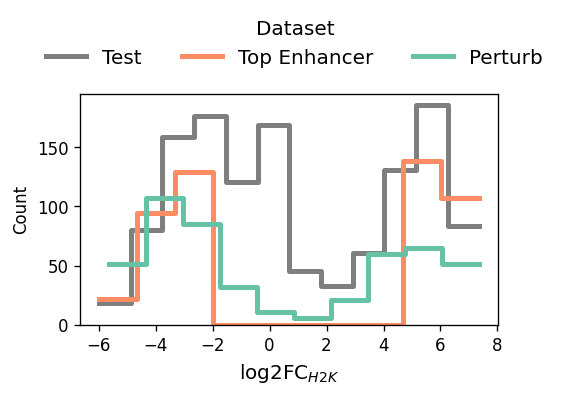

In [436]:
# plot histogram of y_test[:,0] - y_test[:,1], using element=step and no fill

# calculate the difference
y_test_h2k = y_test[:,0] - y_test[:,1]

fig, ax = plt.subplots(figsize=(4.5,2.5))
sns.histplot(y_test_h2k,element='step',fill=False,ax=ax,color='tab:gray',linewidth=3)

# combine y_hepg2_test and y_k562_test, then plot h2k hist
y_top_enhancer = np.concatenate([y_hepg2,y_k562])
sns.histplot(y_top_enhancer[:,0]-y_top_enhancer[:,1],element='step',fill=False,ax=ax,color=sns.color_palette("Set2")[1],linewidth=3)

# I guess also plot the perturb data
# load the y_cfs from perturb_cf_dir
y_cfs = [np.load(f'{perturb_cf_dir}/y_cf{cf_idx}.npy') for cf_idx in range(5)]
y_perturb = np.vstack([y_cfs[i] for i in range(5)])
sns.histplot(y_perturb[:,0]-y_perturb[:,1],element='step',fill=False,ax=ax,color=sns.color_palette("Set2")[0],linewidth=3)

# legend, plot below x axis
legend_labels = ['Test','Top Enhancer','Perturb']
legend_title = 'Dataset'
plt.legend(legend_labels,title=legend_title,loc='upper right',bbox_to_anchor=(1.15, 1.4),ncols=3,
           frameon=False,fontsize=TEXT_FSIZE,title_fontsize=TEXT_FSIZE)

# label x and y axes
ax.set_xlabel('log2FC$_{H2K}$',fontsize=TEXT_FSIZE)



In [8]:
# okay, do a t-test to see if the perturb models are significantly different from the top enhancer models on each cell line
from scipy.stats import ttest_ind

print('Peturbed vs Top Enhancer')

for cell_line in ['HEPG2','K562','H2K']:
    perturb_vals = results_df[(results_df['model']=='Perturb') & (results_df['cell_line']==cell_line)]['corr']
    top_enhancer_vals = results_df[(results_df['model']=='Top Enhancer') & (results_df['cell_line']==cell_line)]['corr']
    
    # get mean and se
    mean_perturb = perturb_vals.mean()
    mean_top_enhancer = top_enhancer_vals.mean()
    se_perturb = perturb_vals.std()/np.sqrt(perturb_vals.shape[0])
    se_top_enhancer = top_enhancer_vals.std()/np.sqrt(top_enhancer_vals.shape[0])


    t,p = ttest_ind(perturb_vals,top_enhancer_vals)
    print(f'{cell_line}: p={p:.1e}, {mean_perturb:.2f}+-{se_perturb:.2f} vs {mean_top_enhancer:.2f}+-{se_top_enhancer:.2f}')

Peturbed vs Top Enhancer
HEPG2: p=3.4e-03, 0.81+-0.00 vs 0.80+-0.01
K562: p=9.1e-01, 0.83+-0.00 vs 0.83+-0.00
H2K: p=3.1e-02, 0.84+-0.01 vs 0.87+-0.01


### R3.3 - Comparisons w/ R1-DHS ###

In [86]:
dhs_seqs = dhs_deseq_df['enhancer'].values
nmer = 4
dhs_nmers = np.array([str2nmer(seq,nmer) for seq in dhs_seqs])
nmer_keys = generate_all_nmers(nmer)
dhs_nmer_vec = np.array([count_nmers(vec,nmer_keys) for vec in dhs_nmers])

r1_analysis_df = d2_deseq_df[~d2_deseq_df['model_type'].isin(['sharpr-mpra','df'])].copy()
r1_seqs = r1_analysis_df['enhancer'].values
r1_nmers = np.array([str2nmer(seq,nmer) for seq in r1_seqs])
r1_nmer_vec = np.array([count_nmers(vec,nmer_keys) for vec in r1_nmers])

dhs_vec_size = dhs_nmers.shape[1]
mpra_vec_size = r1_nmers.shape[1]

In [89]:
dhs_nmer_vec.shape # divie axis = 1 by dhs_vec_size

dhs_nmer_vec_norm = dhs_nmer_vec / dhs_nmer_vec.sum(axis=1)[:,None]

In [92]:
dhs_nmer_vec_norm[0]

1.0

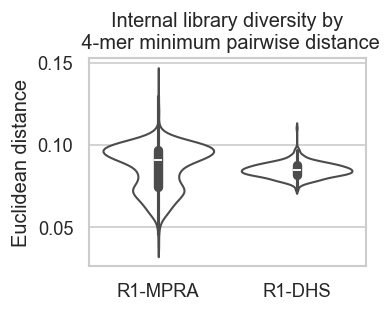

In [100]:
# (2) sequence diversity - should I normalize somehow by sequence length/total n-mers?
# also, currently this is an asymmetric metric - should I just combine the A vs B and the B vs A into same violin? seems valid

save_dir = 'SI/nmer_euc_distances'
pre_calc = True
norm = True
suffix = '_norm' if norm else ''

if not pre_calc:

    nmer = 4
    
    # compute 4-mer diversity for dhs sequences
    dhs_seqs = dhs_deseq_df['enhancer'].values
    dhs_nmers = np.array([str2nmer(seq,nmer) for seq in dhs_seqs])
    nmer_keys = generate_all_nmers(nmer)
    dhs_nmer_vec = np.array([count_nmers(vec,nmer_keys) for vec in dhs_nmers])
    if norm:
        dhs_nmer_vec = dhs_nmer_vec / dhs_nmer_vec.sum(axis=1)[:,None]

    # compute internal library diversity
    dhs_vs_dhs_min_dist = _get_min_euc_dists(dhs_nmer_vec,dhs_nmer_vec)
    np.save(f'{save_dir}/dhs_vs_dhs_min_nmer_dist{suffix}.npy',dhs_vs_dhs_min_dist)

    # now generate the R1-MPRA nmer vectors and compute R1-MPRA vs R1-DHS distance (both ways for symmetry?)
    r1_analysis_df = d2_deseq_df[~d2_deseq_df['model_type'].isin(['sharpr-mpra','df'])].copy()
    r1_seqs = r1_analysis_df['enhancer'].values
    r1_nmers = np.array([str2nmer(seq,nmer) for seq in r1_seqs])
    r1_nmer_vec = np.array([count_nmers(vec,nmer_keys) for vec in r1_nmers])
    if norm:
        r1_nmer_vec = r1_nmer_vec / r1_nmer_vec.sum(axis=1)[:,None]

    r1_vs_dhs_min_dist = _get_min_euc_dists(r1_nmer_vec,dhs_nmer_vec)
    np.save(f'{save_dir}/r1_vs_dhs_min_nmer_dist{suffix}.npy',r1_vs_dhs_min_dist)
    dhs_vs_r1_min_dist = _get_min_euc_dists(dhs_nmer_vec,r1_nmer_vec)
    np.save(f'{save_dir}/dhs_vs_r1_min_nmer_dist{suffix}.npy',dhs_vs_r1_min_dist)

    r1_vs_r1_min_dist = _get_min_euc_dists(r1_nmer_vec,r1_nmer_vec)
    np.save(f'{save_dir}/r1_vs_r1_min_nmer_dist{suffix}.npy',r1_vs_r1_min_dist)

else:
    dhs_vs_dhs_min_dist = np.load(f'{save_dir}/dhs_vs_dhs_min_nmer_dist{suffix}.npy')
    r1_vs_dhs_min_dist = np.load(f'{save_dir}/r1_vs_dhs_min_nmer_dist{suffix}.npy')
    dhs_vs_r1_min_dist = np.load(f'{save_dir}/dhs_vs_r1_min_nmer_dist{suffix}.npy')


# load in the internal R1-MPRA diversity
r1_vs_r1_min_dist = np.load(f'{save_dir}/r1_vs_r1_min_nmer_dist{suffix}.npy')

# violin plot of r1_vs_r1_min_dist, dhs_vs_dhs_min_dist, r1_vs_dhs_min_dist, dhs_vs_r1_min_dist
# plt.figure(figsize=(6,4))
# sns.violinplot(data=[r1_vs_r1_min_dist,dhs_vs_dhs_min_dist,r1_vs_dhs_min_dist,dhs_vs_r1_min_dist])
# plt.xticks([0,1,2,3],['R1-MPRA vs R1-MPRA','DHS vs DHS','R1-MPRA vs DHS','DHS vs R1-MPRA'])
# plt.xticks([0,1,2,3],['R1-MPRA vs R1-MPRA','DHS vs DHS'])
plt.figure(figsize=(3.5*.85,2.5*.9))
sns.violinplot(data=[r1_vs_r1_min_dist,dhs_vs_dhs_min_dist],facecolor='white')
plt.xticks([0,1],['R1-MPRA','R1-DHS'])
plt.ylabel('Euclidean distance')
plt.title('Internal library diversity by\n 4-mer minimum pairwise distance')

# save figure
plt.savefig(f'{revision_figure_dir}/R3.3_nmer_diversity_violinplot{suffix}.png',bbox_inches='tight',dpi=500)


In [141]:
# print mean and std of each of these distances, also t-test between R1-MPRA and R1-DHS
print('R1-MPRA vs R1-MPRA')
print(f'{r1_vs_r1_min_dist.mean():.3f}+-{r1_vs_r1_min_dist.std():.3f}')
print('DHS vs DHS')
print(f'{dhs_vs_dhs_min_dist.mean():.3f}+-{dhs_vs_dhs_min_dist.std():.3f}')

# t-test between R1-MPRA and R1-DHS
t,p = ttest_ind(r1_vs_r1_min_dist,dhs_vs_dhs_min_dist)
print(f'R1-MPRA vs DHS: p={p:.1e}')

R1-MPRA vs R1-MPRA
0.086+-0.014
DHS vs DHS
0.085+-0.004
R1-MPRA vs DHS: p=6.7e-03




34/34 [==============================] - 5s 109ms/step


Text(0, 0.5, 'Predicted')

<Figure size 1080x300 with 0 Axes>

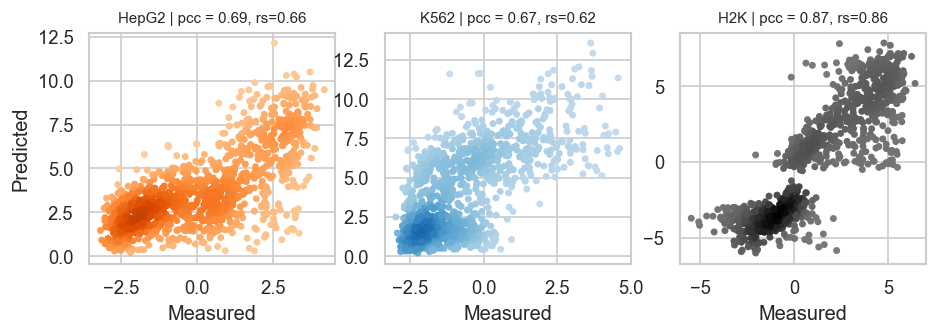

In [95]:
# 3) Prediction-measurement plot for R1-DHS sequences using M0 model - first as reference baseline get M0 preds on R1-MPRA

# first, subset the R1-MPRA and R2 sequences

d3_model_types = ['d1_finetuned','d2_dhs']
d3_design_types = ['fsp','fsp_clipped','fsp_tgt'] # can see an argument for excluding target seqs but meh
d3_analysis_df = d3_seq_df[(d3_seq_df['model_type'].isin(d3_model_types)) & (d3_seq_df['design_type'].isin(d3_design_types))].copy()

d2_analysis_df = d2_deseq_plus_cluster_cnts_df[d2_deseq_plus_cluster_cnts_df['design_type'].isin(['DENs','sim_anneal','seqprop'])].copy()

# load the M0 ensemble model, then make predictions on the sequences in d2_analysis_df
# note this isn't totally comparable, since M0 ensemble not used to generate the R1-MPRA
# but it's a more competitive comparison for R2...and the correlatino seems to be quite bad for R1-MPRA if I used the generative model's predictions

D2_M0_H2K_PRED_COL = 'M0_pred_h2k_score'

# load the M0 ensemble model
cf_model_dir = '../../aws/for_aws/sequencing_analysis/retraining/retrained_models/cf10/test_fold_0/d1'
model_basename = f'd1_wide_cf_t0_v'
model_name = f'{cf_model_dir}/{model_basename}.h5'

# load unfinetuned model and get predictions to append to the results_dfs in the next cell

model_inds = np.arange(1,10)
model = load_ensemble_model(cf_model_dir,model_basename,model_inds)
# predict on test set

x_test = d2_analysis_df['enhancer'].apply(seq_to_one_hot).values
x_test = np.stack(x_test)

y_test = d2_analysis_df[[HEPG2_COL,K562_COL,H2K_COL]].values

# pad x_test to 200bp
lpad = (200-145)//2
rpad = 200 - 145 - lpad
x_test = np.pad(x_test,((0,0),(lpad, rpad),(0,0)))

y_test_hat = model.predict(x_test)
y_test_hat = np.concatenate([y_test_hat,np.expand_dims(y_test_hat[:,0]-y_test_hat[:,1],axis=1)],axis=1)



# 1 x 3 scatterplot for hepg2, k562, h2k predictions, include pearson r values in title

plt.figure(figsize=(9,2.5))
colnames = ['HepG2','K562','H2K']
cmaps = [oranges_trunc_cm,blues_trunc_cm,greys_trunc_cm]

# generate subplots with ax reference
fig, ax = plt.subplots(1,3,figsize=(9,2.5))

alpha = 1
s = 10

for i in range(3):
    # plt.subplot(1,3,i+1)
    # plt.grid(True,zorder=-100)
    # plt.scatter(y_test[:,i],y_test_hat[:,i])
    # sns.regplot(x=y_test[:,i],y=y_test_hat[:,i])

# xlim=(-4.5, 6), ylim=(-4.5, 6), cmap=oranges_trunc_cm
    plot_scatter_shaded(y_test[:,i],y_test_hat[:,i], 
                        ax[i], linreg=False,cmap=cmaps[i],alpha=alpha,s=s,rasterized=True)

    rs = spearmanr(y_test[:,i],y_test_hat[:,i])[0]
    pcc = pearsonr(y_test[:,i],y_test_hat[:,i])[0]
    ax[i].set_title(f'{colnames[i]} | pcc = {pcc:.2f}, rs={rs:.2f}',fontsize=9)
    ax[i].set_xlabel('Measured')
    # grid lines

ax[0].set_ylabel('Predicted')

<Figure size 1026x285 with 0 Axes>

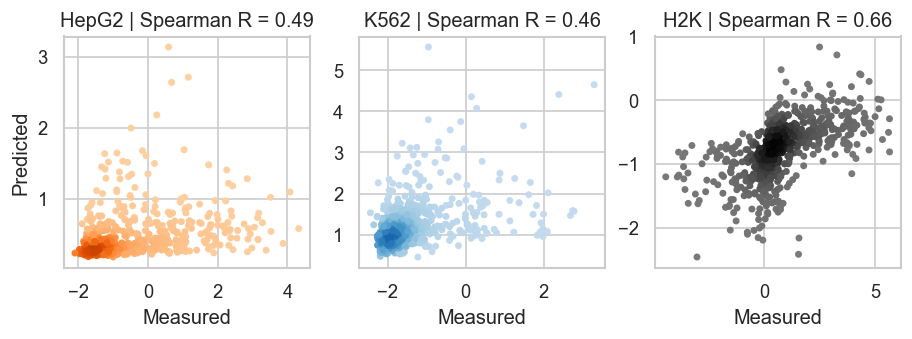

In [101]:
# 3) Prediction-measurement plot for R1-DHS sequences using M0 model

# load the M0 ensemble model
cf_model_dir = '../../aws/for_aws/sequencing_analysis/retraining/retrained_models/cf10/test_fold_0/d1'
model_basename = f'd1_wide_cf_t0_v'
model_inds = np.arange(1,10)

model = load_ensemble_model(cf_model_dir,model_basename,model_inds)

# predict on dhs sequences
x_dhs = dhs_deseq_df['enhancer'].apply(seq_to_one_hot).values
x_dhs = np.stack(x_dhs)

y_test_hat = model.predict(x_dhs)
# append col for H2K prediction
y_test_hat = np.concatenate([y_test_hat,np.expand_dims(y_test_hat[:,0]-y_test_hat[:,1],axis=1)],axis=1)

y_test = dhs_deseq_df[[HEPG2_COL,K562_COL,H2K_COL]].values

# 1 x 3 scatterplot for hepg2, k562, h2k predictions, include pearson r values in title


plt.figure(figsize=(9*.95,2.5*.95))
colnames = ['HepG2','K562','H2K']
cmaps = [oranges_trunc_cm,blues_trunc_cm,greys_trunc_cm]

# generate subplots with ax reference
fig, ax = plt.subplots(1,3,figsize=(9,2.5))

alpha = 1
s = 10

for i in range(3):
    # plt.subplot(1,3,i+1)
    # plt.grid(True,zorder=-100)
    # plt.scatter(y_test[:,i],y_test_hat[:,i])
    # sns.regplot(x=y_test[:,i],y=y_test_hat[:,i])

# xlim=(-4.5, 6), ylim=(-4.5, 6), cmap=oranges_trunc_cm
    plot_scatter_shaded(y_test[:,i],y_test_hat[:,i], 
                        ax[i], linreg=False,cmap=cmaps[i],alpha=alpha,s=s,rasterized=True)

    rs = spearmanr(y_test[:,i],y_test_hat[:,i])[0]
    pcc = pearsonr(y_test[:,i],y_test_hat[:,i])[0]
    # ax[i].set_title(f'{colnames[i]} | pcc = {pcc:.2f}, rs={rs:.2f}',fontsize=9)
    ax[i].set_title(f'{colnames[i]} | Spearman R = {rs:.2f}',fontsize=AXIS_FSIZE)
    ax[i].set_xlabel('Measured',fontsize=AXIS_FSIZE)
    # grid lines

ax[0].set_ylabel('Predicted',fontsize=AXIS_FSIZE)

# save figure
plt.savefig(f'{revision_figure_dir}/R3.3_dhs_m0_pred_meas_scatterplot.png',bbox_inches='tight',dpi=500)

# I guess I want to compare this to M0 predictions on R1-MPRA sequences

# and maybe look at motif content of worst-predicted sequences from the DHS set
# also break down by under predicted vs overpredicted
# to not generate too much work for myself, maybe I can stick with just looking at all sequences, not grouped by cell type?

In [106]:
# 3) Make a spearmanr barplot to compare M0 predictions on R1-MPRA vs R1-DHS test set

# load the M0 ensemble model, then make predictions on the sequences in d2_analysis_df
# note this isn't totally comparable, since M0 ensemble not used to generate the R1-MPRA
# but it's a more competitive comparison for R2...and the correlatino seems to be quite bad for R1-MPRA if I used the generative model's predictions

# load the M0 ensemble model
cf_model_dir = '../../aws/for_aws/sequencing_analysis/retraining/retrained_models/cf10/test_fold_0/d1'
model_basename = f'd1_wide_cf_t0_v'
model_name = f'{cf_model_dir}/{model_basename}.h5'

# assemble mpra test set

# only subset designed enhancers
d2_analysis_df = d2_deseq_plus_cluster_cnts_df[d2_deseq_plus_cluster_cnts_df['design_type'].isin(['DENs','sim_anneal','seqprop'])].copy()
x_mpra_test = d2_analysis_df['enhancer'].apply(seq_to_one_hot).values
x_mpra_test = np.stack(x_mpra_test)
y_mpra_test = d2_analysis_df[[HEPG2_COL,K562_COL]].values

# pad x_mpra_test to 200bp
lpad = (200-145)//2
rpad = 200 - 145 - lpad
x_mpra_test = np.pad(x_mpra_test,((0,0),(lpad, rpad),(0,0)))

# assemble dhs test set
dhs_analysis_df = dhs_deseq_df[dhs_deseq_df['design_type']=='gan']
x_dhs_test = dhs_analysis_df['enhancer'].apply(seq_to_one_hot).values
x_dhs_test = np.stack(x_dhs_test)
y_dhs_test = dhs_analysis_df[[HEPG2_COL,K562_COL]].values

results_df = pd.DataFrame()
# columns=['dataset','cell_line','corr']
results_df = pd.DataFrame(columns=['dataset','HEPG2','K562','H2K'])

from keras import backend as K
from keras.models import load_model

for model_ind in np.arange(1,10):
    K.clear_session()
    model = load_model(f'{cf_model_dir}/{model_basename}{model_ind}.h5')

    y_mpra_test_hat = model.predict(x_mpra_test)
    # add HepG2, K562, and H2K predictions to results_df
    hepg2_corr = spearmanr(y_mpra_test[:,0],y_mpra_test_hat[:,0])[0]
    k562_corr = spearmanr(y_mpra_test[:,1],y_mpra_test_hat[:,1])[0]
    h2k_corr = spearmanr(y_mpra_test[:,0]-y_mpra_test[:,1],y_mpra_test_hat[:,0]-y_mpra_test_hat[:,1])[0]

    results_df = pd.concat([results_df,pd.DataFrame({'dataset':'R1-MPRA','HEPG2':hepg2_corr,'K562':k562_corr,'H2K':h2k_corr},index=[0])])

    # now do the same for the DHS test set
    y_dhs_test_hat = model.predict(x_dhs_test)
    # add HepG2, K562, and H2K predictions to results_df
    hepg2_corr = spearmanr(y_dhs_test[:,0],y_dhs_test_hat[:,0])[0]
    k562_corr = spearmanr(y_dhs_test[:,1],y_dhs_test_hat[:,1])[0]
    h2k_corr = spearmanr(y_dhs_test[:,0]-y_dhs_test[:,1],y_dhs_test_hat[:,0]-y_dhs_test_hat[:,1])[0]

    results_df = pd.concat([results_df,pd.DataFrame({'dataset':'R1-DHS','HEPG2':hepg2_corr,'K562':k562_corr,'H2K':h2k_corr},index=[0])])

# reset index
results_df = results_df.reset_index(drop=True)






11/19 [================>.............] - ETA: 0s

C:\Users\Chris\AppData\Local\Temp\ipykernel_24888\2508381495.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df,pd.DataFrame({'dataset':'R1-MPRA','HEPG2':hepg2_corr,'K562':k562_corr,'H2K':h2k_corr},index=[0])])


19/19 [==============================] - 0s 12ms/step


In [110]:
results_df = results_df.melt(id_vars=['dataset'],value_vars=['HEPG2','K562','H2K'])
results_df.columns = ['dataset','cell_type','corr']


results_df.head()

dataset cell_type      corr
0  R1-MPRA     HEPG2 -0.382551
1   R1-DHS     HEPG2 -0.224440
2  R1-MPRA     HEPG2  0.788609
3   R1-DHS     HEPG2  0.611091
4  R1-MPRA     HEPG2  0.674609

C:\Users\Chris\AppData\Local\Temp\ipykernel_24888\535855606.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels,fontsize=TEXT_FSIZE)


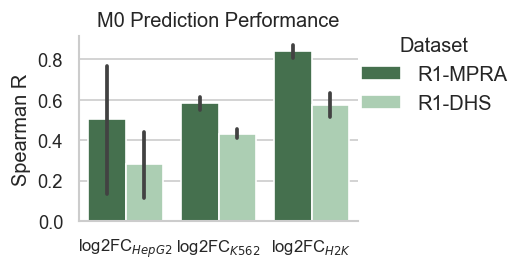

In [136]:
custom_color_vec = ["#FC440F","#5B5F97","#FFC145","#BBE1C3","#6C9A8B"]
custom_green_palette = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95)
palette = {
    'R1-DHS': custom_green_palette[1],
    'R1-MPRA': custom_green_palette[3],
}

fig, ax = plt.subplots(figsize=(3,2))
order = ['HEPG2','K562','H2K']
xtick_labels = ['log2FC$_{HepG2}$','log2FC$_{K562}$','log2FC$_{H2K}$']
ax = sns.barplot(x='cell_type',y='corr',hue='dataset',data=results_df,order=order,palette=palette)
ax.set_xticklabels(xtick_labels,fontsize=TEXT_FSIZE)
ax.set_xlabel('')
ax.set_ylabel('Spearman R',fontsize=AXIS_FSIZE)
ax.set_title('M0 Prediction Performance',fontsize=AXIS_FSIZE)

# despine
sns.despine()

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
legend_labels = ['R1-MPRA','R1-DHS']
legend_title = 'Dataset'
# plt.legend(bbox_to_anchor=(0.5, -0.4), loc='center', ncol=3,frameon=False,fontsize=TEXT_FSIZE,title=legend_title,title_fontsize=TEXT_FSIZE)
# plot legend to the right of the plot
plt.legend(title=legend_title,loc='upper right',bbox_to_anchor=(1.6, 1.1),ncol=1,frameon=False,fontsize=AXIS_FSIZE,title_fontsize=AXIS_FSIZE)
# move x axis label down
ax.xaxis.labelpad = 10

# save figure
plt.savefig(f'{revision_figure_dir}/R3.3_m0_pred_meas_comparison.png',bbox_inches='tight',dpi=500)

In [138]:
# t test to compare R1-MPRA vs R1-DHS performance on each task
from scipy.stats import ttest_ind

for cell_line in ['HEPG2','K562','H2K']:
    mpra_vals = results_df[(results_df['dataset']=='R1-MPRA') & (results_df['cell_type']==cell_line)]['corr']
    dhs_vals = results_df[(results_df['dataset']=='R1-DHS') & (results_df['cell_type']==cell_line)]['corr']
    
    # get mean and se
    mean_mpra = mpra_vals.mean()
    mean_dhs = dhs_vals.mean()
    se_mpra = mpra_vals.std()/np.sqrt(mpra_vals.shape[0])
    se_dhs = dhs_vals.std()/np.sqrt(dhs_vals.shape[0])

    t,p = ttest_ind(mpra_vals,dhs_vals)
    print(f'{cell_line}: p={p:.1e}, {mean_mpra:.2f}+-{se_mpra:.2f} vs {mean_dhs:.2f}+-{se_dhs:.2f}')

HEPG2: p=2.6e-01, 0.51+-0.17 vs 0.28+-0.09
K562: p=2.0e-06, 0.59+-0.02 vs 0.43+-0.01
H2K: p=2.9e-06, 0.84+-0.02 vs 0.58+-0.03


slope: 0.15, intercept: -0.88, r_value: 0.56, p_value: 3.01e-56, std_err: 0.01


Text(0.5, 1.0, 'H2K residuals vs measurement')

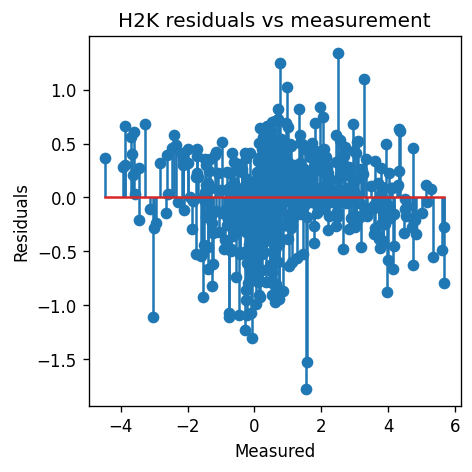

In [129]:
"""Okay, let's focus on just the H2K prediction for now

- prediction range is different from measurement range. I should generate the line of best fit then plot the residuals
- then I can threshold sequences with the largest residuals (in both directions) and look at their motif content

"""

# generate regression line for H2K prediction vs measurement

from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(y_test[:,2],y_test_hat[:,2])
print(f'slope: {slope:.2f}, intercept: {intercept:.2f}, r_value: {r_value:.2f}, p_value: {p_value:.2e}, std_err: {std_err:.2f}')

# plot residuals vs measurement
# first generate regression line predictions
y_test_hat_line = y_test[:,2]*slope + intercept
residuals = y_test_hat[:,2] - y_test_hat_line

# plot residuals vs measurement as a stem plot
plt.figure(figsize=(4,4))
plt.stem(y_test[:,2],residuals)
plt.xlabel('Measured')
plt.ylabel('Residuals')
plt.title('H2K residuals vs measurement')

In [126]:
# okay let's get the median residual
median_residual = np.median(residuals)
print(median_residual)

# get the median positive and negative residuals
pos_residuals = residuals[residuals > 0]
neg_residuals = residuals[residuals < 0]

q=0.8
median_pos_residual = np.quantile(pos_residuals,q)
median_neg_residual = np.quantile(neg_residuals,q)

print(median_pos_residual,median_neg_residual)



0.034419153327448715
0.40937299729290044 -0.08065776100397085


Text(0.5, 1.0, 'H2K residuals')

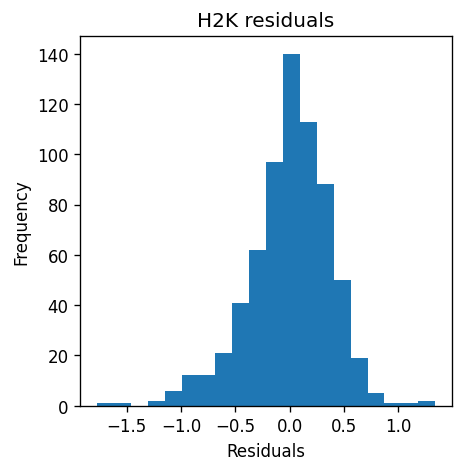

In [132]:
# okay let's just do the dumb Wilcoxon test for every motif!!
# first step, let's append the residual values to the dhs_deseq_df
# the ordering is consistent, so I can just append the residuals as a new column

dhs_analysis_df = dhs_deseq_df.copy()
dhs_analysis_df['h2k_residual'] = residuals
# histogram of residuals
plt.figure(figsize=(4,4))
plt.hist(residuals,bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('H2K residuals')

In [156]:
# import wilcoxon
from scipy.stats import wilcoxon

# get motif cluster columns
cluster_cols = [col for col in dhs_analysis_df.columns if 'cluster_' in col]
print(len(cluster_cols))

# okay first let's look at just the overpredictions of H2K specificity...honestly I should subset this by cell type and by over/under prediction
# cell type should be defined by measured H2K score...except that there are 510 seqs > 0, 164 < 0 so maybe I just stick with over/under?
# though heavily 0-centered distribution so dividing into cell types is less clear based on cell type


cur_analysis_df = dhs_analysis_df[dhs_analysis_df['h2k_residual'] > 0].copy()
print(f'Number of overpredicted seqs {cur_analysis_df.shape[0]}')

# drop all cluster_cols that are all 0
cur_analysis_df = cur_analysis_df.drop(columns=[col for col in cluster_cols if cur_analysis_df[col].sum() == 0])
# regenerate cluster_cols
cur_clusters = [col for col in cur_analysis_df.columns if 'cluster_' in col]
print(len(cur_clusters))

# okay now I can loop through the cluster columns and do a Wilcoxon rank sum test on the residuals for each cluster
# binarize the cluster columns
n_tests = len(cur_clusters)

# initialize df to store cluster and p-value
colnames = ['cluster','p']
overpred_results_df = pd.DataFrame(columns=colnames)
for cluster in cur_clusters:
    cluster_vals = cur_analysis_df[cluster].values
    # do Wilcoxon rank sum test
    pos_residuals = cur_analysis_df[cur_analysis_df[cluster] == 1]['h2k_residual'].values
    neg_residuals = cur_analysis_df[cur_analysis_df[cluster] == 0]['h2k_residual'].values

    # use ranksum package to get p-value
    p = ranksums(pos_residuals,neg_residuals,alternative = 'greater')[1]
    overpred_results_df = pd.concat([overpred_results_df,pd.DataFrame([[cluster,p]],columns=colnames)])
    # print(f'{cluster}: {p:.2e}')

#  import multipletests
from statsmodels.stats.multitest import multipletests
overpred_results_df['padjs'] = multipletests(overpred_results_df['p'],method='fdr_bh')[1]

# sort ascending by padj
overpred_results_df = overpred_results_df.sort_values(by='padjs')
# add column is padjs < 0.05
overpred_results_df['sig'] = overpred_results_df['padjs'] < 0.05
print(overpred_results_df[overpred_results_df['sig']])

# okay now I can do the same for underpredictions

cur_analysis_df = dhs_analysis_df[dhs_analysis_df['h2k_residual'] < 0].copy()
print(f'Number of underpredicted seqs {cur_analysis_df.shape[0]}')

# drop all cluster_cols that are all 0
cur_analysis_df = cur_analysis_df.drop(columns=[col for col in cluster_cols if cur_analysis_df[col].sum() == 0])
# regenerate cluster_cols
cur_clusters = [col for col in cur_analysis_df.columns if 'cluster_' in col]
print(len(cur_clusters))

# okay now I can loop through the cluster columns and do a Wilcoxon rank sum test on the residuals for each cluster
# binarize the cluster columns
n_tests = len(cur_clusters)

# initialize df to store cluster and p-value
colnames = ['cluster','p']
underpred_results_df = pd.DataFrame(columns=colnames)
for cluster in cur_clusters:
    cluster_vals = cur_analysis_df[cluster].values
    # do Wilcoxon rank sum test
    pos_residuals = cur_analysis_df[cur_analysis_df[cluster] == 1]['h2k_residual'].values
    neg_residuals = cur_analysis_df[cur_analysis_df[cluster] == 0]['h2k_residual'].values

    # use ranksum package to get p-value
    p = ranksums(pos_residuals,neg_residuals,alternative = 'less')[1]
    underpred_results_df = pd.concat([underpred_results_df,pd.DataFrame([[cluster,p]],columns=colnames)])
    # print(f'{cluster}: {p:.2e}')

underpred_results_df['padjs'] = multipletests(underpred_results_df['p'],method='fdr_bh')[1]

# sort ascending by padj
underpred_results_df = underpred_results_df.sort_values(by='padjs')
# add column is padjs < 0.05
underpred_results_df['sig'] = underpred_results_df['padjs'] < 0.05
print(underpred_results_df[underpred_results_df['sig']])

50
Number of overpredicted seqs 376
36
     cluster         p     padjs   sig
0  cluster_4  0.000475  0.017096  True
Number of underpredicted seqs 298
44
      cluster         p     padjs   sig
0   cluster_9  0.000039  0.001738  True
0  cluster_27  0.000413  0.009076  True


C:\Users\Chris\AppData\Local\Temp\ipykernel_33648\3379847929.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  overpred_results_df = pd.concat([overpred_results_df,pd.DataFrame([[cluster,p]],columns=colnames)])
C:\Users\Chris\AppData\Local\Temp\ipykernel_33648\3379847929.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  underpred_results_df = pd.concat([underpred_results_df,pd.DataFrame([[cluster,p]],columns=colnames)])


<Axes: >

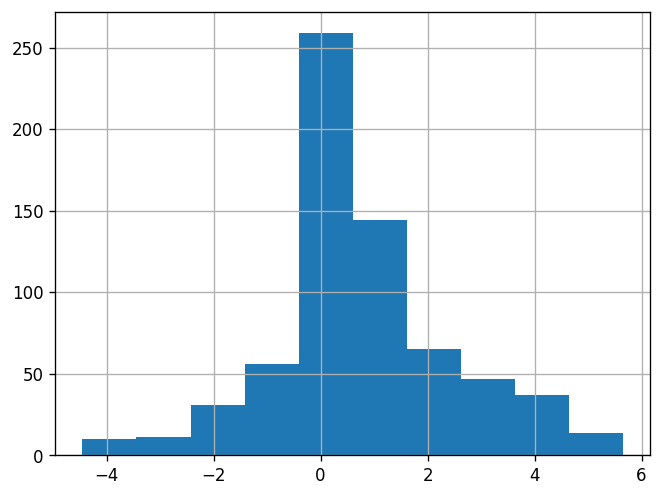

In [139]:
dhs_deseq_df[H2K_COL].hist()

### R3.5 - sequence-based interpretation tools ###

In [251]:
shap_dir = 'shap_values_for_revision'
model_names = ['M2','M1','M0']
dataset_names = ['R2','R1-MPRA','R1-DHS','R0']

# process the analysis_df to remove sequences w/ no calculation for SHAP values

exluded_model_types = ['dhs64_finetuned','dhs62_finetuned','sabetti_ctrl']
excluded_design_types = ['fsp_minimal_concatemer','concatemer','sabetti_ctrl']

motif_df_dict = {
    'R0': d1_final_df.copy(),
    'R1-MPRA': d2_final_df.copy(),
    'R1-DHS': dhs_final_df.copy(),
    'R2': d3_final_df.copy()
}


deseq_df_dict = {
    'R0': d1_deseq_plus_cluster_cnts_df.sample(3000,random_state=0).copy(),
    'R1-MPRA': d2_deseq_plus_cluster_cnts_df[d2_deseq_plus_cluster_cnts_df['design_type'] != 'control'].copy(),
    'R1-DHS': dhs_deseq_df.copy(),
    'R2': d3_deseq_plus_cluster_cnts_df[(~d3_deseq_plus_cluster_cnts_df['model_type'].isin(exluded_model_types)) & (~d3_deseq_plus_cluster_cnts_df['design_type'].isin(excluded_design_types))].copy()
}

"""
I need to confirm correct alignment of SHAP to sequence and motif for all 4 datasets!!!
    + R2
    + R1-MPRA
    + R1-DHS
    - R0

"""

# okay what if I rename the sequence_name columns in the motif_dfs...try this with the R1-MPRA motif_df

# for motif_df_dict['R1-MPRA'], append 'd2_seq_' to the values in the sequence name column
motif_df_dict['R1-MPRA']['sequence_name'] = motif_df_dict['R1-MPRA'].apply(lambda x: f'd2_seq_{x["sequence_name"]}',axis=1)
# also do this for the R0 motif_df
motif_df_dict['R0']['sequence_name'] = motif_df_dict['R0'].apply(lambda x: f'd1_seq_{x["sequence_name"]}',axis=1)

# reset index of deseq_df_dict['R0]
deseq_df_dict['R0'] = deseq_df_dict['R0'].reset_index(drop=True)


m_hepg2_d12,b_hepg2_d12,m_k562_d12,b_k562_d12,_,_ = np.load(f'batch_correction_weights/comb_dhs/d1_to_d2_linregs_weighted_pf.npy')
m_hepg2_d23,b_hepg2_d23,m_k562_d23,b_k562_d23,_,_ = np.load(f'batch_correction_weights/comb_dhs/d2_to_d3_linregs_weighted_pf.npy')

m_hepg2_d13 = m_hepg2_d12 * m_hepg2_d23
b_hepg2_d13 = m_hepg2_d23 * b_hepg2_d12 + b_hepg2_d23 #  m_d23 * b_d12 + b_d23
m_k562_d13 = m_k562_d12 * m_k562_d23
b_k562_d13 = m_k562_d23 * b_k562_d12 + b_k562_d23


R0: 8
R1-MPRA: 89
R1-DHS: 174
R2: 451
722


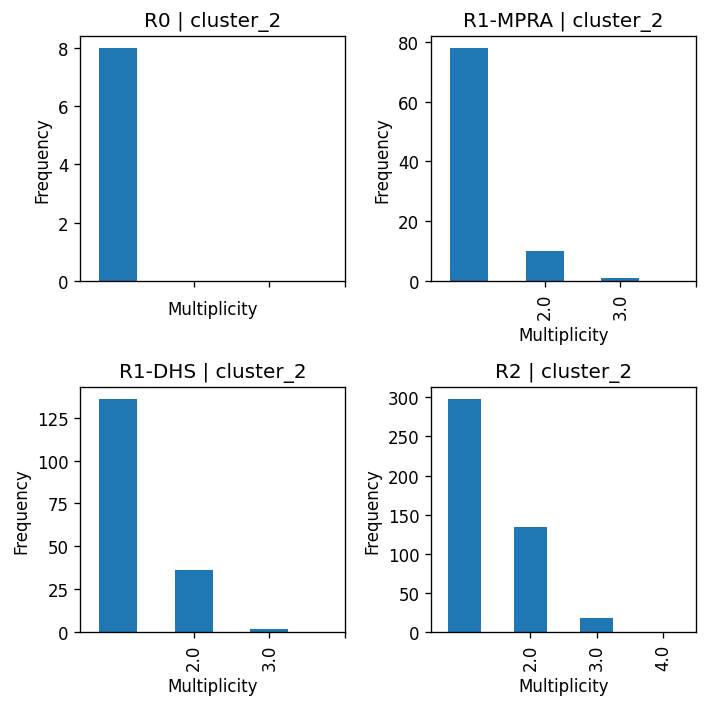

In [252]:
# d1_deseq_plus_cluster_cnts_df

# okay, I want to plot a histogram of multiplicity for a givel motif and for a given dataset

cluster = 'cluster_2'
# dfs = [d1_deseq_plus_cluster_cnts_df,d2_deseq_plus_cluster_cnts_df,dhs_deseq_df,d3_deseq_plus_cluster_cnts_df]
dataset_names = ['R0','R1-MPRA','R1-DHS','R2']



# deseq_df_dict = {
#     'R0': d1_deseq_plus_cluster_cnts_df.copy(),
#     'R1-MPRA': d2_deseq_plus_cluster_cnts_df[d2_deseq_plus_cluster_cnts_df['design_type'] != 'control'].copy(),
#     'R1-DHS': dhs_deseq_df.copy(),
#     'R2': d3_deseq_plus_cluster_cnts_df[(~d3_deseq_plus_cluster_cnts_df['model_type'].isin(exluded_model_types)) & (~d3_deseq_plus_cluster_cnts_df['design_type'].isin(excluded_design_types))].copy()
# }

max_mult = np.max([df[cluster].max() for df in dfs])

n_hits_tot = 0
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
for i, (dataset_name,df) in enumerate(deseq_df_dict.items()):

    cur_df = df[df[cluster] > 0]
    row = i // 2
    col = i % 2
    cur_df[cluster].value_counts().sort_index().plot(kind='bar', ax=ax[row, col])
    ax[row, col].set_title(f'{dataset_name} | {cluster}')
    ax[row, col].set_xlabel('Multiplicity')
    ax[row, col].set_ylabel('Frequency')
    # ax[row, col].set_xticks(np.arange(1, 7))
    # set xticks from 1 to max_mult
    ax[row, col].set_xticks(np.arange(1, max_mult))

    n_hits_tot += cur_df.shape[0]
    print(f'{dataset_name}: {cur_df.shape[0]}')

plt.tight_layout()

print(n_hits_tot)

# okay, so for the 

In [6]:
# create a dataframe that has one row for each model, and a column for min and max of hepg2, k562, and h2k

### Load all the data

# padd to 200 bp, also extract only the d1 columns
lpad = (200-145)//2
rpad = 200 - 145 - lpad

x_r0 = np.stack(deseq_df_dict['R0']['seq'].apply(seq_to_one_hot).values)
x_r0 = np.pad(x_r0,((0,0),(lpad, rpad),(0,0)))

x_r1m = np.stack(deseq_df_dict['R1-MPRA']['enhancer'].apply(seq_to_one_hot).values)
x_r1m = np.pad(x_r1m,((0,0),(lpad, rpad),(0,0)))

# don't need to pad this one
x_r1d = np.stack(deseq_df_dict['R1-DHS']['enhancer'].apply(seq_to_one_hot).values)

# not all x_r2 sequences are the same length, so pad them one by one
# (I guess I could have done this for all of them but oh well)
x_r2 = np.stack(deseq_df_dict['R2']['sequence'].apply(seq_to_one_hot_and_pad).values)

# create an x_tot that has all the sequences
x_tot = np.concatenate([x_r0,x_r1m,x_r1d,x_r2],axis=0)

### End load all the data

### Define model locations and parameters

cf_model_dir = '../../aws/for_aws/sequencing_analysis/retraining/retrained_models/cf10/test_fold_0'
model_dirs = {
    'M0': f'{cf_model_dir}/d1',
    'M1': f'{cf_model_dir}/d1_finetuned',
    'M2': 'd2_finetuned/test_fold_0'
}

model_basename_dict = {
    'M0': 'd1_wide_cf_t0_v',
    'M1': 'd1_wide_ft_cf_t0_v',
    'M2': 'd1_wide_ft_cf_t0_v'
}

model_suffix_dict = {
    'M0': '',
    'M1': '',
    'M2': '_d2_ft'
}

n_crossfolds = 1
n_models = 9
ensemble_inds = np.arange(1,1+n_models)

### End define model locations and parameters

load_model_range_df = True

if not load_model_range_df:
    ### initialize dataframe
    colnames = ['model','min_hepg2','max_hepg2','min_k562','max_k562','min_h2k','max_h2k']
    model_range_df = pd.DataFrame(columns=colnames)


    # loop through model names
    for model_name in model_names:

        model_basename = model_basename_dict[model_name]
        model_suffix = model_suffix_dict[model_name]
        cur_model_dir = model_dirs[model_name]

        # load model and get predictions on all sequences
        K.clear_session()
        model = load_ensemble_model(cur_model_dir,model_basename,ensemble_inds,model_suffix=model_suffix)

        y_tot = model.predict(x_tot)

        # get min and max of each measurement
        min_hepg2 = np.min(y_tot[:,0])
        max_hepg2 = np.max(y_tot[:,0])

        min_k562 = np.min(y_tot[:,1])
        max_k562 = np.max(y_tot[:,1])

        min_h2k = np.min(y_tot[:,0]-y_tot[:,1])
        max_h2k = np.max(y_tot[:,0]-y_tot[:,1])

        model_range_df = pd.concat([model_range_df,pd.DataFrame([[model_name,min_hepg2,max_hepg2,min_k562,max_k562,min_h2k,max_h2k]],columns=colnames)])

    # save model_range_df
    model_range_df.to_csv(f'shap_values_for_revision/model_range_df.csv',index=False)
else:
    model_range_df = pd.read_csv(f'shap_values_for_revision/model_range_df.csv')

model_range_df

model  min_hepg2  max_hepg2  min_k562   max_k562   min_h2k   max_h2k
0    M2  -2.996963   4.274468 -2.932159   5.334429 -4.371759  6.445419
1    M1  -4.259189  13.521691 -4.002989  15.274429 -8.084408  9.763151
2    M0   0.156414  24.177336  0.202232  23.498753 -7.078085  9.733205

In [254]:
### Code for computing mean SHAP values for each motif for each model ###
# uses batch correction linear regression slopes to normalize shap values across the libraries

# intialize dict to contain one dataframe per model
model_shap_dict = {}

for cur_model in model_names:

    print(f'Processing model {cur_model}')

    # initialize cur_cluster_shap_df - will hold all shaps for a single model across all datasets
    cur_cluster_shap_df = pd.DataFrame(columns=['cluster','cell_type','shap_score'])

    # need to make sure this doesn't reinitialize across datasets, or else actually that's fine, I can concat the dataframes not the dicts

    for cur_dataset in motif_df_dict:
        print(f'\tProcessing dataset {cur_dataset}')

        # load in the shap values
        hepg2_shap = np.load(f'{shap_dir}/{cur_model}/hepg2_raw_shap_explanations_{cur_model}_{cur_dataset}.npy')
        k562_shap = np.load(f'{shap_dir}/{cur_model}/k562_raw_shap_explanations_{cur_model}_{cur_dataset}.npy')

        seq_len = 200 if cur_dataset=='R1-DHS' else 145
        # remove the padding from the shap values
        hepg2_shap = hepg2_shap[:,(200-seq_len)//2:(200-seq_len)//2+seq_len]
        k562_shap = k562_shap[:,(200-seq_len)//2:(200-seq_len)//2+seq_len]


        ############ temp: try implementing batch normalizaiton on shap values

        # load the batch correction slope and intercepts - already done now in first cell of this section

        # load linreg slopes from npy file
        m_hepg2_d12,b_hepg2_d12,m_k562_d12,b_k562_d12,_,_ = np.load(f'batch_correction_weights/comb_dhs/d1_to_d2_linregs_weighted_pf.npy')
        m_hepg2_d23,b_hepg2_d23,m_k562_d23,b_k562_d23,_,_ = np.load(f'batch_correction_weights/comb_dhs/d2_to_d3_linregs_weighted_pf.npy')
        m_hepg2_d13 = m_hepg2_d12 * m_hepg2_d23
        b_hepg2_d13 = m_hepg2_d23 * b_hepg2_d12 + b_hepg2_d23 #  m_d23 * b_d12 + b_d23
        m_k562_d13 = m_k562_d12 * m_k562_d23
        b_k562_d13 = m_k562_d23 * b_k562_d12 + b_k562_d23

        if cur_model == 'M1':

            # divide bias across sequence, not perfect but the best approach without retraining the models on batch corrected sequences

            hepg2_shap = hepg2_shap * m_hepg2_d23 + b_hepg2_d23/seq_len
            k562_shap = k562_shap * m_k562_d23 + b_k562_d23/seq_len

        elif cur_model == 'M0':

            hepg2_shap = hepg2_shap * m_hepg2_d13 + b_hepg2_d13/seq_len
            k562_shap = k562_shap * m_k562_d13 + b_k562_d13/seq_len

        # don't need to batch correct M2

        ########### end batch norm attempt

        # load in the corresponding sequence and motif data
        analysis_df = deseq_df_dict[cur_dataset].copy()
        # reindex the analysis_df to match the sequence indices in the shap values
        analysis_df = analysis_df.reset_index(drop=True)
        motif_df = motif_df_dict[cur_dataset].copy()


        # rename 'enhancer' col, 'seq' col, to 'sequence' (this might give error, but I need consistent sequence col across these dfs)
        analysis_df = analysis_df.rename(columns={'enhancer':'sequence','seq':'sequence'})

        clusters = [col for col in analysis_df.columns if 'cluster_' in col]

        # initialize dictionary that will contain list of all shap values for HepG2, K562, and H2K for each motif
        # this allows statistics to be calculated later
        cluster_shap_dict = {}


        for cluster in clusters:#clusters:

            # identify all instances of the cluster in motif_df
            cluster_final_df = motif_df[motif_df['jaspar_cluster'] == cluster]

            cluster_shap_dict[cluster] = {'HEPG2':[], 'K562':[],'Delta':[]}
            # iterate through each row of cluster_final_df and get sequence_name, start, and stop
            # use start-1:stop as slice
            # get shap values for that slice
            for i, row in cluster_final_df.iterrows():
                # seq_idx = row['sequence_name'] # unfortunately sequence_name is index based in d1 and d2 dfs, but name based in dhs and d3 dfs
                # get index of where row['sequence_name'] is in analysis_df
                # print(row['sequence_name'])

                seqname = row['sequence_name']
                # if seqname != 'd2_seq_904': # debugging
                #     continue
                # print(seqname)
                if seqname in analysis_df['sequence_name'].values:
                    seq_idx = analysis_df[analysis_df['sequence_name'] == row['sequence_name']].index[0]
                    # print(seq_idx)
                    start = row['start']
                    stop = row['stop']

                    # plot_seq_shap_with_motifs(seq_idx, analysis_df, motif_df,use_idx_as_motif_name=False)

                # # have to re-index all datasets/sequence_names because 2 dfs don't use index as sequence name and the others were subsetted for shap extraction
                # if seq_idx in analysis_df['sequence_name'].values:
                #     # reset index to match the location of the sequence in analysis_df - I WILL WANT TO CONFIRM THIS WORKED EVENTUALLY BY MATCHING THE NUMBER OF MOTIF HITS
                #     seq_idx = analysis_df[analysis_df['sequence_name'] == seq_idx].index[0]
                #     # this works because analysis_df has been re-indexed based on the seqs used to extract shap
                #     # so the indices will align
                #     # but actually, I might need to remap the d2 df or else filter
                #     # solution: re-index and remap all of them

                    seq = analysis_df.iloc[seq_idx]['sequence']

                    cur_len = len(seq)
                    if cur_len < 145: # this is trying to account for the minimal enhancers
                        seq_start = (145-seq_len)//2
                        # print('cur_len',cur_len)
                    else:
                        seq_start=0

                    motif_seq_one_hot = seq_to_one_hot(seq[start-1:stop])

                    motif_hepg2_shap = (hepg2_shap[seq_idx][seq_start+start-1:stop]*motif_seq_one_hot).sum()
                    motif_k562_shap = (k562_shap[seq_idx][seq_start+start-1:stop]*motif_seq_one_hot).sum()

                    cluster_shap_dict[cluster]['HEPG2'].append(motif_hepg2_shap)
                    cluster_shap_dict[cluster]['K562'].append(motif_k562_shap)
                    cluster_shap_dict[cluster]['Delta'].append(motif_hepg2_shap-motif_k562_shap)

        # create a dataframe with rows of cluster, cell_type, and shap_score for each element in cluster_shap_dict[cluster][cell_type]
        # note dataframe still contains one row per motif, this is just turning the dictionary into a dataframe
        # realistically I should just make a dataframe from the start but not going to rewrite code that works
        cluster_shap_df = pd.DataFrame(columns=['cluster','cell_type','shap_score'])
        for cluster in clusters:
            for cell_type in ['HEPG2','K562','Delta']:
                for shap_score in cluster_shap_dict[cluster][cell_type]:
                    cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score]})])

        # reset index of cluster_shap_df
        cluster_shap_df = cluster_shap_df.reset_index(drop=True)
        cluster_shap_df['dataset'] = cur_dataset
        # concatenate to cur_cluster_shap_df
        cur_cluster_shap_df = pd.concat([cur_cluster_shap_df,cluster_shap_df])

    # add cur_cluster_shap_df to model_shap_dict
    model_shap_dict[cur_model] = cur_cluster_shap_df

Processing model M2
	Processing dataset R0


C:\Users\Chris\AppData\Local\Temp\ipykernel_25076\275754925.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score]})])
C:\Users\Chris\AppData\Local\Temp\ipykernel_25076\275754925.py:140: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cur_cluster_shap_df = pd.concat([cur_cluster_shap_df,cluster_shap_df])


	Processing dataset R1-MPRA


C:\Users\Chris\AppData\Local\Temp\ipykernel_25076\275754925.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score]})])


	Processing dataset R1-DHS


C:\Users\Chris\AppData\Local\Temp\ipykernel_25076\275754925.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score]})])


	Processing dataset R2


C:\Users\Chris\AppData\Local\Temp\ipykernel_25076\275754925.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score]})])


Processing model M1
	Processing dataset R0


C:\Users\Chris\AppData\Local\Temp\ipykernel_25076\275754925.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score]})])
C:\Users\Chris\AppData\Local\Temp\ipykernel_25076\275754925.py:140: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cur_cluster_shap_df = pd.concat([cur_cluster_shap_df,cluster_shap_df])


	Processing dataset R1-MPRA


C:\Users\Chris\AppData\Local\Temp\ipykernel_25076\275754925.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score]})])


	Processing dataset R1-DHS


C:\Users\Chris\AppData\Local\Temp\ipykernel_25076\275754925.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score]})])


	Processing dataset R2


C:\Users\Chris\AppData\Local\Temp\ipykernel_25076\275754925.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score]})])


Processing model M0
	Processing dataset R0


C:\Users\Chris\AppData\Local\Temp\ipykernel_25076\275754925.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score]})])
C:\Users\Chris\AppData\Local\Temp\ipykernel_25076\275754925.py:140: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cur_cluster_shap_df = pd.concat([cur_cluster_shap_df,cluster_shap_df])


	Processing dataset R1-MPRA


C:\Users\Chris\AppData\Local\Temp\ipykernel_25076\275754925.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score]})])


	Processing dataset R1-DHS


C:\Users\Chris\AppData\Local\Temp\ipykernel_25076\275754925.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score]})])


	Processing dataset R2


C:\Users\Chris\AppData\Local\Temp\ipykernel_25076\275754925.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score]})])


In [148]:
model_shap_dict['M2']['shap_score'].describe()

count    47772.000000
mean         0.403169
std          0.048591
min          0.299778
25%          0.367371
50%          0.403192
75%          0.414485
max          0.751432
Name: shap_score, dtype: float64

In [263]:
# create hepg2_shap_dict that has all the hepg2 shap values for each motif for each model, with a column for cluster, model, and shap_score
cur_shap_df = pd.DataFrame(columns=['cluster','model','shap_score'])
for model in model_shap_dict:
    cur_shap_df = pd.concat([cur_shap_df,model_shap_dict[model][model_shap_dict[model]['cell_type'] == 'Delta']])

# equal number of motifs for every model
n_motifs = cur_shap_df.shape[0] // 3

cur_shap_df['model'] = ['M2'] * n_motifs + ['M1'] * n_motifs + ['M0'] * n_motifs

n_unique_clusters = len(cur_shap_df['cluster'].unique())

# filter out clusters with fewer than 40 motifs
cur_shap_df = cur_shap_df[cur_shap_df['cluster'].map(cur_shap_df['cluster'].value_counts()) > 40]
# reindex
cur_shap_df = cur_shap_df.reset_index(drop=True)

# cur_shap_df['shap_score']*=-1

n_clusters = 8
cluster_order = cur_shap_df.groupby('cluster')['shap_score'].mean().sort_values(ascending=False).index[:n_clusters]
cluster_order

C:\Users\Chris\AppData\Local\Temp\ipykernel_25076\913320061.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cur_shap_df = pd.concat([cur_shap_df,model_shap_dict[model][model_shap_dict[model]['cell_type'] == 'Delta']])


Index(['cluster_50', 'cluster_112', 'cluster_5', 'cluster_2', 'cluster_41',
       'cluster_49', 'cluster_4', 'cluster_35'],
      dtype='object', name='cluster')

In [197]:
cur_shap_df.groupby(['cluster','model'])['shap_score'].mean() #.unstack().loc[cluster_order].T.plot(kind='bar',stacked=False,figsize=(20,10))

cluster     model
cluster_1   M0      -0.118178
            M1      -0.165336
            M2      -0.118263
cluster_10  M0       0.031508
            M1       0.165598
                       ...   
cluster_90  M1       0.013614
            M2      -0.073517
cluster_99  M0       0.005955
            M1       0.046970
            M2      -0.013000
Name: shap_score, Length: 129, dtype: float64

In [8]:
### Follow up plot - investigate whether SHAP value decreases with number of clusters per sequence


### Code for computing mean SHAP values for each motif for each model ###
# uses batch correction linear regression slopes to normalize shap values across the libraries

# intialize dict to contain one dataframe per model
model_shap_dict = {}


# for each model (highest level of grouping)
for cur_model in model_names:

    print(f'Processing model {cur_model}')

    # initialize cur_cluster_shap_df - will hold all shaps for a single model across all datasets ->>> possibly add sequence_name col for aggregating on later?
    cur_cluster_shap_df = pd.DataFrame(columns=['cluster','cell_type','shap_score','sequence_name'])

    for cur_dataset in motif_df_dict:
        print(f'\tProcessing dataset {cur_dataset}')

        # load in the shap values
        hepg2_shap = np.load(f'{shap_dir}/{cur_model}/hepg2_raw_shap_explanations_{cur_model}_{cur_dataset}.npy')
        k562_shap = np.load(f'{shap_dir}/{cur_model}/k562_raw_shap_explanations_{cur_model}_{cur_dataset}.npy')

        seq_len = 200 if cur_dataset=='R1-DHS' else 145
        # remove the padding from the shap values
        hepg2_shap = hepg2_shap[:,(200-seq_len)//2:(200-seq_len)//2+seq_len]
        k562_shap = k562_shap[:,(200-seq_len)//2:(200-seq_len)//2+seq_len]


        ############ temp: try implementing batch normalizaiton on shap values

        # load the batch correction slope and intercepts - already done now in first cell of this section

        # load linreg slopes from npy file
        m_hepg2_d12,b_hepg2_d12,m_k562_d12,b_k562_d12,_,_ = np.load(f'batch_correction_weights/comb_dhs/d1_to_d2_linregs_weighted_pf.npy')
        m_hepg2_d23,b_hepg2_d23,m_k562_d23,b_k562_d23,_,_ = np.load(f'batch_correction_weights/comb_dhs/d2_to_d3_linregs_weighted_pf.npy')
        m_hepg2_d13 = m_hepg2_d12 * m_hepg2_d23
        b_hepg2_d13 = m_hepg2_d23 * b_hepg2_d12 + b_hepg2_d23 #  m_d23 * b_d12 + b_d23
        m_k562_d13 = m_k562_d12 * m_k562_d23
        b_k562_d13 = m_k562_d23 * b_k562_d12 + b_k562_d23

        if cur_model == 'M1':

            # divide bias across sequence, not perfect but the best approach without retraining the models on batch corrected sequences

            hepg2_shap = hepg2_shap * m_hepg2_d23 + b_hepg2_d23/seq_len
            k562_shap = k562_shap * m_k562_d23 + b_k562_d23/seq_len

        elif cur_model == 'M0':

            hepg2_shap = hepg2_shap * m_hepg2_d13 + b_hepg2_d13/seq_len
            k562_shap = k562_shap * m_k562_d13 + b_k562_d13/seq_len

        # don't need to batch correct M2

        ########### end batch norm attempt

        # load in the corresponding sequence and motif data
        analysis_df = deseq_df_dict[cur_dataset].copy()
        # reindex the analysis_df to match the sequence indices in the shap values
        analysis_df = analysis_df.reset_index(drop=True)
        motif_df = motif_df_dict[cur_dataset].copy()


        # rename 'enhancer' col, 'seq' col, to 'sequence' (this might give error, but I need consistent sequence col across these dfs)
        analysis_df = analysis_df.rename(columns={'enhancer':'sequence','seq':'sequence'})

        clusters = [col for col in analysis_df.columns if 'cluster_' in col]

        # initialize dictionary that will contain list of all shap values for HepG2, K562, and H2K for each motif
        # this allows statistics to be calculated later
        cluster_shap_dict = {}


        for cluster in clusters:#clusters:

            # identify all instances of the cluster in motif_df
            cluster_final_df = motif_df[motif_df['jaspar_cluster'] == cluster]

            cluster_shap_dict[cluster] = {'HEPG2':[], 'K562':[],'Delta':[],'sequence_name':[]}
            # iterate through each row of cluster_final_df and get sequence_name, start, and stop
            # use start-1:stop as slice
            # get shap values for that slice
            for i, row in cluster_final_df.iterrows():
                # seq_idx = row['sequence_name'] # unfortunately sequence_name is index based in d1 and d2 dfs, but name based in dhs and d3 dfs
                # get index of where row['sequence_name'] is in analysis_df
                # print(row['sequence_name'])

                seqname = row['sequence_name']
                # if seqname != 'd2_seq_904': # debugging
                #     continue
                # print(seqname)
                if seqname in analysis_df['sequence_name'].values:
                    seq_idx = analysis_df[analysis_df['sequence_name'] == row['sequence_name']].index[0]
                    # print(seq_idx)
                    start = row['start']
                    stop = row['stop']

                    # plot_seq_shap_with_motifs(seq_idx, analysis_df, motif_df,use_idx_as_motif_name=False)

                # # have to re-index all datasets/sequence_names because 2 dfs don't use index as sequence name and the others were subsetted for shap extraction
                # if seq_idx in analysis_df['sequence_name'].values:
                #     # reset index to match the location of the sequence in analysis_df - I WILL WANT TO CONFIRM THIS WORKED EVENTUALLY BY MATCHING THE NUMBER OF MOTIF HITS
                #     seq_idx = analysis_df[analysis_df['sequence_name'] == seq_idx].index[0]
                #     # this works because analysis_df has been re-indexed based on the seqs used to extract shap
                #     # so the indices will align
                #     # but actually, I might need to remap the d2 df or else filter
                #     # solution: re-index and remap all of them

                    seq = analysis_df.iloc[seq_idx]['sequence']

                    cur_len = len(seq)
                    if cur_len < 145: # this is trying to account for the minimal enhancers
                        seq_start = (145-seq_len)//2
                        # print('cur_len',cur_len)
                    else:
                        seq_start=0

                    motif_seq_one_hot = seq_to_one_hot(seq[start-1:stop])

                    motif_hepg2_shap = (hepg2_shap[seq_idx][seq_start+start-1:stop]*motif_seq_one_hot).sum()
                    motif_k562_shap = (k562_shap[seq_idx][seq_start+start-1:stop]*motif_seq_one_hot).sum()

                    cluster_shap_dict[cluster]['HEPG2'].append(motif_hepg2_shap)
                    cluster_shap_dict[cluster]['K562'].append(motif_k562_shap)
                    cluster_shap_dict[cluster]['Delta'].append(motif_hepg2_shap-motif_k562_shap)
                    cluster_shap_dict[cluster]['sequence_name'].append(seqname)

        # create a dataframe cluster_shap_df with rows of cluster, cell_type, shap_score, and sequence_name for each element in cluster_shap_dict[cluster][cell_type]
        # note dataframe still contains one row per motif, this is just turning the dictionary into a dataframe

        cluster_shap_df = pd.DataFrame(columns=['cluster','cell_type','shap_score','sequence_name'])
        for cluster in clusters:
            for cell_type in ['HEPG2','K562','Delta']:
                for shap_score,seqname in zip(cluster_shap_dict[cluster][cell_type],cluster_shap_dict[cluster]['sequence_name']):
                    cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score],'sequence_name':[seqname]})])


        # reset index of cluster_shap_df
        cluster_shap_df = cluster_shap_df.reset_index(drop=True)
        cluster_shap_df['dataset'] = cur_dataset
        # concatenate to cur_cluster_shap_df
        cur_cluster_shap_df = pd.concat([cur_cluster_shap_df,cluster_shap_df])

    # add cur_cluster_shap_df to model_shap_dict
    model_shap_dict[cur_model] = cur_cluster_shap_df

Processing model M2
	Processing dataset R0


C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\1188169507.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score],'sequence_name':[seqname]})])
C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\1188169507.py:145: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cur_cluster_shap_df = pd.concat([cur_cluster_shap_df,cluster_shap_df])


	Processing dataset R1-MPRA


C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\1188169507.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score],'sequence_name':[seqname]})])


	Processing dataset R1-DHS


C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\1188169507.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score],'sequence_name':[seqname]})])


	Processing dataset R2


C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\1188169507.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score],'sequence_name':[seqname]})])


Processing model M1
	Processing dataset R0


C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\1188169507.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score],'sequence_name':[seqname]})])
C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\1188169507.py:145: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cur_cluster_shap_df = pd.concat([cur_cluster_shap_df,cluster_shap_df])


	Processing dataset R1-MPRA


C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\1188169507.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score],'sequence_name':[seqname]})])


	Processing dataset R1-DHS


C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\1188169507.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score],'sequence_name':[seqname]})])


	Processing dataset R2


C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\1188169507.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score],'sequence_name':[seqname]})])


Processing model M0
	Processing dataset R0


C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\1188169507.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score],'sequence_name':[seqname]})])
C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\1188169507.py:145: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cur_cluster_shap_df = pd.concat([cur_cluster_shap_df,cluster_shap_df])


	Processing dataset R1-MPRA


C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\1188169507.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score],'sequence_name':[seqname]})])


	Processing dataset R1-DHS


C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\1188169507.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score],'sequence_name':[seqname]})])


	Processing dataset R2


C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\1188169507.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_shap_df = pd.concat([cluster_shap_df, pd.DataFrame({'cluster':[cluster],'cell_type':[cell_type],'shap_score':[shap_score],'sequence_name':[seqname]})])


In [235]:
# boxplot of shap scores by cluster, hue=cell_type - aggregate by sequence_name!!!!! so look at total contribution of a motif cluster to sequence, rather than per instance contribution

# create hepg2_shap_dict that has all the hepg2 shap values for each motif for each model, with a column for cluster, model, and shap_score
cur_shap_df = pd.DataFrame(columns=['cluster','model','shap_score'])
for model in model_shap_dict:
    cur_shap_df = pd.concat([cur_shap_df,model_shap_dict[model][model_shap_dict[model]['cell_type'] == 'Delta']])

# equal number of motifs for every model
n_motifs = cur_shap_df.shape[0] // 3

cur_shap_df['model'] = ['M2'] * n_motifs + ['M1'] * n_motifs + ['M0'] * n_motifs

n_unique_clusters = len(cur_shap_df['cluster'].unique())

# filter out clusters with fewer than 40 motifs
cur_shap_df = cur_shap_df[cur_shap_df['cluster'].map(cur_shap_df['cluster'].value_counts()) > 40]
# reindex
cur_shap_df = cur_shap_df.reset_index(drop=True)

# filter out all clusters that have fewer than 50 instances
min_cnt = 50
cur_shap_df = cur_shap_df[cur_shap_df['cluster'].map(cur_shap_df['cluster'].value_counts()) > min_cnt*3]

# cur_shap_df['shap_score']*=-1

n_clusters = 8
# cluster_order = cur_shap_df.groupby('cluster')['shap_score'].mean().sort_values(ascending=False).index[:n_clusters]

cluster_df = cur_shap_df.groupby('cluster')['shap_score'].mean().sort_values(ascending=False)

cluster_order = cur_shap_df[cur_shap_df['model']=='M2'].groupby('cluster')['shap_score'].mean().sort_values(ascending=False).index[:n_clusters]
# cur_shap_df['shap_score'] *= -1 # for the K562 plot

# rename M1 to M0+1
cur_shap_df['model'] = cur_shap_df['model'].replace({'M1':'M0+1'})

# sum all shap scores for each sequence_name within each cluster and cell type
cur_shap_df = cur_shap_df.groupby(['cluster','model','cell_type','sequence_name'])['shap_score'].sum().reset_index()


C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\4085494456.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cur_shap_df = pd.concat([cur_shap_df,model_shap_dict[model][model_shap_dict[model]['cell_type'] == 'Delta']])


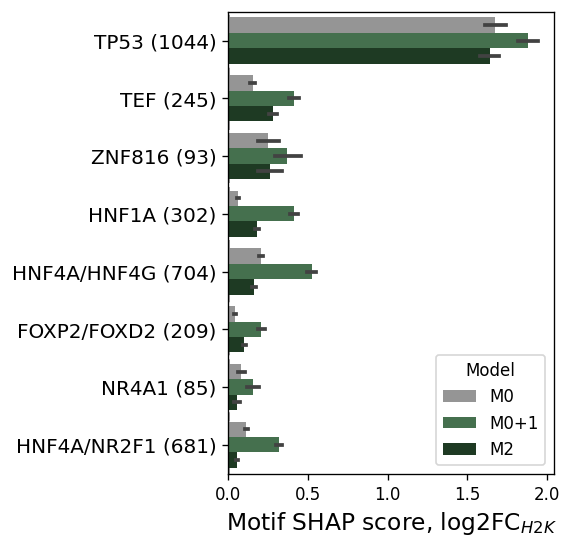

In [236]:


palette = {
    'M0': sns.color_palette("Grays", 5)[2],
    # 'R1-D': custom_green_palette[1],
    # 'M1': custom_green_palette[2],
    'M0+1': custom_green_palette[3],
    'M2': custom_green_palette[4],
}

plt.figure(figsize=(3.5,5))
# order=filt_sort_index
# sns.boxplot(y='cluster',x='shap_score',hue='model',data=hepg2_shap_df,palette=palette,fliersize=1,
#             order=list(cluster_order))
# sns.barplot(y='cluster',x='shap_score',hue='model',data=cur_shap_df,palette=palette,
#             order=list(clusters_to_plot),hue_order=['M0','M1','M2'])
sns.barplot(y='cluster',x='shap_score',hue='model',data=cur_shap_df,palette=palette,
            order=list(cluster_order),hue_order=['M0','M0+1','M2'])
# draw vertical line at 0
plt.axvline(x=0, color='gray', linestyle='--',zorder=0)
# change yticks to add the value count of that cluster in cluster_shap_df - divide by 3 because each motif occurs once per model type
yticks = [f'{cluster_name_dict[cluster]} ({cur_shap_df[cur_shap_df["cluster"]==cluster].shape[0]//3})' for cluster in cluster_order]
plt.yticks(np.arange(len(cluster_order)),yticks)


# increase ytick font size
plt.yticks(fontsize=12)
plt.ylabel('')
plt.xlabel('Motif SHAP score, log2FC$_{H2K}$',fontsize=14)
# change legend title to 'Cell Type'
plt.legend(title='Model')
# plt.savefig('figure_dir/general_exam_figs/fig4_motif_shap.png',dpi=500,bbox_inches='tight')
# plt.show()

# save figure
plt.savefig(f'{revision_figure_dir}/hepg2_motif_shape.png',dpi=500,bbox_inches='tight')

# replace cluster labels with cluster names
# convert into bar rather than boxplot
# figure out which motifs to show
# possibly try heatmap instead of barplot to match enrichment plot? Only 3 categories means bar is possibly feasible but could get too crowded still
# unless I keep as supplementary figure that just takes up a large amount of data
# yeah heatmap I think would be too hard to see differences on the small end
# come up with script to calculate significances...

In [ ]:
shap_dir = 'shap_values_for_revision'
model_names = ['M2','M1','M0']
dataset_names = ['R2','R1-MPRA','R1-DHS','R0']

# process the analysis_df to remove sequences w/ no calculation for SHAP values

exluded_model_types = ['dhs64_finetuned','dhs62_finetuned','sabetti_ctrl']
excluded_design_types = ['fsp_minimal_concatemer','concatemer','sabetti_ctrl']

motif_df_dict = {
    'R0': d1_final_df.copy(),
    'R1-MPRA': d2_final_df.copy(),
    'R1-DHS': dhs_final_df.copy(),
    'R2': d3_final_df.copy()
}


deseq_df_dict = {
    'R0': d1_deseq_plus_cluster_cnts_df.sample(3000,random_state=0).copy(),
    'R1-MPRA': d2_deseq_plus_cluster_cnts_df[d2_deseq_plus_cluster_cnts_df['design_type'] != 'control'].copy(),
    'R1-DHS': dhs_deseq_df.copy(),
    'R2': d3_deseq_plus_cluster_cnts_df[(~d3_deseq_plus_cluster_cnts_df['model_type'].isin(exluded_model_types)) & (~d3_deseq_plus_cluster_cnts_df['design_type'].isin(excluded_design_types))].copy()
}


In [166]:
print(f"R0: {deseq_df_dict['R0']['cluster_41'].sum()}")
print(f"R1-MPRA: {deseq_df_dict['R1-MPRA']['cluster_41'].sum()}")
print(f"R1-DHS: {deseq_df_dict['R1-DHS']['cluster_41'].sum()}")
print(f"R2: {deseq_df_dict['R2']['cluster_41'].sum()}")

R0: 0.0
R1-MPRA: 28.0
R1-DHS: 35.0
R2: 290.0


In [174]:
cluster = 'cluster_41'
cur_shap_df[cur_shap_df["cluster"]==cluster].groupby('sequence_name')['model'].value_counts()

sequence_name                              model
42_HepG2_1890_317                          M0       1
                                           M0+1     1
                                           M2       1
42_HepG2_2230_177                          M0       1
                                           M0+1     1
                                                   ..
designed_d2_dhs_fsp_target_0_HEPG2_seq_96  M0+1     1
                                           M2       1
designed_d2_dhs_fsp_target_0_HEPG2_seq_99  M0       1
                                           M0+1     1
                                           M2       1
Name: count, Length: 906, dtype: int64

In [160]:
m0_shap_dict = model_shap_dict['M1'].copy()

m0_shap_dict[m0_shap_dict['cluster']=='cluster_41']['dataset'].value_counts()

dataset
R2         870
R1-DHS     105
R1-MPRA     84
Name: count, dtype: int64

In [105]:
model_shap_dict.keys()

dict_keys(['M2', 'M1', 'M0'])

In [263]:
""""What do I want? (a dataframe for a single cluster that has average)

1) select a cluster and extract all instances of cluster across dataset
2) For each row, append new column with the value count of the sequence_name

"""
cur_model = 'M2'

cur_cluster = 'cluster_2'


cur_cluster_df = model_shap_dict[cur_model][model_shap_dict[cur_model]['cluster'] == cur_cluster].copy()

# do this for K562 enhancers
# cur_cluster_df.loc[cur_cluster_df['cell_type']=='Delta','shap_score'] *= -1

# get the value count of sequence_name for each cluster
cur_cluster_df['sequence_name'].value_counts()

# mult_map = cur_cluster_df[cur_cluster_df[]]

# divide by 3 since there will be a value for each of the HepG2, K562, and H2K for each motif instance
cur_cluster_df['multiplicity'] = cur_cluster_df['sequence_name'].map(cur_cluster_df['sequence_name'].value_counts()) // 3

# add column to cur_cluster_df that has number of unique dataset values for each sequence_name
cur_cluster_df['n_datasets'] = cur_cluster_df['sequence_name'].map(cur_cluster_df.groupby('sequence_name')['dataset'].nunique())

# divide multiplicity col by n_datasets col
cur_cluster_df['multiplicity'] = cur_cluster_df['multiplicity'] / cur_cluster_df['n_datasets']

# drop rows with non-integer multiplicities
cur_cluster_df = cur_cluster_df[cur_cluster_df['multiplicity'] == cur_cluster_df['multiplicity'].astype(int)]

cur_cluster_df['multiplicity'].value_counts().sort_index()

multiplicity
1.0    1554
2.0    1068
3.0     189
4.0      12
Name: count, dtype: int64

In [262]:
cur_cluster_df[cur_cluster_df['sequence_name']=='d2_seq_201']

cluster cell_type  shap_score sequence_name  dataset  multiplicity  \
7987  cluster_2     HEPG2    0.075259    d2_seq_201  R1-MPRA           1.5   
8088  cluster_2      K562   -0.035675    d2_seq_201  R1-MPRA           1.5   
8189  cluster_2     Delta    0.110934    d2_seq_201  R1-MPRA           1.5   
5839  cluster_2     HEPG2    0.069525    d2_seq_201       R2           1.5   
5840  cluster_2     HEPG2    0.124950    d2_seq_201       R2           1.5   
6463  cluster_2      K562   -0.030514    d2_seq_201       R2           1.5   
6464  cluster_2      K562   -0.106454    d2_seq_201       R2           1.5   
7087  cluster_2     Delta    0.100039    d2_seq_201       R2           1.5   
7088  cluster_2     Delta    0.231403    d2_seq_201       R2           1.5   

      n_datasets  
7987           2  
8088           2  
8189           2  
5839           2  
5840           2  
6463           2  
6464           2  
7087           2  
7088           2

<Axes: >

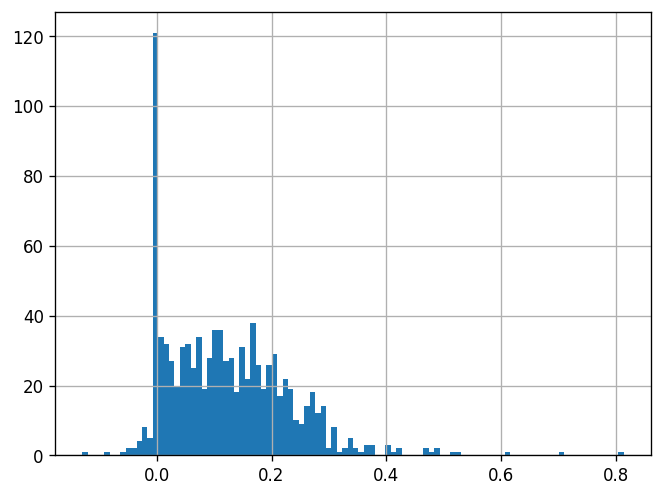

In [264]:
cur_cluster_df[cur_cluster_df['cell_type']=='Delta']['shap_score'].hist(bins=100)

([<matplotlib.axis.XTick at 0x21002c18dd0>,
 [Text(0, 0, '1.0\n(518)'),
  Text(1, 0, '2.0\n(356)'),
  Text(2, 0, '3.0\n(63)'),
  Text(3, 0, '4.0\n(4)')])

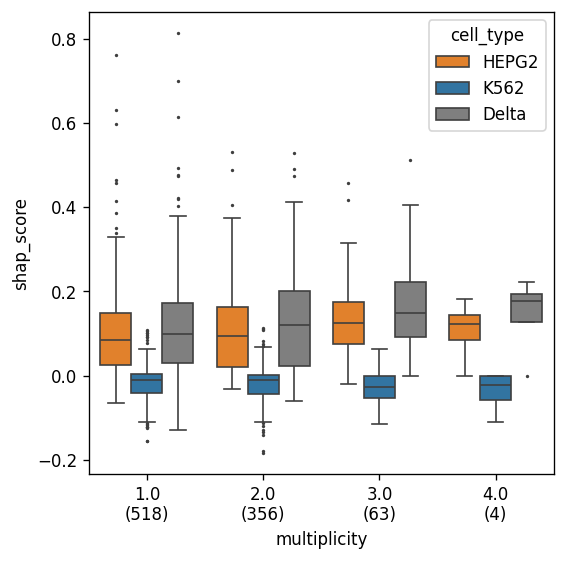

In [ ]:
# plot shap_score vs multiplicity as boxplots for each cell type, with hue=cell_type

# boxplot of shap scores by cluster, hue=cell_type

palette = {
    'HEPG2': 'tab:orange',
    'K562': 'tab:blue',
    'Delta': 'tab:gray'
}




M1: 315
M1: 624
M2: 315


C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\4037337771.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i*2 + j].set_xticklabels(xticks)
C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\4037337771.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i*2 + j].set_xticklabels(xticks)
C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\4037337771.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i*2 + j].set_xticklabels(xticks)


M2: 624


C:\Users\Chris\AppData\Local\Temp\ipykernel_17376\4037337771.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i*2 + j].set_xticklabels(xticks)


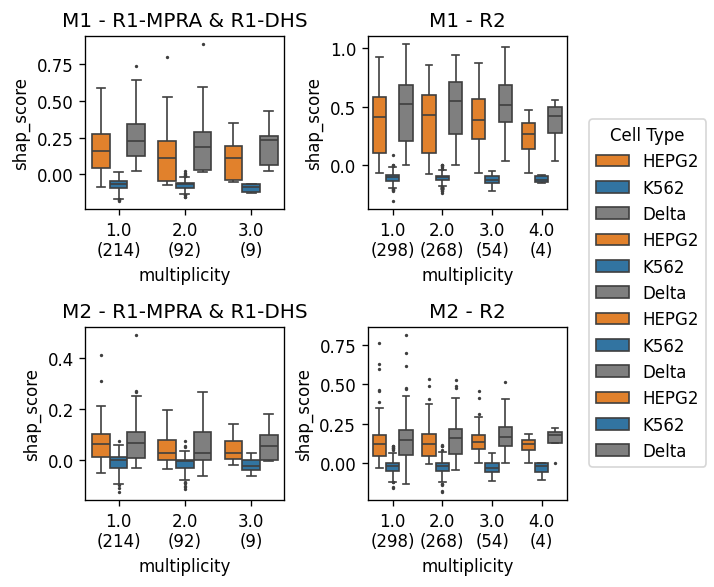

In [283]:
"""
- plot above for HNF4A/HNF4G for M1 and M2, only for R1 and R2 sequences (4 plots)
- so I need a loop to subset the right sequences
- I also want a 5th plot that's 3 subplots and shows mean shap vs multiplicity for all datasets


"""

""""What do I want? (a dataframe for a single cluster that has average)

1) select a cluster and extract all instances of cluster across dataset
2) For each row, append new column with the value count of the sequence_name

"""


cur_cluster = 'cluster_2'

fig, axes = plt.subplots(2, 2, figsize=(6, 5))
axes = axes.flatten()

for i, cur_model in enumerate(['M1', 'M2']):
    for j, cur_datasets in enumerate([['R1-MPRA', 'R1-DHS'], ['R2']]):

        cur_cluster_df = model_shap_dict[cur_model][model_shap_dict[cur_model]['cluster'] == cur_cluster].copy()
        cur_cluster_df = cur_cluster_df[cur_cluster_df['dataset'].isin(cur_datasets)]

        # get the value count of sequence_name for each cluster
        cur_cluster_df['sequence_name'].value_counts()

        # divide by 3 since there will be a value for each of the HepG2, K562, and H2K for each motif instance
        cur_cluster_df['multiplicity'] = cur_cluster_df['sequence_name'].map(cur_cluster_df['sequence_name'].value_counts()) // 3

        # add column to cur_cluster_df that has number of unique dataset values for each sequence_name
        cur_cluster_df['n_datasets'] = cur_cluster_df['sequence_name'].map(cur_cluster_df.groupby('sequence_name')['dataset'].nunique())

        # divide multiplicity col by n_datasets col
        cur_cluster_df['multiplicity'] = cur_cluster_df['multiplicity'] / cur_cluster_df['n_datasets']

        # drop rows with non-integer multiplicities
        cur_cluster_df = cur_cluster_df[cur_cluster_df['multiplicity'] == cur_cluster_df['multiplicity'].astype(int)]

        print(f'{cur_model}: {cur_cluster_df[cur_cluster_df["cell_type"]=="Delta"].shape[0]}')

        sns.boxplot(y='shap_score', x='multiplicity', data=cur_cluster_df, hue='cell_type', palette=palette, fliersize=1, ax=axes[i*2 + j])
        # add the value counts in parentheses to the xticks
        xticks = np.sort(cur_cluster_df['multiplicity'].unique())
        xticks = [f'{tick}\n({cur_cluster_df[cur_cluster_df["multiplicity"]==tick].shape[0]//3})' for tick in xticks] # divide by 3 since occurs once per cell type
        axes[i*2 + j].set_xticklabels(xticks)
        axes[i*2 + j].set_title(f'{cur_model} - {" & ".join(cur_datasets)}')
        # remove legend
        axes[i*2 + j].get_legend().remove()

plt.tight_layout()
# add legend to right of plot
fig.subplots_adjust(right=0.8)
fig.legend(title='Cell Type', loc='center right')

plt.show()


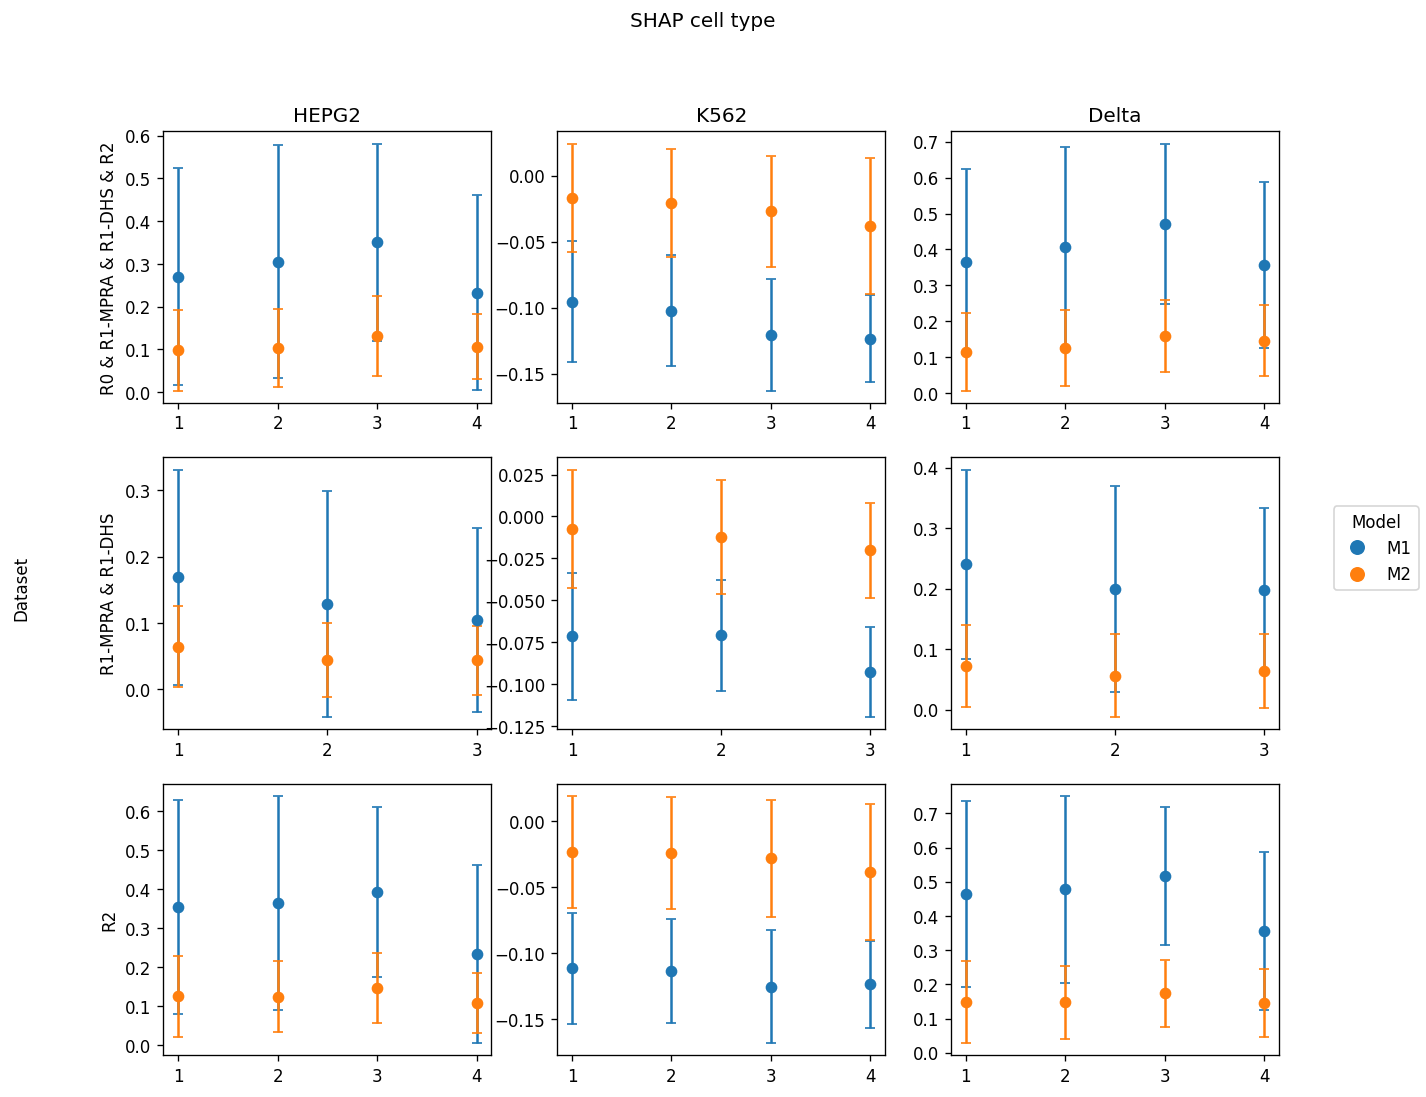

In [323]:
"""
- plot above for HNF4A/HNF4G for M1 and M2, only for R1 and R2 sequences (4 plots)
- so I need a loop to subset the right sequences
- I also want a 5th plot that's 3 subplots and shows mean shap vs multiplicity for all datasets


"""

""""What do I want? (a dataframe for a single cluster that has average)

1) select a cluster and extract all instances of cluster across dataset
2) For each row, append new column with the value count of the sequence_name

"""



cur_cluster = 'cluster_2'

# Okay I want a 3x3 subplot, where for each row I have mean and std deviation of SHAP score at each multiplicity for M1, M2, M0, where columns are HepG2, K562, and Delta
# each row is on a different subset of sequences: all, R1-DHS or R1-MPRA, and R2
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.flatten()

for row_idx, cur_datasets in enumerate([['R0', 'R1-MPRA', 'R1-DHS', 'R2'], ['R1-MPRA', 'R1-DHS'], ['R2']]):

        # generate cur_cluster_df, combining M1 and M2 models
        cur_cluster_df_m1 = model_shap_dict['M1'][model_shap_dict[cur_model]['cluster'] == cur_cluster].copy()
        # add model column to cur_cluster_df
        cur_cluster_df_m1['model'] = 'M1'
        cur_cluster_df_m2 = model_shap_dict['M2'][model_shap_dict[cur_model]['cluster'] == cur_cluster].copy()
        cur_cluster_df_m2['model'] = 'M2'
        cur_cluster_df = pd.concat([cur_cluster_df_m1,cur_cluster_df_m2],ignore_index=True)
        
        cur_cluster_df = cur_cluster_df[cur_cluster_df['dataset'].isin(cur_datasets)]

        # get the value count of sequence_name for each cluster
        cur_cluster_df['sequence_name'].value_counts()

        # divide by 3 since there will be a value for each of the HepG2, K562, and H2K for each motif instance
        cur_cluster_df['multiplicity'] = cur_cluster_df['sequence_name'].map(cur_cluster_df['sequence_name'].value_counts()) // 3

        # add column to cur_cluster_df that has number of unique dataset values for each sequence_name
        cur_cluster_df['n_datasets'] = cur_cluster_df['sequence_name'].map(cur_cluster_df.groupby('sequence_name')['dataset'].nunique())

        # divide multiplicity col by n_datasets col
        cur_cluster_df['multiplicity'] = cur_cluster_df['multiplicity'] / cur_cluster_df['n_datasets']

        # also divide multiplicity col by 2 since I am collecting values for 2 models
        cur_cluster_df['multiplicity'] = cur_cluster_df['multiplicity'] / 2

        # drop rows with non-integer multiplicities
        cur_cluster_df = cur_cluster_df[cur_cluster_df['multiplicity'] == cur_cluster_df['multiplicity'].astype(int)]

        # group by multiplicity and model and get mean and std of shap_score
        cur_plot_df = cur_cluster_df.groupby(['multiplicity', 'cell_type','model'])['shap_score'].agg(['mean', 'std']).reset_index()

        # plot mean and std of shap_score for each multiplicity, cell_type, and model
        for col_idx,cell_type in enumerate(['HEPG2','K562','Delta']):
            cur_cell_type_df = cur_plot_df[cur_plot_df['cell_type'] == cell_type]
            # axes[row_idx*3 + col_idx].errorbar(x='multiplicity', y='mean', yerr='std', data=cur_cell_type_df, label=cell_type, fmt='o', capsize=3)
            for model in ['M1','M2']:
                cur_model_df = cur_cell_type_df[cur_cell_type_df['model'] == model]
                axes[row_idx*3 + col_idx].errorbar(x='multiplicity', y='mean', yerr='std', data=cur_model_df, label=model, fmt='o', capsize=3)

                # set xtick increments to be 1
                axes[row_idx*3 + col_idx].set_xticks(np.arange(1,cur_plot_df['multiplicity'].max()+1))

        axes[row_idx*3].set_ylabel(f'{" & ".join(cur_datasets)}')
        # set titles for each column to be cell_type

# set titles of first row of plots to be cell type
for i,cell_type in enumerate(['HEPG2','K562','Delta']):
    axes[i].set_title(cell_type)

# add single legend to whole figure to the right, only show one M1 and one M2
fig.subplots_adjust(right=0.9)
# create legend handles
handles = [plt.Line2D([0], [0], marker='o', color='w', label='M1', markerfacecolor='tab:blue', markersize=10),
           plt.Line2D([0], [0], marker='o', color='w', label='M2', markerfacecolor='tab:orange', markersize=10)]
fig.legend(handles=handles, title='Model', loc='center right')

# overall figure ylabel = dataset
fig.text(0.02, 0.5, 'Dataset', va='center', rotation='vertical')

# overall figure title = SHAP cell type
fig.suptitle('SHAP cell type')


        


        # for col_idx,cell_type in enumerate(['HEPG2','K562','Delta']):
        #     cur_cell_type_df = cur_plot_df[cur_plot_df['cell_type'] == cell_type]
        #     axes[row_idx*3 + col_idx].errorbar(x='multiplicity', y='mean', yerr='std', data=cur_cell_type_df, label=cell_type, fmt='o', capsize=3)

        # axes[row_idx*3].set_title(f'{" & ".join(cur_datasets)}')


# plt.tight_layout()
# # add legend to right of plot
# fig.subplots_adjust(right=0.8)
# fig.legend(title='Cell Type', loc='center right')

plt.show()


### R3.6 - motif co-occurrence analysis ###

In [ ]:
"""

Identify a statistical test that looks at enrichment of motif combinations relative to a quantitative metric

"""

In [250]:
# Idea 1: identify any motifs that have co-occurence enrichment according to the statistic in the USF paper
# then, calculate stratified mean H2K scores for sequences with combination vs w/ only one, stratifying by number of motifs somehow (extend TP53 + HNF4A analysis)
# update: the USF metric seems to be flawed, the formula doesn't make sense
# I guess I should just try to set up stratification test and do it on manually selected motif combinations (whatever motifs occur in the top enhancers?)

# import function for calculation binary coefficient
from scipy.special import binom

# preferential colocalization significance test
def p_c(N,Na,Nb,M):
    """
    N: total number of sequences with motif A or B
    Na: number of sites with motif A
    Nb: number of sites with motif B
    M: number of sites with both motifs
    """
    s = 0
    # i=0 to M-1binom
    for i in range(M):
        num = binom(Na,i) * binom(N-Na,Nb-i)
        den = binom(N,Nb)
        s += num/den

        print(f'{s:.1e}')
    return 1-s

# get the analysis df of R2 sequences

model_types = ['d1_finetuned', 'd2_dhs', 'd2_meas','D2','shuffled'] # for direct d2 iteration only
design_types = ['fsp','fsp_clipped','d2_rand_ctrl','d2_top_ctrl','NC','fsp_minimal']
analysis_df = d3_deseq_plus_cluster_cnts_df[(d3_deseq_plus_cluster_cnts_df['model_type'].isin(model_types)) & (d3_deseq_plus_cluster_cnts_df['design_type'].isin(design_types))].copy()

cluster_A = 'cluster_50'
cluster_B = 'cluster_2'
cur_analysis_df = analysis_df[analysis_df['cell_type']=='HEPG2']
# cur_analysis_df = analysis_df[analysis_df[cluster_A]+analysis_df[cluster_B] > 0].copy()
print(cur_analysis_df.shape)

N = cur_analysis_df.shape[0]
Na = cur_analysis_df[cur_analysis_df[cluster_A] > 0].shape[0]
Nb = cur_analysis_df[cur_analysis_df[cluster_B] > 0].shape[0]
M = cur_analysis_df[(cur_analysis_df[cluster_A] > 0) & (cur_analysis_df[cluster_B] > 0)].shape[0]
print(N,Na,Nb,M)

(504, 67)
504 476 334 326


In [270]:
# treat cluster A as rows, cluster B as columns, generate contingency table
cluster_A = 'cluster_50'
cluster_B = 'cluster_2'

A_no_B = cur_analysis_df[(cur_analysis_df[cluster_A] > 0) & (cur_analysis_df[cluster_B] == 0)].shape[0]
A_and_B = cur_analysis_df[(cur_analysis_df[cluster_A] > 0) & (cur_analysis_df[cluster_B] > 0)].shape[0]
B_no_A = cur_analysis_df[(cur_analysis_df[cluster_A] == 0) & (cur_analysis_df[cluster_B] > 0)].shape[0]
neither = cur_analysis_df[(cur_analysis_df[cluster_A] == 0) & (cur_analysis_df[cluster_B] == 0)].shape[0]

contingency_table = np.array([[A_and_B,A_no_B],[B_no_A,neither]])
# contingency_table = np.array([[neither,B_no_A],[A_no_B,A_and_B]])
print(contingency_table)

# fisher exact test
oddsratio, pvalue = stats.fisher_exact(contingency_table,alternative='two-sided')
print(f'{pvalue:.1e}')

[[326 150]
 [  8  20]]
3.8e-05


C:\Users\Chris\AppData\Local\Temp\ipykernel_4084\2573819697.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bluesBig = matplotlib.cm.get_cmap('Blues', 512)
C:\Users\Chris\AppData\Local\Temp\ipykernel_4084\2573819697.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orangesBig = matplotlib.cm.get_cmap('Oranges', 512)


47 clusters
HEPG2 clusters: 9
K562 clusters: 8
3.0


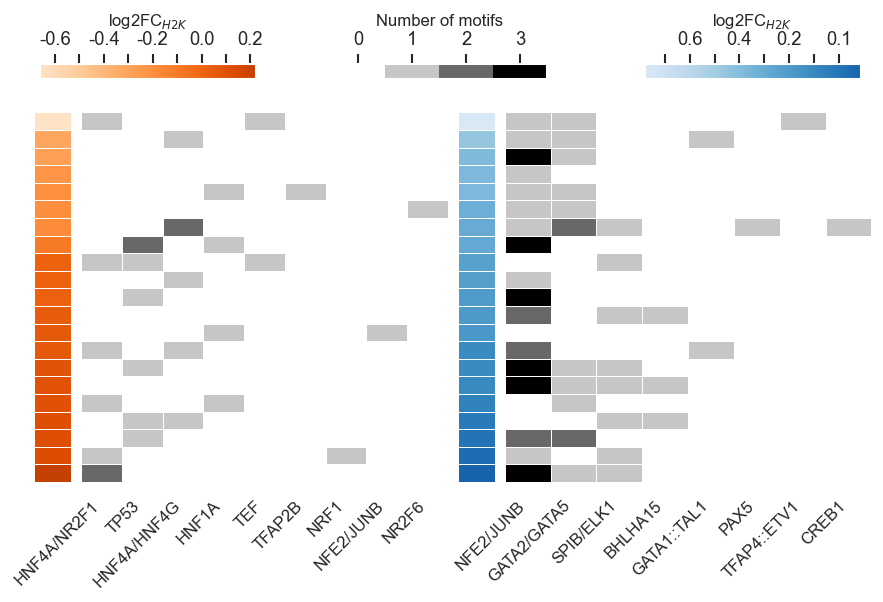

In [37]:
### Okay I think this should be d1_ft, d2_dhs, and d2_meas, exclude all the dhs64 and dhs62 designs but keep everything else ###
from matplotlib.ticker import FormatStrFormatter

model_types = ['d1_finetuned','d2_dhs']
# design_types = ['fsp','fsp_clipped','fsp_tgt','fsp_minimal','nonmotif_masked_fsp','fsp_minimal_concatemer']
design_types = ['fsp','fsp_clipped','fsp_tgt']
analysis_df = d3_deseq_plus_cluster_cnts_df.loc[(d3_deseq_plus_cluster_cnts_df['model_type'].isin(model_types))&(d3_deseq_plus_cluster_cnts_df['design_type'].isin(design_types))].copy()



bluesBig = matplotlib.cm.get_cmap('Blues', 512)
blues_trunc_cm = matplotlib.colors.ListedColormap(bluesBig(np.linspace(0.15, 0.8, 256)))
# create reverse version of blues_trunc_cm
blues_trunc_cm_r = matplotlib.colors.ListedColormap(bluesBig(np.linspace(0.8, 0.15, 256)))

orangesBig = matplotlib.cm.get_cmap('Oranges', 512)
oranges_trunc_cm = matplotlib.colors.ListedColormap(orangesBig(np.linspace(0.15, 0.8, 256)))

# create new numpy array that's n_seqs x n_clusters
clusters = np.array([col for col in analysis_df.columns if col.startswith('cluster_')])
print(f'{len(clusters)} clusters')

hepg2_df = analysis_df[analysis_df['cell_type']=='HEPG2']
k562_df = analysis_df[analysis_df['cell_type']=='K562']
# sort hepg2_df in descending order of log2FoldChange_H2K_deseq
hepg2_df = hepg2_df.sort_values(by=H2K_COL,ascending=True)
# sort k562_df in ascending order of log2FoldChange_H2K_deseq
k562_df = k562_df.sort_values(by=H2K_COL,ascending=False)

hepg2_sort_inds = np.argsort(np.array(hepg2_df[clusters]).sum(axis=0))[::-1]
k562_sort_inds = np.argsort(np.array(k562_df[clusters]).sum(axis=0))[::-1]

###########################################################################################

# okay, this was sort of all right. maybe let's try looking at only the top 50% of sequences, and dropping any columns that are all 0s
# maybe want to replace percentile with single number so plot is more symmetric
percentile = 0.05

# get maximum of int(len(hepg2_df)*percentile) and int(len(k562_df)*percentile)
n_seqs = max(int(len(hepg2_df)*percentile),int(len(k562_df)*percentile))


hepg2_df_filt = hepg2_df.head(n_seqs)
k562_df_filt = k562_df.head(n_seqs)

hepg2_clusters = np.array([cluster for cluster in clusters if np.array(hepg2_df_filt[cluster]).sum()>0])
k562_clusters = np.array([cluster for cluster in clusters if np.array(k562_df_filt[cluster]).sum()>0])

print(f'HEPG2 clusters: {len(hepg2_clusters)}')
print(f'K562 clusters: {len(k562_clusters)}')

# okay let's redo those heatmaps now!

hepg2_max = hepg2_df_filt[hepg2_clusters].max().max()
k562_max = k562_df_filt[k562_clusters].max().max()

global_max = max(hepg2_max,k562_max)
print(global_max)

vmin = 0
# vmax = dw_deseq_plus_cluster_cnts_df['n_motifs'].max()
vmax = global_max

# make the cmap for heatmap
n_colors = int(vmax-vmin+1)
colors = plt.cm.Greys(np.linspace(0, 1, n_colors))
# colors = plt.cm.Greys(np.array([0,0.3,0.4,0.5,0.6,0.7]))
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_colors)

# set h2k_vmax to be the max abs H2K_COL between hepg2_df_filt and k562_df_filt
h2k_vmax = max(abs(hepg2_df_filt[H2K_COL]).max(),abs(k562_df_filt[H2K_COL]).max())
# set h2k_vmin to be min abs H2K_COL between hepg2_df_filt and k562_df_filt
h2k_vmin = min(abs(hepg2_df_filt[H2K_COL]).min(),abs(k562_df_filt[H2K_COL]).min())

# plot np.array(hepg2_df_filt[hepg2_clusters]) as heatmap with rows corresponding to sequences and columns the motifs
n_clusters_to_plot = 9
hepg2_filt_sort_inds = np.argsort(np.array(hepg2_df_filt[hepg2_clusters]).sum(axis=0))[::-1][:n_clusters_to_plot]
k562_filt_sort_inds = np.argsort(np.array(k562_df_filt[k562_clusters]).sum(axis=0))[::-1][:n_clusters_to_plot]

# set figure width based on number of clusters, using a constant width_per_cluster
width_per_cluster = 5
# fig_width = width_per_cluster * len(hepg2_clusters)
fig_width = width_per_cluster *(len(hepg2_clusters)+len(k562_clusters))

# make 2 side by side subplots
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4,figsize=(9,4),sharey=True,gridspec_kw={'width_ratios': [1,10,1,10]})
# plot hepg2 heatmap
sns.heatmap(np.array(hepg2_df_filt[hepg2_clusters])[:,hepg2_filt_sort_inds],xticklabels=hepg2_clusters[hepg2_filt_sort_inds],cmap=cmap,
            cbar=False,ax=ax1,vmin=vmin,vmax=vmax,edgecolor='white',linewidth=0.5)
# remove yticks
ax1.set_yticks([])
# ax1.set_title(f'HEPG2')
ax1.set_xticklabels([cluster_name_dict[cluster] for cluster in hepg2_clusters[hepg2_filt_sort_inds]],fontsize=TEXT_FSIZE,rotation=45,ha='right')
# plot hepg2 log2(H2K):
sns.heatmap(hepg2_df_filt[H2K_COL].values.reshape(-1, 1), cmap=oranges_trunc_cm, cbar=False, ax=ax0,annot=False,
            fmt='.1f',edgecolor='white',linewidth=0.5) #,vmin=h2k_vmin,vmax=h2k_vmax

# plot k562 heatmap
sns.heatmap(np.array(k562_df_filt[k562_clusters])[:,k562_filt_sort_inds],xticklabels=k562_clusters[k562_filt_sort_inds],cmap=cmap,
            cbar=False,ax=ax3,vmin=vmin,vmax=vmax,edgecolor='white',linewidth=0.5)
# remove yticks
ax3.set_yticks([])
# ax3.set_title(f'K562')
ax3.set_xticklabels([cluster_name_dict[cluster] for cluster in k562_clusters[k562_filt_sort_inds]],fontsize=TEXT_FSIZE,rotation=45,ha='right')
# plot k562 log2(H2K):
sns.heatmap(k562_df_filt[H2K_COL].values.reshape(-1, 1), cmap=blues_trunc_cm_r, cbar=False, ax=ax2,annot=False,
            fmt='.1f',edgecolor='white',linewidth=0.5) #,vmin=-h2k_vmax,vmax=-h2k_vmin

# set overall figure title
# fig.suptitle(f'Motifs in top {int(percentile*100)}% of sequences\n')

# add colorbar below the subplots
# cbar_ax = fig.add_axes([0.3, -0.175, 0.4, 0.03])
from matplotlib.ticker import MaxNLocator
cbar_ax = fig.add_axes([0.4, 0.95, 0.2, 0.03])

boundaries = np.linspace(vmin - 0.5, vmax + 0.5, n_colors + 1)
ticks = np.arange(vmin, vmax + 1)

cb = fig.colorbar(ax1.collections[0], cax=cbar_ax,orientation='horizontal',label='Number of motifs',shrink=0.01,drawedges=False,boundaries=boundaries,ticks=ticks,format="%d")
# plt.colorbar(ticks=ticks, boundaries=boundaries, format="%d", orientation='vertical')
# cb = fig.colorbar(ax1.collections[0], cax=cbar_ax,orientation='horizontal',label='Number of motifs',shrink=0.01,drawedges=False,boundaries=np.arange(0,vmax+1,1),ticks=np.arange(0,vmax+1,1))
cbar_ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cbar_ax.xaxis.tick_top()
# move title of cbar_ax to above the colorbar
cbar_ax.set_title('Number of motifs',fontsize=TEXT_FSIZE,y=3)
# remove x and y labels
cbar_ax.set_xlabel('')
cbar_ax.set_ylabel('')
# set cb outline to white
cb.outline.set_edgecolor('white')
# set cb ticks to ticks
cb.set_ticks(ticks=ticks,labels=np.arange(vmin,vmax+1).astype(int))


# add colorbar for H2K for HEPG2 seqs to the left of cbar_ax
cbar_ax_hepg2_h2k = fig.add_axes([0.13, 0.95, 0.2, 0.03])
cb_hepg2 = fig.colorbar(ax0.collections[0], cax=cbar_ax_hepg2_h2k,orientation='horizontal',label='log2(HEPG2/K562)',shrink=0.01,drawedges=False)
cbar_ax_hepg2_h2k.xaxis.set_major_locator(MaxNLocator(integer=True))
# move ticks above colorbar
cbar_ax_hepg2_h2k.xaxis.tick_top()
# move title of cbar_ax to above the colorbar
cbar_ax_hepg2_h2k.set_title('log2FC$_{H2K}$',fontsize=TEXT_FSIZE,y=3)
# remove x and y labels
cbar_ax_hepg2_h2k.set_xlabel('')
cbar_ax_hepg2_h2k.set_ylabel('')
# set tick formating to .1f
cbar_ax_hepg2_h2k.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# set colorbar outline to white
cb_hepg2.outline.set_edgecolor('white')


# add colorbar for H2K for K562 seqs to the right of cbar_ax
cbar_ax_k562_h2k = fig.add_axes([0.69, 0.95, 0.2, 0.03])
cb_k562 = fig.colorbar(ax2.collections[0], cax=cbar_ax_k562_h2k,orientation='horizontal',label='log2(K562/HEPG2)',shrink=0.01,drawedges=False)
cbar_ax_k562_h2k.xaxis.set_major_locator(MaxNLocator(integer=True))
# move ticks above colorbar
cbar_ax_k562_h2k.xaxis.tick_top()
# move title of cbar_ax to above the colorbar
cbar_ax_k562_h2k.set_title('log2FC$_{H2K}$',fontsize=TEXT_FSIZE,y=3)
# remove x and y labels
cbar_ax_k562_h2k.set_xlabel('')
cbar_ax_k562_h2k.set_ylabel('')
# set tick formating to .1f
# impoer FormatStrFormatter from matplotlib.ticker
from matplotlib.ticker import FormatStrFormatter
cbar_ax_k562_h2k.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# reverse the order of the colorbar
cbar_ax_k562_h2k.invert_xaxis()
# set colorbar outline to white
cb_k562.outline.set_edgecolor('white')


# cbar = fig.colorbar(sns.heatmap(np.array(hepg2_df_filt[hepg2_clusters])[:,hepg2_filt_sort_inds],xticklabels=hepg2_clusters[hepg2_filt_sort_inds],cmap='bone_r',cbar=False,ax=ax1,vmin=vmin,vmax=vmax),cax=cbar_ax,orientation='horizontal')

# only show integer xticks on colorbar
# import MaxNLocator from matplotlib.ticker



# remove yticks from ax0 and ax2
ax0.set_yticks([])
ax2.set_yticks([])
# remove xticks from ax0 and ax2
ax0.set_xticks([])
ax2.set_xticks([])
# decrease space between ax0 and ax1
plt.subplots_adjust(wspace=0.05)

# plot every other xtick label on cbar_ax_hepg2_h2k
for i,tick in enumerate(cbar_ax_hepg2_h2k.get_xticklabels()):
    if i%2==0:
        tick.set_visible(False)

# plot every other xtick label on cbar_ax_k562_h2k
for i,tick in enumerate(cbar_ax_k562_h2k.get_xticklabels()):
    if i%2==0:
        tick.set_visible(False)


# save figure at 600 dpi
# plt.savefig(f'{fig2_dir}/d3_top{int(percentile*100)}pct_motifs_heatmap.png',dpi=600,bbox_inches='tight')
# save as svg
# plt.savefig(f'{fig2_dir}/d3_top{int(percentile*100)}pct_motifs_heatmap.svg',bbox_inches='tight')

plt.show()

### R3.7 - nonmotif reoptimization additional statistics ###

In [265]:
# Okay, compare median activitiys for reopt to fully opt

model_types = ['d1_finetuned']
design_types = ['fsp','nonmotif_masked_fsp']
analysis_df = d3_seq_df[(d3_seq_df['model_type'].isin(model_types)) & (d3_seq_df['design_type'].isin(design_types))].copy()

# wilcoxon ranksum test for HEPG2_COL, K562_COL, and H2K_COL between fully optimized and reoptimized sequences, stratified by cell type

results_df = pd.DataFrame(columns=['cell_type','metric','med_fsp','med_nonmotif','pvalue'])

for cell_type in ['HEPG2','K562']:
    cur_analysis_df = analysis_df[analysis_df['cell_type']==cell_type]
    for metric in [HEPG2_COL,K562_COL,H2K_COL]:
        med_fsp = cur_analysis_df[cur_analysis_df['design_type']=='fsp'][metric].median()
        med_nonmotif = cur_analysis_df[cur_analysis_df['design_type']=='nonmotif_masked_fsp'][metric].median()

        _, pvalue = stats.ranksums(cur_analysis_df[cur_analysis_df['design_type']=='fsp'][metric],
                                   cur_analysis_df[cur_analysis_df['design_type']=='nonmotif_masked_fsp'][metric])
        results_df = pd.concat([results_df,pd.DataFrame({'cell_type':cell_type,'metric':metric,'med_fsp':med_fsp,'med_nonmotif':med_nonmotif,'pvalue':pvalue},index=[0])])

# import
from statsmodels.stats.multitest import multipletests
results_df['padj'] = multipletests(results_df['pvalue'],method='fdr_bh')[1]
results_df['bonferonni'] = results_df['pvalue'] * results_df.shape[0]
results_df

C:\Users\Chris\AppData\Local\Temp\ipykernel_25076\1842538055.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df,pd.DataFrame({'cell_type':cell_type,'metric':metric,'med_fsp':med_fsp,'med_nonmotif':med_nonmotif,'pvalue':pvalue},index=[0])])


cell_type                metric   med_fsp  med_nonmotif    pvalue      padj  \
0     HEPG2  log2FoldChange_HepG2  3.792738      3.758565  0.718791  0.923164   
0     HEPG2   log2FoldChange_K562 -2.232016     -2.425947  0.019932  0.109929   
0     HEPG2    log2FoldChange_H2K  5.803444      6.069159  0.036643  0.109929   
0      K562  log2FoldChange_HepG2  0.366793      0.740815  0.487413  0.923164   
0      K562   log2FoldChange_K562  3.626089      3.750991  0.890048  0.923164   
0      K562    log2FoldChange_H2K -3.084117     -2.919717  0.923164  0.923164   

   bonferonni  
0    4.312748  
0    0.119592  
0    0.219858  
0    2.924477  
0    5.340291  
0    5.538986

In [183]:
"""
Mostly pulling statistics, correlation between activitity of generated sequences and proportion of sequence changed (oh yeah there probaby is)
"""

# first, how do activities of reoptimized sequences compare to optimizing the whole enhancer sequence
# start by loading in the reoptimized sequences

model_types = ['d1_finetuned','shuffled_nonmotif'] # these are the only model types with targets
# design_types = ['fsp','d2_rand_ctrl','d2_top_ctrl','NC']
design_types = ['nonmotif_masked_fsp','shuffled_nonmotif']
analysis_df = d3_deseq_plus_cluster_cnts_df[(d3_deseq_plus_cluster_cnts_df['model_type'].isin(model_types)) & (d3_deseq_plus_cluster_cnts_df['design_type'].isin(design_types))].copy()
print(analysis_df.shape[0])

# extract original sequence index from sequence name
analysis_df.loc[analysis_df['design_type']=='nonmotif_masked_fsp','og_seq_idx'] = analysis_df.loc[analysis_df['design_type']=='nonmotif_masked_fsp','sequence_name'].apply(lambda x: int(x.split('_')[-3][3:]))
analysis_df.loc[analysis_df['design_type']=='shuffled_nonmotif','og_seq_idx'] = analysis_df.loc[analysis_df['design_type']=='shuffled_nonmotif','sequence_name'].apply(lambda x: int(x.split('_')[0]))
# set og_seq_idx to int
analysis_df['og_seq_idx'] = analysis_df['og_seq_idx'].astype(int)

# let's do a percentile analysis, I like this one better...for each reoptimized design, obtain how many fully optimized sequences it's better than
# load in subset of sequences that were fully optimized
model_types = ['d1_finetuned'] # or should I just compare to d1_finetuned since these are the models used in the re-opt--yeah
design_types = ['fsp'] # yeah I should compare only to fsp as well
control_df = d3_deseq_plus_cluster_cnts_df[(d3_deseq_plus_cluster_cnts_df['model_type'].isin(model_types)) & (d3_deseq_plus_cluster_cnts_df['design_type'].isin(design_types))].copy()
print(control_df.shape[0])

pthresh = 0.05
better_cols = ['og_seq_idx','num_better']
worse_cols = ['og_seq_idx','num_worse']
better_df = pd.DataFrame(columns=better_cols)
worse_df = pd.DataFrame(columns=worse_cols)

# for each og_seq_idx, extract the H2K activity of the most specific sequence
for og_seq_idx in analysis_df['og_seq_idx'].unique():
    cell_type = analysis_df[analysis_df['og_seq_idx'] == og_seq_idx]['cell_type'].values[0]
    # convert H2K_COL to absolute value
    analysis_df[H2K_COL] = analysis_df[H2K_COL].abs()
    best_seq_idx = analysis_df[(analysis_df['og_seq_idx'] == og_seq_idx)][H2K_COL].idxmax()
    reopt_h2k, reopt_se = analysis_df.loc[best_seq_idx,H2K_COL], analysis_df.loc[best_seq_idx,f'{H2K_SE_COL}']
    print(f'OG Seq Index: {og_seq_idx}, Best reopt H2K: {reopt_h2k:.2f} +/- {reopt_se:.2f}')

    # subset control_df for the relevant cell type
    cur_control_df = control_df[control_df['cell_type'] == cell_type].copy()
    # convert H2K_COL to absolute value
    cur_control_df[H2K_COL] = cur_control_df[H2K_COL].abs()
    # sort by H2K_COL, ascending specifity
    cur_control_df.sort_values(H2K_COL,ascending=True,inplace=True)
    # reindex
    cur_control_df.reset_index(drop=True,inplace=True)
    n_control_seqs = cur_control_df.shape[0]
    # t-test the reopt_h2k against the control_df H2K_COL until it is not greater than the control_df H2K_COL until it is not greater than the control_df H2K_COL
    for i, row in cur_control_df.iterrows():
        # t-test
        p = stats.ttest_ind_from_stats(reopt_h2k,reopt_se,2,row[H2K_COL],row[f'{H2K_SE_COL}'],2,alternative='greater')[1]
        if p < pthresh:
            continue
        else:
            # append to better_df using concat
            better_df = pd.concat([better_df,pd.DataFrame([[og_seq_idx,i]],columns=better_cols)])
            print(f'OG Seq Index: {og_seq_idx}, Better than {i}/{n_control_seqs} fully reoptimized sequences ({i/n_control_seqs:.2f}%)')
            break

    # sort by H2K_COL, descending specifity
    cur_control_df.sort_values(H2K_COL,ascending=False,inplace=True)
    # reindex
    cur_control_df.reset_index(drop=True,inplace=True)
    for i,row in cur_control_df.iterrows():
        p = stats.ttest_ind_from_stats(reopt_h2k,reopt_se,2,row[H2K_COL],row[f'{H2K_SE_COL}'],2,alternative='less')[1]
        if p < pthresh:
            continue
        else:
            worse_df = pd.concat([worse_df,pd.DataFrame([[og_seq_idx,i]],columns=worse_cols)])
            print(f'{cell_type}: {og_seq_idx}, Worse than {i}/{n_control_seqs} fully reoptimized sequences ({i/n_control_seqs:.2f}%)')
            break


149
258
OG Seq Index: 433, Best reopt H2K: 6.82 +/- 0.10
OG Seq Index: 433, Better than 80/129 fully reoptimized sequences (0.62%)
HEPG2: 433, Worse than 4/129 fully reoptimized sequences (0.03%)
OG Seq Index: 905, Best reopt H2K: 6.82 +/- 0.11
OG Seq Index: 905, Better than 80/129 fully reoptimized sequences (0.62%)
HEPG2: 905, Worse than 4/129 fully reoptimized sequences (0.03%)
OG Seq Index: 633, Best reopt H2K: 7.25 +/- 0.13
OG Seq Index: 633, Better than 119/129 fully reoptimized sequences (0.92%)
HEPG2: 633, Worse than 0/129 fully reoptimized sequences (0.00%)
OG Seq Index: 335, Best reopt H2K: 7.35 +/- 0.11
OG Seq Index: 335, Better than 123/129 fully reoptimized sequences (0.95%)
HEPG2: 335, Worse than 0/129 fully reoptimized sequences (0.00%)
OG Seq Index: 667, Best reopt H2K: 6.75 +/- 0.14
OG Seq Index: 667, Better than 80/129 fully reoptimized sequences (0.62%)
HEPG2: 667, Worse than 4/129 fully reoptimized sequences (0.03%)
OG Seq Index: 976, Best reopt H2K: 4.33 +/- 0.17
O

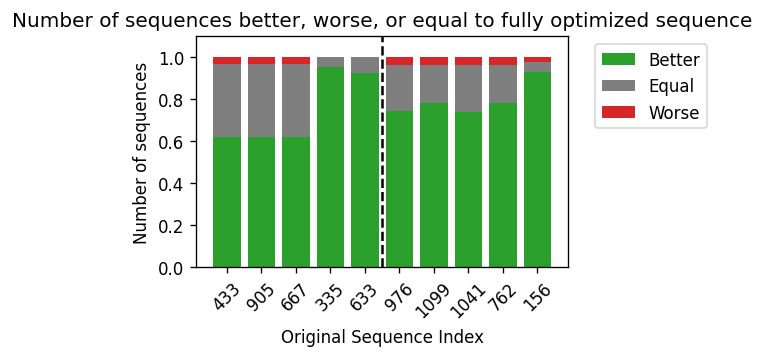

In [276]:
# now, make a stacked barplot for each sequence, showing how many sequences it's better than (green) and how many it's worse than (red), and how many it's equal to (grey)
# merge better and worse dfs into plot_df on og_seq_idx
plot_df = pd.merge(better_df,worse_df,on='og_seq_idx',how='outer')
n_tot = control_df.shape[0]//2
plot_df['num_equal'] = n_tot - plot_df['num_better'] - plot_df['num_worse']
# normalize all columns by n_tot
plot_df['num_better'] = plot_df['num_better']/n_tot
plot_df['num_equal'] = plot_df['num_equal']/n_tot
plot_df['num_worse'] = plot_df['num_worse']/n_tot
# convert og_seq_idx column to string
plot_df['og_seq_idx'] = plot_df['og_seq_idx'].astype(str)


# sort plot_df by xorder to main main text plots
xorder = ['433','905','667','335','633','976','1099','1041','762','156']
plot_df['og_seq_idx'] = pd.Categorical(plot_df['og_seq_idx'],categories=xorder)
plot_df.sort_values('og_seq_idx',inplace=True)

# plot - better, then equal, then worse
plt.figure(figsize=(4,2.5))
plt.bar(plot_df['og_seq_idx'],plot_df['num_better'],color='tab:green')
plt.bar(plot_df['og_seq_idx'],plot_df['num_equal'],bottom=plot_df['num_better'],color='tab:grey')
plt.bar(plot_df['og_seq_idx'],plot_df['num_worse'],bottom=plot_df['num_better']+plot_df['num_equal'],color='tab:red')
plt.xlabel('Original Sequence Index')
plt.ylabel('Number of sequences')
plt.title('Number of sequences better, worse, or equal to fully optimized sequence')
# increase y-axis limit by 0.1
plt.ylim(0,1.1)
# angle xticks
plt.xticks(rotation=45)
# add legend to the right of plot
plt.legend(['Better','Equal','Worse'],bbox_to_anchor=(1.05, 1), loc='upper left')
# draw dashed black vertical line in the middle
plt.axvline(x=4.5,color='black',linestyle='dashed')

In [281]:
d2_final_df.head()

motif_id  motif_alt_id  sequence_name  start  stop strand    score  \
0  MA0106.3          TP53            904      4    21      +  29.1633   
1  MA0089.2  MAFG::NFE2L1            904     30    45      -  12.3483   
2  MA0106.3          TP53            904     44    61      +  24.1633   
3  MA0106.3          TP53            904     76    93      +  29.1633   
4  MA1548.1        PLAGL2            904    115   124      -  15.5738   

        p-value       q-value    matched_sequence  midpt jaspar_cluster  
0  7.380000e-12  2.970000e-08  GACATGCCCGGGCATGTC   12.5     cluster_50  
1  1.300000e-05  3.780000e-02    TACATGACCCAGCACA   37.5      cluster_1  
2  5.100000e-09  2.580000e-06  TACATGTCCGGGCATGCC   52.5     cluster_50  
3  7.380000e-12  2.970000e-08  GACATGCCCGGGCATGTC   84.5     cluster_50  
4  4.020000e-06  3.270000e-02          CGGGCCCCCG  119.5     cluster_62

### R.3.7.2 - how much of the enhancers was changed? ###

In [266]:
# model_types = ['d1_finetuned','shuffled_nonmotif'] # these are the only model types with targets
# design_types = ['fsp','d2_rand_ctrl','d2_top_ctrl','NC']
# design_types = ['nonmotif_masked_fsp','shuffled_nonmotif']

# for this analysis, only look at designed enhancers
model_types = ['d1_finetuned']
design_types = ['nonmotif_masked_fsp']
analysis_df = d3_deseq_plus_cluster_cnts_df[(d3_deseq_plus_cluster_cnts_df['model_type'].isin(model_types)) & (d3_deseq_plus_cluster_cnts_df['design_type'].isin(design_types))].copy()
print(analysis_df.shape[0])

# extract original sequence index from sequence name
analysis_df.loc[analysis_df['design_type']=='nonmotif_masked_fsp','og_seq_idx'] = analysis_df.loc[analysis_df['design_type']=='nonmotif_masked_fsp','sequence_name'].apply(lambda x: int(x.split('_')[-3][3:]))
# analysis_df.loc[analysis_df['design_type']=='shuffled_nonmotif','og_seq_idx'] = analysis_df.loc[analysis_df['design_type']=='shuffled_nonmotif','sequence_name'].apply(lambda x: int(x.split('_')[0]))
# set og_seq_idx to int
analysis_df['og_seq_idx'] = analysis_df['og_seq_idx'].astype(int)


# extract unmodified sequence
for d2_seq_idx in analysis_df['og_seq_idx'].unique():
    if f'd2_seq_{d2_seq_idx:.0f}' in d3_seq_df['sequence_name'].values:
        # print(f'{d2_seq_idx:.0f} is in d3_seq_df')
        # append this row to analysis_df using pd.concat
        analysis_df = pd.concat([analysis_df,d3_deseq_plus_cluster_cnts_df[d3_deseq_plus_cluster_cnts_df['sequence_name']==f'd2_seq_{d2_seq_idx:.0f}']])     
    # elif f'd1_seq_{d2_seq_idx:.0f}' in d3_seq_df['sequence_name'].values:
    #     analysis_df = pd.concat([analysis_df,d3_deseq_plus_cluster_cnts_df[d3_deseq_plus_cluster_cnts_df['sequence_name']==f'd1_seq_{d2_seq_idx:.0f}']]) 
    else:
        print(f'Error: {d2_seq_idx} is NOT in d3_seq_df')

analysis_df.loc[analysis_df['model_type']=='d2_meas','og_seq_idx'] = analysis_df.loc[analysis_df['model_type']=='d2_meas','sequence_name'].apply(lambda x: int(x.split('_')[2]))

# append d2 1041, which is actually d1 22263
analysis_df = pd.concat([analysis_df,d3_deseq_plus_cluster_cnts_df[d3_deseq_plus_cluster_cnts_df['sequence_name']==f'd1_seq_22263']])
analysis_df.loc[analysis_df['model_type']=='d2_meas','og_seq_idx'] = analysis_df.loc[analysis_df['model_type']=='d2_meas','sequence_name'].apply(lambda x: int(x.split('_')[2]))

# set og_seq_idx 22263 to 1041
analysis_df.loc[analysis_df['og_seq_idx']==22263,'og_seq_idx'] = 1041

# sort_order = analysis_df[analysis_df['model_type']=='d2_meas'].sort_values(H2K_COL,ascending=False).index
sort_order = analysis_df[analysis_df['model_type']=='d2_meas'].sort_values(H2K_COL,ascending=False)['og_seq_idx'].values

# set to str
analysis_df['og_seq_idx'] = analysis_df['og_seq_idx'].astype(int)
analysis_df['og_seq_idx'] = analysis_df['og_seq_idx'].astype(str)

100
Error: 1041 is NOT in d3_seq_df


In [ ]:
analysis_df['og_seq_idx'].unique()

'433'

In [96]:
analysis_df['design_type'].value_counts()

design_type
nonmotif_masked_fsp    100
d2_top_ctrl             10
Name: count, dtype: int64

In [246]:
# R3.7.2 How much of the enhancers was changed?
from Levenshtein import distance

# for each og_seq_index, obtain the proportion of the sequence that was changed (i.e. how much was motif)
# do this using the d2_final_df

seq_len = 145

prop_change_df = pd.DataFrame(columns=['og_seq_idx','prop_change'])

# for each seq_idx, calculate the edit distance from the original sequence and add as a column to analysis_df
for og_seq_idx in analysis_df['og_seq_idx'].unique():
    og_seq = analysis_df[(analysis_df['design_type']=='d2_top_ctrl') & (analysis_df['og_seq_idx']==og_seq_idx)]['sequence'].values[0]
    og_h2k = analysis_df[(analysis_df['design_type']=='d2_top_ctrl') & (analysis_df['og_seq_idx']==og_seq_idx)][H2K_COL].values[0]

    analysis_df.loc[analysis_df['og_seq_idx']==og_seq_idx,'edit_distance'] = analysis_df.loc[analysis_df['og_seq_idx']==og_seq_idx,'sequence'].apply(lambda x: distance(og_seq,x)/145)
    analysis_df.loc[analysis_df['og_seq_idx']==og_seq_idx,'delta_h2k'] = analysis_df.loc[analysis_df['og_seq_idx']==og_seq_idx,H2K_COL] - og_h2k

# adjust so positive delta = increase in specificity
analysis_df.loc[analysis_df['cell_type']=='K562','delta_h2k'] *= -1

analysis_df.groupby('og_seq_idx')['edit_distance'].mean()
# prop_change_df
# # bar plot of prop_change_df
# # convert og_seq_idx column to string
# prop_change_df['og_seq_idx'] = prop_change_df['og_seq_idx'].astype(str)

# # sort plot_df by xorder to main main text plots
# xorder = ['433','905','667','335','633','976','1099','1041','762','156']
# prop_change_df['og_seq_idx'] = pd.Categorical(prop_change_df['og_seq_idx'],categories=xorder)
# prop_change_df.sort_values('og_seq_idx',inplace=True)

# plt.figure(figsize=(4,2.5))
# plt.bar(prop_change_df['og_seq_idx'],prop_change_df['prop_change'])
# plt.xlabel('Original Sequence Index')
# plt.ylabel('Proportion of seq. changed')
# plt.title('Proportion of sequence changed in reoptimized sequences')
# plt.xticks(rotation=45)

# # draw vertical black line dashed
# plt.axvline(x=4.5,color='black',linestyle='dashed')

# I want to correlate this to the improvement! so I need to add a column calculating difference from the original sequence
# I should also propagate error? there's no way it's going to be significant, hold off on extra work for now


og_seq_idx
1041    0.413793
1099    0.221944
156     0.171787
335     0.322257
433     0.336050
633     0.376803
667     0.295925
762     0.324138
905     0.251411
976     0.436991
Name: edit_distance, dtype: float64

In [122]:
str(int(analysis_df['og_seq_idx'].unique()[0]))

'433'

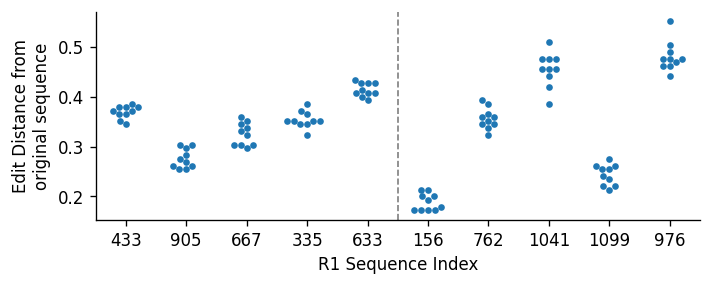

In [247]:
# beeswarm plot of edit distance with og_seq_idx as x value

# get sort order as the descending order of H2K_COL for the original sequence
analysis_df
og_seqs = analysis_df['og_seq_idx'].unique()

sort_order = ['433','905','667','335','633','156','762','1041','1099','976']
# sort_order = [int(x) for x in sort_order]
# sort_order 

plt.figure(figsize=(6.5,2.25))
# plot a beeswarm where x axis is the og_seq_idx and hue is the design_type
sns.swarmplot(x='og_seq_idx',y='edit_distance',data=analysis_df[analysis_df['edit_distance']>0],
              order=sort_order,size=4,edgecolor='k',linewidth=0.0,dodge=True)

plt.xlabel('R1 Sequence Index')
plt.ylabel('Edit Distance from\noriginal sequence')
# plt.title('Nonmotif optimization')


# plot vertical line at 4.5
plt.axvline(x=4.5,color='k',linewidth=1,linestyle='--',alpha=0.5)

# despine
sns.despine()



# save figure
plt.savefig(f'{revision_figure_dir}/edit_distance_reopt_beeswarm.png',dpi=600,bbox_inches='tight')
# save as svg
# plt.savefig(f'{fig3_dir}/fig4_nonmotif_flank_opt_swarm.svg',bbox_inches='tight')

In [137]:
analysis_df[analysis_df['edit_distance']>0].groupby('cell_type')['edit_distance'].mean()


cell_type
HEPG2    0.348138
K562     0.345103
Name: edit_distance, dtype: float64

Pearson correlation: -0.33, p-value: 0.35388616486710583


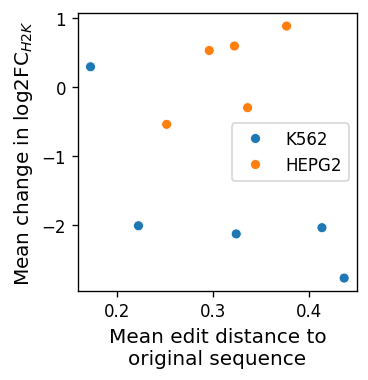

In [248]:
# plot mean delta_h2k vs edit_distance for each og_seq_idx, color by cell type of original sequence
x = analysis_df.groupby('og_seq_idx')['edit_distance'].mean().values
y = analysis_df.groupby('og_seq_idx')['delta_h2k'].mean().values
hue = analysis_df.groupby('og_seq_idx')['cell_type'].first().values

# get correlation
r, p = stats.pearsonr(x,y)
print(f'Pearson correlation: {r:.2f}, p-value: {p}')

plt.figure(figsize=(3,3))
sns.scatterplot(x=x,y=y,hue=hue)
plt.xlabel('Mean edit distance to\noriginal sequence',fontsize=AXIS_FSIZE)
plt.ylabel('Mean change in log2FC$_{H2K}$',fontsize=AXIS_FSIZE)
# plt.title('Mean change in H2K vs proportion of sequence changed')
# plt.legend(title='Cell type')
# plt.show()

plt.savefig(f'{revision_figure_dir}/change_vs_improvement_corr.png',dpi=600,bbox_inches='tight')

In [296]:
prop_change_df

og_seq_idx  prop_change
0        433     0.662069
0        905     0.434483
0        667     0.524138
0        335     0.627586
0        633     0.627586
0        976     0.793103
0       1099     0.351724
0       1041     0.793103
0        762     0.579310
0        156     0.282759

In [64]:
# okay redo this now actually calculating the change from the original sequence - I'm just gonna do edit distance here, 4-mer seems like a bad fit here

seq_len = 145

prop_change_df = pd.DataFrame(columns=['og_seq_idx','cell_type','prop_change'])

for og_seq_idx in analysis_df['og_seq_idx'].unique():
    cell_type = analysis_df[analysis_df['og_seq_idx']==og_seq_idx]['cell_type'].values[0]
    cur_motif_df = d2_final_df[d2_final_df['sequence_name']==og_seq_idx].copy()
    cur_motif_df['motif_len'] = cur_motif_df['stop'] - cur_motif_df['start'] + 1
    motif_len = cur_motif_df['motif_len'].sum()
    prop_change = 1-motif_len/seq_len
    prop_change_df = pd.concat([prop_change_df,pd.DataFrame([[str(int(og_seq_idx)),cell_type,prop_change]],columns=['og_seq_idx','cell_type','prop_change'])])

# # prop_change_df
# # bar plot of prop_change_df
# # convert og_seq_idx column to string
# prop_change_df['og_seq_idx'] = prop_change_df['og_seq_idx'].astype(str)

# # sort plot_df by xorder to main main text plots
# xorder = ['433','905','667','335','633','976','1099','1041','762','156']
# prop_change_df['og_seq_idx'] = pd.Categorical(prop_change_df['og_seq_idx'],categories=xorder)
# prop_change_df.sort_values('og_seq_idx',inplace=True)

# plt.figure(figsize=(4,2.5))
# plt.bar(prop_change_df['og_seq_idx'],prop_change_df['prop_change'])
# plt.xlabel('Original Sequence Index')
# plt.ylabel('Proportion of seq. changed')
# plt.title('Proportion of sequence changed in reoptimized sequences')
# plt.xticks(rotation=45)

# # draw vertical black line dashed
# plt.axvline(x=4.5,color='black',linestyle='dashed')

# # I want to correlate this to the improvement! so I need to add a column calculating difference from the original sequence
# # I should also propagate error? there's no way it's going to be significant, hold off on extra work for now


C:\Users\Chris\AppData\Local\Temp\ipykernel_25076\2326194128.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  prop_change_df = pd.concat([prop_change_df,pd.DataFrame([[str(int(og_seq_idx)),cell_type,prop_change]],columns=['og_seq_idx','cell_type','prop_change'])])


In [70]:
prop_change_df.groupby('cell_type')['prop_change'].median()

cell_type
HEPG2    0.627586
K562     0.579310
Name: prop_change, dtype: float64

In [72]:
# # correlate prop_change with num_better, num_worse (okay there is not really a correlation)
# corr_df = pd.merge(prop_change_df,plot_df,on='og_seq_idx',how='outer')
# corr_df['cell_type'] = ['HEPG2']*5 + ['K562']*5
# palette = {'HEPG2':'tab:orange','K562':'tab:blue'}

# # plot scatterplot of prop_change vs num_better, color by cell type
# plt.figure(figsize=(4,4))
# sns.scatterplot(data=corr_df,x='prop_change',y='num_better',hue='cell_type',palette=palette)
# plt.xlabel('Proportion of sequence changed')
# plt.ylabel('Number of sequences better than')
# plt.title('Proportion of sequence changed vs number of sequences better than')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')



### R3.7.3 - 905 repressor? ###

In [268]:
# model_types = ['d1_finetuned','shuffled_nonmotif'] # these are the only model types with targets
# design_types = ['fsp','d2_rand_ctrl','d2_top_ctrl','NC']
# design_types = ['nonmotif_masked_fsp','shuffled_nonmotif']

# for this analysis, only look at designed enhancers
model_types = ['d1_finetuned','shuffled_nonmotif']
design_types = ['nonmotif_masked_fsp','shuffled_nonmotif']
analysis_df = d3_deseq_plus_cluster_cnts_df[(d3_deseq_plus_cluster_cnts_df['model_type'].isin(model_types)) & (d3_deseq_plus_cluster_cnts_df['design_type'].isin(design_types))].copy()
print(analysis_df.shape[0])

# extract original sequence index from sequence name
analysis_df.loc[analysis_df['design_type']=='nonmotif_masked_fsp','og_seq_idx'] = analysis_df.loc[analysis_df['design_type']=='nonmotif_masked_fsp','sequence_name'].apply(lambda x: int(x.split('_')[-3][3:]))
analysis_df.loc[analysis_df['design_type']=='shuffled_nonmotif','og_seq_idx'] = analysis_df.loc[analysis_df['design_type']=='shuffled_nonmotif','sequence_name'].apply(lambda x: int(x.split('_')[0]))
# set og_seq_idx to int
analysis_df['og_seq_idx'] = analysis_df['og_seq_idx'].astype(int)


# extract unmodified sequence
for d2_seq_idx in analysis_df['og_seq_idx'].unique():
    if f'd2_seq_{d2_seq_idx:.0f}' in d3_seq_df['sequence_name'].values:
        # print(f'{d2_seq_idx:.0f} is in d3_seq_df')
        # append this row to analysis_df using pd.concat
        analysis_df = pd.concat([analysis_df,d3_deseq_plus_cluster_cnts_df[d3_deseq_plus_cluster_cnts_df['sequence_name']==f'd2_seq_{d2_seq_idx:.0f}']])     
    # elif f'd1_seq_{d2_seq_idx:.0f}' in d3_seq_df['sequence_name'].values:
    #     analysis_df = pd.concat([analysis_df,d3_deseq_plus_cluster_cnts_df[d3_deseq_plus_cluster_cnts_df['sequence_name']==f'd1_seq_{d2_seq_idx:.0f}']]) 
    else:
        print(f'Error: {d2_seq_idx} is NOT in d3_seq_df')

analysis_df.loc[analysis_df['model_type']=='d2_meas','og_seq_idx'] = analysis_df.loc[analysis_df['model_type']=='d2_meas','sequence_name'].apply(lambda x: int(x.split('_')[2]))

# append d2 1041, which is actually d1 22263
analysis_df = pd.concat([analysis_df,d3_deseq_plus_cluster_cnts_df[d3_deseq_plus_cluster_cnts_df['sequence_name']==f'd1_seq_22263']])
analysis_df.loc[analysis_df['model_type']=='d2_meas','og_seq_idx'] = analysis_df.loc[analysis_df['model_type']=='d2_meas','sequence_name'].apply(lambda x: int(x.split('_')[2]))

# set og_seq_idx 22263 to 1041
analysis_df.loc[analysis_df['og_seq_idx']==22263,'og_seq_idx'] = 1041

# sort_order = analysis_df[analysis_df['model_type']=='d2_meas'].sort_values(H2K_COL,ascending=False).index
sort_order = analysis_df[analysis_df['model_type']=='d2_meas'].sort_values(H2K_COL,ascending=False)['og_seq_idx'].values

# set to str
analysis_df['og_seq_idx'] = analysis_df['og_seq_idx'].astype(int)
analysis_df['og_seq_idx'] = analysis_df['og_seq_idx'].astype(str)

149
Error: 1041 is NOT in d3_seq_df


In [167]:

# write all the 905 sequences to a fasta file
with open(f'revision_scripts/d2_905_seqs.fasta','w') as f:
    for seqname, seq in analysis_df.loc[analysis_df['og_seq_idx']==905,['sequence_name','sequence']].values:
        f.write(f'>{seqname}\n{seq}\n')

In [319]:
"""The authors mention that "Re-optimizing non-motif sequence improved specificity for 5/5 HepG2 designs and 1/5 K562 designs",
but in HepG2 sequence 905 all random controls are above the activity of the original sequence.
This needs to be mentioned.
Was there a repressor motif present in the "non-motif" sequence?
"""


k562_inds = [976,1099,1041,762,156]

# f'd2_seq_{}'

cur_idx = 905

d3_final_df[d3_final_df['sequence_name']==f'd2_seq_{cur_idx}']

motif_id motif_alt_id sequence_name  start  stop strand    score  \
1792  MA0106.3         TP53    d2_seq_905      3    21      -  26.7347   
1793  MA0106.3         TP53    d2_seq_905     19    37      +  27.3469   
1794  MA1494.1        HNF4A    d2_seq_905     87   102      -  17.8182   
1795  MA0106.3         TP53    d2_seq_905    107   125      +  26.7143   
1796  MA0484.2        HNF4G    d2_seq_905    125   138      -  12.7801   

           p-value       q-value    matched_sequence jaspar_cluster  
1792  3.800000e-10  2.280000e-07  TACATGCCCGGACATGTC     cluster_50  
1793  1.840000e-10  1.500000e-07  TACATGCCCGGGCATGTC     cluster_50  
1794  4.270000e-07  1.700000e-03     AGGTCCAAAGGTCCA      cluster_4  
1795  3.880000e-10  2.280000e-07  GACATGCCGGGGCATGTC     cluster_50  
1796  1.840000e-05  1.590000e-02       CACAAAGTCCGGA      cluster_2

In [320]:
d2_final_df[d2_final_df['sequence_name']==cur_idx]

motif_id motif_alt_id  sequence_name  start  stop strand    score  \
351  MA0106.3         TP53            905      4    21      -  26.7347   
352  MA0106.3         TP53            905     20    37      +  27.3469   
353  MA1494.1        HNF4A            905     88   102      -  17.8182   
354  MA0106.3         TP53            905    108   125      +  26.7143   
355  MA0484.2        HNF4G            905    126   138      -  12.7801   

          p-value       q-value    matched_sequence  midpt jaspar_cluster  
351  3.800000e-10  3.960000e-07  TACATGCCCGGACATGTC   12.5     cluster_50  
352  1.840000e-10  2.640000e-07  TACATGCCCGGGCATGTC   28.5     cluster_50  
353  4.270000e-07  2.210000e-03     AGGTCCAAAGGTCCA   95.0      cluster_4  
354  3.880000e-10  3.960000e-07  GACATGCCGGGGCATGTC  116.5     cluster_50  
355  1.840000e-05  4.990000e-02       CACAAAGTCCGGA  132.0      cluster_2

In [249]:
seq = d3_seq_df[d3_seq_df['sequence_name']==f'd2_seq_905']['sequence'].values[0]
print(seq)

GGGGACATGTCCGGGCATGTACATGCCCGGGCATGTCCGCTGTCCCCGGGTTGTTTGTTTGGTCATGTCGGTTCACTGTGGGTTGTTTGGACCTTTGGACCTTGGTAGACATGCCGGGGCATGTCTCCGGACTTTGTGTGACGTG


In [250]:
d3_final_df[d3_final_df['sequence_name']==f'd2_seq_905']

motif_id motif_alt_id sequence_name  start  stop strand    score  \
1792  MA0106.3         TP53    d2_seq_905      3    21      -  26.7347   
1793  MA0106.3         TP53    d2_seq_905     19    37      +  27.3469   
1794  MA1494.1        HNF4A    d2_seq_905     87   102      -  17.8182   
1795  MA0106.3         TP53    d2_seq_905    107   125      +  26.7143   
1796  MA0484.2        HNF4G    d2_seq_905    125   138      -  12.7801   

           p-value       q-value    matched_sequence jaspar_cluster  
1792  3.800000e-10  2.280000e-07  TACATGCCCGGACATGTC     cluster_50  
1793  1.840000e-10  1.500000e-07  TACATGCCCGGGCATGTC     cluster_50  
1794  4.270000e-07  1.700000e-03     AGGTCCAAAGGTCCA      cluster_4  
1795  3.880000e-10  2.280000e-07  GACATGCCGGGGCATGTC     cluster_50  
1796  1.840000e-05  1.590000e-02       CACAAAGTCCGGA      cluster_2

In [251]:
seq[37:87]

'CGCTGTCCCCGGGTTGTTTGTTTGGTCATGTCGGTTCACTGTGGGTTGTT'

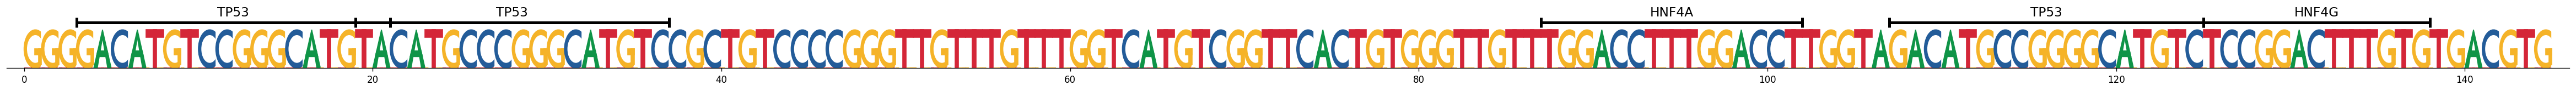

In [ ]:
# plot sequence logo with motifs for d2_seq_905
seq = d3_seq_df[d3_seq_df['sequence_name']==f'd2_seq_905']['sequence'].values[0]
motifs = d3_final_df[d3_final_df['sequence_name']==f'd2_seq_905']
plot_seq_with_motifs(seq,motifs)

905_shuffled_nonmotif_2
905_shuffled_nonmotif_3
designed_d1_finetuned_nonmotif_masked_fsp_seq905_h2k_1
905_shuffled_nonmotif_0
905_shuffled_nonmotif_4
905_shuffled_nonmotif_1
d2_seq_905
designed_d1_finetuned_nonmotif_masked_fsp_seq905_h2k_4
designed_d1_finetuned_nonmotif_masked_fsp_seq905_h2k_10
designed_d1_finetuned_nonmotif_masked_fsp_seq905_h2k_3
designed_d1_finetuned_nonmotif_masked_fsp_seq905_h2k_7
designed_d1_finetuned_nonmotif_masked_fsp_seq905_h2k_14
designed_d1_finetuned_nonmotif_masked_fsp_seq905_h2k_2
designed_d1_finetuned_nonmotif_masked_fsp_seq905_h2k_6
designed_d1_finetuned_nonmotif_masked_fsp_seq905_h2k_5
designed_d1_finetuned_nonmotif_masked_fsp_seq905_h2k_0


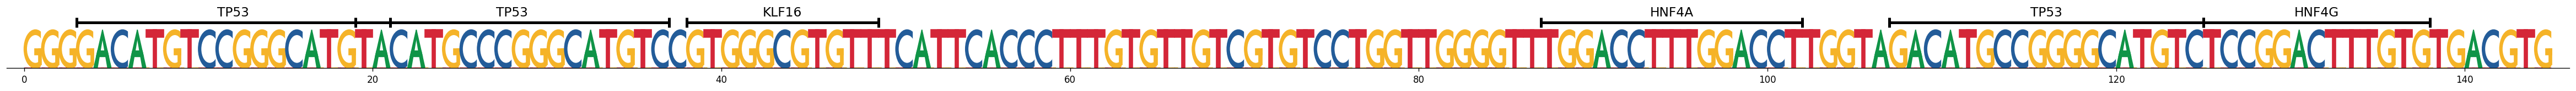

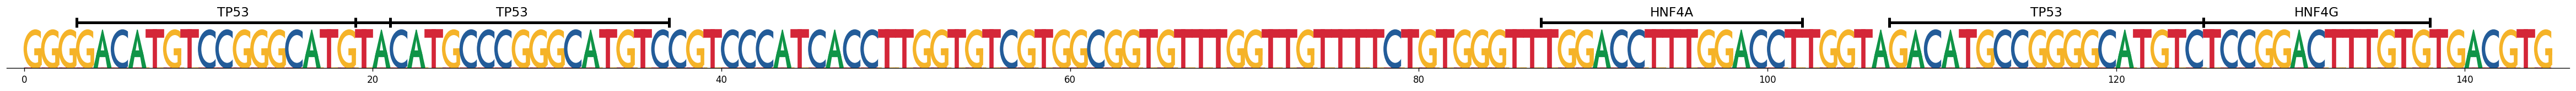

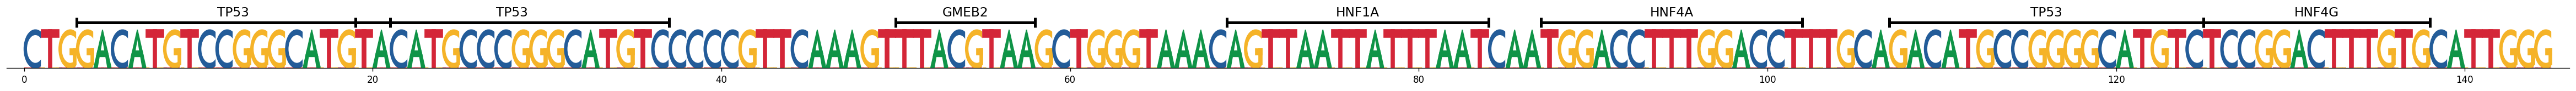

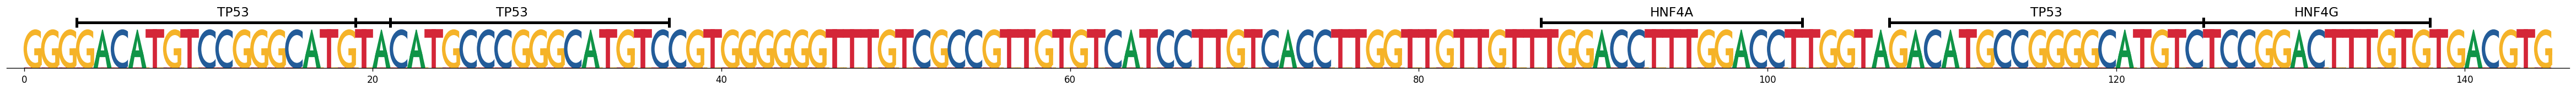

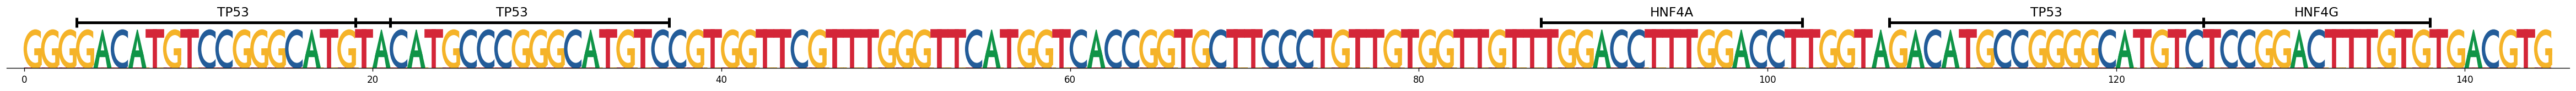

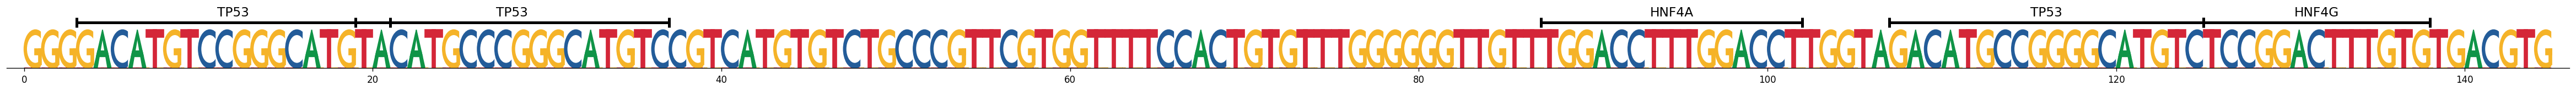

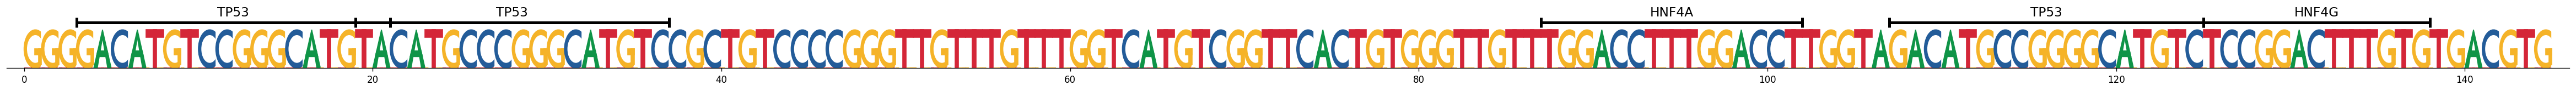

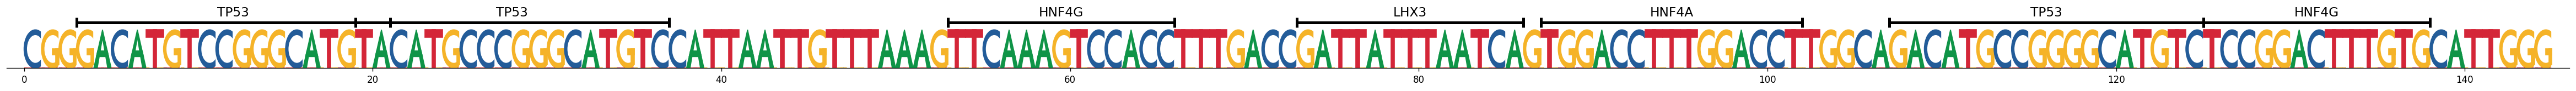

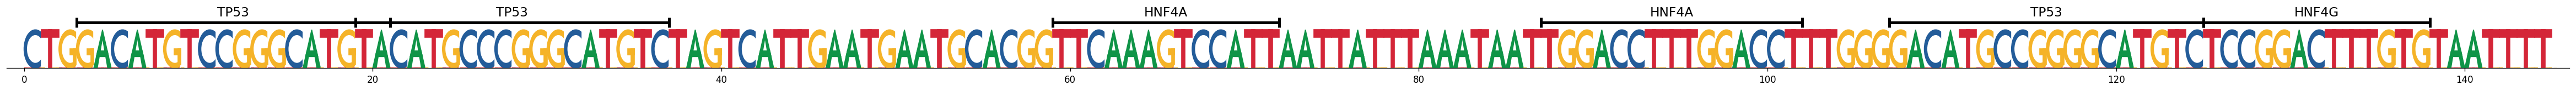

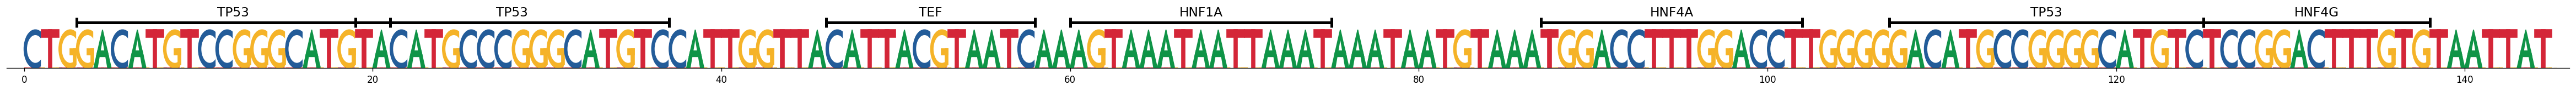

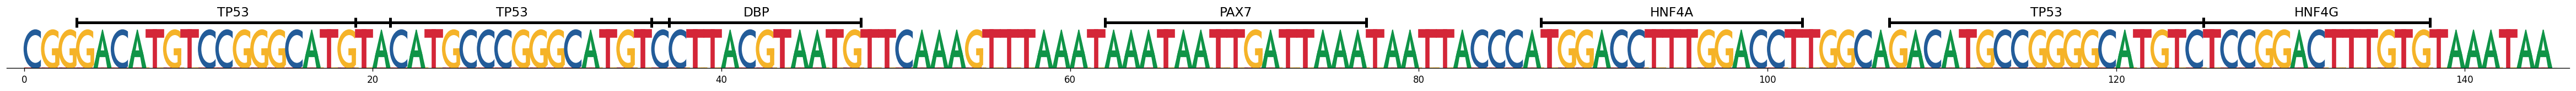

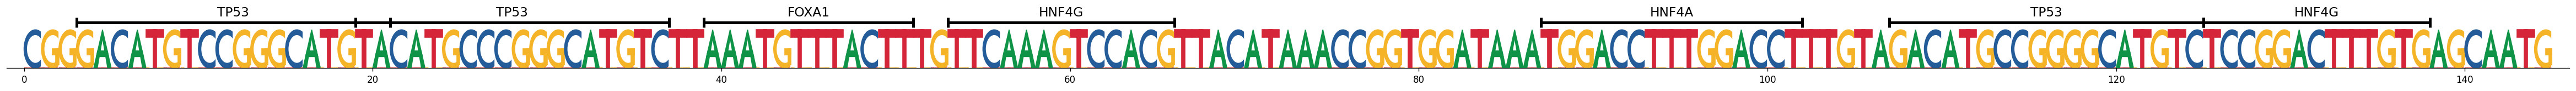

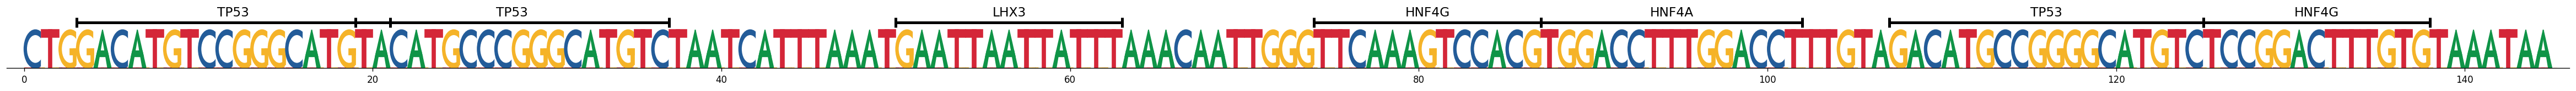

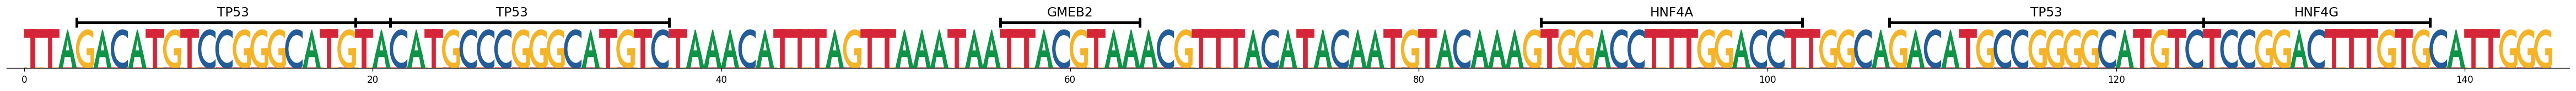

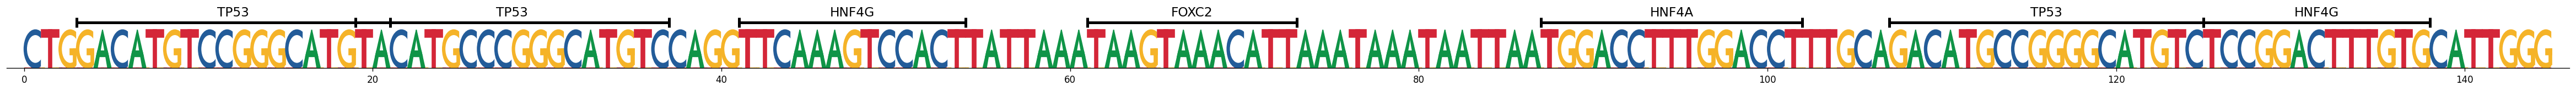

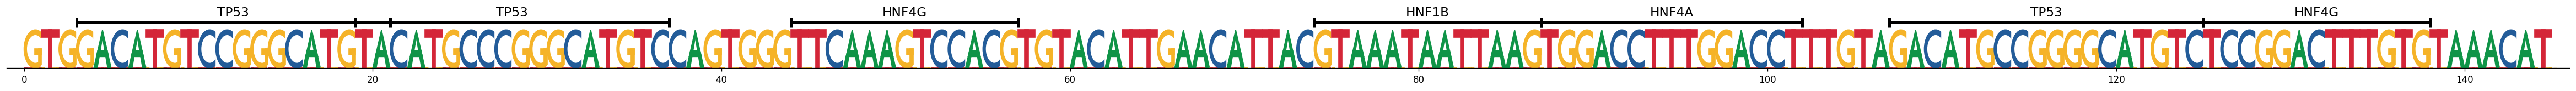

In [278]:
cur_analysis_df = analysis_df[analysis_df['og_seq_idx']=='905'].sort_values(H2K_COL,ascending=False)

for seqname, seq in cur_analysis_df[['sequence_name','sequence']].values:
    print(seqname)
    motifs = d3_final_df[d3_final_df['sequence_name']==seqname]
    plot_seq_with_motifs(seq,motifs)

C:\Users\Chris\AppData\Local\Temp\ipykernel_25076\185635279.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dinuc_freq_df = pd.concat([dinuc_freq_df,pd.DataFrame([[f'{seq_idx}']+list(np.zeros(16))],columns=['seq_idx'] + dinuc_cols)])


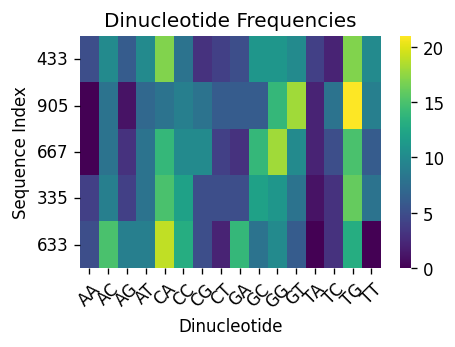

In [293]:
# for each HepG2 sequence, calculate the dinucleotide frequencies
hepg2_seq_inds = [433,905,667,335,633]

# get the sequence for each of these sequences
hepg2_seqs = d3_seq_df[d3_seq_df['sequence_name'].isin([f'd2_seq_{x}' for x in hepg2_seq_inds])]['sequence'].values

# calculate dinucleotide frequencies for each sequence
from Bio.Seq import Seq


dinuc_cols = ['AA','AC','AG','AT','CA','CC','CG','CT','GA','GC','GG','GT','TA','TC','TG','TT']


dinuc_freq_df = pd.DataFrame(columns=['seq_idx'] + dinuc_cols)
dinuc_freqs = np.zeros((len(hepg2_seq_inds),16))
# instantiate the rows for the dataframe
for seq_idx in hepg2_seq_inds:
    dinuc_freq_df = pd.concat([dinuc_freq_df,pd.DataFrame([[f'{seq_idx}']+list(np.zeros(16))],columns=['seq_idx'] + dinuc_cols)])

for i, seq in enumerate(hepg2_seqs):
    for j, dinuc in enumerate(dinuc_cols):
        dinuc_freqs[i,j] = seq.count(dinuc)

# convert to dataframe
dinuc_freq_df = pd.DataFrame(dinuc_freqs,index=[f'{x}' for x in hepg2_seq_inds],columns=dinuc_cols)
        




# # convert to dataframe
# dinuc_freq_df = pd.DataFrame(dinuc_freqs,index=[f'd2_seq_{x}' for x in hepg2_seq_inds],columns=dinuc_cols)

# plot heatmap of dinucleotide frequencies
plt.figure(figsize=(4,3))
sns.heatmap(dinuc_freq_df,cmap='viridis')
plt.xlabel('Dinucleotide')
plt.ylabel('Sequence Index')
plt.title('Dinucleotide Frequencies')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()



In [291]:
dinuc_freq_df

AA    AC   AG    AT    CA    CC    CG   CT    GA    GC    GG    GT   TA  \
433  5.0  10.0  6.0  10.0  17.0   8.0   3.0  4.0   5.0  11.0  11.0  10.0  4.0   
905  0.0   8.0  1.0   7.0   8.0   9.0   8.0  6.0   6.0   6.0  14.0  18.0  2.0   
667  0.0   8.0  3.0   8.0  14.0  10.0  10.0  4.0   3.0  14.0  18.0  10.0  2.0   
335  4.0   9.0  4.0   8.0  15.0  12.0   5.0  5.0   5.0  12.0  11.0   8.0  1.0   
633  5.0  15.0  9.0   9.0  19.0  13.0   5.0  2.0  14.0   8.0  10.0   6.0  0.0   

      TC    TG    TT  
433  2.0  17.0  10.0  
905  8.0  21.0   9.0  
667  5.0  15.0   6.0  
335  3.0  16.0   8.0  
633  3.0  13.0   0.0

In [180]:
# load in the corresponding sequence and motif data

shap_dir = 'shap_values_for_revision'
model_names = ['M2','M1','M0']
dataset_names = ['R2','R1-MPRA','R1-DHS','R0']

motif_df_dict = {
    'R0': d1_final_df,
    'R1-MPRA': d2_final_df,
    'R1-DHS': dhs_final_df,
    'R2': d3_final_df
}

deseq_df_dict = {
    'R0': d1_deseq_plus_cluster_cnts_df,
    'R1-MPRA': d2_deseq_df,
    'R1-DHS': dhs_deseq_df,
    'R2': d3_deseq_plus_cluster_cnts_df
}

cur_dataset = 'R2'
cur_model = 'M2'
analysis_df = deseq_df_dict[cur_dataset].copy()
# reindex the analysis_df to match the sequence indices in the shap values
analysis_df = analysis_df.reset_index(drop=True)
motif_df = motif_df_dict[cur_dataset].copy()

# process the analysis_df to remove sequences w/ no calculation for SHAP values
if cur_dataset == 'R2':
    exluded_model_types = ['dhs64_finetuned','dhs62_finetuned','sabetti_ctrl']
    excluded_design_types = ['fsp_minimal_concatemer','concatemer','sabetti_ctrl']
    analysis_df = analysis_df[(~analysis_df['model_type'].isin(exluded_model_types)) & (~analysis_df['design_type'].isin(excluded_design_types))]
elif cur_dataset == 'R1-MPRA':
    analysis_df = analysis_df[analysis_df['generator'] != 'control'] 


In [334]:
analysis_df.loc[analysis_df['sequence_name']=='d2_seq_905']

enhancer  \
905  GGGGACATGTCCGGGCATGTACATGCCCGGGCATGTCCGCTGTCCC...   

                                              barcodes  cnt_dna_r1  \
905  ['AAACCCACCC' 'AAAGCGGAAA' 'AACCAGGGAG' 'AACGA...        9921   

     cnt_hepg2_r3  cnt_hepg2_r4  cnt_k562_r1  cnt_k562_r2  mean_dna_r1  \
905         55549         63645          504          426       1984.2   

     mean_hepg2_r3  mean_hepg2_r4  ...   pvalue_K562     padj_K562  \
905        11109.8        12729.0  ...  3.120000e-20  9.320000e-20   

     log2FoldChange_H2K  pred_h2k_score  log2FoldChange_H2K_deseq  \
905            6.249922        2.133409                  6.769908   

        model_type  split  padj_H2K_deseq sequence_name lfcSE_H2K  
905  ensemble_boot  train             0.0    d2_seq_905  0.118625  

[1 rows x 46 columns]

6.088202082483913


0.14627287694645863

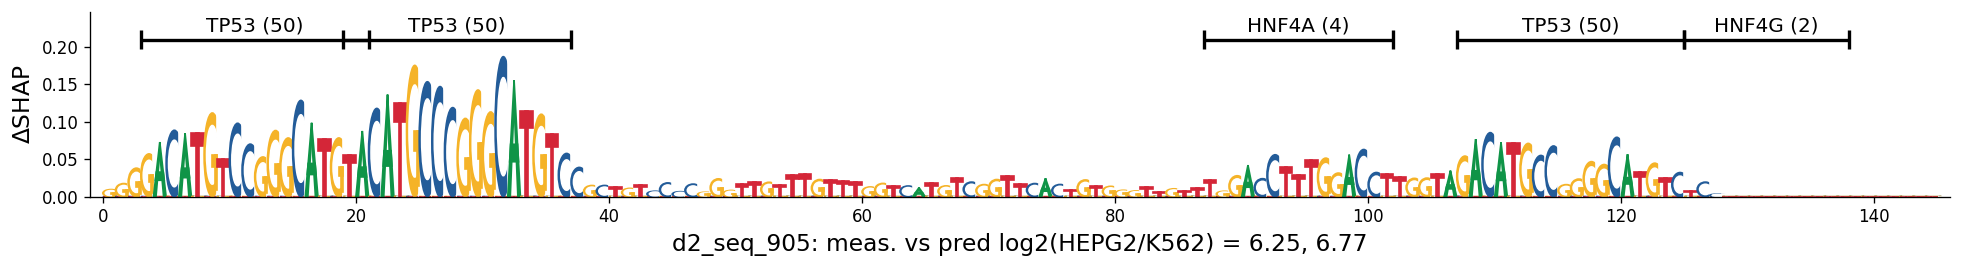

In [348]:
# test that shap extraction is working
cur_model = 'M1'
cur_dataset = 'R2'
hepg2_shap_vals = np.load(f'{shap_dir}/{cur_model}/hepg2_raw_shap_explanations_{cur_model}_{cur_dataset}.npy')
k562_shap_vals = np.load(f'{shap_dir}/{cur_model}/k562_raw_shap_explanations_{cur_model}_{cur_dataset}.npy')
seq_idx = analysis_df.loc[analysis_df['sequence_name']=='d2_seq_905'].index[0]

# seems like it's probably working, it sucks that the models seems to be biased against motifs on the 3' end when realistically 
plot_seq_shap_with_motifs(seq_idx, analysis_df, d3_final_df)

In [202]:
analysis_df['design_type'].value_counts()

design_type
nonmotif_masked_fsp    100
d2_top_ctrl             10
Name: count, dtype: int64

1/1 [==============================] - 1s 745ms/step


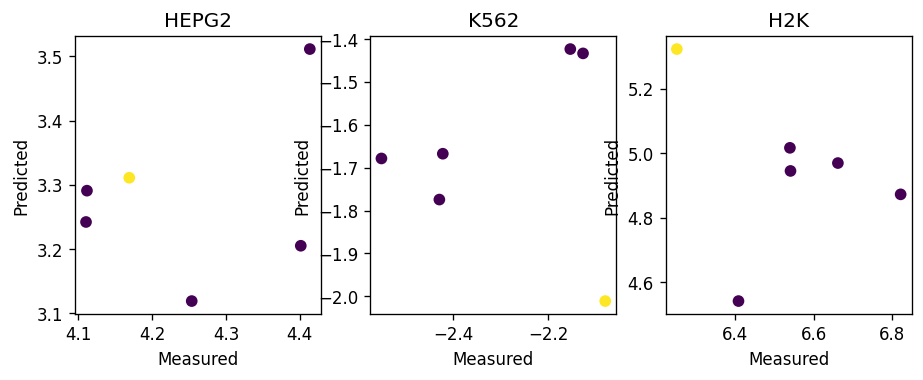

In [231]:
# okay let's just see how well the model predicts this
# load ensemble model

# model_dir = 'd2_finetuned/test_fold_0'
model_dir = 'd2_finetuned/test_fold_0/d3_tot'
model_basename = 'd1_wide_ft_cf_t0_v'
model_inds = np.arange(1,10)
suffix = '_d2_ft'

model = load_ensemble_model(model_dir,model_basename,model_inds,model_suffix=suffix)

# predict on the 905 variations

cur_analysis_df = analysis_df[(analysis_df['og_seq_idx']=='905') & ~(analysis_df['design_type']=='nonmotif_masked_fsp')]

x_905 = cur_analysis_df['sequence'].values
# one hot and pad
x_905 = np.stack([seq_to_one_hot_and_pad(seq) for seq in x_905])
y_905 = cur_analysis_df[[HEPG2_COL,K562_COL,H2K_COL]].values

# class_vec = ['tab:gray']*5 + ['tab:yellow']
class_vec = [0]*5 + [1]

# predict
y_pred_905 = model.predict(x_905)

# add y_pred_905[:,0] - y_pred_905[:,1] as col to y_pred_905
y_pred_905 = np.concatenate([y_pred_905,y_pred_905[:,0].reshape(-1,1) - y_pred_905[:,1].reshape(-1,1)],axis=1)

# plot pred vs meas for HEPG2_COL, K562_COl, and H2K_COL, 1x3 subplot
fig, ax = plt.subplots(1,3,figsize=(9,3))

for i, cell_type in enumerate(['HEPG2','K562','H2K']):
    ax[i].scatter(y_905[:,i],y_pred_905[:,i],c=class_vec)
    ax[i].set_xlabel('Measured')
    ax[i].set_ylabel('Predicted')
    ax[i].set_title(cell_type)



In [191]:
y_pred_905

array([[ 3.3194706, -1.2861344,  4.605605 ],
       [ 3.0430272, -1.212422 ,  4.2554493],
       [ 3.0129766, -1.3367678,  4.3497443],
       [ 3.0557222, -1.2653049,  4.3210273],
       [ 3.069027 , -1.5544784,  4.6235056],
       [ 3.9461   , -2.2950783,  6.2411785],
       [ 3.770959 , -1.8161494,  5.587108 ],
       [ 3.5620089, -2.3999512,  5.96196  ],
       [ 3.9383194, -2.1555817,  6.093901 ],
       [ 3.9399953, -1.9228965,  5.8628917],
       [ 3.6679132, -2.255334 ,  5.9232473],
       [ 3.8752458, -1.9388348,  5.8140807],
       [ 3.700168 , -1.9252245,  5.6253924],
       [ 3.2689795, -2.2746332,  5.5436125],
       [ 3.8591418, -2.0471218,  5.9062634]], dtype=float32)

In [353]:
unclustered_motif_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/fimo_motif_scanning/saved_processed_motif_files/d2_clustered_motif_df_qthresh05.csv')
unclustered_motif_df[unclustered_motif_df['sequence_name']==905].sort_values('start')

motif_id motif_alt_id  sequence_name  start  stop strand     score  \
176    MA0106.3         TP53            905      4    21      -  26.73470   
616    MA0861.1         TP73            905      4    21      -  21.98080   
1463   MA0525.2         TP63            905      4    21      +  19.98280   
119    MA0106.3         TP53            905     20    37      +  27.34690   
2178   MA0861.1         TP73            905     20    37      +  19.50000   
4178   MA0525.2         TP63            905     20    37      -  15.12070   
17627  MA1719.1       ZNF816            905     27    44      -  12.69720   
3239   MA1494.1        HNF4A            905     88   102      -  17.81820   
7529   MA0728.1        Nr2F6            905     89   103      -   9.47143   
208    MA0106.3         TP53            905    108   125      +  26.71430   
1843   MA0525.2         TP63            905    108   125      +  19.10340   
2264   MA0861.1         TP73            905    108   125      +  19.44230   
21038  MA0484.2        HNF4G            905    126   138      -  12.78010   
21659  MA0114.4        HNF4A            905    126   138      -  12.63120   

            p-value       q-value    matched_sequence  midpt  
176    3.800000e-10  3.960000e-07  TACATGCCCGGACATGTC   12.5  
616    1.530000e-08  5.040000e-05  TACATGCCCGGACATGTC   12.5  
1463   8.830000e-08  3.500000e-04  GACATGTCCGGGCATGTA   12.5  
119    1.840000e-10  2.640000e-07  TACATGCCCGGGCATGTC   28.5  
2178   1.820000e-07  1.330000e-04  TACATGCCCGGGCATGTC   28.5  
4178   7.050000e-07  5.320000e-04  GACATGCCCGGGCATGTA   28.5  
17627  1.230000e-05  2.040000e-02  GACAGCGGACATGCCCGG   35.5  
3239   4.270000e-07  2.210000e-03     AGGTCCAAAGGTCCA   95.0  
7529   1.900000e-06  1.400000e-02     AAGGTCCAAAGGTCC   96.0  
208    3.880000e-10  3.960000e-07  GACATGCCGGGGCATGTC  116.5  
1843   1.350000e-07  3.500000e-04  GACATGCCGGGGCATGTC  116.5  
2264   1.920000e-07  1.330000e-04  GACATGCCGGGGCATGTC  116.5  
21038  1.840000e-05  4.990000e-02       CACAAAGTCCGGA  132.0  
21659  2.040000e-05  4.920000e-02       CACAAAGTCCGGA  132.0

In [355]:
unclustered_motif_df = pd.read_csv('../designed_seqs/d3_tot_clustered_motif_df_qthresh0.05.csv')
unclustered_motif_df[unclustered_motif_df['sequence_name']=='d2_seq_905'].sort_values('start')

motif_id motif_alt_id sequence_name  start  stop strand    score  \
1792  MA0106.3         TP53    d2_seq_905      3    21      -  26.7347   
1793  MA0106.3         TP53    d2_seq_905     19    37      +  27.3469   
1794  MA1494.1        HNF4A    d2_seq_905     87   102      -  17.8182   
1795  MA0106.3         TP53    d2_seq_905    107   125      +  26.7143   
1796  MA0484.2        HNF4G    d2_seq_905    125   138      -  12.7801   

           p-value       q-value    matched_sequence jaspar_cluster  
1792  3.800000e-10  2.280000e-07  TACATGCCCGGACATGTC     cluster_50  
1793  1.840000e-10  1.500000e-07  TACATGCCCGGGCATGTC     cluster_50  
1794  4.270000e-07  1.700000e-03     AGGTCCAAAGGTCCA      cluster_4  
1795  3.880000e-10  2.280000e-07  GACATGCCGGGGCATGTC     cluster_50  
1796  1.840000e-05  1.590000e-02       CACAAAGTCCGGA      cluster_2

In [367]:
# try the unfiltered tsv
fimo_tsv = pd.read_csv('../designed_seqs/d3_fimo_d2_bg.tsv',sep='\t')
df = fimo_tsv[fimo_tsv['sequence_name']=='design_d2_seq_905'].sort_values('start')

df[(df['start']>=30) & (df['stop']<=90)]

# okay, possibly the runx1 motif is associated w/ k562 activity. should check if the randomized sequences have higher hepg2 or lower k562 or both...

motif_id motif_alt_id      sequence_name  start  stop strand  \
258776  MA0040.1        Foxq1  design_d2_seq_905     49    59      +   
58330   MA0041.2        FOXD3  design_d2_seq_905     50    65      -   
111798  MA1487.2        FOXE1  design_d2_seq_905     50    63      -   
303855  MA0106.3         TP53  design_d2_seq_905     52    69      +   
232898  MA0847.3        FOXD2  design_d2_seq_905     52    63      -   
246470  MA1561.1        SOX12  design_d2_seq_905     53    63      -   
312680  MA1487.2        FOXE1  design_d2_seq_905     54    67      -   
275330  MA0088.2       ZNF143  design_d2_seq_905     69    84      -   
288447  MA0002.2        Runx1  design_d2_seq_905     74    84      +   

           score   p-value  q-value    matched_sequence  
258776  10.56570  0.000069   0.2190         GGTTGTTTGTT  
58330   14.61970  0.000005   0.0282    TGACCAAACAAACAAC  
111798  12.89660  0.000015   0.0469      ACCAAACAAACAAC  
303855   5.82000  0.000093   0.0135  TGTTTGTTTGGTCATGTC  
232898  10.58620  0.000057   0.1320        ACCAAACAAACA  
246470  11.03230  0.000062   0.6530         ACCAAACAAAC  
312680   8.98276  0.000097   0.1240      CATGACCAAACAAA  
275330   1.15517  0.000076   0.3600    AACCCACAGTGAACCG  
288447  10.94830  0.000084   0.3350         CACTGTGGGTT

149


([<matplotlib.axis.XTick at 0x17346248b50>,
 [Text(0, 0, 'HepG2'), Text(1, 0, 'K562'), Text(2, 0, 'H2K')])

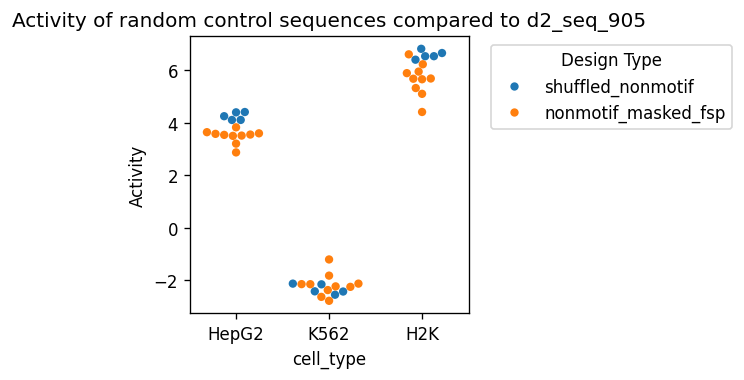

In [378]:
# all right let's get all of the randomization sequences

model_types = ['d1_finetuned','shuffled_nonmotif'] # these are the only model types with targets
# design_types = ['fsp','d2_rand_ctrl','d2_top_ctrl','NC']
design_types = ['nonmotif_masked_fsp','shuffled_nonmotif']
analysis_df = d3_deseq_plus_cluster_cnts_df[(d3_deseq_plus_cluster_cnts_df['model_type'].isin(model_types)) & (d3_deseq_plus_cluster_cnts_df['design_type'].isin(design_types))].copy()
print(analysis_df.shape[0])

# extract original sequence index from sequence name
analysis_df.loc[analysis_df['design_type']=='nonmotif_masked_fsp','og_seq_idx'] = analysis_df.loc[analysis_df['design_type']=='nonmotif_masked_fsp','sequence_name'].apply(lambda x: int(x.split('_')[-3][3:]))
analysis_df.loc[analysis_df['design_type']=='shuffled_nonmotif','og_seq_idx'] = analysis_df.loc[analysis_df['design_type']=='shuffled_nonmotif','sequence_name'].apply(lambda x: int(x.split('_')[0]))
# set og_seq_idx to int
analysis_df['og_seq_idx'] = analysis_df['og_seq_idx'].astype(int)

df_905 = analysis_df[analysis_df['og_seq_idx']==905].copy()
# group by design_type as hue, and plot HEPG2_COL, K562_COL, and H2K_COL as swarmplot
# first melt the df
df_905 = pd.melt(df_905,id_vars=['design_type'],value_vars=[HEPG2_COL,K562_COL,H2K_COL],var_name='cell_type',value_name='activity')
plt.figure(figsize=(3,3))
sns.swarmplot(data=df_905,x='cell_type',y='activity',hue='design_type')
plt.ylabel('Activity')
plt.title('Activity of random control sequences compared to d2_seq_905')
plt.legend(title='Design Type',bbox_to_anchor=(1.05, 1), loc='upper left')
# x-axis labels should be HepG2, K562, H2K
plt.xticks(ticks=[0,1,2],labels=['HepG2','K562','H2K'])

### R3.7.4 - proportion of sequences improved by reoptimization ###

In [149]:
## R3.7.4 - It should also be mentioned the proportion of generated sequences per enhancers that improved specificity.

# so for each og_seq_idx, need to do t-test on each reoptimized sequence vs original value and get proportion of seqs that are higher

model_types = ['d1_finetuned','shuffled_nonmotif'] # these are the only model types with targets
# design_types = ['fsp','d2_rand_ctrl','d2_top_ctrl','NC']
design_types = ['nonmotif_masked_fsp','shuffled_nonmotif']
analysis_df = d3_deseq_plus_cluster_cnts_df[(d3_deseq_plus_cluster_cnts_df['model_type'].isin(model_types)) & (d3_deseq_plus_cluster_cnts_df['design_type'].isin(design_types))].copy()
# drop log2(SKNSH_pred) column
analysis_df.drop(columns=['log2(SKNSH)_pred'], inplace=True)
print(analysis_df.shape)

# extract original sequence index from sequence name
analysis_df.loc[analysis_df['design_type']=='nonmotif_masked_fsp','og_seq_idx'] = analysis_df.loc[analysis_df['design_type']=='nonmotif_masked_fsp','sequence_name'].apply(lambda x: int(x.split('_')[-3][3:]))
analysis_df.loc[analysis_df['design_type']=='shuffled_nonmotif','og_seq_idx'] = analysis_df.loc[analysis_df['design_type']=='shuffled_nonmotif','sequence_name'].apply(lambda x: int(x.split('_')[0]))
# set og_seq_idx to int
analysis_df['og_seq_idx'] = analysis_df['og_seq_idx'].astype(int)

# # replace 1041 with 22263 (1041 is d2 index, 22263 is d1 index)
# analysis_df.loc[analysis_df['og_seq_idx']==1041,'og_seq_idx'] = 22263

# extract unmodified sequence
for d2_seq_idx in analysis_df['og_seq_idx'].unique():
    if f'd2_seq_{d2_seq_idx:.0f}' in d3_seq_df['sequence_name'].values:
        # print(f'{d2_seq_idx:.0f} is in d3_seq_df')
        # append this row to analysis_df using pd.concat
        analysis_df = pd.concat([analysis_df,d3_deseq_plus_cluster_cnts_df[d3_deseq_plus_cluster_cnts_df['sequence_name']==f'd2_seq_{d2_seq_idx:.0f}']])     
    # elif f'd1_seq_{d2_seq_idx:.0f}' in d3_seq_df['sequence_name'].values:
    #     analysis_df = pd.concat([analysis_df,d3_deseq_plus_cluster_cnts_df[d3_deseq_plus_cluster_cnts_df['sequence_name']==f'd1_seq_{d2_seq_idx:.0f}']]) 
    else:
        print(f'Error: {d2_seq_idx} is NOT in d3_seq_df')

analysis_df.loc[analysis_df['model_type']=='d2_meas','og_seq_idx'] = analysis_df.loc[analysis_df['model_type']=='d2_meas','sequence_name'].apply(lambda x: int(x.split('_')[2]))

# append d2 1041, which is actually d1 22263
analysis_df = pd.concat([analysis_df,d3_deseq_plus_cluster_cnts_df[d3_deseq_plus_cluster_cnts_df['sequence_name']==f'd1_seq_22263']])
analysis_df.loc[analysis_df['model_type']=='d2_meas','og_seq_idx'] = analysis_df.loc[analysis_df['model_type']=='d2_meas','sequence_name'].apply(lambda x: int(x.split('_')[2]))

# set og_seq_idx 22263 to 1041
analysis_df.loc[analysis_df['og_seq_idx']==22263,'og_seq_idx'] = 1041

# sort_order = analysis_df[analysis_df['model_type']=='d2_meas'].sort_values(H2K_COL,ascending=False).index
sort_order = analysis_df[analysis_df['model_type']=='d2_meas'].sort_values(H2K_COL,ascending=False)['og_seq_idx'].values
# flip sign for K562 seqs to use same axis
analysis_df.loc[analysis_df['cell_type']=='K562',H2K_COL] *= -1

####

pthresh = 0.05
better_cols = ['og_seq_idx','redesign_better','shuffle_better']
better_df = pd.DataFrame(columns=better_cols)

# for each og_seq_idx, extract the H2K activity of the most specific sequence
for og_seq_idx in analysis_df['og_seq_idx'].unique():

    # subset analysis_df for og_seq_idx
    cur_analysis_df = analysis_df[analysis_df['og_seq_idx'] == og_seq_idx].copy()
    print(f'{og_seq_idx}: {cur_analysis_df.shape[0]}') # okay good everything is working

    # convert H2K_COL to absolute value
    cur_analysis_df[H2K_COL] = cur_analysis_df[H2K_COL].abs()

    # get the original H2K value and SE
    og_row = cur_analysis_df[cur_analysis_df['model_type']=='d2_meas']
    og_h2k, og_se = og_row[[H2K_COL,H2K_SE_COL]].values[0]

    cur_redesign_df = cur_analysis_df[cur_analysis_df['model_type']=='d1_finetuned'].copy()
    cur_shuffle_df = cur_analysis_df[cur_analysis_df['model_type']=='shuffled_nonmotif'].copy()

    n_redesign_seqs = cur_redesign_df.shape[0]
    n_shuffle_seqs = cur_shuffle_df.shape[0]

    # let's do a version w/ and w/o multiple testing correction, try first w/o
    n_design_better = 0
    n_shuffle_better = 0

    # t-test every row in cur_redesign_df against og_row
    for i, row in cur_redesign_df.iterrows():
        # t-test if redesign is greater than og
        p = stats.ttest_ind_from_stats(row[H2K_COL],row[H2K_SE_COL],2,og_h2k,og_se,2,alternative='greater')[1]
        if p < pthresh:
            n_design_better += 1

    # t-test every row in cur_shuffle_df against og_row
    for i, row in cur_shuffle_df.iterrows():
        # t-test if shuffle is greater than og
        p = stats.ttest_ind_from_stats(row[H2K_COL],row[H2K_SE_COL],2,og_h2k,og_se,2,alternative='greater')[1]
        if p < pthresh:
            n_shuffle_better += 1
    
    p_design_better = n_design_better / n_redesign_seqs
    p_shuffle_better = n_shuffle_better / n_shuffle_seqs
    better_df = pd.concat([better_df,pd.DataFrame([[og_seq_idx,p_design_better,p_shuffle_better]],columns=better_cols)])

(149, 66)
Error: 1041 is NOT in d3_seq_df
433.0: 16
905.0: 16
633.0: 16
335.0: 16
667.0: 15
976.0: 16
1041.0: 16
762.0: 16
156.0: 16
1099.0: 16


C:\Users\Chris\AppData\Local\Temp\ipykernel_25076\522204035.py:93: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  better_df = pd.concat([better_df,pd.DataFrame([[og_seq_idx,p_design_better,p_shuffle_better]],columns=better_cols)])


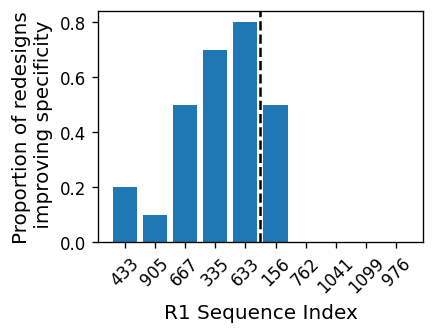

In [162]:
better_df # w/o bonferroni correction...

# convert og_seq_idx to int
better_df['og_seq_idx'] = better_df['og_seq_idx'].astype(int)
better_df['og_seq_idx'] = better_df['og_seq_idx'].astype(str)

# sort plot_df by xorder to main main text plots
xorder = ['433','905','667','335','633','156','762','1041','1099','976']
better_df['og_seq_idx'] = pd.Categorical(better_df['og_seq_idx'],categories=xorder)
better_df.sort_values('og_seq_idx',inplace=True)

plt.figure(figsize=(3.5,2.5))
plt.bar(better_df['og_seq_idx'],better_df['redesign_better'])
plt.xlabel('R1 Sequence Index',fontsize=AXIS_FSIZE)
plt.ylabel('Proportion of redesigns\n improving specificity',fontsize=AXIS_FSIZE)
# plt.title('Proportion of redesigns improving specificity')
plt.xticks(rotation=45)

# draw vertical black line dashed
plt.axvline(x=4.5,color='black',linestyle='dashed')

plt.savefig(f'{revision_figure_dir}/redesign_improvement_proportion.png',dpi=600,bbox_inches='tight')

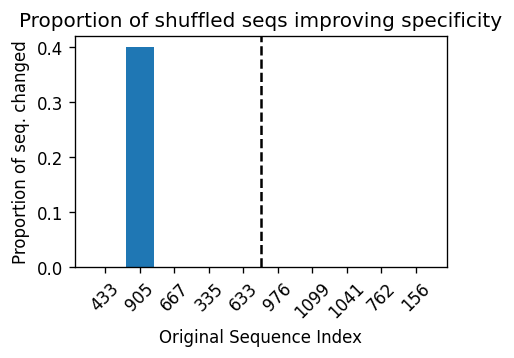

In [414]:
better_df # w/o bonferroni correction...

# convert og_seq_idx to int
better_df['og_seq_idx'] = better_df['og_seq_idx'].astype(int)
better_df['og_seq_idx'] = better_df['og_seq_idx'].astype(str)

# sort plot_df by xorder to main main text plots
xorder = ['433','905','667','335','633','976','1099','1041','762','156']
better_df['og_seq_idx'] = pd.Categorical(better_df['og_seq_idx'],categories=xorder)
better_df.sort_values('og_seq_idx',inplace=True)

plt.figure(figsize=(4,2.5))
plt.bar(better_df['og_seq_idx'],better_df['shuffle_better'])
plt.xlabel('Original Sequence Index')
plt.ylabel('Proportion of seq. changed')
plt.title('Proportion of shuffled seqs improving specificity')
plt.xticks(rotation=45)

# draw vertical black line dashed
plt.axvline(x=4.5,color='black',linestyle='dashed')


C:\Users\Chris\AppData\Local\Temp\ipykernel_33648\3489480277.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  avg_improve_df = pd.concat([avg_improve_df,pd.DataFrame([[int(og_seq_idx),avg_improve]],columns=improve_cols)])


Text(0.1, 0.4, 'Pearson R: -0.32, p: 0.36')

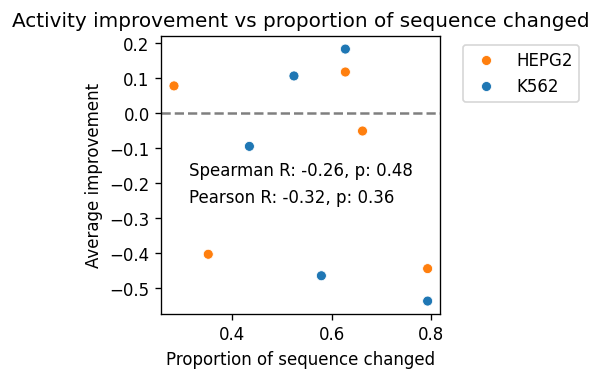

In [453]:
## R3.7.5 - Is there a correlation between the activity of generated sequences and the proportion of sequence changed? - probably no

# prop_change_df

# okay I want to make a dataframe that captures the average improvement over the original sequence for each og_seq_idx

# for each og_seq_idx, get the average improvement over the original sequence
improve_cols = ['og_seq_idx','avg_improve']
avg_improve_df = pd.DataFrame(columns=improve_cols)

for og_seq_idx in analysis_df['og_seq_idx'].unique():
    # subset analysis_df for og_seq_idx
    cur_analysis_df = analysis_df[analysis_df['og_seq_idx'] == og_seq_idx].copy()
    # get the original H2K value
    og_row = cur_analysis_df[cur_analysis_df['model_type']=='d2_meas']
    og_h2k = og_row[H2K_COL].values[0]

    # get the average improvement over the original sequence
    avg_improve = cur_analysis_df[cur_analysis_df['model_type']=='d1_finetuned'][H2K_COL].mean() - og_h2k
    # make avg_improve proportional to og_h2k
    avg_improve /= og_h2k
    avg_improve_df = pd.concat([avg_improve_df,pd.DataFrame([[int(og_seq_idx),avg_improve]],columns=improve_cols)])

# change avg_improve_df og_seq_idx to string
avg_improve_df['og_seq_idx'] = avg_improve_df['og_seq_idx'].astype(str)

# create plot_df merging avg_improve_df and prop_change_df on og_seq_idx
plot_df = pd.merge(avg_improve_df,prop_change_df,on='og_seq_idx',how='outer')
plot_df['cell_type'] = ['HEPG2']*5 + ['K562']*5
palette = {'HEPG2':'tab:orange','K562':'tab:blue'}

# finally, plot avg_improve vs prop_change, coloring points by cell_type
plt.figure(figsize=(3,3))
sns.scatterplot(data=plot_df,x='prop_change',y='avg_improve',hue='cell_type',palette=palette)
plt.xlabel('Proportion of sequence changed')
plt.ylabel('Average improvement')
plt.title('Activity improvement vs proportion of sequence changed')
# move legend outside box
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# draw horizontal line at 0
plt.axhline(y=0,color='black',linestyle='dashed',alpha=0.5)

# calculate correlation between avg_improve and prop_change and add as text to plot
rs,ps = spearmanr(plot_df['prop_change'],plot_df['avg_improve'])
plt.text(0.1,0.5,f'Spearman R: {rs:.2f}, p: {ps:.2f}',transform=plt.gca().transAxes)
rp,pp = pearsonr(plot_df['prop_change'],plot_df['avg_improve'])
plt.text(0.1,0.4,f'Pearson R: {rp:.2f}, p: {pp:.2f}',transform=plt.gca().transAxes)

### R3.8 - absolute activities of minimal enhancers ###

(368, 16)


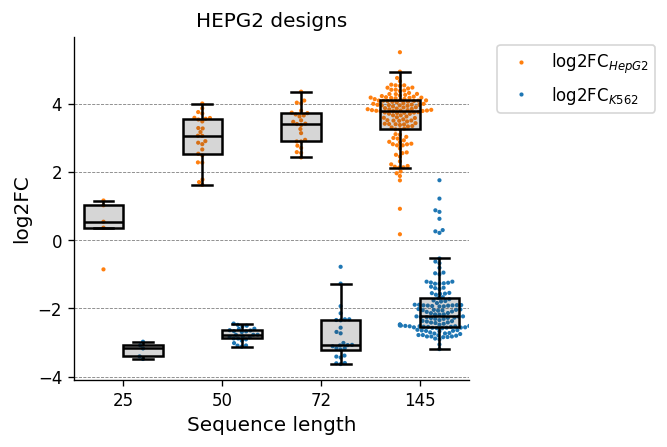

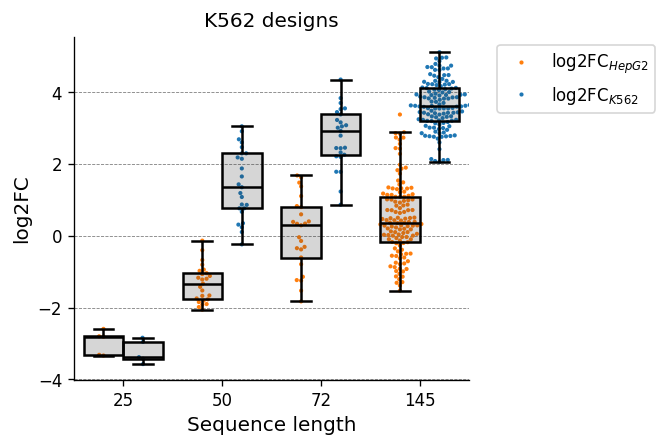

In [243]:
"""

- 2 separate boxswarms, one per cell type
- plot both HEPG2_COL and K562_COL

"""


auto_sig = False
save = False

model_types = ['d1_finetuned'] # these are the only model types with targets
# design_types = ['fsp','d2_rand_ctrl','d2_top_ctrl','NC']
design_types = ['fsp_minimal','fsp']
analysis_df = d3_seq_df[(d3_seq_df['model_type'].isin(model_types)) & (d3_seq_df['design_type'].isin(design_types))].copy()
# drop log2(SKNSH_pred) column
analysis_df.drop(columns=['log2(SKNSH)_pred'], inplace=True)
print(analysis_df.shape)

analysis_df['enhancer_len'] = analysis_df['sequence'].apply(len)

for cell_type in ['HEPG2','K562']:

    cur_analysis_df = analysis_df[analysis_df['cell_type']==cell_type].copy()

    # now melt on the HEPG2_COL and K562_COL
    cur_analysis_df = pd.melt(cur_analysis_df,id_vars=['sequence_name','enhancer_len'],value_vars=[HEPG2_COL,K562_COL],var_name='cell_type',value_name='activity')
    # replace HEPG2_COL with 'HEPG2' in cell_type column
    cur_analysis_df['cell_type'] = cur_analysis_df['cell_type'].apply(lambda x: 'HEPG2' if x == HEPG2_COL else 'K562')

    # 1 x 2 subplot
    fig, ax = plt.subplots(figsize=(2.5*1.7, 2.25*1.65))

    palette = {'HEPG2': 'tab:orange', 'K562': 'tab:blue'}

    swarm_alpha=1

    # now plot a swarm plot with each sequence_length as x, and the cell_type variable as the hue
    sns.swarmplot(x='enhancer_len',y='activity',data=cur_analysis_df,ax=ax,size=2.5,alpha=swarm_alpha,
                dodge=True,hue='cell_type',palette=palette,edgecolor='k',linewidth=0.0)

    linewidth = 1.5
    medianprops = {'color':'k','linewidth':linewidth}
    whiskerprops = {'color':'k','linewidth':linewidth}
    capprops = {'color':'k','linewidth':linewidth}
    # boxprops = {}
    boxprops={"facecolor": (.2, .2, .2, .2),'edgecolor':'k','linewidth':linewidth}

    # now plot boxplot on top of swarmplot, again separating by cell_type
    sns.boxplot(x='enhancer_len',y='activity',data=cur_analysis_df, hue='cell_type',ax=ax,showfliers=False,
                boxprops=boxprops,medianprops=medianprops,whiskerprops=whiskerprops,capprops=capprops,zorder=20)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ['log2FC$_{HepG2}$','log2FC$_{K562}$'],title='',bbox_to_anchor=(1.05, 1), loc='upper left')

    # set ylabel to log2FC
    ax.set_ylabel('log2FC',fontsize=AXIS_FSIZE)
    # set xlabel to sequence length
    ax.set_xlabel('Sequence length',fontsize=AXIS_FSIZE)

    # set title
    ax.set_title(f'')
    # add horizontal grid lines
    ax.grid(axis='y',color='gray',linestyle='--',linewidth=0.5)

    # despine
    sns.despine()
    # set xtick font size
    ax.tick_params(axis='x', labelsize=TEXT_FSIZE)
    # set ytick font size
    ax.tick_params(axis='y', labelsize=TEXT_FSIZE)
    # title: HepG2 designs
    ax.set_title(f'{cell_type} designs',fontsize=TITLE_FSIZE)


    plt.savefig(f'{revision_figure_dir}/{cell_type}_minimal_boxswarm.png',dpi=600,bbox_inches='tight')

In [233]:
# okay, let's do wilcoxon rank sum test between each consecutive sequence length, separately for HEPG2_COL and K562_COL, separate for each cell type
# go back to analysis_df

# let's do the wilcoxon rank-sum test for each enhancer length, within each model type, within each cell type

cur_col = HEPG2_COL

results_dfs = {'HEPG2': pd.DataFrame(columns=['model_type','cell_type','len1','len2','len1_median','len2_median','p']),
              'K562': pd.DataFrame(columns=['model_type','cell_type','len1','len2','len1_median','len2_median','p']),
              'H2K': pd.DataFrame(columns=['model_type','cell_type','len1','len2','len1_median','len2_median','p'])}

result_cols = [HEPG2_COL,K562_COL,H2K_COL]

for idx,col_type in enumerate(['HEPG2','K562','H2K']):
    print(f'Evaluating {col_type} activity...')
    cur_col = result_cols[idx]


    enhancer_lens = analysis_df['enhancer_len'].unique()
    enhancer_lens.sort()
    # get all consecutive pairs of enhancer lengths
    enhancer_len_pairs = list(zip(enhancer_lens[:-1],enhancer_lens[1:]))
    n_cell_lines = 2
    n_model_types = len(model_types)
    n_tests = len(enhancer_len_pairs)*n_cell_lines*n_model_types
    sig_thresh = 5e-2
    for model_type in model_types:
        
        cur_analysis_df = analysis_df[analysis_df['model_type']==model_type]
        for cell_type in ['HEPG2','K562']:
            print(f'\t{cell_type}...')
            # compare each enhancer length to the next highest enhancer length

            for l1,l2 in enhancer_len_pairs:

                # perform wilcoxon rank-sum test for each pair of targets
                s,p = ranksums(cur_analysis_df[(cur_analysis_df['cell_type']==cell_type) & (cur_analysis_df['enhancer_len']==l1)][cur_col],\
                                cur_analysis_df[(cur_analysis_df['cell_type']==cell_type) & (cur_analysis_df['enhancer_len']==l2)][cur_col])
                
                l1_median = np.median(cur_analysis_df[(cur_analysis_df['cell_type']==cell_type) & (cur_analysis_df['enhancer_len']==l1)][cur_col])
                l2_median = np.median(cur_analysis_df[(cur_analysis_df['cell_type']==cell_type) & (cur_analysis_df['enhancer_len']==l2)][cur_col])

                sig_str = "*"*10 if p * n_tests < sig_thresh else ""
                print(f'\t\t{l1} vs {l2} p = {p:>14.2E} {sig_str}')
                # append to results_df using concat
                results_dfs[col_type] = pd.concat([results_dfs[col_type],pd.DataFrame({'model_type': [model_type],
                                                        'cell_type': [cell_type],
                                                        'len1': [l1],
                                                        'len2': [l2],
                                                        'len1_median': l1_median,
                                                        'len2_median': l2_median,
                                                        'p': [p]})])
                
# HepG2

Evaluating HEPG2 activity...
	HEPG2...
		25 vs 50 p =       5.05E-04 **********
		50 vs 72 p =       7.58E-02 
		72 vs 145 p =       2.06E-02 
	K562...
		25 vs 50 p =       5.05E-04 **********
		50 vs 72 p =       4.89E-06 **********
		72 vs 145 p =       1.32E-01 
Evaluating K562 activity...
	HEPG2...
		25 vs 50 p =       2.01E-03 **********
		50 vs 72 p =       3.47E-01 
		72 vs 145 p =       3.88E-06 **********
	K562...
		25 vs 50 p =       5.05E-04 **********
		50 vs 72 p =       2.44E-05 **********
		72 vs 145 p =       3.28E-06 **********
Evaluating H2K activity...
	HEPG2...
		25 vs 50 p =       9.29E-04 **********
		50 vs 72 p =       6.12E-02 
		72 vs 145 p =       2.76E-02 
	K562...
		25 vs 50 p =       5.05E-04 **********
		50 vs 72 p =       9.46E-01 
		72 vs 145 p =       4.69E-02 


C:\Users\Chris\AppData\Local\Temp\ipykernel_25076\3232105811.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_dfs[col_type] = pd.concat([results_dfs[col_type],pd.DataFrame({'model_type': [model_type],


In [234]:
results_dfs['HEPG2']['padj'] = results_dfs['HEPG2']['p']*6 # the total number of tests on the HEPG2_COL
results_dfs['K562']['padj'] = results_dfs['K562']['p']*6 # the total number of tests on the K562_COL
results_dfs['H2K']['padj'] = results_dfs['H2K']['p']*6 # the total number of tests on the H2K_COL

results_dfs['HEPG2']['sig'] = results_dfs['HEPG2']['padj'] < 0.05
results_dfs['K562']['sig'] = results_dfs['K562']['padj'] < 0.05
results_dfs['H2K']['sig'] = results_dfs['H2K']['padj'] < 0.05

In [8]:
results_dfs['HEPG2']

model_type cell_type len1 len2  len1_median  len2_median         p  \
0  d1_finetuned     HEPG2   25   50     0.542558     3.062691  0.000505   
0  d1_finetuned     HEPG2   50   72     3.062691     3.416050  0.075838   
0  d1_finetuned     HEPG2   72  145     3.416050     3.792738  0.020610   
0  d1_finetuned      K562   25   50    -2.808912    -1.331854  0.000505   
0  d1_finetuned      K562   50   72    -1.331854     0.294986  0.000005   
0  d1_finetuned      K562   72  145     0.294986     0.366793  0.131907   

       padj    sig  
0  0.003031   True  
0  0.455030  False  
0  0.123659  False  
0  0.003031   True  
0  0.000029   True  
0  0.791442  False

In [9]:
results_dfs['K562']

model_type cell_type len1 len2  len1_median  len2_median         p  \
0  d1_finetuned     HEPG2   25   50    -3.171242    -2.769691  0.002012   
0  d1_finetuned     HEPG2   50   72    -2.769691    -3.065453  0.346685   
0  d1_finetuned     HEPG2   72  145    -3.065453    -2.232016  0.000004   
0  d1_finetuned      K562   25   50    -3.381447     1.356112  0.000505   
0  d1_finetuned      K562   50   72     1.356112     2.927120  0.000024   
0  d1_finetuned      K562   72  145     2.927120     3.626089  0.000003   

       padj    sig  
0  0.012070   True  
0  2.080112  False  
0  0.000023   True  
0  0.003031   True  
0  0.000147   True  
0  0.000020   True

In [13]:
results_dfs['H2K']

model_type cell_type len1 len2  len1_median  len2_median         p  \
0  d1_finetuned     HEPG2   25   50     3.620166     5.964549  0.000929   
0  d1_finetuned     HEPG2   50   72     5.964549     6.084506  0.061155   
0  d1_finetuned     HEPG2   72  145     6.084506     5.803444  0.027639   
0  d1_finetuned      K562   25   50     0.146995    -2.753818  0.000505   
0  d1_finetuned      K562   50   72    -2.753818    -2.649534  0.945857   
0  d1_finetuned      K562   72  145    -2.649534    -3.084117  0.046946   

       padj    sig  
0  0.005576   True  
0  0.366928  False  
0  0.165837  False  
0  0.003031   True  
0  5.675144  False  
0  0.281678  False